In [1]:
!pip install --upgrade wandb

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 1.7 MB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 283 kB 39.1 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 33.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 50.9 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 43.5 MB/s eta 0:00:01
     |████████████████████████████████| 180 kB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 36.4 MB/s eta 0:00:01
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8785 sha256=26e54707c67a8ae988f749d5bfad530fdc420568b65c9ebc823bdffd6f672200
  Stored in directory: /root/.cache/pip/wheels/c9/1e/2a/6699eb72ac8a5dad86ca87ac98d8321c35c1d9647499f166ca
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6487 sha256=431f2258725f316ce87199b4d08efe3eca57b8b2d42f54cf540df69035735db2
  Stored in directory: /root/.cache/p

In [1]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW,AutoConfig, get_cosine_schedule_with_warmup

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['WANDB_NOTEBOOK_NAME'] = "./jigsaw-trees.ipynb"

In [ ]:
import wandb

try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key='d6e9e960d')
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

In [3]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))

HASH_NAME = id_generator(size=12)
print(HASH_NAME)

5tlj0l552p73


In [4]:
CONFIG = {"seed": 2024,
          "epochs": 3,
          "model_name": "./multilingual-toxic-xlm-roberta",
          "train_batch_size": 32,
          "valid_batch_size": 2200,
          "max_length": 128,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "eval_schedule" : [(float('inf'), 100), (0.33, 120), (0.298, 32), (0.297, 16), (0.295, 8),(0.290, 1), (0, 0)],
          "hash_name": HASH_NAME
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
df_tree = pd.read_csv("./trees_fold/df_tree.csv")
df_tree.head()

df_notree = pd.read_csv("./trees_fold/no_tree.csv")
df_notree.head()

# ex1 = pd.read_csv("../input/exdata/extra1_unique.csv")
# ex2 = pd.read_csv("../input/exdata/extra2_unique.csv")
# ex = pd.concat([ex1,ex2])

# ex_unique_comments = np.unique(np.concatenate([ex.less_toxic.values, ex.more_toxic.values]))
# df_unique_comments = np.unique(np.concatenate([df.less_toxic.values, df.more_toxic.values]))
# ex_df = np.setdiff1d(ex_unique_comments, df_unique_comments, assume_unique=False) 

# ex_comment_to_fold = {}
# for comment in ex_df: 
#     ex_comment_to_fold[comment] = -1

# ex['less_toxic_fold'] = ex.less_toxic.map(ex_comment_to_fold)
# ex['more_toxic_fold'] = ex.more_toxic.map(ex_comment_to_fold)

# ex.head()

,Unnamed: 0,worker,less_toxic,more_toxic,less_toxic_enc,more_toxic_enc,pair
0,2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",2632,7222,2632-7222
1,6,52,"""\n\nHey Dude\nWell, I guess you know that TRE...",gender neutral \n\nwhy is the page called hen...,5088,3222,5088-3222
2,9,539,It's just simple Beefcake... \n\nThe recent e...,Hi \n\nI Hate you. ^_^,1459,1142,1459-1142
3,23,204,"""\n\n Adminship \n\nYou have been active for m...",hey \n\nhey persian gal. i have got a couple ...,3854,3265,3854-3265
4,31,381,"""\n\nAncestry and racial origin are interchang...",YOU DIRTY FUCKIGN NIGGER. STOP DELETEING MY WO...,4857,12599,4857-12599


In [7]:
# df_comment_to_fold = {}
# from sklearn.model_selection import KFold
# skf = KFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed']).split(df_unique_comments)

# for fold, ( _, val_) in enumerate(skf):
#     for comment in df_unique_comments[val_]: 
#         df_comment_to_fold[comment] = fold
# #     df.loc[val_ , "kfold"] = int(fold)

# df['less_toxic_fold'] = df.less_toxic.map(df_comment_to_fold)
# df['more_toxic_fold'] = df.more_toxic.map(df_comment_to_fold)

# train_df = pd.concat([df,ex]).sample(frac=1).reset_index(drop=True)
# train_df.head()

## 划分树

In [8]:
# tree_list = df_tree.tree.unique()

In [9]:
# skf = KFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed']).split(tree_list)
# tree_to_fold = {}
# for fold, ( _, val_) in enumerate(skf):
#     for tree in tree_list[val_]: 
#         tree_to_fold[tree] = fold
#     df.loc[val_ , "kfold"] = int(fold)

In [10]:
# df_tree['kfold'] = df_tree.tree.map(tree_to_fold)

In [11]:
# for fold in range(CONFIG['n_fold']):
#     number = len(df_tree[(df_tree['kfold']==fold)])
#     print(f'The {fold} fold has {number} trees data')

In [12]:
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long),
            'baseline': torch.tensor(0, dtype=torch.float)
        }

In [13]:
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        config.update({"output_hidden_states":True,
                      "hidden_dropout_prob": 0.})                       
        self.model = AutoModel.from_pretrained(model_name,config=config)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        last_hidden_states = out[0]
        feature = torch.mean(last_hidden_states, 1)
        out = self.drop(feature)
        outputs = self.fc(out)
        return outputs
# class AttentionHead(nn.Module):
#     def __init__(self, h_size, hidden_dim=512):
#         super().__init__()
#         self.W = nn.Linear(h_size, hidden_dim)
#         self.V = nn.Linear(hidden_dim, 1)
        
#     def forward(self, features):
#         att = torch.tanh(self.W(features))
#         score = self.V(att)
#         attention_weights = torch.softmax(score, dim=1)
#         context_vector = attention_weights * features
#         context_vector = torch.sum(context_vector, dim=1)

#         return context_vector

# class JigsawModel(nn.Module):
#     def __init__(self,model_name):
#         super(JigsawModel,self).__init__()
#         config = AutoConfig.from_pretrained(model_name)
#         config.update({
#             "hidden_dropout_prob": 0.,
#             "layer_norm_eps": 1e-7,
#             "output_hidden_states": True
#             }) 
#         self.h_size = config.hidden_size
#         self.transformer = AutoModel.from_pretrained(model_name, config = config)
#         self.head = AttentionHead(self.h_size*4)
#         self.drop = nn.Dropout(p=0.2)
# #         self.linear = nn.Linear(self.h_size*8, self.h_size // 2)
# #         self.linear_out = nn.Linear(self.h_size // 2, 1)
# #         self.tanh = nn.Tanh()
#         self.layer_norm = nn.LayerNorm(self.h_size*8)
#         self.dense = nn.Sequential(
#             nn.Linear(self.h_size*8, self.h_size // 2),
# #             nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
#             nn.Dropout(0.2),
#             nn.Linear(self.h_size // 2, 1)
#         )

              
#     def forward(self, input_ids, attention_mask):
#         transformer_out = self.transformer(input_ids, attention_mask)
       
#         all_hidden_states = torch.stack(transformer_out.hidden_states)
#         cat_over_last_layers = torch.cat(
#             (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]),-1
#         )
        
#         cls_pooling = cat_over_last_layers[:, 0]   
#         head_logits = self.head(cat_over_last_layers)
# #         logits = self.tanh(self.linear(torch.cat([head_logits, cls_pooling], -1)))
# #         y_hat = self.linear_out(logits)
#         cat_logits = torch.cat([head_logits, cls_pooling], -1)
#         features = self.drop(self.layer_norm(cat_logits))
#         y_hat = self.dense(features)
        
#         return y_hat
# class JigsawModel(nn.Module):
#     def __init__(self,model_name):
#         super(JigsawModel,self).__init__()
#         config = AutoConfig.from_pretrained(model_name)
#         config.update({
#             "hidden_dropout_prob": 0.,
#             "layer_norm_eps": 1e-7,
#             "output_hidden_states": True
#             }) 
#         self.h_size = config.hidden_size
#         self.transformer = AutoModel.from_pretrained(model_name, config = config)
#         self.head = AttentionHead(self.h_size*4)
#         self.linear = nn.Linear(self.h_size*8, self.h_size // 2)
#         self.linear_out = nn.Linear(self.h_size // 2, 1)
#         self.tanh = nn.Tanh()
              
#     def forward(self, input_ids, attention_mask):
#         transformer_out = self.transformer(input_ids, attention_mask)
       
#         all_hidden_states = torch.stack(transformer_out.hidden_states)
#         cat_over_last_layers = torch.cat(
#             (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]),-1
#         )
        
#         cls_pooling = cat_over_last_layers[:, 0]   
#         head_logits = self.head(cat_over_last_layers)
#         logits = self.tanh(self.linear(torch.cat([head_logits, cls_pooling], -1)))
#         y_hat = self.linear_out(logits)
        
#         return y_hat

In [14]:
import torch
from torch.optim import Optimizer
from typing import Callable, Iterable, Tuple
from torch.distributions.bernoulli import Bernoulli
import math

class ChildTuningAdamW(Optimizer):
    def __init__(
        self,
        params: Iterable[torch.nn.parameter.Parameter],
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-6,
        weight_decay: float = 0.0,
        correct_bias: bool = True,
        reserve_p = 1.0,
        mode = None
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)

        self.gradient_mask = None
        self.reserve_p = reserve_p
        self.mode = mode

    def set_gradient_mask(self, gradient_mask):
        self.gradient_mask = gradient_mask

    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.
        Arguments:
            closure (:obj:`Callable`, `optional`): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                # =================== HACK BEGIN =======================         
                if self.mode is not None:
                    if self.mode == 'ChildTuning-D':
                        if p in self.gradient_mask:
                            grad *= self.gradient_mask[p]
                    else: 
                        # ChildTuning-F
                        grad_mask = Bernoulli(grad.new_full(size=grad.size(), fill_value=self.reserve_p))
                        grad *= grad_mask.sample() / self.reserve_p
                # =================== HACK END =======================

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=1.0 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                p.data.add_(p.data, alpha=-group["lr"] * group["weight_decay"])

        return loss

In [15]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:197]#389 v387   
    attention_parameters = named_parameters[199:395]#391 395  v389 393
    regressor_parameters = named_parameters[395:]#395 v393
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})
    
    # increase lr every second layer
    increase_lr_every_k_layer = 1
#     lrs = np.linspace(1, 5, 24 // increase_lr_every_k_layer)
    lrs = np.linspace(1, 5, 12 // increase_lr_every_k_layer)
    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01
        splitted_name = name.split('.')
        lr = CONFIG['learning_rate']
        if len(splitted_name) >= 4 and str.isdigit(splitted_name[3]):
            layer_num = int(splitted_name[3])
            lr = lrs[layer_num // increase_lr_every_k_layer] * CONFIG['learning_rate']

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

#     return ChildTuningAdamW(parameters,reserve_p = 0.2,mode = 'ChildTuning-D')
    return optim.AdamW(parameters)

In [16]:
class EvaluationScheduler:
    def __init__(self, evaluation_schedule, penalize_factor=1, max_penalty=8):
        self.evaluation_schedule = evaluation_schedule
        self.evaluation_interval = self.evaluation_schedule[0][1]
        self.last_evaluation_step = 0
        self.prev_loss = float('inf')
        self.penalize_factor = penalize_factor
        self.penalty = 0
        self.prev_interval = -1
        self.max_penalty = max_penalty

    def step(self, step):
        # should we to make evaluation right now
        if step >= self.last_evaluation_step + self.evaluation_interval:
            self.last_evaluation_step = step
            return True
        else:
            return False
        
            
    def update_evaluation_interval(self, last_loss):
        # set up evaluation_interval depending on loss value
        cur_interval = -1
        for i, (loss, interval) in enumerate(self.evaluation_schedule[:-1]):
            if self.evaluation_schedule[i+1][0] < last_loss < loss:
                self.evaluation_interval = interval
                cur_interval = i
                break
        if last_loss > self.prev_loss and self.prev_interval == cur_interval:
            self.penalty += self.penalize_factor
            self.penalty = min(self.penalty, self.max_penalty)
            self.evaluation_interval += self.penalty
        else:
            self.penalty = 0
            
        self.prev_loss = last_loss
        self.prev_interval = cur_interval

In [17]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=CONFIG['margin'])(outputs1, outputs2, targets)

def criterion1(outputs1, outputs2, targets):
    loss  = torch.tensor([],dtype=torch.float,requires_grad=True).to(torch.device("cuda:0"),dtype = torch.float)
    loss2 = torch.tensor([[0]],dtype=torch.float).to(torch.device("cuda:0"),dtype = torch.float)
    loss3 = torch.tensor([[1]],dtype=torch.float).to(torch.device("cuda:0"),dtype = torch.float)
    for i,d in zip(outputs1,outputs2):
        if i<=d:
            loss = torch.cat((loss,loss3),axis = 0)
        else:
            loss = torch.cat((loss,loss2),axis = 0)
    return nn.L1Loss()(targets,loss)

In [18]:
def train_one_epoch(model, optimizer, scheduler,best_epoch_loss,evaluation_scheduler,step,valid_loader, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for stp, data in bar:
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (stp + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
            if evaluation_scheduler.step(step):
                val_epoch_loss = valid_one_epoch(model, valid_loader, device)
                print(f"Validation Loss:{val_epoch_loss},Best:{best_epoch_loss}")
                if val_epoch_loss <= best_epoch_loss:
                    print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
                    best_epoch_loss = val_epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    PATH = f"./mdb/Loss-Fold-{fold}.bin"
                    torch.save(model.state_dict(), PATH)
                    # Save a model file from the current directory
                    print(f"Model Saved{sr_}")
                evaluation_scheduler.update_evaluation_interval(val_epoch_loss)
                wandb.log({"Valid Loss": val_epoch_loss})
            step += 1
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        wandb.log({"Train Loss": epoch_loss})
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss,best_epoch_loss,evaluation_scheduler,step

In [19]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in enumerate(dataloader):        
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
#         targets = data['target'].to(device, dtype=torch.long)
        targets = data['baseline'].to(device, dtype=torch.float)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion1(more_toxic_outputs, less_toxic_outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
#         bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
#                         LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss

In [20]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    evaluation_scheduler = EvaluationScheduler(CONFIG['eval_schedule'])
    best_epoch_loss = np.inf
    history = defaultdict(list)
    step = 0
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss ,best_epoch_loss,evaluation_scheduler,step = train_one_epoch(model, optimizer, scheduler, \
                                                                                      best_epoch_loss,evaluation_scheduler,step, valid_loader,
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'])
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Best Valid Loss": best_epoch_loss})
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"./mdb/Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [21]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    df_valid = pd.concat([df_valid,df_notree]).reset_index(drop=True)
#     df_train = df[(df.less_toxic_fold != fold) & (df.more_toxic_fold != fold)].reset_index(drop=True)
#     df_valid = df[(df.less_toxic_fold == fold) & (df.more_toxic_fold == fold)].reset_index(drop=True)
    
    train_dataset = JigsawDataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = JigsawDataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    print(f'df_train has {len(df_train)} data, df_valid has {len(df_valid)} data')
    print(f'train_loader has {len(train_loader)} data, valid_loader has {len(valid_loader)} data')
    
    return train_loader, valid_loader

In [22]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [23]:
df = df_tree
# gradient_mask = np.load('electra-large-discriminator_att_dense_gm.npy',allow_pickle=True).item()
for fold in range(CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='jigsaw', 
                     config=CONFIG,
                     job_type='Train3',
                     entity="",
                     save_code=True,
                     group='xhj',
                     tags=['roberta-base', f'{HASH_NAME}', 'margin-loss'],
                     name=f'mtoxic-mpl-base-fold-{fold}')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = JigsawModel(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
#     optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
#     scheduler = fetch_scheduler(optimizer)
    optimizer = create_optimizer(model)
#     optimizer.set_gradient_mask(gradient_mask)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_training_steps=CONFIG['epochs'] * len(train_loader),
        num_warmup_steps=0.11*CONFIG['epochs'] * len(train_loader))  
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

====== Fold: 0 ======


df_train has 24157 data, df_valid has 5951 data
train_loader has 754 data, valid_loader has 3 data
[INFO] Using GPU: A100-PCIE-40GB



 13%|█▎        | 100/754 [00:33<04:12,  2.59it/s, Epoch=1, LR=0.000402, Train_Loss=0.413]

Validation Loss:0.31759368877534283,Best:inf
Validation Loss Improved (inf ---> 0.31759368877534283)


 13%|█▎        | 101/754 [00:46<45:29,  4.18s/it, Epoch=1, LR=0.000406, Train_Loss=0.41] 

Model Saved


 29%|██▉       | 220/754 [01:22<02:40,  3.32it/s, Epoch=1, LR=0.000884, Train_Loss=0.367]

Validation Loss:0.31070409381896424,Best:0.31759368877534283
Validation Loss Improved (0.31759368877534283 ---> 0.31070409381896424)


 29%|██▉       | 221/754 [01:37<41:24,  4.66s/it, Epoch=1, LR=0.000888, Train_Loss=0.366]

Model Saved


 45%|████▌     | 340/754 [02:14<02:06,  3.27it/s, Epoch=1, LR=0.000995, Train_Loss=0.349]

Validation Loss:0.3071752771762735,Best:0.31070409381896424
Validation Loss Improved (0.31070409381896424 ---> 0.3071752771762735)


 45%|████▌     | 341/754 [02:28<31:58,  4.64s/it, Epoch=1, LR=0.000995, Train_Loss=0.349]

Model Saved


 61%|██████    | 460/754 [03:05<01:30,  3.25it/s, Epoch=1, LR=0.000973, Train_Loss=0.353]

Validation Loss:0.3026382100119388,Best:0.3071752771762735
Validation Loss Improved (0.3071752771762735 ---> 0.3026382100119388)


 61%|██████    | 461/754 [03:20<23:03,  4.72s/it, Epoch=1, LR=0.000973, Train_Loss=0.352]

Model Saved


 77%|███████▋  | 580/754 [03:56<00:52,  3.31it/s, Epoch=1, LR=0.000935, Train_Loss=0.337]

Validation Loss:0.2928919566867532,Best:0.3026382100119388
Validation Loss Improved (0.3026382100119388 ---> 0.2928919566867532)


 77%|███████▋  | 581/754 [04:11<13:21,  4.63s/it, Epoch=1, LR=0.000934, Train_Loss=0.337]

Model Saved


 78%|███████▊  | 589/754 [04:23<09:09,  3.33s/it, Epoch=1, LR=0.000931, Train_Loss=0.335]

Validation Loss:0.29390018352078423,Best:0.2928919566867532


 79%|███████▉  | 598/754 [04:35<08:22,  3.22s/it, Epoch=1, LR=0.000928, Train_Loss=0.334]

Validation Loss:0.29642077134629496,Best:0.2928919566867532


 81%|████████▏ | 614/754 [04:49<07:13,  3.09s/it, Epoch=1, LR=0.000921, Train_Loss=0.333]

Validation Loss:0.2977650799614665,Best:0.2928919566867532


 86%|████████▌ | 646/754 [05:08<05:32,  3.08s/it, Epoch=1, LR=0.000907, Train_Loss=0.331]

Validation Loss:0.2972609624955218,Best:0.2928919566867532


 90%|████████▉ | 677/754 [05:18<00:23,  3.32it/s, Epoch=1, LR=0.000892, Train_Loss=0.334]

Validation Loss:0.29188371894540277,Best:0.2928919566867532
Validation Loss Improved (0.2928919566867532 ---> 0.29188371894540277)


 90%|████████▉ | 678/754 [05:31<05:15,  4.16s/it, Epoch=1, LR=0.000892, Train_Loss=0.334]

Model Saved


 91%|█████████ | 686/754 [05:43<03:44,  3.30s/it, Epoch=1, LR=0.000888, Train_Loss=0.336]

Validation Loss:0.29238783475872326,Best:0.29188371894540277


 92%|█████████▏| 695/754 [05:55<03:09,  3.20s/it, Epoch=1, LR=0.000884, Train_Loss=0.338]

Validation Loss:0.29406822912133335,Best:0.29188371894540277


 94%|█████████▎| 705/754 [06:07<02:38,  3.23s/it, Epoch=1, LR=0.000879, Train_Loss=0.339]

Validation Loss:0.2939001831902594,Best:0.29188371894540277


 95%|█████████▍| 713/754 [06:19<02:15,  3.30s/it, Epoch=1, LR=0.000874, Train_Loss=0.341]

Validation Loss:0.2944043067709135,Best:0.29188371894540277


 96%|█████████▌| 722/754 [06:31<01:42,  3.21s/it, Epoch=1, LR=0.00087, Train_Loss=0.342] 

Validation Loss:0.2952445008948638,Best:0.29188371894540277


 98%|█████████▊| 738/754 [06:45<00:49,  3.08s/it, Epoch=1, LR=0.000861, Train_Loss=0.345]

Validation Loss:0.2991093867587514,Best:0.29188371894540277


100%|██████████| 754/754 [06:50<00:00,  1.84it/s, Epoch=1, LR=0.000853, Train_Loss=0.348]


 14%|█▍        | 104/754 [00:41<33:20,  3.08s/it, Epoch=2, LR=0.000791, Train_Loss=0.323]

Validation Loss:0.2996135206958503,Best:0.29188371894540277


 30%|██▉       | 225/754 [01:27<27:00,  3.06s/it, Epoch=2, LR=0.000709, Train_Loss=0.31] 

Validation Loss:0.30314234736446094,Best:0.29188371894540277


 46%|████▌     | 347/754 [02:13<21:05,  3.11s/it, Epoch=2, LR=0.000619, Train_Loss=0.297]

Validation Loss:0.3031423363469665,Best:0.29188371894540277


 62%|██████▏   | 467/754 [02:59<14:43,  3.08s/it, Epoch=2, LR=0.000527, Train_Loss=0.306]

Validation Loss:0.2977650761604309,Best:0.29188371894540277


 66%|██████▌   | 499/754 [03:18<13:05,  3.08s/it, Epoch=2, LR=0.000502, Train_Loss=0.307]

Validation Loss:0.3002856636554168,Best:0.29188371894540277


 82%|████████▏ | 619/754 [04:04<06:52,  3.06s/it, Epoch=2, LR=0.000409, Train_Loss=0.282]

Validation Loss:0.3007897931304304,Best:0.29188371894540277


 98%|█████████▊| 740/754 [04:50<00:43,  3.08s/it, Epoch=2, LR=0.000318, Train_Loss=0.299]

Validation Loss:0.30179802475707146,Best:0.29188371894540277


100%|██████████| 754/754 [04:55<00:00,  2.55it/s, Epoch=2, LR=0.000308, Train_Loss=0.302]


 14%|█▍        | 108/754 [00:42<33:15,  3.09s/it, Epoch=3, LR=0.000233, Train_Loss=0.287]

Validation Loss:0.2994454657304309,Best:0.29188371894540277


 30%|███       | 228/754 [01:29<27:16,  3.11s/it, Epoch=3, LR=0.000159, Train_Loss=0.276]

Validation Loss:0.30095782584051106,Best:0.29188371894540277


 46%|████▋     | 349/754 [02:16<20:53,  3.09s/it, Epoch=3, LR=9.66e-5, Train_Loss=0.266] 

Validation Loss:0.3041505755205912,Best:0.29188371894540277


 62%|██████▏   | 471/754 [03:03<14:30,  3.08s/it, Epoch=3, LR=4.8e-5, Train_Loss=0.274] 

Validation Loss:0.30465469133391176,Best:0.29188371894540277


 79%|███████▉  | 594/754 [03:50<08:14,  3.09s/it, Epoch=3, LR=1.55e-5, Train_Loss=0.254]

Validation Loss:0.3068391967172323,Best:0.29188371894540277


 95%|█████████▌| 718/754 [04:37<01:50,  3.07s/it, Epoch=3, LR=7.89e-7, Train_Loss=0.267]

Validation Loss:0.30633507991233727,Best:0.29188371894540277


100%|██████████| 754/754 [04:48<00:00,  2.62it/s, Epoch=3, LR=0, Train_Loss=0.278]       



Training complete in 0h 17m 3s
Best Loss: 0.2919


Best Valid Loss,▁▁▁
Train Loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▃▂▂▂▂▃▂▂▂▂▁▁▂▂▁▁▁▂
Valid Loss,█▆▅▄▁▂▂▃▂▁▁▂▂▂▂▃▃▃▄▄▃▃▃▄▄▃▃▄▄▅▅▅
Best Valid Loss,0.29188
Train Loss,0.2777
Valid Loss,0.30634



====== Fold: 1 ======


df_train has 24013 data, df_valid has 6095 data
train_loader has 750 data, valid_loader has 3 data
[INFO] Using GPU: A100-PCIE-40GB



 13%|█▎        | 100/750 [00:30<04:04,  2.66it/s, Epoch=1, LR=0.000404, Train_Loss=0.359]

Validation Loss:0.3123872080134798,Best:inf
Validation Loss Improved (inf ---> 0.3123872080134798)


 13%|█▎        | 101/750 [00:44<45:58,  4.25s/it, Epoch=1, LR=0.000408, Train_Loss=0.359]

Model Saved


 29%|██▉       | 220/750 [01:20<02:38,  3.35it/s, Epoch=1, LR=0.000889, Train_Loss=0.344]

Validation Loss:0.30566038314781785,Best:0.3123872080134798
Validation Loss Improved (0.3123872080134798 ---> 0.30566038314781785)


 29%|██▉       | 221/750 [01:33<36:59,  4.20s/it, Epoch=1, LR=0.000893, Train_Loss=0.343]

Model Saved


 45%|████▌     | 340/750 [02:09<02:03,  3.32it/s, Epoch=1, LR=0.000995, Train_Loss=0.331]

Validation Loss:0.3031993432305111,Best:0.30566038314781785
Validation Loss Improved (0.30566038314781785 ---> 0.3031993432305111)


 45%|████▌     | 341/750 [02:24<32:45,  4.80s/it, Epoch=1, LR=0.000995, Train_Loss=0.331]

Model Saved


 61%|██████▏   | 461/750 [03:11<15:27,  3.21s/it, Epoch=1, LR=0.000972, Train_Loss=0.34] 

Validation Loss:0.30467596552330906,Best:0.3031993432305111


 77%|███████▋  | 581/750 [03:47<00:50,  3.37it/s, Epoch=1, LR=0.000933, Train_Loss=0.326]

Validation Loss:0.30237900423553754,Best:0.3031993432305111
Validation Loss Improved (0.3031993432305111 ---> 0.30237900423553754)


 78%|███████▊  | 582/750 [04:02<13:19,  4.76s/it, Epoch=1, LR=0.000933, Train_Loss=0.325]

Model Saved


 93%|█████████▎| 701/750 [04:39<00:17,  2.87it/s, Epoch=1, LR=0.000879, Train_Loss=0.331]

Validation Loss:0.30106643905788294,Best:0.30237900423553754
Validation Loss Improved (0.30237900423553754 ---> 0.30106643905788294)


 94%|█████████▎| 702/750 [04:55<03:57,  4.95s/it, Epoch=1, LR=0.000878, Train_Loss=0.331]

Model Saved


100%|██████████| 750/750 [05:09<00:00,  2.42it/s, Epoch=1, LR=0.000853, Train_Loss=0.34] 


Validation Loss Improved (0.30106643905788294 ---> 0.2989335479161307)
Model Saved



 10%|▉         | 72/750 [00:32<36:51,  3.26s/it, Epoch=2, LR=0.00081, Train_Loss=0.309] 

Validation Loss:0.2992616854210776,Best:0.2989335479161307


 26%|██▌       | 192/750 [01:19<29:49,  3.21s/it, Epoch=2, LR=0.000731, Train_Loss=0.318]

Validation Loss:0.30139458959370585,Best:0.2989335479161307


 42%|████▏     | 313/750 [02:05<23:33,  3.24s/it, Epoch=2, LR=0.000644, Train_Loss=0.293]

Validation Loss:0.2994257641973018,Best:0.2989335479161307


 58%|█████▊    | 433/750 [02:51<17:07,  3.24s/it, Epoch=2, LR=0.000551, Train_Loss=0.3]  

Validation Loss:0.30041017707886514,Best:0.2989335479161307


 74%|███████▎  | 553/750 [03:28<01:03,  3.11it/s, Epoch=2, LR=0.000457, Train_Loss=0.292]

Validation Loss:0.2964725150154496,Best:0.2989335479161307
Validation Loss Improved (0.2989335479161307 ---> 0.2964725150154496)


 74%|███████▍  | 554/750 [03:41<13:55,  4.26s/it, Epoch=2, LR=0.000457, Train_Loss=0.292]

Model Saved


 76%|███████▌  | 570/750 [03:56<09:40,  3.23s/it, Epoch=2, LR=0.000444, Train_Loss=0.288]

Validation Loss:0.29680065164026226,Best:0.2964725150154496


 78%|███████▊  | 587/750 [04:11<08:47,  3.24s/it, Epoch=2, LR=0.000431, Train_Loss=0.285]

Validation Loss:0.29696471863246726,Best:0.2964725150154496


 81%|████████  | 605/750 [04:26<07:49,  3.24s/it, Epoch=2, LR=0.000417, Train_Loss=0.282]

Validation Loss:0.2979491341544332,Best:0.2964725150154496


 85%|████████▍ | 637/750 [04:46<06:04,  3.23s/it, Epoch=2, LR=0.000392, Train_Loss=0.279]

Validation Loss:0.30237900335540335,Best:0.2964725150154496


100%|██████████| 750/750 [05:21<00:00,  2.33it/s, Epoch=2, LR=0.000308, Train_Loss=0.302]


  1%|          | 7/750 [00:12<40:31,  3.27s/it, Epoch=3, LR=0.000303, Train_Loss=0.292]

Validation Loss:0.30221493108239306,Best:0.2964725150154496


 17%|█▋        | 127/750 [00:59<33:33,  3.23s/it, Epoch=3, LR=0.00022, Train_Loss=0.283] 

Validation Loss:0.3009023780554802,Best:0.2964725150154496


 33%|███▎      | 247/750 [01:45<27:04,  3.23s/it, Epoch=3, LR=0.000148, Train_Loss=0.262]

Validation Loss:0.2984413502889153,Best:0.2964725150154496


 49%|████▉     | 367/750 [02:32<20:34,  3.22s/it, Epoch=3, LR=8.76e-5, Train_Loss=0.258] 

Validation Loss:0.2990976270590775,Best:0.2964725150154496


 65%|██████▌   | 488/750 [03:19<14:07,  3.24s/it, Epoch=3, LR=4.16e-5, Train_Loss=0.273]

Validation Loss:0.2986054160342635,Best:0.2964725150154496


 81%|████████  | 608/750 [04:05<07:39,  3.23s/it, Epoch=3, LR=1.24e-5, Train_Loss=0.246]

Validation Loss:0.3002461092065259,Best:0.2964725150154496


 97%|█████████▋| 729/750 [04:52<01:08,  3.25s/it, Epoch=3, LR=2.71e-7, Train_Loss=0.267]

Validation Loss:0.2987694904342648,Best:0.2964725150154496


100%|██████████| 750/750 [04:59<00:00,  2.51it/s, Epoch=3, LR=0, Train_Loss=0.273]       



Training complete in 0h 16m 6s
Best Loss: 0.2965


Best Valid Loss,█▁▁
Train Loss,█▆▇▇▆▆▆▆▆▆▅▅▆▅▄▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂
Valid Loss,█▅▄▅▄▃▂▂▃▂▃▁▁▁▂▄▃▄▃▂▂▂▃▂▂
Best Loss,0.29893
Best Valid Loss,0.29647
Train Loss,0.27349
Valid Loss,0.29877



====== Fold: 2 ======


df_train has 24286 data, df_valid has 5822 data
train_loader has 758 data, valid_loader has 3 data
[INFO] Using GPU: A100-PCIE-40GB



 13%|█▎        | 100/758 [00:31<04:09,  2.63it/s, Epoch=1, LR=0.0004, Train_Loss=0.384] 

Validation Loss:0.2968052102503028,Best:inf
Validation Loss Improved (inf ---> 0.2968052102503028)


 13%|█▎        | 101/758 [00:44<45:15,  4.13s/it, Epoch=1, LR=0.000404, Train_Loss=0.384]

Model Saved


 15%|█▌        | 116/758 [00:49<03:26,  3.11it/s, Epoch=1, LR=0.000464, Train_Loss=0.382]

Validation Loss:0.28993472826517724,Best:0.2968052102503028
Validation Loss Improved (0.2968052102503028 ---> 0.28993472826517724)


 15%|█▌        | 117/758 [01:04<49:49,  4.66s/it, Epoch=1, LR=0.000468, Train_Loss=0.383]

Model Saved
Validation Loss:0.2882171079838902,Best:0.28993472826517724
Validation Loss Improved (0.28993472826517724 ---> 0.2882171079838902)


 16%|█▌        | 118/758 [01:18<1:22:06,  7.70s/it, Epoch=1, LR=0.000472, Train_Loss=0.383]

Model Saved
Validation Loss:0.28718653528070337,Best:0.2882171079838902
Validation Loss Improved (0.2882171079838902 ---> 0.28718653528070337)


 16%|█▌        | 119/758 [01:31<1:38:42,  9.27s/it, Epoch=1, LR=0.000476, Train_Loss=0.383]

Model Saved
Validation Loss:0.28718652981370224,Best:0.28718653528070337
Validation Loss Improved (0.28718653528070337 ---> 0.28718652981370224)


 16%|█▌        | 120/758 [01:47<1:57:45, 11.08s/it, Epoch=1, LR=0.00048, Train_Loss=0.383] 

Model Saved
Validation Loss:0.2856406707282084,Best:0.28718652981370224
Validation Loss Improved (0.28718652981370224 ---> 0.2856406707282084)


 16%|█▌        | 121/758 [02:02<2:10:33, 12.30s/it, Epoch=1, LR=0.000484, Train_Loss=0.384]

Model Saved
Validation Loss:0.2852971510394092,Best:0.2856406707282084
Validation Loss Improved (0.2856406707282084 ---> 0.2852971510394092)


 16%|█▌        | 122/758 [02:17<2:19:28, 13.16s/it, Epoch=1, LR=0.000488, Train_Loss=0.383]

Model Saved


 16%|█▌        | 123/758 [02:27<2:08:30, 12.14s/it, Epoch=1, LR=0.000492, Train_Loss=0.382]

Validation Loss:0.28546891042310646,Best:0.2852971510394092


 16%|█▋        | 125/758 [02:37<1:33:51,  8.90s/it, Epoch=1, LR=0.0005, Train_Loss=0.381]  

Validation Loss:0.28632772011840435,Best:0.2852971510394092


 17%|█▋        | 128/758 [02:47<1:03:18,  6.03s/it, Epoch=1, LR=0.000512, Train_Loss=0.381]

Validation Loss:0.28684300465790197,Best:0.2852971510394092


 17%|█▋        | 132/758 [02:57<46:45,  4.48s/it, Epoch=1, LR=0.000528, Train_Loss=0.383]  

Validation Loss:0.28873239160198316,Best:0.2852971510394092


 18%|█▊        | 137/758 [03:08<39:08,  3.78s/it, Epoch=1, LR=0.000548, Train_Loss=0.383]

Validation Loss:0.295946413659427,Best:0.2852971510394092


 20%|██        | 153/758 [03:22<31:22,  3.11s/it, Epoch=1, LR=0.000612, Train_Loss=0.38] 

Validation Loss:0.2907935370083569,Best:0.2852971510394092


 21%|██        | 161/758 [03:34<32:24,  3.26s/it, Epoch=1, LR=0.000644, Train_Loss=0.379]

Validation Loss:0.28753005586019376,Best:0.2852971510394092


 21%|██▏       | 162/758 [03:44<51:12,  5.15s/it, Epoch=1, LR=0.000648, Train_Loss=0.379]

Validation Loss:0.2878735800945894,Best:0.2852971510394092


 22%|██▏       | 164/758 [03:54<54:10,  5.47s/it, Epoch=1, LR=0.000656, Train_Loss=0.378]

Validation Loss:0.28735829374299593,Best:0.2852971510394092


 22%|██▏       | 165/758 [04:03<1:05:52,  6.67s/it, Epoch=1, LR=0.00066, Train_Loss=0.378]

Validation Loss:0.28787358190668527,Best:0.2852971510394092


 22%|██▏       | 167/758 [04:13<1:00:55,  6.19s/it, Epoch=1, LR=0.000668, Train_Loss=0.378]

Validation Loss:0.2885606258298801,Best:0.2852971510394092


 22%|██▏       | 170/758 [04:23<49:56,  5.10s/it, Epoch=1, LR=0.00068, Train_Loss=0.379]   

Validation Loss:0.2889041536884675,Best:0.2852971510394092


 23%|██▎       | 174/758 [04:34<41:18,  4.24s/it, Epoch=1, LR=0.000696, Train_Loss=0.378]

Validation Loss:0.2885606285326672,Best:0.2852971510394092


 23%|██▎       | 175/758 [04:43<56:40,  5.83s/it, Epoch=1, LR=0.0007, Train_Loss=0.378]  

Validation Loss:0.28821710245546217,Best:0.2852971510394092


 23%|██▎       | 176/758 [04:53<1:07:20,  6.94s/it, Epoch=1, LR=0.000704, Train_Loss=0.378]

Validation Loss:0.28684300551787967,Best:0.2852971510394092


 23%|██▎       | 177/758 [05:02<1:14:38,  7.71s/it, Epoch=1, LR=0.000708, Train_Loss=0.377]

Validation Loss:0.2861559543155879,Best:0.2852971510394092


 23%|██▎       | 178/758 [05:12<1:19:54,  8.27s/it, Epoch=1, LR=0.000712, Train_Loss=0.377]

Validation Loss:0.2875300503317657,Best:0.2852971510394092


 24%|██▎       | 180/758 [05:22<1:07:29,  7.01s/it, Epoch=1, LR=0.00072, Train_Loss=0.376] 

Validation Loss:0.2882171051582492,Best:0.2852971510394092


 24%|██▍       | 183/758 [05:32<51:31,  5.38s/it, Epoch=1, LR=0.000732, Train_Loss=0.375]  

Validation Loss:0.28941943543303755,Best:0.2852971510394092


 25%|██▍       | 187/758 [05:42<41:06,  4.32s/it, Epoch=1, LR=0.000748, Train_Loss=0.374]

Validation Loss:0.2899347208939398,Best:0.2852971510394092


 25%|██▌       | 192/758 [05:53<35:31,  3.77s/it, Epoch=1, LR=0.000768, Train_Loss=0.374]

Validation Loss:0.28821710337686685,Best:0.2852971510394092


 25%|██▌       | 193/758 [06:03<51:55,  5.51s/it, Epoch=1, LR=0.000772, Train_Loss=0.374]

Validation Loss:0.2878735818759718,Best:0.2852971510394092


 26%|██▌       | 194/758 [06:12<1:03:40,  6.77s/it, Epoch=1, LR=0.000776, Train_Loss=0.373]

Validation Loss:0.28770181975877396,Best:0.2852971510394092


 26%|██▌       | 195/758 [06:22<1:11:37,  7.63s/it, Epoch=1, LR=0.00078, Train_Loss=0.373] 

Validation Loss:0.28770181975877396,Best:0.2852971510394092


 26%|██▌       | 196/758 [06:32<1:16:58,  8.22s/it, Epoch=1, LR=0.000784, Train_Loss=0.372]

Validation Loss:0.2885606312661677,Best:0.2852971510394092


 26%|██▌       | 198/758 [06:42<1:05:05,  6.97s/it, Epoch=1, LR=0.000792, Train_Loss=0.371]

Validation Loss:0.2878735800638759,Best:0.2852971510394092


 26%|██▋       | 199/758 [06:51<1:12:34,  7.79s/it, Epoch=1, LR=0.000796, Train_Loss=0.37] 

Validation Loss:0.28735829371228244,Best:0.2852971510394092


 26%|██▋       | 200/758 [07:01<1:17:46,  8.36s/it, Epoch=1, LR=0.0008, Train_Loss=0.37]  

Validation Loss:0.2885606285326672,Best:0.2852971510394092


 27%|██▋       | 202/758 [07:11<1:05:06,  7.03s/it, Epoch=1, LR=0.000808, Train_Loss=0.369]

Validation Loss:0.28804534583597896,Best:0.2852971510394092


 27%|██▋       | 203/758 [07:20<1:11:49,  7.76s/it, Epoch=1, LR=0.000812, Train_Loss=0.369]

Validation Loss:0.28821710795317673,Best:0.2852971510394092


 27%|██▋       | 205/758 [07:30<1:01:52,  6.71s/it, Epoch=1, LR=0.00082, Train_Loss=0.369] 

Validation Loss:0.2877018179466781,Best:0.2852971510394092


 27%|██▋       | 206/758 [07:40<1:09:21,  7.54s/it, Epoch=1, LR=0.000824, Train_Loss=0.368]

Validation Loss:0.2877018179466781,Best:0.2852971510394092


 27%|██▋       | 207/758 [07:49<1:14:30,  8.11s/it, Epoch=1, LR=0.000828, Train_Loss=0.368]

Validation Loss:0.28632772008769086,Best:0.2852971510394092


 27%|██▋       | 208/758 [07:59<1:18:14,  8.54s/it, Epoch=1, LR=0.000832, Train_Loss=0.368]

Validation Loss:0.2864994849383892,Best:0.2852971510394092


 28%|██▊       | 210/758 [08:08<1:04:53,  7.11s/it, Epoch=1, LR=0.00084, Train_Loss=0.366] 

Validation Loss:0.2859841931197947,Best:0.2852971510394092
Validation Loss:0.28512538707940205,Best:0.2852971510394092
Validation Loss Improved (0.2852971510394092 ---> 0.28512538707940205)


 28%|██▊       | 211/758 [08:21<1:21:05,  8.90s/it, Epoch=1, LR=0.000844, Train_Loss=0.366]

Model Saved


 28%|██▊       | 212/758 [08:31<1:23:06,  9.13s/it, Epoch=1, LR=0.000848, Train_Loss=0.365]

Validation Loss:0.2852971446510035,Best:0.28512538707940205


 28%|██▊       | 214/758 [08:41<1:07:12,  7.41s/it, Epoch=1, LR=0.000856, Train_Loss=0.364]

Validation Loss:0.2854689095017018,Best:0.28512538707940205


 28%|██▊       | 216/758 [08:42<34:14,  3.79s/it, Epoch=1, LR=0.000864, Train_Loss=0.364]  

Validation Loss:0.28426657649341297,Best:0.28512538707940205
Validation Loss Improved (0.28512538707940205 ---> 0.28426657649341297)


 29%|██▊       | 217/758 [08:57<1:05:21,  7.25s/it, Epoch=1, LR=0.000868, Train_Loss=0.363]

Model Saved


 29%|██▉       | 218/758 [09:07<1:11:29,  7.94s/it, Epoch=1, LR=0.000872, Train_Loss=0.363]

Validation Loss:0.28546890676820125,Best:0.28426657649341297


 29%|██▉       | 220/758 [09:16<1:01:06,  6.81s/it, Epoch=1, LR=0.00088, Train_Loss=0.362] 

Validation Loss:0.28443833314360967,Best:0.28426657649341297
Validation Loss:0.2839230522590173,Best:0.28426657649341297
Validation Loss Improved (0.28426657649341297 ---> 0.2839230522590173)


 29%|██▉       | 221/758 [09:29<1:17:22,  8.65s/it, Epoch=1, LR=0.000884, Train_Loss=0.362]

Model Saved


 29%|██▉       | 222/758 [09:39<1:19:50,  8.94s/it, Epoch=1, LR=0.000888, Train_Loss=0.362]

Validation Loss:0.2851253806909963,Best:0.2839230522590173


 30%|██▉       | 224/758 [09:49<1:05:16,  7.33s/it, Epoch=1, LR=0.000895, Train_Loss=0.361]

Validation Loss:0.28461009707290336,Best:0.2839230522590173


 30%|██▉       | 225/758 [09:58<1:10:50,  7.98s/it, Epoch=1, LR=0.000899, Train_Loss=0.361]

Validation Loss:0.28443833314360967,Best:0.2839230522590173


 30%|██▉       | 226/758 [10:08<1:15:12,  8.48s/it, Epoch=1, LR=0.000903, Train_Loss=0.361]

Validation Loss:0.2840948116427146,Best:0.2839230522590173


 30%|██▉       | 227/758 [10:18<1:18:04,  8.82s/it, Epoch=1, LR=0.000907, Train_Loss=0.36] 

Validation Loss:0.28546891131379765,Best:0.2839230522590173


 30%|███       | 229/758 [10:27<1:03:47,  7.24s/it, Epoch=1, LR=0.000915, Train_Loss=0.359]

Validation Loss:0.2847818628142929,Best:0.2839230522590173


 30%|███       | 230/758 [10:37<1:09:38,  7.91s/it, Epoch=1, LR=0.000919, Train_Loss=0.359]

Validation Loss:0.28495362038589434,Best:0.2839230522590173


 31%|███       | 232/758 [10:47<59:42,  6.81s/it, Epoch=1, LR=0.000927, Train_Loss=0.359]  

Validation Loss:0.2849536222287037,Best:0.2839230522590173


 31%|███       | 235/758 [10:57<46:29,  5.33s/it, Epoch=1, LR=0.000939, Train_Loss=0.359]

Validation Loss:0.2877018170559869,Best:0.2839230522590173


 32%|███▏      | 239/758 [11:07<37:07,  4.29s/it, Epoch=1, LR=0.000955, Train_Loss=0.357]

Validation Loss:0.28787357825178006,Best:0.2839230522590173


 32%|███▏      | 244/758 [11:18<32:13,  3.76s/it, Epoch=1, LR=0.000975, Train_Loss=0.358]

Validation Loss:0.28718653340718053,Best:0.2839230522590173


 32%|███▏      | 245/758 [11:28<47:05,  5.51s/it, Epoch=1, LR=0.000979, Train_Loss=0.357]

Validation Loss:0.28701476855648217,Best:0.2839230522590173


 32%|███▏      | 246/758 [11:38<57:39,  6.76s/it, Epoch=1, LR=0.000983, Train_Loss=0.358]

Validation Loss:0.28838886641546935,Best:0.2839230522590173


 33%|███▎      | 248/758 [11:47<53:01,  6.24s/it, Epoch=1, LR=0.000991, Train_Loss=0.357]

Validation Loss:0.28546891042310646,Best:0.2839230522590173


 33%|███▎      | 249/758 [11:57<1:01:18,  7.23s/it, Epoch=1, LR=0.000995, Train_Loss=0.357]

Validation Loss:0.28512538618871086,Best:0.2839230522590173


 33%|███▎      | 250/758 [12:06<1:06:58,  7.91s/it, Epoch=1, LR=0.000999, Train_Loss=0.357]

Validation Loss:0.2864994785499835,Best:0.2839230522590173


 33%|███▎      | 252/758 [12:16<57:27,  6.81s/it, Epoch=1, LR=0.001, Train_Loss=0.357]     

Validation Loss:0.28787357548756604,Best:0.2839230522590173


 34%|███▎      | 255/758 [12:27<44:37,  5.32s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.28667124705558705,Best:0.2839230522590173


 34%|███▍      | 256/758 [12:36<55:00,  6.57s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.28753005764157613,Best:0.2839230522590173


 34%|███▍      | 258/758 [12:46<51:24,  6.17s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.28907591307216474,Best:0.2839230522590173


 34%|███▍      | 261/758 [12:56<42:25,  5.12s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.28976296611726593,Best:0.2839230522590173


 35%|███▍      | 265/758 [13:07<34:55,  4.25s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.2904500100404608,Best:0.2839230522590173


 36%|███▌      | 273/758 [13:18<26:37,  3.29s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.29027825157816817,Best:0.2839230522590173


 37%|███▋      | 281/758 [13:30<26:30,  3.33s/it, Epoch=1, LR=0.000999, Train_Loss=0.354]

Validation Loss:0.2892476742679579,Best:0.2839230522590173


 37%|███▋      | 282/758 [13:40<41:24,  5.22s/it, Epoch=1, LR=0.000999, Train_Loss=0.353]

Validation Loss:0.2892476770014584,Best:0.2839230522590173


 37%|███▋      | 284/758 [13:50<43:29,  5.51s/it, Epoch=1, LR=0.000999, Train_Loss=0.353]

Validation Loss:0.28959119850235354,Best:0.2839230522590173


 38%|███▊      | 287/758 [14:00<38:21,  4.89s/it, Epoch=1, LR=0.000999, Train_Loss=0.35] 

Validation Loss:0.2883888646033735,Best:0.2839230522590173


 38%|███▊      | 288/758 [14:10<49:27,  6.31s/it, Epoch=1, LR=0.000999, Train_Loss=0.35]

Validation Loss:0.2885606312661677,Best:0.2839230522590173


 38%|███▊      | 290/758 [14:20<46:53,  6.01s/it, Epoch=1, LR=0.000999, Train_Loss=0.349]

Validation Loss:0.28804534583597896,Best:0.2839230522590173


 38%|███▊      | 291/758 [14:29<55:01,  7.07s/it, Epoch=1, LR=0.000999, Train_Loss=0.349]

Validation Loss:0.28804534583597896,Best:0.2839230522590173


 39%|███▊      | 292/758 [14:39<1:01:01,  7.86s/it, Epoch=1, LR=0.000999, Train_Loss=0.348]

Validation Loss:0.28804534036897783,Best:0.2839230522590173


 39%|███▊      | 293/758 [14:48<1:04:43,  8.35s/it, Epoch=1, LR=0.000999, Train_Loss=0.348]

Validation Loss:0.2889041536884675,Best:0.2839230522590173


 39%|███▉      | 295/758 [14:58<54:10,  7.02s/it, Epoch=1, LR=0.000999, Train_Loss=0.348]  

Validation Loss:0.2875300576722896,Best:0.2839230522590173


 39%|███▉      | 296/758 [15:08<59:55,  7.78s/it, Epoch=1, LR=0.000999, Train_Loss=0.348]

Validation Loss:0.2868430073914025,Best:0.2839230522590173


 39%|███▉      | 297/758 [15:17<1:04:05,  8.34s/it, Epoch=1, LR=0.000999, Train_Loss=0.348]

Validation Loss:0.2864994822356022,Best:0.2839230522590173


 39%|███▉      | 298/758 [15:27<1:07:13,  8.77s/it, Epoch=1, LR=0.000999, Train_Loss=0.348]

Validation Loss:0.28787358190668527,Best:0.2839230522590173


 40%|███▉      | 300/758 [15:37<55:59,  7.33s/it, Epoch=1, LR=0.000999, Train_Loss=0.347]  

Validation Loss:0.28890415187637164,Best:0.2839230522590173


 40%|███▉      | 303/758 [15:48<42:05,  5.55s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]

Validation Loss:0.2858124319240016,Best:0.2839230522590173


 40%|████      | 304/758 [15:57<51:34,  6.81s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]

Validation Loss:0.2854689076896059,Best:0.2839230522590173


 40%|████      | 305/758 [16:07<57:53,  7.67s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]

Validation Loss:0.28426657741481764,Best:0.2839230522590173


 40%|████      | 306/758 [16:17<1:02:15,  8.26s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]

Validation Loss:0.2840948152976198,Best:0.2839230522590173
Validation Loss:0.2835795225576206,Best:0.2839230522590173
Validation Loss Improved (0.2839230522590173 ---> 0.2835795225576206)


 41%|████      | 307/758 [16:32<1:17:28, 10.31s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]

Model Saved


 41%|████      | 308/758 [16:42<1:15:56, 10.13s/it, Epoch=1, LR=0.000998, Train_Loss=0.346]

Validation Loss:0.2842665746813171,Best:0.2835795225576206


 41%|████      | 310/758 [16:51<58:51,  7.88s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]  

Validation Loss:0.28392305044692145,Best:0.2835795225576206


 41%|████      | 311/758 [17:01<1:02:22,  8.37s/it, Epoch=1, LR=0.000998, Train_Loss=0.347]

Validation Loss:0.28512538618871086,Best:0.2835795225576206


 41%|████▏     | 313/758 [17:11<52:06,  7.03s/it, Epoch=1, LR=0.000998, Train_Loss=0.346]  

Validation Loss:0.28718652978298875,Best:0.2835795225576206


 42%|████▏     | 316/758 [17:21<39:38,  5.38s/it, Epoch=1, LR=0.000997, Train_Loss=0.346]

Validation Loss:0.28804533944757316,Best:0.2835795225576206


 42%|████▏     | 320/758 [17:31<31:19,  4.29s/it, Epoch=1, LR=0.000997, Train_Loss=0.346]

Validation Loss:0.2892476779228631,Best:0.2835795225576206


 43%|████▎     | 325/758 [17:42<26:54,  3.73s/it, Epoch=1, LR=0.000997, Train_Loss=0.347]

Validation Loss:0.2902782506567635,Best:0.2835795225576206


 44%|████▍     | 333/758 [17:54<23:09,  3.27s/it, Epoch=1, LR=0.000996, Train_Loss=0.347]

Validation Loss:0.28838886917968337,Best:0.2835795225576206


 44%|████▍     | 334/758 [18:03<36:21,  5.14s/it, Epoch=1, LR=0.000996, Train_Loss=0.347]

Validation Loss:0.2892476770321719,Best:0.2835795225576206


 44%|████▍     | 336/758 [18:13<38:09,  5.43s/it, Epoch=1, LR=0.000996, Train_Loss=0.346]

Validation Loss:0.2885606321875724,Best:0.2835795225576206


 44%|████▍     | 337/758 [18:22<46:30,  6.63s/it, Epoch=1, LR=0.000995, Train_Loss=0.346]

Validation Loss:0.2901064912423527,Best:0.2835795225576206


 46%|████▌     | 345/758 [18:34<23:39,  3.44s/it, Epoch=1, LR=0.000995, Train_Loss=0.346]

Validation Loss:0.28993472639165435,Best:0.2835795225576206


 46%|████▌     | 346/758 [18:44<36:07,  5.26s/it, Epoch=1, LR=0.000994, Train_Loss=0.345]

Validation Loss:0.2895912003451629,Best:0.2835795225576206


 46%|████▌     | 347/758 [18:53<44:46,  6.54s/it, Epoch=1, LR=0.000994, Train_Loss=0.346]

Validation Loss:0.28941943822796506,Best:0.2835795225576206


 46%|████▌     | 348/758 [19:03<50:50,  7.44s/it, Epoch=1, LR=0.000994, Train_Loss=0.345]

Validation Loss:0.2892476779228631,Best:0.2835795225576206


 46%|████▌     | 349/758 [19:12<55:08,  8.09s/it, Epoch=1, LR=0.000994, Train_Loss=0.345]

Validation Loss:0.2894194373065604,Best:0.2835795225576206


 46%|████▋     | 351/758 [19:22<47:09,  6.95s/it, Epoch=1, LR=0.000994, Train_Loss=0.345]

Validation Loss:0.2889041545791587,Best:0.2835795225576206


 46%|████▋     | 352/758 [19:32<52:16,  7.73s/it, Epoch=1, LR=0.000994, Train_Loss=0.345]

Validation Loss:0.28959119850235354,Best:0.2835795225576206


 47%|████▋     | 354/758 [19:42<45:19,  6.73s/it, Epoch=1, LR=0.000994, Train_Loss=0.345]

Validation Loss:0.2902782469711448,Best:0.2835795225576206


 48%|████▊     | 362/758 [19:54<22:44,  3.45s/it, Epoch=1, LR=0.000992, Train_Loss=0.346]

Validation Loss:0.2928546805719214,Best:0.2835795225576206


 49%|████▉     | 371/758 [20:06<20:43,  3.21s/it, Epoch=1, LR=0.000991, Train_Loss=0.346]

Validation Loss:0.2877018188373693,Best:0.2835795225576206


 49%|████▉     | 372/758 [20:15<32:57,  5.12s/it, Epoch=1, LR=0.000991, Train_Loss=0.345]

Validation Loss:0.2858124310025969,Best:0.2835795225576206


 49%|████▉     | 373/758 [20:25<41:27,  6.46s/it, Epoch=1, LR=0.000991, Train_Loss=0.345]

Validation Loss:0.28598419585329526,Best:0.2835795225576206


 49%|████▉     | 375/758 [20:35<38:58,  6.11s/it, Epoch=1, LR=0.000991, Train_Loss=0.345]

Validation Loss:0.28632772008769086,Best:0.2835795225576206


 50%|████▉     | 378/758 [20:45<31:58,  5.05s/it, Epoch=1, LR=0.00099, Train_Loss=0.345] 

Validation Loss:0.2863277173541903,Best:0.2835795225576206


 50%|█████     | 379/758 [20:54<40:32,  6.42s/it, Epoch=1, LR=0.00099, Train_Loss=0.345]

Validation Loss:0.2859841940411994,Best:0.2835795225576206


 50%|█████     | 380/758 [21:04<46:16,  7.34s/it, Epoch=1, LR=0.00099, Train_Loss=0.346]

Validation Loss:0.287014767665791,Best:0.2835795225576206


 50%|█████     | 382/758 [21:14<40:54,  6.53s/it, Epoch=1, LR=0.00099, Train_Loss=0.346]

Validation Loss:0.28821710614108087,Best:0.2835795225576206


 51%|█████     | 385/758 [21:24<32:18,  5.20s/it, Epoch=1, LR=0.000989, Train_Loss=0.346]

Validation Loss:0.2885606312661677,Best:0.2835795225576206


 51%|█████▏    | 389/758 [21:34<26:17,  4.27s/it, Epoch=1, LR=0.000988, Train_Loss=0.346]

Validation Loss:0.2880453449145743,Best:0.2835795225576206


 51%|█████▏    | 390/758 [21:44<35:53,  5.85s/it, Epoch=1, LR=0.000988, Train_Loss=0.345]

Validation Loss:0.288045341259669,Best:0.2835795225576206


 52%|█████▏    | 391/758 [21:53<42:37,  6.97s/it, Epoch=1, LR=0.000988, Train_Loss=0.345]

Validation Loss:0.2889041545791587,Best:0.2835795225576206


 52%|█████▏    | 393/758 [22:03<38:37,  6.35s/it, Epoch=1, LR=0.000988, Train_Loss=0.345]

Validation Loss:0.29045000816693795,Best:0.2835795225576206


 53%|█████▎    | 401/758 [22:15<20:43,  3.48s/it, Epoch=1, LR=0.000986, Train_Loss=0.345]

Validation Loss:0.2887323897284603,Best:0.2835795225576206


 53%|█████▎    | 402/758 [22:25<31:28,  5.30s/it, Epoch=1, LR=0.000986, Train_Loss=0.345]

Validation Loss:0.2887323897284603,Best:0.2835795225576206


 53%|█████▎    | 403/758 [22:34<39:04,  6.60s/it, Epoch=1, LR=0.000986, Train_Loss=0.345]

Validation Loss:0.2877018170252734,Best:0.2835795225576206


 53%|█████▎    | 404/758 [22:44<44:12,  7.49s/it, Epoch=1, LR=0.000986, Train_Loss=0.346]

Validation Loss:0.2877018170252734,Best:0.2835795225576206


 53%|█████▎    | 405/758 [22:54<47:35,  8.09s/it, Epoch=1, LR=0.000986, Train_Loss=0.346]

Validation Loss:0.28667124340068184,Best:0.2835795225576206


 54%|█████▎    | 406/758 [23:03<49:57,  8.52s/it, Epoch=1, LR=0.000985, Train_Loss=0.346]

Validation Loss:0.2863277182448815,Best:0.2835795225576206


 54%|█████▎    | 407/758 [23:13<51:48,  8.86s/it, Epoch=1, LR=0.000985, Train_Loss=0.346]

Validation Loss:0.2858124318932881,Best:0.2835795225576206


 54%|█████▍    | 408/758 [23:22<52:54,  9.07s/it, Epoch=1, LR=0.000985, Train_Loss=0.346]

Validation Loss:0.2851253861579974,Best:0.2835795225576206


 54%|█████▍    | 409/758 [23:32<53:39,  9.23s/it, Epoch=1, LR=0.000985, Train_Loss=0.346]

Validation Loss:0.2851253806909963,Best:0.2835795225576206


 54%|█████▍    | 410/758 [23:41<54:07,  9.33s/it, Epoch=1, LR=0.000985, Train_Loss=0.346]

Validation Loss:0.2854689049253919,Best:0.2835795225576206


 54%|█████▍    | 412/758 [23:51<43:20,  7.51s/it, Epoch=1, LR=0.000984, Train_Loss=0.346]

Validation Loss:0.2858124346267886,Best:0.2835795225576206


 55%|█████▍    | 415/758 [24:01<31:41,  5.54s/it, Epoch=1, LR=0.000984, Train_Loss=0.345]

Validation Loss:0.2880453385261685,Best:0.2835795225576206


 55%|█████▌    | 419/758 [24:12<24:30,  4.34s/it, Epoch=1, LR=0.000983, Train_Loss=0.346]

Validation Loss:0.2873582955243783,Best:0.2835795225576206


 55%|█████▌    | 420/758 [24:21<33:16,  5.91s/it, Epoch=1, LR=0.000983, Train_Loss=0.346]

Validation Loss:0.2870147667443863,Best:0.2835795225576206


 56%|█████▌    | 421/758 [24:31<39:10,  6.98s/it, Epoch=1, LR=0.000983, Train_Loss=0.346]

Validation Loss:0.28735829371228244,Best:0.2835795225576206


 56%|█████▌    | 423/758 [24:41<35:26,  6.35s/it, Epoch=1, LR=0.000982, Train_Loss=0.347]

Validation Loss:0.2866712443220865,Best:0.2835795225576206


 56%|█████▌    | 424/758 [24:50<40:41,  7.31s/it, Epoch=1, LR=0.000982, Train_Loss=0.347]

Validation Loss:0.2870147712899827,Best:0.2835795225576206


 56%|█████▌    | 426/758 [25:00<35:55,  6.49s/it, Epoch=1, LR=0.000981, Train_Loss=0.347]

Validation Loss:0.2880453439931696,Best:0.2835795225576206


 57%|█████▋    | 429/758 [25:10<28:33,  5.21s/it, Epoch=1, LR=0.000981, Train_Loss=0.347]

Validation Loss:0.28564066977609026,Best:0.2835795225576206


 57%|█████▋    | 430/758 [25:20<35:43,  6.54s/it, Epoch=1, LR=0.000981, Train_Loss=0.347]

Validation Loss:0.28564067069749494,Best:0.2835795225576206


 57%|█████▋    | 431/758 [25:20<25:26,  4.67s/it, Epoch=1, LR=0.00098, Train_Loss=0.347] 

Validation Loss:0.28306424075162356,Best:0.2835795225576206
Validation Loss Improved (0.2835795225576206 ---> 0.28306424075162356)


 57%|█████▋    | 432/758 [25:36<42:34,  7.84s/it, Epoch=1, LR=0.00098, Train_Loss=0.347]

Model Saved


 57%|█████▋    | 433/758 [25:45<45:17,  8.36s/it, Epoch=1, LR=0.00098, Train_Loss=0.347]

Validation Loss:0.2847818619236017,Best:0.28306424075162356


 57%|█████▋    | 435/758 [25:55<37:49,  7.03s/it, Epoch=1, LR=0.00098, Train_Loss=0.348]

Validation Loss:0.2834077622525187,Best:0.28306424075162356
Validation Loss:0.28254895440003014,Best:0.28306424075162356
Validation Loss Improved (0.28306424075162356 ---> 0.28254895440003014)


 58%|█████▊    | 436/758 [26:08<47:10,  8.79s/it, Epoch=1, LR=0.000979, Train_Loss=0.348]

Model Saved


 58%|█████▊    | 437/758 [26:18<48:21,  9.04s/it, Epoch=1, LR=0.000979, Train_Loss=0.348]

Validation Loss:0.2842665755720083,Best:0.28254895440003014


 58%|█████▊    | 439/758 [26:27<39:08,  7.36s/it, Epoch=1, LR=0.000979, Train_Loss=0.348]

Validation Loss:0.2847818619236017,Best:0.28254895440003014


 58%|█████▊    | 442/758 [26:38<29:08,  5.53s/it, Epoch=1, LR=0.000978, Train_Loss=0.348]

Validation Loss:0.2852971491965999,Best:0.28254895440003014


 59%|█████▊    | 445/758 [26:39<10:57,  2.10s/it, Epoch=1, LR=0.000977, Train_Loss=0.348]

Validation Loss:0.28203366439353145,Best:0.28254895440003014
Validation Loss Improved (0.28254895440003014 ---> 0.28203366439353145)


 59%|█████▉    | 446/758 [26:54<31:17,  6.02s/it, Epoch=1, LR=0.000977, Train_Loss=0.348]

Model Saved


 59%|█████▉    | 447/758 [27:03<36:49,  7.10s/it, Epoch=1, LR=0.000977, Train_Loss=0.349]

Validation Loss:0.2830642352846225,Best:0.28203366439353145


 59%|█████▉    | 449/758 [27:13<32:57,  6.40s/it, Epoch=1, LR=0.000976, Train_Loss=0.349]

Validation Loss:0.2835795252911212,Best:0.28203366439353145


 60%|█████▉    | 452/758 [27:23<26:20,  5.16s/it, Epoch=1, LR=0.000976, Train_Loss=0.349]

Validation Loss:0.2823771877372359,Best:0.28203366439353145
Validation Loss:0.2811748529168512,Best:0.28203366439353145
Validation Loss Improved (0.28203366439353145 ---> 0.2811748529168512)


 60%|█████▉    | 453/758 [27:36<37:59,  7.47s/it, Epoch=1, LR=0.000975, Train_Loss=0.349]

Model Saved


 60%|█████▉    | 454/758 [27:46<41:07,  8.12s/it, Epoch=1, LR=0.000975, Train_Loss=0.35] 

Validation Loss:0.28289247408882934,Best:0.2811748529168512


 60%|██████    | 456/758 [27:56<34:44,  6.90s/it, Epoch=1, LR=0.000975, Train_Loss=0.35]

Validation Loss:0.2832360028688214,Best:0.2811748529168512


 61%|██████    | 459/758 [28:06<26:36,  5.34s/it, Epoch=1, LR=0.000974, Train_Loss=0.35]

Validation Loss:0.2828924795558304,Best:0.2811748529168512


 61%|██████    | 460/758 [28:15<32:41,  6.58s/it, Epoch=1, LR=0.000974, Train_Loss=0.35]

Validation Loss:0.2835795234790253,Best:0.2811748529168512


 61%|██████    | 462/758 [28:25<30:14,  6.13s/it, Epoch=1, LR=0.000973, Train_Loss=0.35]

Validation Loss:0.2837512883297236,Best:0.2811748529168512


 61%|██████▏   | 465/758 [28:35<24:34,  5.03s/it, Epoch=1, LR=0.000972, Train_Loss=0.35]

Validation Loss:0.28426657194781657,Best:0.2811748529168512


 62%|██████▏   | 469/758 [28:45<20:10,  4.19s/it, Epoch=1, LR=0.000971, Train_Loss=0.351]

Validation Loss:0.2854689095017018,Best:0.2811748529168512


 63%|██████▎   | 474/758 [28:56<17:35,  3.72s/it, Epoch=1, LR=0.00097, Train_Loss=0.351] 

Validation Loss:0.2852971491965999,Best:0.2811748529168512


 63%|██████▎   | 475/758 [29:06<25:43,  5.45s/it, Epoch=1, LR=0.00097, Train_Loss=0.351]

Validation Loss:0.2856406688853991,Best:0.2811748529168512


 63%|██████▎   | 477/758 [29:16<26:15,  5.61s/it, Epoch=1, LR=0.000969, Train_Loss=0.351]

Validation Loss:0.28684301009418955,Best:0.2811748529168512


 63%|██████▎   | 480/758 [29:26<22:54,  4.94s/it, Epoch=1, LR=0.000969, Train_Loss=0.352]

Validation Loss:0.28684301009418955,Best:0.2811748529168512


 63%|██████▎   | 481/758 [29:36<29:29,  6.39s/it, Epoch=1, LR=0.000968, Train_Loss=0.352]

Validation Loss:0.28753005217457506,Best:0.2811748529168512


 64%|██████▎   | 483/758 [29:46<27:53,  6.09s/it, Epoch=1, LR=0.000968, Train_Loss=0.352]

Validation Loss:0.2858124318932881,Best:0.2811748529168512


 64%|██████▍   | 484/758 [29:55<32:47,  7.18s/it, Epoch=1, LR=0.000967, Train_Loss=0.352]

Validation Loss:0.2880453385261685,Best:0.2811748529168512


 64%|██████▍   | 486/758 [30:05<29:25,  6.49s/it, Epoch=1, LR=0.000967, Train_Loss=0.353]

Validation Loss:0.2897629615102425,Best:0.2811748529168512


 65%|██████▍   | 489/758 [30:16<23:31,  5.25s/it, Epoch=1, LR=0.000966, Train_Loss=0.353]

Validation Loss:0.2878735763782572,Best:0.2811748529168512


 65%|██████▍   | 490/758 [30:25<29:12,  6.54s/it, Epoch=1, LR=0.000966, Train_Loss=0.353]

Validation Loss:0.2887323869642463,Best:0.2811748529168512


 65%|██████▍   | 492/758 [30:35<27:16,  6.15s/it, Epoch=1, LR=0.000965, Train_Loss=0.353]

Validation Loss:0.2864994812527705,Best:0.2811748529168512


 65%|██████▌   | 493/758 [30:45<31:56,  7.23s/it, Epoch=1, LR=0.000965, Train_Loss=0.353]

Validation Loss:0.28615595428487434,Best:0.2811748529168512


 65%|██████▌   | 494/758 [30:54<34:54,  7.93s/it, Epoch=1, LR=0.000965, Train_Loss=0.353]

Validation Loss:0.28735829365085547,Best:0.2811748529168512


 65%|██████▌   | 496/758 [31:04<29:46,  6.82s/it, Epoch=1, LR=0.000964, Train_Loss=0.353]

Validation Loss:0.28632771729276335,Best:0.2811748529168512


 66%|██████▌   | 497/758 [31:14<33:09,  7.62s/it, Epoch=1, LR=0.000964, Train_Loss=0.353]

Validation Loss:0.28684300183226097,Best:0.2811748529168512


 66%|██████▌   | 499/758 [31:24<28:45,  6.66s/it, Epoch=1, LR=0.000963, Train_Loss=0.353]

Validation Loss:0.2871865324550623,Best:0.2811748529168512


 66%|██████▌   | 502/758 [31:34<22:35,  5.29s/it, Epoch=1, LR=0.000962, Train_Loss=0.352]

Validation Loss:0.2864994821741752,Best:0.2811748529168512


 66%|██████▋   | 503/758 [31:44<27:56,  6.57s/it, Epoch=1, LR=0.000962, Train_Loss=0.352]

Validation Loss:0.28564066977609026,Best:0.2811748529168512


 66%|██████▋   | 504/758 [31:53<31:34,  7.46s/it, Epoch=1, LR=0.000962, Train_Loss=0.352]

Validation Loss:0.2846100998064039,Best:0.2811748529168512


 67%|██████▋   | 505/758 [32:03<34:00,  8.07s/it, Epoch=1, LR=0.000961, Train_Loss=0.352]

Validation Loss:0.28409481345481047,Best:0.2811748529168512


 67%|██████▋   | 506/758 [32:12<35:56,  8.56s/it, Epoch=1, LR=0.000961, Train_Loss=0.351]

Validation Loss:0.2840948125334058,Best:0.2811748529168512


 67%|██████▋   | 507/758 [32:22<37:03,  8.86s/it, Epoch=1, LR=0.000961, Train_Loss=0.351]

Validation Loss:0.28426657283850776,Best:0.2811748529168512


 67%|██████▋   | 509/758 [32:32<30:12,  7.28s/it, Epoch=1, LR=0.00096, Train_Loss=0.35]  

Validation Loss:0.2859841912769854,Best:0.2811748529168512


 68%|██████▊   | 512/758 [32:42<22:22,  5.46s/it, Epoch=1, LR=0.000959, Train_Loss=0.35]

Validation Loss:0.28529714554169466,Best:0.2811748529168512


 68%|██████▊   | 513/758 [32:51<27:12,  6.67s/it, Epoch=1, LR=0.000959, Train_Loss=0.35]

Validation Loss:0.2856406734309955,Best:0.2811748529168512


 68%|██████▊   | 515/758 [33:01<24:57,  6.16s/it, Epoch=1, LR=0.000958, Train_Loss=0.35]

Validation Loss:0.2863277191662862,Best:0.2811748529168512


 68%|██████▊   | 518/758 [33:11<20:17,  5.07s/it, Epoch=1, LR=0.000957, Train_Loss=0.349]

Validation Loss:0.282892475010234,Best:0.2811748529168512


 68%|██████▊   | 519/758 [33:21<25:29,  6.40s/it, Epoch=1, LR=0.000957, Train_Loss=0.349]

Validation Loss:0.2834077650167327,Best:0.2811748529168512


 69%|██████▊   | 521/758 [33:31<23:59,  6.07s/it, Epoch=1, LR=0.000956, Train_Loss=0.349]

Validation Loss:0.2844383386413243,Best:0.2811748529168512


 69%|██████▉   | 524/758 [33:41<19:48,  5.08s/it, Epoch=1, LR=0.000955, Train_Loss=0.348]

Validation Loss:0.28976296157166953,Best:0.2811748529168512


 70%|██████▉   | 528/758 [33:51<16:11,  4.22s/it, Epoch=1, LR=0.000954, Train_Loss=0.347]

Validation Loss:0.2871865352499899,Best:0.2811748529168512


 70%|██████▉   | 529/758 [34:01<22:16,  5.84s/it, Epoch=1, LR=0.000954, Train_Loss=0.346]

Validation Loss:0.2889041500642757,Best:0.2811748529168512


 70%|███████   | 531/758 [34:11<21:55,  5.80s/it, Epoch=1, LR=0.000953, Train_Loss=0.346]

Validation Loss:0.285297147384504,Best:0.2811748529168512


 70%|███████   | 532/758 [34:20<26:06,  6.93s/it, Epoch=1, LR=0.000953, Train_Loss=0.346]

Validation Loss:0.282377193204237,Best:0.2811748529168512


 70%|███████   | 533/758 [34:30<28:54,  7.71s/it, Epoch=1, LR=0.000953, Train_Loss=0.346]

Validation Loss:0.2835795243697165,Best:0.2811748529168512


 71%|███████   | 535/758 [34:40<24:55,  6.71s/it, Epoch=1, LR=0.000952, Train_Loss=0.346]

Validation Loss:0.28564067346170896,Best:0.2811748529168512


 71%|███████   | 538/758 [34:50<19:21,  5.28s/it, Epoch=1, LR=0.000951, Train_Loss=0.345]

Validation Loss:0.2890759158056653,Best:0.2811748529168512


 72%|███████▏  | 542/758 [35:00<15:23,  4.28s/it, Epoch=1, LR=0.00095, Train_Loss=0.345] 

Validation Loss:0.28564067069749494,Best:0.2811748529168512


 72%|███████▏  | 543/758 [35:10<21:00,  5.86s/it, Epoch=1, LR=0.000949, Train_Loss=0.345]

Validation Loss:0.2856406716188996,Best:0.2811748529168512


 72%|███████▏  | 545/758 [35:20<20:38,  5.81s/it, Epoch=1, LR=0.000949, Train_Loss=0.344]

Validation Loss:0.2825489525879343,Best:0.2811748529168512
Validation Loss:0.28065957111085416,Best:0.2811748529168512
Validation Loss Improved (0.2811748529168512 ---> 0.28065957111085416)


 72%|███████▏  | 546/758 [35:33<28:16,  8.00s/it, Epoch=1, LR=0.000948, Train_Loss=0.343]

Model Saved
Validation Loss:0.27911371113466915,Best:0.28065957111085416
Validation Loss Improved (0.28065957111085416 ---> 0.27911371113466915)


 72%|███████▏  | 547/758 [35:48<35:39, 10.14s/it, Epoch=1, LR=0.000948, Train_Loss=0.343]

Model Saved


 72%|███████▏  | 548/758 [35:58<34:58,  9.99s/it, Epoch=1, LR=0.000948, Train_Loss=0.343]

Validation Loss:0.28048780807225165,Best:0.27911371113466915


 73%|███████▎  | 550/758 [36:07<26:59,  7.79s/it, Epoch=1, LR=0.000947, Train_Loss=0.342]

Validation Loss:0.28048780899365633,Best:0.27911371113466915


 73%|███████▎  | 553/758 [36:18<19:14,  5.63s/it, Epoch=1, LR=0.000946, Train_Loss=0.342]

Validation Loss:0.28031604506436264,Best:0.27911371113466915


 73%|███████▎  | 554/758 [36:27<23:02,  6.78s/it, Epoch=1, LR=0.000945, Train_Loss=0.342]

Validation Loss:0.2811748565717564,Best:0.27911371113466915


 73%|███████▎  | 556/758 [36:37<20:55,  6.22s/it, Epoch=1, LR=0.000945, Train_Loss=0.342]

Validation Loss:0.28306424167302824,Best:0.27911371113466915


 74%|███████▎  | 559/758 [36:47<16:54,  5.10s/it, Epoch=1, LR=0.000944, Train_Loss=0.341]

Validation Loss:0.2830642380488365,Best:0.27911371113466915


 74%|███████▍  | 560/758 [36:56<21:06,  6.40s/it, Epoch=1, LR=0.000943, Train_Loss=0.341]

Validation Loss:0.2835795289460264,Best:0.27911371113466915


 74%|███████▍  | 562/758 [37:06<19:42,  6.03s/it, Epoch=1, LR=0.000943, Train_Loss=0.34] 

Validation Loss:0.2840948152976198,Best:0.27911371113466915


 75%|███████▍  | 565/758 [37:16<16:18,  5.07s/it, Epoch=1, LR=0.000941, Train_Loss=0.34]

Validation Loss:0.2827207138144409,Best:0.27911371113466915


 75%|███████▍  | 566/758 [37:26<20:28,  6.40s/it, Epoch=1, LR=0.000941, Train_Loss=0.34]

Validation Loss:0.28272071289303624,Best:0.27911371113466915


 75%|███████▍  | 567/758 [37:36<23:28,  7.37s/it, Epoch=1, LR=0.000941, Train_Loss=0.34]

Validation Loss:0.28272071289303624,Best:0.27911371113466915


 75%|███████▍  | 568/758 [37:45<25:25,  8.03s/it, Epoch=1, LR=0.00094, Train_Loss=0.339]

Validation Loss:0.2803160477978632,Best:0.27911371113466915


 75%|███████▌  | 569/758 [37:55<26:44,  8.49s/it, Epoch=1, LR=0.00094, Train_Loss=0.339]

Validation Loss:0.2803160459857673,Best:0.27911371113466915


 75%|███████▌  | 570/758 [38:04<27:33,  8.80s/it, Epoch=1, LR=0.00094, Train_Loss=0.339]

Validation Loss:0.2796289947834755,Best:0.27911371113466915


 75%|███████▌  | 571/758 [38:14<28:06,  9.02s/it, Epoch=1, LR=0.000939, Train_Loss=0.338]

Validation Loss:0.2799725217513717,Best:0.27911371113466915


 76%|███████▌  | 573/758 [38:23<22:32,  7.31s/it, Epoch=1, LR=0.000939, Train_Loss=0.337]

Validation Loss:0.27980076144626975,Best:0.27911371113466915


 76%|███████▌  | 574/758 [38:33<24:22,  7.95s/it, Epoch=1, LR=0.000938, Train_Loss=0.337]

Validation Loss:0.2799725190178712,Best:0.27911371113466915


 76%|███████▌  | 575/758 [38:33<17:14,  5.65s/it, Epoch=1, LR=0.000938, Train_Loss=0.337]

Validation Loss:0.2791137084318821,Best:0.27911371113466915
Validation Loss Improved (0.27911371113466915 ---> 0.2791137084318821)


 76%|███████▌  | 576/758 [38:46<23:51,  7.87s/it, Epoch=1, LR=0.000937, Train_Loss=0.337]

Model Saved


 76%|███████▌  | 577/758 [38:56<25:21,  8.40s/it, Epoch=1, LR=0.000937, Train_Loss=0.337]

Validation Loss:0.2794572372118741,Best:0.2791137084318821


 76%|███████▋  | 578/758 [38:56<17:55,  5.97s/it, Epoch=1, LR=0.000937, Train_Loss=0.336]

Validation Loss:0.27894194720537546,Best:0.2791137084318821
Validation Loss Improved (0.2791137084318821 ---> 0.27894194720537546)


 76%|███████▋  | 579/758 [39:11<26:09,  8.77s/it, Epoch=1, LR=0.000936, Train_Loss=0.336]

Model Saved
Validation Loss:0.2787701823546771,Best:0.27894194720537546
Validation Loss Improved (0.27894194720537546 ---> 0.2787701823546771)


 77%|███████▋  | 580/758 [39:27<31:37, 10.66s/it, Epoch=1, LR=0.000936, Train_Loss=0.336]

Model Saved
Validation Loss:0.27791137450218856,Best:0.2787701823546771
Validation Loss Improved (0.2787701823546771 ---> 0.27791137450218856)


 77%|███████▋  | 581/758 [39:42<35:18, 11.97s/it, Epoch=1, LR=0.000935, Train_Loss=0.336]

Model Saved
Validation Loss:0.27773961511849127,Best:0.27791137450218856
Validation Loss Improved (0.27791137450218856 ---> 0.27773961511849127)


 77%|███████▋  | 582/758 [39:57<37:58, 12.95s/it, Epoch=1, LR=0.000935, Train_Loss=0.336]

Model Saved


 77%|███████▋  | 583/758 [40:06<34:55, 11.98s/it, Epoch=1, LR=0.000935, Train_Loss=0.335]

Validation Loss:0.2784266635872826,Best:0.27773961511849127


 77%|███████▋  | 585/758 [40:16<25:19,  8.78s/it, Epoch=1, LR=0.000934, Train_Loss=0.335]

Validation Loss:0.27962899840766725,Best:0.27773961511849127


 78%|███████▊  | 588/758 [40:26<16:58,  5.99s/it, Epoch=1, LR=0.000933, Train_Loss=0.335]

Validation Loss:0.2782548996272754,Best:0.27773961511849127


 78%|███████▊  | 589/758 [40:36<20:00,  7.11s/it, Epoch=1, LR=0.000932, Train_Loss=0.335]

Validation Loss:0.279113712946765,Best:0.27773961511849127


 78%|███████▊  | 591/758 [40:46<17:45,  6.38s/it, Epoch=1, LR=0.000932, Train_Loss=0.335]

Validation Loss:0.27859842112817046,Best:0.27773961511849127


 78%|███████▊  | 592/758 [40:55<20:16,  7.33s/it, Epoch=1, LR=0.000931, Train_Loss=0.334]

Validation Loss:0.2796289965648579,Best:0.27773961511849127


 78%|███████▊  | 594/758 [41:05<17:51,  6.53s/it, Epoch=1, LR=0.00093, Train_Loss=0.334] 

Validation Loss:0.28117485835313877,Best:0.27773961511849127


 79%|███████▉  | 597/758 [41:15<13:57,  5.20s/it, Epoch=1, LR=0.000929, Train_Loss=0.334]

Validation Loss:0.281518378041938,Best:0.27773961511849127


 79%|███████▉  | 601/758 [41:26<11:14,  4.29s/it, Epoch=1, LR=0.000928, Train_Loss=0.334]

Validation Loss:0.28134661865824073,Best:0.27773961511849127


 79%|███████▉  | 602/758 [41:36<15:15,  5.87s/it, Epoch=1, LR=0.000927, Train_Loss=0.334]

Validation Loss:0.2811748565410429,Best:0.27773961511849127


 80%|███████▉  | 603/758 [41:45<18:04,  6.99s/it, Epoch=1, LR=0.000927, Train_Loss=0.333]

Validation Loss:0.27945723536906475,Best:0.27773961511849127


 80%|███████▉  | 604/758 [41:55<19:54,  7.76s/it, Epoch=1, LR=0.000926, Train_Loss=0.333]

Validation Loss:0.2792854687062705,Best:0.27773961511849127


 80%|███████▉  | 605/758 [42:04<21:12,  8.31s/it, Epoch=1, LR=0.000926, Train_Loss=0.333]

Validation Loss:0.27962899751697606,Best:0.27773961511849127


 80%|████████  | 607/758 [42:14<17:39,  7.01s/it, Epoch=1, LR=0.000925, Train_Loss=0.333]

Validation Loss:0.27825490150079824,Best:0.27773961511849127


 80%|████████  | 608/758 [42:24<19:27,  7.78s/it, Epoch=1, LR=0.000925, Train_Loss=0.333]

Validation Loss:0.28014428752347476,Best:0.27773961511849127


 80%|████████  | 610/758 [42:34<16:35,  6.73s/it, Epoch=1, LR=0.000924, Train_Loss=0.333]

Validation Loss:0.2822054329298485,Best:0.27773961511849127


 81%|████████  | 613/758 [42:44<12:44,  5.27s/it, Epoch=1, LR=0.000923, Train_Loss=0.332]

Validation Loss:0.28237719415635515,Best:0.27773961511849127


 81%|████████▏ | 617/758 [42:54<10:01,  4.27s/it, Epoch=1, LR=0.000921, Train_Loss=0.332]

Validation Loss:0.2827207138451544,Best:0.27773961511849127


 82%|████████▏ | 622/758 [43:05<08:29,  3.75s/it, Epoch=1, LR=0.000919, Train_Loss=0.331]

Validation Loss:0.2820336690005548,Best:0.27773961511849127


 82%|████████▏ | 623/758 [43:15<12:22,  5.50s/it, Epoch=1, LR=0.000919, Train_Loss=0.331]

Validation Loss:0.2813466196103589,Best:0.27773961511849127


 82%|████████▏ | 624/758 [43:24<14:58,  6.70s/it, Epoch=1, LR=0.000918, Train_Loss=0.331]

Validation Loss:0.28083133325876547,Best:0.27773961511849127


 82%|████████▏ | 625/758 [43:34<16:44,  7.55s/it, Epoch=1, LR=0.000918, Train_Loss=0.331]

Validation Loss:0.28065957022016297,Best:0.27773961511849127


 83%|████████▎ | 626/758 [43:43<17:55,  8.15s/it, Epoch=1, LR=0.000917, Train_Loss=0.331]

Validation Loss:0.2811748565717564,Best:0.27773961511849127


 83%|████████▎ | 628/758 [43:53<14:56,  6.90s/it, Epoch=1, LR=0.000916, Train_Loss=0.33] 

Validation Loss:0.28392304955623027,Best:0.27773961511849127


 83%|████████▎ | 631/758 [44:03<11:15,  5.32s/it, Epoch=1, LR=0.000915, Train_Loss=0.33]

Validation Loss:0.2818619050405477,Best:0.27773961511849127


 83%|████████▎ | 632/758 [44:13<13:54,  6.63s/it, Epoch=1, LR=0.000915, Train_Loss=0.33]

Validation Loss:0.28220543200844384,Best:0.27773961511849127


 84%|████████▎ | 634/758 [44:23<12:47,  6.19s/it, Epoch=1, LR=0.000914, Train_Loss=0.33]

Validation Loss:0.2830642417037417,Best:0.27773961511849127


 84%|████████▍ | 637/758 [44:33<10:20,  5.13s/it, Epoch=1, LR=0.000913, Train_Loss=0.33]

Validation Loss:0.28323600379022607,Best:0.27773961511849127


 85%|████████▍ | 641/758 [44:43<08:13,  4.22s/it, Epoch=1, LR=0.000911, Train_Loss=0.33]

Validation Loss:0.2851253880008067,Best:0.27773961511849127


 85%|████████▌ | 646/758 [44:54<06:58,  3.74s/it, Epoch=1, LR=0.000909, Train_Loss=0.329]

Validation Loss:0.288217101564771,Best:0.27773961511849127


 86%|████████▌ | 652/758 [45:05<06:06,  3.46s/it, Epoch=1, LR=0.000906, Train_Loss=0.329]

Validation Loss:0.2880453449145743,Best:0.27773961511849127


 86%|████████▌ | 653/758 [45:15<09:13,  5.27s/it, Epoch=1, LR=0.000905, Train_Loss=0.329]

Validation Loss:0.2871865343285852,Best:0.27773961511849127


 86%|████████▋ | 654/758 [45:24<11:23,  6.57s/it, Epoch=1, LR=0.000905, Train_Loss=0.329]

Validation Loss:0.28357952621252586,Best:0.27773961511849127


 86%|████████▋ | 655/758 [45:34<12:47,  7.45s/it, Epoch=1, LR=0.000904, Train_Loss=0.329]

Validation Loss:0.28443833590782375,Best:0.27773961511849127


 87%|████████▋ | 657/758 [45:44<11:04,  6.58s/it, Epoch=1, LR=0.000904, Train_Loss=0.329]

Validation Loss:0.2825489525879343,Best:0.27773961511849127


 87%|████████▋ | 658/758 [45:53<12:24,  7.44s/it, Epoch=1, LR=0.000903, Train_Loss=0.328]

Validation Loss:0.28220543108703916,Best:0.27773961511849127


 87%|████████▋ | 659/758 [46:03<13:19,  8.07s/it, Epoch=1, LR=0.000903, Train_Loss=0.328]

Validation Loss:0.282377193204237,Best:0.27773961511849127


 87%|████████▋ | 661/758 [46:12<11:05,  6.86s/it, Epoch=1, LR=0.000902, Train_Loss=0.328]

Validation Loss:0.2798007605248651,Best:0.27773961511849127


 87%|████████▋ | 662/758 [46:22<12:15,  7.67s/it, Epoch=1, LR=0.000901, Train_Loss=0.328]

Validation Loss:0.2789419453932796,Best:0.27773961511849127


 87%|████████▋ | 663/758 [46:32<13:03,  8.25s/it, Epoch=1, LR=0.000901, Train_Loss=0.328]

Validation Loss:0.27962899840766725,Best:0.27773961511849127


 88%|████████▊ | 665/758 [46:41<10:48,  6.97s/it, Epoch=1, LR=0.0009, Train_Loss=0.329]  

Validation Loss:0.2791137084318821,Best:0.27773961511849127


 88%|████████▊ | 666/758 [46:51<11:51,  7.74s/it, Epoch=1, LR=0.000899, Train_Loss=0.329]

Validation Loss:0.2803160477978632,Best:0.27773961511849127


 88%|████████▊ | 668/758 [47:01<10:03,  6.70s/it, Epoch=1, LR=0.000898, Train_Loss=0.329]

Validation Loss:0.28048780899365633,Best:0.27773961511849127


 89%|████████▊ | 671/758 [47:11<07:35,  5.24s/it, Epoch=1, LR=0.000897, Train_Loss=0.33] 

Validation Loss:0.27980076055557856,Best:0.27773961511849127


 89%|████████▊ | 672/758 [47:20<09:20,  6.52s/it, Epoch=1, LR=0.000897, Train_Loss=0.33]

Validation Loss:0.28117485841456574,Best:0.27773961511849127


 89%|████████▉ | 674/758 [47:30<08:34,  6.12s/it, Epoch=1, LR=0.000896, Train_Loss=0.331]

Validation Loss:0.28409481351623744,Best:0.27773961511849127


 89%|████████▉ | 677/758 [47:40<06:51,  5.08s/it, Epoch=1, LR=0.000894, Train_Loss=0.331]

Validation Loss:0.2863277246640008,Best:0.27773961511849127


 90%|████████▉ | 681/758 [47:51<05:25,  4.22s/it, Epoch=1, LR=0.000892, Train_Loss=0.332]

Validation Loss:0.2873582919001866,Best:0.27773961511849127


 91%|█████████ | 686/758 [48:02<04:28,  3.73s/it, Epoch=1, LR=0.00089, Train_Loss=0.333] 

Validation Loss:0.28684300646999783,Best:0.27773961511849127


 91%|█████████ | 687/758 [48:11<06:29,  5.48s/it, Epoch=1, LR=0.000889, Train_Loss=0.334]

Validation Loss:0.2875300585936943,Best:0.27773961511849127


 91%|█████████ | 689/758 [48:21<06:27,  5.61s/it, Epoch=1, LR=0.000888, Train_Loss=0.334]

Validation Loss:0.28392304955623027,Best:0.27773961511849127


 91%|█████████ | 690/758 [48:31<07:43,  6.81s/it, Epoch=1, LR=0.000888, Train_Loss=0.334]

Validation Loss:0.2823771923135458,Best:0.27773961511849127


 91%|█████████ | 691/758 [48:40<08:28,  7.60s/it, Epoch=1, LR=0.000887, Train_Loss=0.334]

Validation Loss:0.2825489544307436,Best:0.27773961511849127


 91%|█████████▏| 693/758 [48:50<07:11,  6.64s/it, Epoch=1, LR=0.000886, Train_Loss=0.335]

Validation Loss:0.2827207138144409,Best:0.27773961511849127


 92%|█████████▏| 696/758 [49:00<05:23,  5.22s/it, Epoch=1, LR=0.000885, Train_Loss=0.335]

Validation Loss:0.2813466195796454,Best:0.27773961511849127


 92%|█████████▏| 697/758 [49:09<06:37,  6.52s/it, Epoch=1, LR=0.000884, Train_Loss=0.336]

Validation Loss:0.28254894985443374,Best:0.27773961511849127


 92%|█████████▏| 699/758 [49:19<05:59,  6.10s/it, Epoch=1, LR=0.000883, Train_Loss=0.336]

Validation Loss:0.2834077613618275,Best:0.27773961511849127


 93%|█████████▎| 702/758 [49:30<04:44,  5.09s/it, Epoch=1, LR=0.000882, Train_Loss=0.336]

Validation Loss:0.28392305044692145,Best:0.27773961511849127


 93%|█████████▎| 706/758 [49:40<03:38,  4.21s/it, Epoch=1, LR=0.00088, Train_Loss=0.337] 

Validation Loss:0.2832360019781302,Best:0.27773961511849127


 93%|█████████▎| 707/758 [49:49<04:55,  5.79s/it, Epoch=1, LR=0.000879, Train_Loss=0.337]

Validation Loss:0.28306424078233705,Best:0.27773961511849127


 93%|█████████▎| 708/758 [49:59<05:45,  6.90s/it, Epoch=1, LR=0.000879, Train_Loss=0.337]

Validation Loss:0.2842665783362223,Best:0.27773961511849127


 94%|█████████▎| 710/758 [50:09<05:02,  6.30s/it, Epoch=1, LR=0.000878, Train_Loss=0.338]

Validation Loss:0.2849536249929177,Best:0.27773961511849127


 94%|█████████▍| 713/758 [50:19<03:50,  5.11s/it, Epoch=1, LR=0.000876, Train_Loss=0.338]

Validation Loss:0.28357952986743107,Best:0.27773961511849127


 94%|█████████▍| 714/758 [50:28<04:44,  6.47s/it, Epoch=1, LR=0.000876, Train_Loss=0.338]

Validation Loss:0.28478186468781574,Best:0.27773961511849127


 94%|█████████▍| 716/758 [50:38<04:16,  6.11s/it, Epoch=1, LR=0.000875, Train_Loss=0.339]

Validation Loss:0.28409481714042917,Best:0.27773961511849127


 95%|█████████▍| 717/758 [50:48<04:52,  7.13s/it, Epoch=1, LR=0.000874, Train_Loss=0.339]

Validation Loss:0.28409481714042917,Best:0.27773961511849127


 95%|█████████▍| 718/758 [50:58<05:15,  7.88s/it, Epoch=1, LR=0.000874, Train_Loss=0.339]

Validation Loss:0.28306424443724226,Best:0.27773961511849127


 95%|█████████▍| 719/758 [51:07<05:27,  8.39s/it, Epoch=1, LR=0.000873, Train_Loss=0.339]

Validation Loss:0.2825489553521483,Best:0.27773961511849127


 95%|█████████▍| 720/758 [51:17<05:32,  8.75s/it, Epoch=1, LR=0.000873, Train_Loss=0.339]

Validation Loss:0.28203366807915015,Best:0.27773961511849127


 95%|█████████▌| 721/758 [51:26<05:31,  8.97s/it, Epoch=1, LR=0.000872, Train_Loss=0.34] 

Validation Loss:0.28203367081265074,Best:0.27773961511849127


 95%|█████████▌| 723/758 [51:36<04:14,  7.28s/it, Epoch=1, LR=0.000871, Train_Loss=0.34]

Validation Loss:0.28186190322845184,Best:0.27773961511849127


 96%|█████████▌| 724/758 [51:45<04:29,  7.94s/it, Epoch=1, LR=0.000871, Train_Loss=0.34]

Validation Loss:0.28237719412564166,Best:0.27773961511849127


 96%|█████████▌| 726/758 [51:55<03:37,  6.80s/it, Epoch=1, LR=0.00087, Train_Loss=0.341]

Validation Loss:0.28100309264246276,Best:0.27773961511849127


 96%|█████████▌| 727/758 [52:05<03:55,  7.59s/it, Epoch=1, LR=0.000869, Train_Loss=0.341]

Validation Loss:0.28117485749316107,Best:0.27773961511849127


 96%|█████████▌| 729/758 [52:14<03:11,  6.61s/it, Epoch=1, LR=0.000868, Train_Loss=0.341]

Validation Loss:0.282205430196348,Best:0.27773961511849127


 97%|█████████▋| 732/758 [52:24<02:15,  5.21s/it, Epoch=1, LR=0.000867, Train_Loss=0.342]

Validation Loss:0.2815183780726515,Best:0.27773961511849127


 97%|█████████▋| 733/758 [52:34<02:42,  6.49s/it, Epoch=1, LR=0.000866, Train_Loss=0.342]

Validation Loss:0.2823771886586406,Best:0.27773961511849127


 97%|█████████▋| 735/758 [52:44<02:19,  6.08s/it, Epoch=1, LR=0.000865, Train_Loss=0.342]

Validation Loss:0.28169014381404106,Best:0.27773961511849127


 97%|█████████▋| 736/758 [52:53<02:36,  7.10s/it, Epoch=1, LR=0.000864, Train_Loss=0.342]

Validation Loss:0.281346615034049,Best:0.27773961511849127


 97%|█████████▋| 737/758 [53:03<02:44,  7.83s/it, Epoch=1, LR=0.000864, Train_Loss=0.343]

Validation Loss:0.2801442856806654,Best:0.27773961511849127


 97%|█████████▋| 738/758 [53:12<02:46,  8.32s/it, Epoch=1, LR=0.000863, Train_Loss=0.343]

Validation Loss:0.280487809915061,Best:0.27773961511849127


 98%|█████████▊| 740/758 [53:22<02:06,  7.02s/it, Epoch=1, LR=0.000862, Train_Loss=0.343]

Validation Loss:0.28100309264246276,Best:0.27773961511849127


 98%|█████████▊| 743/758 [53:32<01:20,  5.38s/it, Epoch=1, LR=0.000861, Train_Loss=0.344]

Validation Loss:0.282205430196348,Best:0.27773961511849127


 99%|█████████▊| 747/758 [53:43<00:47,  4.30s/it, Epoch=1, LR=0.000859, Train_Loss=0.344]

Validation Loss:0.2818619059619524,Best:0.27773961511849127


 99%|█████████▊| 748/758 [53:52<00:58,  5.87s/it, Epoch=1, LR=0.000858, Train_Loss=0.345]

Validation Loss:0.282205430196348,Best:0.27773961511849127


 99%|█████████▉| 750/758 [54:02<00:46,  5.82s/it, Epoch=1, LR=0.000857, Train_Loss=0.345]

Validation Loss:0.28357952986743107,Best:0.27773961511849127


 99%|█████████▉| 753/758 [54:12<00:24,  4.96s/it, Epoch=1, LR=0.000855, Train_Loss=0.345]

Validation Loss:0.28409481714042917,Best:0.27773961511849127


100%|█████████▉| 757/758 [54:23<00:04,  4.18s/it, Epoch=1, LR=0.000853, Train_Loss=0.346]

Validation Loss:0.2851253852980197,Best:0.27773961511849127


100%|██████████| 758/758 [54:23<00:00,  4.31s/it, Epoch=1, LR=0.000853, Train_Loss=0.346]


  1%|          | 4/758 [00:10<39:03,  3.11s/it, Epoch=2, LR=0.00085, Train_Loss=0.345] 

Validation Loss:0.2858124346882156,Best:0.27773961511849127


  1%|▏         | 10/758 [00:21<42:38,  3.42s/it, Epoch=2, LR=0.000847, Train_Loss=0.321]

Validation Loss:0.2818619086954529,Best:0.27773961511849127


  1%|▏         | 11/758 [00:31<1:05:20,  5.25s/it, Epoch=2, LR=0.000846, Train_Loss=0.316]

Validation Loss:0.2818619041498565,Best:0.27773961511849127


  2%|▏         | 12/758 [00:40<1:20:57,  6.51s/it, Epoch=2, LR=0.000846, Train_Loss=0.316]

Validation Loss:0.28186190777404824,Best:0.27773961511849127


  2%|▏         | 14/758 [00:50<1:16:02,  6.13s/it, Epoch=2, LR=0.000845, Train_Loss=0.309]

Validation Loss:0.2828924786651392,Best:0.27773961511849127


  2%|▏         | 17/758 [01:00<1:02:37,  5.07s/it, Epoch=2, LR=0.000843, Train_Loss=0.33] 

Validation Loss:0.28254895719495765,Best:0.27773961511849127


  2%|▏         | 18/758 [01:10<1:19:33,  6.45s/it, Epoch=2, LR=0.000842, Train_Loss=0.328]

Validation Loss:0.282548956273553,Best:0.27773961511849127


  3%|▎         | 19/758 [01:19<1:30:51,  7.38s/it, Epoch=2, LR=0.000842, Train_Loss=0.326]

Validation Loss:0.28443833956272896,Best:0.27773961511849127


  3%|▎         | 21/758 [01:29<1:20:33,  6.56s/it, Epoch=2, LR=0.000841, Train_Loss=0.317]

Validation Loss:0.28443834045342015,Best:0.27773961511849127


  3%|▎         | 24/758 [01:40<1:04:02,  5.23s/it, Epoch=2, LR=0.000839, Train_Loss=0.317]

Validation Loss:0.2849536258836089,Best:0.27773961511849127


  4%|▎         | 28/758 [01:50<51:39,  4.25s/it, Epoch=2, LR=0.000837, Train_Loss=0.315]  

Validation Loss:0.2870147667443863,Best:0.27773961511849127


  4%|▍         | 33/758 [02:01<45:25,  3.76s/it, Epoch=2, LR=0.000834, Train_Loss=0.323]

Validation Loss:0.2901064885088522,Best:0.27773961511849127


  5%|▌         | 41/758 [02:12<38:46,  3.25s/it, Epoch=2, LR=0.000829, Train_Loss=0.323]

Validation Loss:0.29010648577535164,Best:0.27773961511849127


  6%|▋         | 49/758 [02:24<38:27,  3.25s/it, Epoch=2, LR=0.000825, Train_Loss=0.311]

Validation Loss:0.28357952532183467,Best:0.27773961511849127


  7%|▋         | 50/758 [02:34<1:00:22,  5.12s/it, Epoch=2, LR=0.000824, Train_Loss=0.31]

Validation Loss:0.28272071743863264,Best:0.27773961511849127


  7%|▋         | 51/758 [02:43<1:15:53,  6.44s/it, Epoch=2, LR=0.000823, Train_Loss=0.307]

Validation Loss:0.28203366350284026,Best:0.27773961511849127


  7%|▋         | 52/758 [02:53<1:26:41,  7.37s/it, Epoch=2, LR=0.000823, Train_Loss=0.306]

Validation Loss:0.28306423620602716,Best:0.27773961511849127


  7%|▋         | 54/758 [03:03<1:16:58,  6.56s/it, Epoch=2, LR=0.000822, Train_Loss=0.305]

Validation Loss:0.2823771877372359,Best:0.27773961511849127


  7%|▋         | 55/758 [03:12<1:27:25,  7.46s/it, Epoch=2, LR=0.000821, Train_Loss=0.307]

Validation Loss:0.282892475010234,Best:0.27773961511849127


  8%|▊         | 57/758 [03:22<1:17:03,  6.60s/it, Epoch=2, LR=0.00082, Train_Loss=0.314] 

Validation Loss:0.2825489507758384,Best:0.27773961511849127


  8%|▊         | 58/758 [03:32<1:27:22,  7.49s/it, Epoch=2, LR=0.000819, Train_Loss=0.314]

Validation Loss:0.281861904119143,Best:0.27773961511849127


  8%|▊         | 59/758 [03:41<1:34:19,  8.10s/it, Epoch=2, LR=0.000819, Train_Loss=0.312]

Validation Loss:0.282377193204237,Best:0.27773961511849127


  8%|▊         | 61/758 [03:51<1:20:20,  6.92s/it, Epoch=2, LR=0.000817, Train_Loss=0.309]

Validation Loss:0.28203366715774547,Best:0.27773961511849127


  8%|▊         | 62/758 [04:01<1:29:26,  7.71s/it, Epoch=2, LR=0.000817, Train_Loss=0.313]

Validation Loss:0.2813466159554537,Best:0.27773961511849127


  8%|▊         | 63/758 [04:10<1:35:39,  8.26s/it, Epoch=2, LR=0.000816, Train_Loss=0.314]

Validation Loss:0.28117485383825586,Best:0.27773961511849127


  8%|▊         | 64/758 [04:20<1:39:55,  8.64s/it, Epoch=2, LR=0.000816, Train_Loss=0.313]

Validation Loss:0.28169014473544574,Best:0.27773961511849127


  9%|▊         | 66/758 [04:30<1:22:25,  7.15s/it, Epoch=2, LR=0.000814, Train_Loss=0.311]

Validation Loss:0.28203366442424493,Best:0.27773961511849127


  9%|▉         | 69/758 [04:40<1:02:16,  5.42s/it, Epoch=2, LR=0.000813, Train_Loss=0.318]

Validation Loss:0.28169014018984934,Best:0.27773961511849127


  9%|▉         | 70/758 [04:49<1:16:19,  6.66s/it, Epoch=2, LR=0.000812, Train_Loss=0.317]

Validation Loss:0.2815183826182479,Best:0.27773961511849127


  9%|▉         | 71/758 [04:59<1:26:27,  7.55s/it, Epoch=2, LR=0.000811, Train_Loss=0.316]

Validation Loss:0.28065957111085416,Best:0.27773961511849127


  9%|▉         | 72/758 [05:09<1:33:19,  8.16s/it, Epoch=2, LR=0.000811, Train_Loss=0.316]

Validation Loss:0.27962899475276204,Best:0.27773961511849127


 10%|▉         | 73/758 [05:18<1:37:53,  8.57s/it, Epoch=2, LR=0.00081, Train_Loss=0.317] 

Validation Loss:0.28031604414295797,Best:0.27773961511849127


 10%|▉         | 75/758 [05:28<1:21:23,  7.15s/it, Epoch=2, LR=0.000809, Train_Loss=0.316]

Validation Loss:0.28134661865824073,Best:0.27773961511849127


 10%|█         | 78/758 [05:38<1:01:43,  5.45s/it, Epoch=2, LR=0.000807, Train_Loss=0.319]

Validation Loss:0.28151837622984216,Best:0.27773961511849127


 11%|█         | 82/758 [05:49<48:47,  4.33s/it, Epoch=2, LR=0.000805, Train_Loss=0.322]  

Validation Loss:0.27962899475276204,Best:0.27773961511849127


 11%|█         | 83/758 [05:58<1:06:31,  5.91s/it, Epoch=2, LR=0.000804, Train_Loss=0.323]

Validation Loss:0.2794572371811606,Best:0.27773961511849127


 11%|█         | 84/758 [06:08<1:18:56,  7.03s/it, Epoch=2, LR=0.000803, Train_Loss=0.324]

Validation Loss:0.2803160477671497,Best:0.27773961511849127


 11%|█▏        | 86/758 [06:18<1:11:26,  6.38s/it, Epoch=2, LR=0.000802, Train_Loss=0.323]

Validation Loss:0.2822054292442298,Best:0.27773961511849127


 12%|█▏        | 89/758 [06:28<57:58,  5.20s/it, Epoch=2, LR=0.0008, Train_Loss=0.325]    

Validation Loss:0.2834077622525187,Best:0.27773961511849127


 12%|█▏        | 93/758 [06:39<47:22,  4.27s/it, Epoch=2, LR=0.000798, Train_Loss=0.325]

Validation Loss:0.2823771895493318,Best:0.27773961511849127


 12%|█▏        | 94/758 [06:48<1:04:52,  5.86s/it, Epoch=2, LR=0.000797, Train_Loss=0.326]

Validation Loss:0.28289247863442574,Best:0.27773961511849127


 13%|█▎        | 96/758 [06:58<1:03:54,  5.79s/it, Epoch=2, LR=0.000796, Train_Loss=0.327]

Validation Loss:0.28272071651722797,Best:0.27773961511849127


 13%|█▎        | 97/758 [07:08<1:16:12,  6.92s/it, Epoch=2, LR=0.000795, Train_Loss=0.328]

Validation Loss:0.28357952710321704,Best:0.27773961511849127


 13%|█▎        | 99/758 [07:17<1:09:16,  6.31s/it, Epoch=2, LR=0.000794, Train_Loss=0.328]

Validation Loss:0.2844383386106108,Best:0.27773961511849127


 13%|█▎        | 102/758 [07:28<56:09,  5.14s/it, Epoch=2, LR=0.000792, Train_Loss=0.328] 

Validation Loss:0.2840948079878094,Best:0.27773961511849127


 14%|█▎        | 103/758 [07:37<1:10:23,  6.45s/it, Epoch=2, LR=0.000792, Train_Loss=0.329]

Validation Loss:0.28340776314320987,Best:0.27773961511849127


 14%|█▎        | 104/758 [07:47<1:20:08,  7.35s/it, Epoch=2, LR=0.000791, Train_Loss=0.329]

Validation Loss:0.2822054255893246,Best:0.27773961511849127


 14%|█▍        | 105/758 [07:56<1:26:53,  7.98s/it, Epoch=2, LR=0.00079, Train_Loss=0.33]  

Validation Loss:0.2825489525572208,Best:0.27773961511849127


 14%|█▍        | 107/758 [08:06<1:14:06,  6.83s/it, Epoch=2, LR=0.000789, Train_Loss=0.331]

Validation Loss:0.2822054265107293,Best:0.27773961511849127


 14%|█▍        | 108/758 [08:15<1:22:39,  7.63s/it, Epoch=2, LR=0.000788, Train_Loss=0.331]

Validation Loss:0.2827207155958233,Best:0.27773961511849127


 15%|█▍        | 110/758 [08:25<1:12:43,  6.73s/it, Epoch=2, LR=0.000787, Train_Loss=0.33] 

Validation Loss:0.28340775951901814,Best:0.27773961511849127


 15%|█▍        | 113/758 [08:36<56:55,  5.30s/it, Epoch=2, LR=0.000785, Train_Loss=0.33]  

Validation Loss:0.2834077622525187,Best:0.27773961511849127


 15%|█▌        | 117/758 [08:46<45:53,  4.30s/it, Epoch=2, LR=0.000783, Train_Loss=0.33] 

Validation Loss:0.28340776406461454,Best:0.27773961511849127


 16%|█▌        | 122/758 [08:57<39:42,  3.75s/it, Epoch=2, LR=0.000779, Train_Loss=0.331]

Validation Loss:0.2822054301656345,Best:0.27773961511849127


 16%|█▌        | 123/758 [09:06<58:03,  5.49s/it, Epoch=2, LR=0.000779, Train_Loss=0.331]

Validation Loss:0.2822054246986334,Best:0.27773961511849127


 16%|█▋        | 124/758 [09:16<1:10:55,  6.71s/it, Epoch=2, LR=0.000778, Train_Loss=0.33]

Validation Loss:0.2832360028688214,Best:0.27773961511849127


 17%|█▋        | 126/758 [09:26<1:05:34,  6.23s/it, Epoch=2, LR=0.000777, Train_Loss=0.331]

Validation Loss:0.2822054265107293,Best:0.27773961511849127


 17%|█▋        | 127/758 [09:36<1:16:09,  7.24s/it, Epoch=2, LR=0.000776, Train_Loss=0.33] 

Validation Loss:0.2823771886279271,Best:0.27773961511849127


 17%|█▋        | 129/758 [09:45<1:08:10,  6.50s/it, Epoch=2, LR=0.000775, Train_Loss=0.331]

Validation Loss:0.2827207128623227,Best:0.27773961511849127


 17%|█▋        | 132/758 [09:56<54:23,  5.21s/it, Epoch=2, LR=0.000773, Train_Loss=0.332]  

Validation Loss:0.28272071378372743,Best:0.27773961511849127


 18%|█▊        | 136/758 [10:06<44:05,  4.25s/it, Epoch=2, LR=0.00077, Train_Loss=0.333] 

Validation Loss:0.28426657649341297,Best:0.27773961511849127


 19%|█▊        | 141/758 [10:17<38:45,  3.77s/it, Epoch=2, LR=0.000767, Train_Loss=0.335]

Validation Loss:0.2851253852365927,Best:0.27773961511849127


 19%|█▉        | 147/758 [10:28<35:46,  3.51s/it, Epoch=2, LR=0.000763, Train_Loss=0.335]

Validation Loss:0.2839230486041121,Best:0.27773961511849127


 20%|█▉        | 148/758 [10:38<54:09,  5.33s/it, Epoch=2, LR=0.000763, Train_Loss=0.335]

Validation Loss:0.2844383386106108,Best:0.27773961511849127


 20%|█▉        | 150/758 [10:48<56:20,  5.56s/it, Epoch=2, LR=0.000761, Train_Loss=0.335]

Validation Loss:0.2844383386106108,Best:0.27773961511849127


 20%|█▉        | 151/758 [10:57<1:08:32,  6.78s/it, Epoch=2, LR=0.000761, Train_Loss=0.334]

Validation Loss:0.28478186103291053,Best:0.27773961511849127


 20%|██        | 153/758 [11:07<1:03:13,  6.27s/it, Epoch=2, LR=0.000759, Train_Loss=0.335]

Validation Loss:0.28203366896984133,Best:0.27773961511849127


 20%|██        | 154/758 [11:17<1:12:57,  7.25s/it, Epoch=2, LR=0.000759, Train_Loss=0.334]

Validation Loss:0.2823771886586406,Best:0.27773961511849127


 21%|██        | 156/758 [11:27<1:04:41,  6.45s/it, Epoch=2, LR=0.000757, Train_Loss=0.334]

Validation Loss:0.2835795252911212,Best:0.27773961511849127


 21%|██        | 159/758 [11:37<51:55,  5.20s/it, Epoch=2, LR=0.000755, Train_Loss=0.334]  

Validation Loss:0.27997251990856237,Best:0.27773961511849127


 21%|██        | 160/758 [11:46<1:04:37,  6.48s/it, Epoch=2, LR=0.000755, Train_Loss=0.334]

Validation Loss:0.28014428475926073,Best:0.27773961511849127


 21%|██▏       | 162/758 [11:56<1:00:27,  6.09s/it, Epoch=2, LR=0.000753, Train_Loss=0.334]

Validation Loss:0.2799725180964665,Best:0.27773961511849127


 22%|██▏       | 163/758 [12:06<1:10:34,  7.12s/it, Epoch=2, LR=0.000753, Train_Loss=0.334]

Validation Loss:0.2799725180964665,Best:0.27773961511849127


 22%|██▏       | 164/758 [12:15<1:17:48,  7.86s/it, Epoch=2, LR=0.000752, Train_Loss=0.334]

Validation Loss:0.28048780444805993,Best:0.27773961511849127


 22%|██▏       | 166/758 [12:25<1:06:47,  6.77s/it, Epoch=2, LR=0.000751, Train_Loss=0.334]

Validation Loss:0.28203366439353145,Best:0.27773961511849127


 22%|██▏       | 169/758 [12:35<51:48,  5.28s/it, Epoch=2, LR=0.000748, Train_Loss=0.335]  

Validation Loss:0.2794572326355642,Best:0.27773961511849127


 22%|██▏       | 170/758 [12:45<1:04:08,  6.55s/it, Epoch=2, LR=0.000748, Train_Loss=0.335]

Validation Loss:0.27962899475276204,Best:0.27773961511849127


 23%|██▎       | 172/758 [12:54<59:44,  6.12s/it, Epoch=2, LR=0.000746, Train_Loss=0.336]  

Validation Loss:0.281518378041938,Best:0.27773961511849127


 23%|██▎       | 175/758 [13:05<49:28,  5.09s/it, Epoch=2, LR=0.000744, Train_Loss=0.334]

Validation Loss:0.2811748529168512,Best:0.27773961511849127


 23%|██▎       | 176/758 [13:14<1:02:43,  6.47s/it, Epoch=2, LR=0.000744, Train_Loss=0.335]

Validation Loss:0.28014428383785606,Best:0.27773961511849127


 23%|██▎       | 177/758 [13:24<1:11:54,  7.43s/it, Epoch=2, LR=0.000743, Train_Loss=0.334]

Validation Loss:0.2808313277610509,Best:0.27773961511849127


 24%|██▎       | 179/758 [13:34<1:03:16,  6.56s/it, Epoch=2, LR=0.000742, Train_Loss=0.333]

Validation Loss:0.2806595656438531,Best:0.27773961511849127


 24%|██▎       | 180/758 [13:43<1:11:56,  7.47s/it, Epoch=2, LR=0.000741, Train_Loss=0.333]

Validation Loss:0.2808313323066473,Best:0.27773961511849127


 24%|██▍       | 182/758 [13:53<1:03:22,  6.60s/it, Epoch=2, LR=0.00074, Train_Loss=0.332] 

Validation Loss:0.28134661411264433,Best:0.27773961511849127


 24%|██▍       | 185/758 [14:04<49:59,  5.23s/it, Epoch=2, LR=0.000738, Train_Loss=0.332]  

Validation Loss:0.28289247316742466,Best:0.27773961511849127


 25%|██▍       | 189/758 [14:14<40:18,  4.25s/it, Epoch=2, LR=0.000735, Train_Loss=0.332]

Validation Loss:0.28392305044692145,Best:0.27773961511849127


 26%|██▌       | 194/758 [14:25<35:05,  3.73s/it, Epoch=2, LR=0.000731, Train_Loss=0.331]

Validation Loss:0.284781861063624,Best:0.27773961511849127


 26%|██▋       | 200/758 [14:36<32:01,  3.44s/it, Epoch=2, LR=0.000727, Train_Loss=0.329]

Validation Loss:0.28546891226591586,Best:0.27773961511849127


 27%|██▋       | 207/758 [14:47<30:20,  3.30s/it, Epoch=2, LR=0.000722, Train_Loss=0.326]

Validation Loss:0.2856406716496131,Best:0.27773961511849127


 28%|██▊       | 215/758 [14:59<29:25,  3.25s/it, Epoch=2, LR=0.000717, Train_Loss=0.322]

Validation Loss:0.2844383377199196,Best:0.27773961511849127


 28%|██▊       | 216/758 [15:08<46:37,  5.16s/it, Epoch=2, LR=0.000716, Train_Loss=0.321]

Validation Loss:0.2827207156265368,Best:0.27773961511849127


 29%|██▊       | 217/758 [15:18<58:36,  6.50s/it, Epoch=2, LR=0.000716, Train_Loss=0.321]

Validation Loss:0.2827207183600373,Best:0.27773961511849127


 29%|██▉       | 219/758 [15:28<54:51,  6.11s/it, Epoch=2, LR=0.000714, Train_Loss=0.32] 

Validation Loss:0.2832360019781302,Best:0.27773961511849127


 29%|██▉       | 222/758 [15:38<45:20,  5.08s/it, Epoch=2, LR=0.000712, Train_Loss=0.319]

Validation Loss:0.2834077613618275,Best:0.27773961511849127


 30%|██▉       | 226/758 [15:49<37:59,  4.29s/it, Epoch=2, LR=0.000709, Train_Loss=0.318]

Validation Loss:0.28512538618871086,Best:0.27773961511849127


 30%|███       | 231/758 [15:59<33:08,  3.77s/it, Epoch=2, LR=0.000706, Train_Loss=0.316]

Validation Loss:0.2861559580012066,Best:0.27773961511849127


 31%|███▏      | 237/758 [16:11<30:26,  3.51s/it, Epoch=2, LR=0.000701, Train_Loss=0.315]

Validation Loss:0.28461010349202265,Best:0.27773961511849127


 31%|███▏      | 238/758 [16:20<46:15,  5.34s/it, Epoch=2, LR=0.000701, Train_Loss=0.315]

Validation Loss:0.28461010349202265,Best:0.27773961511849127


 32%|███▏      | 239/758 [16:30<57:13,  6.61s/it, Epoch=2, LR=0.0007, Train_Loss=0.314]  

Validation Loss:0.28495362772641825,Best:0.27773961511849127


 32%|███▏      | 241/758 [16:40<53:23,  6.20s/it, Epoch=2, LR=0.000699, Train_Loss=0.314]

Validation Loss:0.28529714922731336,Best:0.27773961511849127


 32%|███▏      | 244/758 [16:50<44:04,  5.14s/it, Epoch=2, LR=0.000696, Train_Loss=0.315]

Validation Loss:0.28529714560312164,Best:0.27773961511849127


 32%|███▏      | 245/758 [17:00<55:30,  6.49s/it, Epoch=2, LR=0.000696, Train_Loss=0.314]

Validation Loss:0.2852971474152175,Best:0.27773961511849127


 33%|███▎      | 247/758 [17:10<52:21,  6.15s/it, Epoch=2, LR=0.000694, Train_Loss=0.314]

Validation Loss:0.284953621368726,Best:0.27773961511849127


 33%|███▎      | 248/758 [17:19<1:01:09,  7.19s/it, Epoch=2, LR=0.000694, Train_Loss=0.315]

Validation Loss:0.2851253834859238,Best:0.27773961511849127


 33%|███▎      | 250/758 [17:29<54:47,  6.47s/it, Epoch=2, LR=0.000692, Train_Loss=0.313]  

Validation Loss:0.2851253898436161,Best:0.27773961511849127


 33%|███▎      | 253/758 [17:39<43:37,  5.18s/it, Epoch=2, LR=0.00069, Train_Loss=0.313] 

Validation Loss:0.28443833956272896,Best:0.27773961511849127


 34%|███▎      | 254/758 [17:49<54:57,  6.54s/it, Epoch=2, LR=0.000689, Train_Loss=0.312]

Validation Loss:0.2849536259143224,Best:0.27773961511849127


 34%|███▍      | 256/758 [17:59<51:34,  6.16s/it, Epoch=2, LR=0.000688, Train_Loss=0.312]

Validation Loss:0.28426657289993473,Best:0.27773961511849127


 34%|███▍      | 257/758 [18:09<1:00:24,  7.23s/it, Epoch=2, LR=0.000687, Train_Loss=0.311]

Validation Loss:0.2832360065544401,Best:0.27773961511849127


 34%|███▍      | 258/758 [18:18<1:06:06,  7.93s/it, Epoch=2, LR=0.000686, Train_Loss=0.311]

Validation Loss:0.2834077659381374,Best:0.27773961511849127


 34%|███▍      | 260/758 [18:28<56:40,  6.83s/it, Epoch=2, LR=0.000685, Train_Loss=0.31]   

Validation Loss:0.28186190322845184,Best:0.27773961511849127


 34%|███▍      | 261/758 [18:38<1:03:29,  7.66s/it, Epoch=2, LR=0.000684, Train_Loss=0.31]

Validation Loss:0.28134661687685836,Best:0.27773961511849127


 35%|███▍      | 262/758 [18:47<1:08:06,  8.24s/it, Epoch=2, LR=0.000683, Train_Loss=0.311]

Validation Loss:0.28117485475966053,Best:0.27773961511849127


 35%|███▍      | 263/758 [18:57<1:11:18,  8.64s/it, Epoch=2, LR=0.000683, Train_Loss=0.311]

Validation Loss:0.28186190777404824,Best:0.27773961511849127


 35%|███▍      | 265/758 [19:07<58:48,  7.16s/it, Epoch=2, LR=0.000681, Train_Loss=0.311]  

Validation Loss:0.28340776409532803,Best:0.27773961511849127


 35%|███▌      | 268/758 [19:17<44:18,  5.43s/it, Epoch=2, LR=0.000679, Train_Loss=0.31] 

Validation Loss:0.2815183789940562,Best:0.27773961511849127


 35%|███▌      | 269/758 [19:27<54:12,  6.65s/it, Epoch=2, LR=0.000678, Train_Loss=0.31]

Validation Loss:0.2825489544307436,Best:0.27773961511849127


 36%|███▌      | 271/758 [19:36<50:19,  6.20s/it, Epoch=2, LR=0.000677, Train_Loss=0.31]

Validation Loss:0.28375129290603357,Best:0.27773961511849127


 36%|███▌      | 274/758 [19:47<41:03,  5.09s/it, Epoch=2, LR=0.000675, Train_Loss=0.31]

Validation Loss:0.28443833956272896,Best:0.27773961511849127


 37%|███▋      | 278/758 [19:57<33:43,  4.22s/it, Epoch=2, LR=0.000672, Train_Loss=0.309]

Validation Loss:0.2856406716496131,Best:0.27773961511849127


 37%|███▋      | 283/758 [20:08<29:31,  3.73s/it, Epoch=2, LR=0.000668, Train_Loss=0.308]

Validation Loss:0.2854689086110106,Best:0.27773961511849127


 37%|███▋      | 284/758 [20:17<43:04,  5.45s/it, Epoch=2, LR=0.000668, Train_Loss=0.308]

Validation Loss:0.28581243739100265,Best:0.27773961511849127


 38%|███▊      | 286/758 [20:27<44:08,  5.61s/it, Epoch=2, LR=0.000666, Train_Loss=0.306]

Validation Loss:0.28632772100909554,Best:0.27773961511849127


 38%|███▊      | 289/758 [20:37<38:09,  4.88s/it, Epoch=2, LR=0.000664, Train_Loss=0.305]

Validation Loss:0.28443833679851493,Best:0.27773961511849127


 38%|███▊      | 290/758 [20:47<49:01,  6.29s/it, Epoch=2, LR=0.000663, Train_Loss=0.304]

Validation Loss:0.2849536258836089,Best:0.27773961511849127


 39%|███▊      | 292/758 [20:57<46:54,  6.04s/it, Epoch=2, LR=0.000662, Train_Loss=0.304]

Validation Loss:0.28529714557240815,Best:0.27773961511849127


 39%|███▉      | 295/758 [21:07<39:02,  5.06s/it, Epoch=2, LR=0.000659, Train_Loss=0.303]

Validation Loss:0.28375128651762777,Best:0.27773961511849127


 39%|███▉      | 296/758 [21:17<49:31,  6.43s/it, Epoch=2, LR=0.000659, Train_Loss=0.303]

Validation Loss:0.28323600016603434,Best:0.27773961511849127


 39%|███▉      | 297/758 [21:26<56:38,  7.37s/it, Epoch=2, LR=0.000658, Train_Loss=0.303]

Validation Loss:0.2837512919846289,Best:0.27773961511849127


 39%|███▉      | 299/758 [21:36<50:27,  6.60s/it, Epoch=2, LR=0.000656, Train_Loss=0.303]

Validation Loss:0.282205430196348,Best:0.27773961511849127


 40%|███▉      | 300/758 [21:46<57:06,  7.48s/it, Epoch=2, LR=0.000656, Train_Loss=0.303]

Validation Loss:0.28151838080615205,Best:0.27773961511849127


 40%|███▉      | 301/758 [21:55<1:01:42,  8.10s/it, Epoch=2, LR=0.000655, Train_Loss=0.303]

Validation Loss:0.28117485383825586,Best:0.27773961511849127


 40%|███▉      | 302/758 [22:05<1:05:01,  8.56s/it, Epoch=2, LR=0.000654, Train_Loss=0.302]

Validation Loss:0.28065956656525776,Best:0.27773961511849127


 40%|███▉      | 303/758 [22:14<1:06:53,  8.82s/it, Epoch=2, LR=0.000654, Train_Loss=0.302]

Validation Loss:0.28048780899365633,Best:0.27773961511849127


 40%|████      | 304/758 [22:24<1:08:23,  9.04s/it, Epoch=2, LR=0.000653, Train_Loss=0.303]

Validation Loss:0.2791137084011686,Best:0.27773961511849127


 40%|████      | 305/758 [22:34<1:09:32,  9.21s/it, Epoch=2, LR=0.000652, Train_Loss=0.302]

Validation Loss:0.2794572371811606,Best:0.27773961511849127


 41%|████      | 307/758 [22:43<56:09,  7.47s/it, Epoch=2, LR=0.000651, Train_Loss=0.302]  

Validation Loss:0.2789419508295672,Best:0.27773961511849127


 41%|████      | 308/758 [22:53<1:00:42,  8.10s/it, Epoch=2, LR=0.00065, Train_Loss=0.302]

Validation Loss:0.2794572371811606,Best:0.27773961511849127


 41%|████      | 310/758 [23:03<51:36,  6.91s/it, Epoch=2, LR=0.000648, Train_Loss=0.303]  

Validation Loss:0.2787701859788688,Best:0.27773961511849127


 41%|████      | 311/758 [23:12<57:23,  7.70s/it, Epoch=2, LR=0.000648, Train_Loss=0.303]

Validation Loss:0.28014428383785606,Best:0.27773961511849127


 41%|████▏     | 313/758 [23:22<49:46,  6.71s/it, Epoch=2, LR=0.000646, Train_Loss=0.302]

Validation Loss:0.27962899475276204,Best:0.27773961511849127


 41%|████▏     | 314/758 [23:32<55:56,  7.56s/it, Epoch=2, LR=0.000645, Train_Loss=0.303]

Validation Loss:0.2789419462839708,Best:0.27773961511849127


 42%|████▏     | 315/758 [23:41<1:00:12,  8.15s/it, Epoch=2, LR=0.000645, Train_Loss=0.303]

Validation Loss:0.2794572371811606,Best:0.27773961511849127


 42%|████▏     | 317/758 [23:51<50:53,  6.92s/it, Epoch=2, LR=0.000643, Train_Loss=0.303]  

Validation Loss:0.2787701832453683,Best:0.27773961511849127


 42%|████▏     | 318/758 [24:01<56:30,  7.71s/it, Epoch=2, LR=0.000642, Train_Loss=0.303]

Validation Loss:0.27911370747976394,Best:0.27773961511849127


 42%|████▏     | 320/758 [24:11<48:37,  6.66s/it, Epoch=2, LR=0.000641, Train_Loss=0.302]

Validation Loss:0.27911370747976394,Best:0.27773961511849127


 42%|████▏     | 321/758 [24:20<54:49,  7.53s/it, Epoch=2, LR=0.00064, Train_Loss=0.302] 

Validation Loss:0.27928547506396284,Best:0.27773961511849127


 43%|████▎     | 323/758 [24:30<48:04,  6.63s/it, Epoch=2, LR=0.000639, Train_Loss=0.303]

Validation Loss:0.2782549005179666,Best:0.27773961511849127
Validation Loss:0.2775678475035789,Best:0.27773961511849127
Validation Loss Improved (0.27773961511849127 ---> 0.2775678475035789)


 43%|████▎     | 324/758 [24:45<1:06:39,  9.22s/it, Epoch=2, LR=0.000638, Train_Loss=0.303]

Model Saved
Validation Loss:0.2773960853863811,Best:0.2775678475035789
Validation Loss Improved (0.2775678475035789 ---> 0.2773960853863811)


 43%|████▎     | 325/758 [25:00<1:19:19, 10.99s/it, Epoch=2, LR=0.000637, Train_Loss=0.303]

Model Saved
Validation Loss:0.2767090369175898,Best:0.2773960853863811
Validation Loss Improved (0.2773960853863811 ---> 0.2767090369175898)


 43%|████▎     | 326/758 [25:15<1:27:55, 12.21s/it, Epoch=2, LR=0.000636, Train_Loss=0.302]

Model Saved


 43%|████▎     | 327/758 [25:25<1:22:14, 11.45s/it, Epoch=2, LR=0.000636, Train_Loss=0.302]

Validation Loss:0.2768808008468835,Best:0.2767090369175898


 43%|████▎     | 329/758 [25:35<1:01:25,  8.59s/it, Epoch=2, LR=0.000634, Train_Loss=0.303]

Validation Loss:0.27756784931567474,Best:0.2767090369175898


 44%|████▎     | 331/758 [25:36<31:05,  4.37s/it, Epoch=2, LR=0.000633, Train_Loss=0.303]  

Validation Loss:0.27602199299439495,Best:0.2767090369175898
Validation Loss Improved (0.2767090369175898 ---> 0.27602199299439495)


 44%|████▍     | 332/758 [25:49<49:29,  6.97s/it, Epoch=2, LR=0.000632, Train_Loss=0.303]

Model Saved


 44%|████▍     | 333/758 [25:58<54:55,  7.75s/it, Epoch=2, LR=0.000631, Train_Loss=0.303]

Validation Loss:0.2773960853863811,Best:0.27602199299439495


 44%|████▍     | 335/758 [26:08<47:21,  6.72s/it, Epoch=2, LR=0.00063, Train_Loss=0.303] 

Validation Loss:0.27911371113466915,Best:0.27602199299439495


 45%|████▍     | 338/758 [26:18<36:43,  5.25s/it, Epoch=2, LR=0.000627, Train_Loss=0.302]

Validation Loss:0.28031604506436264,Best:0.27602199299439495


 45%|████▌     | 342/758 [26:29<29:57,  4.32s/it, Epoch=2, LR=0.000624, Train_Loss=0.302]

Validation Loss:0.28100309442384513,Best:0.27602199299439495


 46%|████▌     | 347/758 [26:40<25:34,  3.73s/it, Epoch=2, LR=0.000621, Train_Loss=0.302]

Validation Loss:0.2806595692680448,Best:0.27602199299439495


 46%|████▌     | 348/758 [26:49<37:15,  5.45s/it, Epoch=2, LR=0.00062, Train_Loss=0.302] 

Validation Loss:0.2808313286517421,Best:0.27602199299439495


 46%|████▌     | 350/758 [26:59<37:59,  5.59s/it, Epoch=2, LR=0.000618, Train_Loss=0.302]

Validation Loss:0.28151838166612975,Best:0.27602199299439495


 47%|████▋     | 353/758 [27:09<32:53,  4.87s/it, Epoch=2, LR=0.000616, Train_Loss=0.302]

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 47%|████▋     | 357/758 [27:19<27:54,  4.17s/it, Epoch=2, LR=0.000613, Train_Loss=0.302]

Validation Loss:0.2828924749795205,Best:0.27602199299439495


 47%|████▋     | 358/758 [27:29<38:26,  5.77s/it, Epoch=2, LR=0.000612, Train_Loss=0.302]

Validation Loss:0.2818619068219301,Best:0.27602199299439495


 47%|████▋     | 359/758 [27:39<46:02,  6.92s/it, Epoch=2, LR=0.000612, Train_Loss=0.302]

Validation Loss:0.2818619068219301,Best:0.27602199299439495


 47%|████▋     | 360/758 [27:48<51:00,  7.69s/it, Epoch=2, LR=0.000611, Train_Loss=0.302]

Validation Loss:0.28203366893912785,Best:0.27602199299439495


 48%|████▊     | 362/758 [27:58<44:04,  6.68s/it, Epoch=2, LR=0.000609, Train_Loss=0.302]

Validation Loss:0.28237719136142764,Best:0.27602199299439495


 48%|████▊     | 365/758 [28:08<34:24,  5.25s/it, Epoch=2, LR=0.000607, Train_Loss=0.303]

Validation Loss:0.2822054292442298,Best:0.27602199299439495


 48%|████▊     | 366/758 [28:18<42:47,  6.55s/it, Epoch=2, LR=0.000606, Train_Loss=0.303]

Validation Loss:0.2822054292442298,Best:0.27602199299439495


 48%|████▊     | 367/758 [28:27<48:44,  7.48s/it, Epoch=2, LR=0.000606, Train_Loss=0.303]

Validation Loss:0.28289247316742466,Best:0.27602199299439495


 49%|████▊     | 369/758 [28:37<42:52,  6.61s/it, Epoch=2, LR=0.000604, Train_Loss=0.303]

Validation Loss:0.2839230486041121,Best:0.27602199299439495


 49%|████▉     | 372/758 [28:47<33:45,  5.25s/it, Epoch=2, LR=0.000602, Train_Loss=0.303]

Validation Loss:0.2834077622525187,Best:0.27602199299439495


 49%|████▉     | 373/758 [28:57<41:54,  6.53s/it, Epoch=2, LR=0.000601, Train_Loss=0.303]

Validation Loss:0.2832360028688214,Best:0.27602199299439495


 49%|████▉     | 374/758 [29:06<47:29,  7.42s/it, Epoch=2, LR=0.0006, Train_Loss=0.303]  

Validation Loss:0.28272071651722797,Best:0.27602199299439495


 49%|████▉     | 375/758 [29:16<51:37,  8.09s/it, Epoch=2, LR=0.0006, Train_Loss=0.302]

Validation Loss:0.28323600379022607,Best:0.27602199299439495


 50%|████▉     | 377/758 [29:26<43:41,  6.88s/it, Epoch=2, LR=0.000598, Train_Loss=0.302]

Validation Loss:0.2820336625814356,Best:0.27602199299439495


 50%|████▉     | 378/758 [29:35<48:32,  7.66s/it, Epoch=2, LR=0.000597, Train_Loss=0.302]

Validation Loss:0.28254895347862546,Best:0.27602199299439495


 50%|█████     | 380/758 [29:45<42:13,  6.70s/it, Epoch=2, LR=0.000596, Train_Loss=0.302]

Validation Loss:0.28065956745594894,Best:0.27602199299439495


 50%|█████     | 381/758 [29:55<47:32,  7.57s/it, Epoch=2, LR=0.000595, Train_Loss=0.302]

Validation Loss:0.28065956745594894,Best:0.27602199299439495


 50%|█████     | 382/758 [30:04<51:11,  8.17s/it, Epoch=2, LR=0.000594, Train_Loss=0.303]

Validation Loss:0.28083132957314677,Best:0.27602199299439495


 51%|█████     | 384/758 [30:14<43:12,  6.93s/it, Epoch=2, LR=0.000593, Train_Loss=0.302]

Validation Loss:0.2813466204703366,Best:0.27602199299439495


 51%|█████     | 387/758 [30:24<33:05,  5.35s/it, Epoch=2, LR=0.00059, Train_Loss=0.302] 

Validation Loss:0.28272071105022684,Best:0.27602199299439495


 52%|█████▏    | 391/758 [30:35<26:09,  4.28s/it, Epoch=2, LR=0.000587, Train_Loss=0.302]

Validation Loss:0.2837512864869143,Best:0.27602199299439495


 52%|█████▏    | 396/758 [30:46<22:35,  3.74s/it, Epoch=2, LR=0.000583, Train_Loss=0.302]

Validation Loss:0.285640673400282,Best:0.27602199299439495


 53%|█████▎    | 402/758 [30:57<20:43,  3.49s/it, Epoch=2, LR=0.000579, Train_Loss=0.301]

Validation Loss:0.2840948116120011,Best:0.27602199299439495


 53%|█████▎    | 403/758 [31:06<31:26,  5.31s/it, Epoch=2, LR=0.000578, Train_Loss=0.301]

Validation Loss:0.28478186100219705,Best:0.27602199299439495


 53%|█████▎    | 405/758 [31:16<32:33,  5.53s/it, Epoch=2, LR=0.000577, Train_Loss=0.301]

Validation Loss:0.2846100988849992,Best:0.27602199299439495


 54%|█████▎    | 406/758 [31:26<39:31,  6.74s/it, Epoch=2, LR=0.000576, Train_Loss=0.301]

Validation Loss:0.2846100943394028,Best:0.27602199299439495


 54%|█████▎    | 407/758 [31:35<44:19,  7.58s/it, Epoch=2, LR=0.000575, Train_Loss=0.302]

Validation Loss:0.28375128737760547,Best:0.27602199299439495


 54%|█████▍    | 408/758 [31:45<47:40,  8.17s/it, Epoch=2, LR=0.000574, Train_Loss=0.302]

Validation Loss:0.2825489489023156,Best:0.27602199299439495


 54%|█████▍    | 409/758 [31:54<50:00,  8.60s/it, Epoch=2, LR=0.000574, Train_Loss=0.302]

Validation Loss:0.2825489489023156,Best:0.27602199299439495


 54%|█████▍    | 410/758 [32:04<51:35,  8.90s/it, Epoch=2, LR=0.000573, Train_Loss=0.301]

Validation Loss:0.28169014104982704,Best:0.27602199299439495


 54%|█████▍    | 411/758 [32:14<52:42,  9.11s/it, Epoch=2, LR=0.000572, Train_Loss=0.301]

Validation Loss:0.28100309258103573,Best:0.27602199299439495


 54%|█████▍    | 412/758 [32:23<53:21,  9.25s/it, Epoch=2, LR=0.000571, Train_Loss=0.301]

Validation Loss:0.2818619049791207,Best:0.27602199299439495


 55%|█████▍    | 414/758 [32:33<42:48,  7.47s/it, Epoch=2, LR=0.00057, Train_Loss=0.301] 

Validation Loss:0.282205427370707,Best:0.27602199299439495


 55%|█████▌    | 417/758 [32:43<31:17,  5.51s/it, Epoch=2, LR=0.000567, Train_Loss=0.301]

Validation Loss:0.2828924722153065,Best:0.27602199299439495


 56%|█████▌    | 421/758 [32:54<24:13,  4.31s/it, Epoch=2, LR=0.000564, Train_Loss=0.302]

Validation Loss:0.28289247494880704,Best:0.27602199299439495


 56%|█████▌    | 426/758 [33:04<20:36,  3.73s/it, Epoch=2, LR=0.00056, Train_Loss=0.303] 

Validation Loss:0.28306423798740954,Best:0.27602199299439495


 57%|█████▋    | 432/758 [33:15<18:44,  3.45s/it, Epoch=2, LR=0.000556, Train_Loss=0.304]

Validation Loss:0.2825489601332148,Best:0.27602199299439495


 57%|█████▋    | 433/758 [33:25<28:38,  5.29s/it, Epoch=2, LR=0.000555, Train_Loss=0.304]

Validation Loss:0.2820336625200086,Best:0.27602199299439495


 57%|█████▋    | 434/758 [33:34<35:17,  6.54s/it, Epoch=2, LR=0.000554, Train_Loss=0.304]

Validation Loss:0.2820336625200086,Best:0.27602199299439495


 57%|█████▋    | 435/758 [33:44<39:58,  7.42s/it, Epoch=2, LR=0.000554, Train_Loss=0.304]

Validation Loss:0.28323600860200604,Best:0.27602199299439495


 58%|█████▊    | 437/758 [33:53<34:56,  6.53s/it, Epoch=2, LR=0.000552, Train_Loss=0.304]

Validation Loss:0.2830642464848082,Best:0.27602199299439495


 58%|█████▊    | 438/758 [34:03<39:32,  7.41s/it, Epoch=2, LR=0.000551, Train_Loss=0.304]

Validation Loss:0.2825489461381015,Best:0.27602199299439495


 58%|█████▊    | 439/758 [34:12<42:37,  8.02s/it, Epoch=2, LR=0.00055, Train_Loss=0.304] 

Validation Loss:0.2823771840209037,Best:0.27602199299439495


 58%|█████▊    | 440/758 [34:22<44:46,  8.45s/it, Epoch=2, LR=0.00055, Train_Loss=0.305]

Validation Loss:0.2815183797926069,Best:0.27602199299439495


 58%|█████▊    | 441/758 [34:31<46:21,  8.78s/it, Epoch=2, LR=0.000549, Train_Loss=0.305]

Validation Loss:0.28169014190980474,Best:0.27602199299439495


 58%|█████▊    | 443/758 [34:41<38:08,  7.27s/it, Epoch=2, LR=0.000547, Train_Loss=0.305]

Validation Loss:0.2810031037812215,Best:0.27602199299439495


 59%|█████▊    | 444/758 [34:51<41:33,  7.94s/it, Epoch=2, LR=0.000547, Train_Loss=0.305]

Validation Loss:0.28169014770441636,Best:0.27602199299439495


 59%|█████▉    | 446/758 [35:01<35:25,  6.81s/it, Epoch=2, LR=0.000545, Train_Loss=0.305]

Validation Loss:0.28186191163371005,Best:0.27602199299439495


 59%|█████▉    | 449/758 [35:11<27:24,  5.32s/it, Epoch=2, LR=0.000543, Train_Loss=0.306]

Validation Loss:0.28289248799180217,Best:0.27602199299439495


 60%|█████▉    | 453/758 [35:21<21:49,  4.29s/it, Epoch=2, LR=0.00054, Train_Loss=0.307] 

Validation Loss:0.28203366614420033,Best:0.27602199299439495


 60%|█████▉    | 454/758 [35:31<29:44,  5.87s/it, Epoch=2, LR=0.000539, Train_Loss=0.307]

Validation Loss:0.28203366614420033,Best:0.27602199299439495


 60%|██████    | 455/758 [35:41<35:15,  6.98s/it, Epoch=2, LR=0.000538, Train_Loss=0.307]

Validation Loss:0.28151838832071907,Best:0.27602199299439495


 60%|██████    | 456/758 [35:50<39:02,  7.76s/it, Epoch=2, LR=0.000537, Train_Loss=0.307]

Validation Loss:0.2816901504379169,Best:0.27602199299439495


 60%|██████    | 458/758 [36:00<33:43,  6.75s/it, Epoch=2, LR=0.000536, Train_Loss=0.307]

Validation Loss:0.28134661494190855,Best:0.27602199299439495


 61%|██████    | 459/758 [36:10<37:43,  7.57s/it, Epoch=2, LR=0.000535, Train_Loss=0.307]

Validation Loss:0.28134661494190855,Best:0.27602199299439495


 61%|██████    | 460/758 [36:19<40:27,  8.15s/it, Epoch=2, LR=0.000534, Train_Loss=0.307]

Validation Loss:0.2808313276689104,Best:0.27602199299439495


 61%|██████    | 461/758 [36:29<42:24,  8.57s/it, Epoch=2, LR=0.000533, Train_Loss=0.307]

Validation Loss:0.28031604131731697,Best:0.27602199299439495


 61%|██████    | 462/758 [36:38<43:42,  8.86s/it, Epoch=2, LR=0.000533, Train_Loss=0.308]

Validation Loss:0.2808313276689104,Best:0.27602199299439495


 61%|██████    | 464/758 [36:48<35:37,  7.27s/it, Epoch=2, LR=0.000531, Train_Loss=0.308]

Validation Loss:0.2808313276689104,Best:0.27602199299439495


 61%|██████▏   | 465/758 [36:58<38:50,  7.95s/it, Epoch=2, LR=0.00053, Train_Loss=0.308] 

Validation Loss:0.2811748546368066,Best:0.27602199299439495


 62%|██████▏   | 467/758 [37:07<33:08,  6.83s/it, Epoch=2, LR=0.000529, Train_Loss=0.308]

Validation Loss:0.28323599734039334,Best:0.27602199299439495


 62%|██████▏   | 470/758 [37:17<25:25,  5.30s/it, Epoch=2, LR=0.000526, Train_Loss=0.309]

Validation Loss:0.2825489497622933,Best:0.27602199299439495


 62%|██████▏   | 471/758 [37:27<31:17,  6.54s/it, Epoch=2, LR=0.000526, Train_Loss=0.309]

Validation Loss:0.28323600096458507,Best:0.27602199299439495


 62%|██████▏   | 473/758 [37:37<28:59,  6.10s/it, Epoch=2, LR=0.000524, Train_Loss=0.309]

Validation Loss:0.2837512958442907,Best:0.27602199299439495


 63%|██████▎   | 476/758 [37:47<23:49,  5.07s/it, Epoch=2, LR=0.000522, Train_Loss=0.309]

Validation Loss:0.28392305888289315,Best:0.27602199299439495


 63%|██████▎   | 480/758 [37:57<19:31,  4.21s/it, Epoch=2, LR=0.000519, Train_Loss=0.31] 

Validation Loss:0.2827207100673952,Best:0.27602199299439495


 63%|██████▎   | 481/758 [38:07<26:48,  5.81s/it, Epoch=2, LR=0.000518, Train_Loss=0.31]

Validation Loss:0.2825489479501974,Best:0.27602199299439495


 64%|██████▎   | 482/758 [38:16<31:53,  6.93s/it, Epoch=2, LR=0.000517, Train_Loss=0.311]

Validation Loss:0.2823771858329996,Best:0.27602199299439495


 64%|██████▎   | 483/758 [38:26<35:22,  7.72s/it, Epoch=2, LR=0.000516, Train_Loss=0.311]

Validation Loss:0.282377190378596,Best:0.27602199299439495


 64%|██████▍   | 485/758 [38:36<30:32,  6.71s/it, Epoch=2, LR=0.000515, Train_Loss=0.311]

Validation Loss:0.2815183752470105,Best:0.27602199299439495


 64%|██████▍   | 486/758 [38:45<34:25,  7.59s/it, Epoch=2, LR=0.000514, Train_Loss=0.311]

Validation Loss:0.2813466176754091,Best:0.27602199299439495


 64%|██████▍   | 487/758 [38:55<37:00,  8.19s/it, Epoch=2, LR=0.000513, Train_Loss=0.311]

Validation Loss:0.28134661405121736,Best:0.27602199299439495


 64%|██████▍   | 488/758 [39:05<38:52,  8.64s/it, Epoch=2, LR=0.000512, Train_Loss=0.312]

Validation Loss:0.2808313295117198,Best:0.27602199299439495


 65%|██████▍   | 489/758 [39:14<39:53,  8.90s/it, Epoch=2, LR=0.000512, Train_Loss=0.312]

Validation Loss:0.2815183752470105,Best:0.27602199299439495


 65%|██████▍   | 491/758 [39:24<32:41,  7.35s/it, Epoch=2, LR=0.00051, Train_Loss=0.312] 

Validation Loss:0.2815183797926069,Best:0.27602199299439495


 65%|██████▌   | 494/758 [39:34<24:09,  5.49s/it, Epoch=2, LR=0.000508, Train_Loss=0.312]

Validation Loss:0.283064232489695,Best:0.27602199299439495


 66%|██████▌   | 498/758 [39:45<18:48,  4.34s/it, Epoch=2, LR=0.000505, Train_Loss=0.312]

Validation Loss:0.282892472184593,Best:0.27602199299439495


 66%|██████▌   | 499/758 [39:55<25:37,  5.94s/it, Epoch=2, LR=0.000504, Train_Loss=0.312]

Validation Loss:0.28323599641898867,Best:0.27602199299439495


 66%|██████▌   | 501/758 [40:04<24:59,  5.83s/it, Epoch=2, LR=0.000502, Train_Loss=0.311]

Validation Loss:0.2822054264493023,Best:0.27602199299439495


 66%|██████▌   | 502/758 [40:14<29:37,  6.94s/it, Epoch=2, LR=0.000502, Train_Loss=0.311]

Validation Loss:0.2825489479501974,Best:0.27602199299439495


 66%|██████▋   | 504/758 [40:24<26:42,  6.31s/it, Epoch=2, LR=0.0005, Train_Loss=0.311]  

Validation Loss:0.2825489524957938,Best:0.27602199299439495


 67%|██████▋   | 507/758 [40:34<21:32,  5.15s/it, Epoch=2, LR=0.000498, Train_Loss=0.31] 

Validation Loss:0.2825489470287927,Best:0.27602199299439495


 67%|██████▋   | 508/758 [40:44<26:55,  6.46s/it, Epoch=2, LR=0.000497, Train_Loss=0.31]

Validation Loss:0.2834077630817829,Best:0.27602199299439495


 67%|██████▋   | 510/758 [40:53<25:07,  6.08s/it, Epoch=2, LR=0.000495, Train_Loss=0.309]

Validation Loss:0.28357952065338426,Best:0.27602199299439495


 68%|██████▊   | 513/758 [41:03<20:31,  5.03s/it, Epoch=2, LR=0.000493, Train_Loss=0.309]

Validation Loss:0.28289247037249715,Best:0.27602199299439495


 68%|██████▊   | 514/758 [41:13<25:49,  6.35s/it, Epoch=2, LR=0.000492, Train_Loss=0.309]

Validation Loss:0.28289247037249715,Best:0.27602199299439495


 68%|██████▊   | 515/758 [41:22<29:32,  7.30s/it, Epoch=2, LR=0.000492, Train_Loss=0.309]

Validation Loss:0.28306423795669605,Best:0.27602199299439495


 68%|██████▊   | 517/758 [41:32<26:00,  6.48s/it, Epoch=2, LR=0.00049, Train_Loss=0.308] 

Validation Loss:0.28357952522969415,Best:0.27602199299439495


 69%|██████▊   | 520/758 [41:42<20:31,  5.17s/it, Epoch=2, LR=0.000488, Train_Loss=0.307]

Validation Loss:0.2834077631124964,Best:0.27602199299439495


 69%|██████▊   | 521/758 [41:52<25:29,  6.45s/it, Epoch=2, LR=0.000487, Train_Loss=0.307]

Validation Loss:0.28306423341109965,Best:0.27602199299439495


 69%|██████▉   | 522/758 [42:01<28:59,  7.37s/it, Epoch=2, LR=0.000486, Train_Loss=0.307]

Validation Loss:0.28340776037899584,Best:0.27602199299439495


 69%|██████▉   | 524/758 [42:11<25:37,  6.57s/it, Epoch=2, LR=0.000485, Train_Loss=0.306]

Validation Loss:0.28340776037899584,Best:0.27602199299439495


 69%|██████▉   | 525/758 [42:21<29:05,  7.49s/it, Epoch=2, LR=0.000484, Train_Loss=0.306]

Validation Loss:0.2828924712939018,Best:0.27602199299439495


 69%|██████▉   | 526/758 [42:30<31:20,  8.11s/it, Epoch=2, LR=0.000483, Train_Loss=0.306]

Validation Loss:0.2823771849423084,Best:0.27602199299439495


 70%|██████▉   | 527/758 [42:40<32:54,  8.55s/it, Epoch=2, LR=0.000482, Train_Loss=0.305]

Validation Loss:0.28220542463720644,Best:0.27602199299439495


 70%|██████▉   | 528/758 [42:49<33:53,  8.84s/it, Epoch=2, LR=0.000481, Train_Loss=0.305]

Validation Loss:0.2825489488716021,Best:0.27602199299439495


 70%|██████▉   | 530/758 [42:59<27:32,  7.25s/it, Epoch=2, LR=0.00048, Train_Loss=0.305] 

Validation Loss:0.2818619031363113,Best:0.27602199299439495


 70%|███████   | 531/758 [43:09<30:00,  7.93s/it, Epoch=2, LR=0.000479, Train_Loss=0.304]

Validation Loss:0.2818619004028108,Best:0.27602199299439495


 70%|███████   | 532/758 [43:18<31:37,  8.40s/it, Epoch=2, LR=0.000478, Train_Loss=0.304]

Validation Loss:0.28186189766931025,Best:0.27602199299439495


 70%|███████   | 533/758 [43:28<32:41,  8.72s/it, Epoch=2, LR=0.000478, Train_Loss=0.304]

Validation Loss:0.2811748537461154,Best:0.27602199299439495


 70%|███████   | 534/758 [43:37<33:28,  8.96s/it, Epoch=2, LR=0.000477, Train_Loss=0.304]

Validation Loss:0.28100309255032224,Best:0.27602199299439495


 71%|███████   | 535/758 [43:47<33:56,  9.13s/it, Epoch=2, LR=0.000476, Train_Loss=0.304]

Validation Loss:0.2825489525265073,Best:0.27602199299439495


 71%|███████   | 537/758 [43:57<27:14,  7.40s/it, Epoch=2, LR=0.000474, Train_Loss=0.303]

Validation Loss:0.2825489488716021,Best:0.27602199299439495


 71%|███████   | 538/758 [44:06<29:31,  8.05s/it, Epoch=2, LR=0.000474, Train_Loss=0.303]

Validation Loss:0.28323599734039334,Best:0.27602199299439495


 71%|███████   | 540/758 [44:16<25:00,  6.88s/it, Epoch=2, LR=0.000472, Train_Loss=0.303]

Validation Loss:0.28357952157478894,Best:0.27602199299439495


 72%|███████▏  | 543/758 [44:26<19:18,  5.39s/it, Epoch=2, LR=0.00047, Train_Loss=0.303] 

Validation Loss:0.2847818600500789,Best:0.27602199299439495


 72%|███████▏  | 547/758 [44:37<15:06,  4.29s/it, Epoch=2, LR=0.000467, Train_Loss=0.301]

Validation Loss:0.28478186189288823,Best:0.27602199299439495


 73%|███████▎  | 552/758 [44:48<12:46,  3.72s/it, Epoch=2, LR=0.000463, Train_Loss=0.3]  

Validation Loss:0.284610095230094,Best:0.27602199299439495


 73%|███████▎  | 553/758 [44:57<18:38,  5.46s/it, Epoch=2, LR=0.000462, Train_Loss=0.299]

Validation Loss:0.2846100997756904,Best:0.27602199299439495


 73%|███████▎  | 555/758 [45:07<18:55,  5.59s/it, Epoch=2, LR=0.000461, Train_Loss=0.299]

Validation Loss:0.2846101006970951,Best:0.27602199299439495


 74%|███████▎  | 558/758 [45:17<16:16,  4.88s/it, Epoch=2, LR=0.000458, Train_Loss=0.298]

Validation Loss:0.2830642389088142,Best:0.27602199299439495


 74%|███████▎  | 559/758 [45:27<20:48,  6.27s/it, Epoch=2, LR=0.000457, Train_Loss=0.298]

Validation Loss:0.2820336662056273,Best:0.27602199299439495


 74%|███████▍  | 560/758 [45:36<24:11,  7.33s/it, Epoch=2, LR=0.000457, Train_Loss=0.298]

Validation Loss:0.2825489525572208,Best:0.27602199299439495


 74%|███████▍  | 562/758 [45:46<21:19,  6.53s/it, Epoch=2, LR=0.000455, Train_Loss=0.297]

Validation Loss:0.28237719044002296,Best:0.27602199299439495


 74%|███████▍  | 563/758 [45:56<24:14,  7.46s/it, Epoch=2, LR=0.000454, Train_Loss=0.297]

Validation Loss:0.2823771931735235,Best:0.27602199299439495


 75%|███████▍  | 565/758 [46:06<21:12,  6.59s/it, Epoch=2, LR=0.000453, Train_Loss=0.297]

Validation Loss:0.28203366893912785,Best:0.27602199299439495


 75%|███████▍  | 566/758 [46:15<23:58,  7.49s/it, Epoch=2, LR=0.000452, Train_Loss=0.297]

Validation Loss:0.2822054265107293,Best:0.27602199299439495


 75%|███████▍  | 568/758 [46:25<20:53,  6.60s/it, Epoch=2, LR=0.00045, Train_Loss=0.296] 

Validation Loss:0.28048780441734644,Best:0.27602199299439495


 75%|███████▌  | 569/758 [46:35<23:30,  7.47s/it, Epoch=2, LR=0.00045, Train_Loss=0.296]

Validation Loss:0.28048780441734644,Best:0.27602199299439495


 75%|███████▌  | 570/758 [46:44<25:22,  8.10s/it, Epoch=2, LR=0.000449, Train_Loss=0.295]

Validation Loss:0.280316046845745,Best:0.27602199299439495


 75%|███████▌  | 571/758 [46:54<26:39,  8.55s/it, Epoch=2, LR=0.000448, Train_Loss=0.295]

Validation Loss:0.28048780441734644,Best:0.27602199299439495


 76%|███████▌  | 573/758 [47:04<21:57,  7.12s/it, Epoch=2, LR=0.000447, Train_Loss=0.294]

Validation Loss:0.2798007559485552,Best:0.27602199299439495


 76%|███████▌  | 574/758 [47:13<24:03,  7.85s/it, Epoch=2, LR=0.000446, Train_Loss=0.294]

Validation Loss:0.27791137173797453,Best:0.27602199299439495


 76%|███████▌  | 575/758 [47:23<25:25,  8.34s/it, Epoch=2, LR=0.000445, Train_Loss=0.294]

Validation Loss:0.27705256115198545,Best:0.27602199299439495


 76%|███████▌  | 576/758 [47:32<26:32,  8.75s/it, Epoch=2, LR=0.000444, Train_Loss=0.294]

Validation Loss:0.27825490143937126,Best:0.27602199299439495


 76%|███████▋  | 578/758 [47:42<21:38,  7.21s/it, Epoch=2, LR=0.000443, Train_Loss=0.293]

Validation Loss:0.27808313932217343,Best:0.27602199299439495


 76%|███████▋  | 579/758 [47:52<23:33,  7.90s/it, Epoch=2, LR=0.000442, Train_Loss=0.293]

Validation Loss:0.2780831356672682,Best:0.27602199299439495


 77%|███████▋  | 580/758 [48:01<24:47,  8.36s/it, Epoch=2, LR=0.000441, Train_Loss=0.293]

Validation Loss:0.278941947174662,Best:0.27602199299439495


 77%|███████▋  | 582/758 [48:11<20:31,  7.00s/it, Epoch=2, LR=0.00044, Train_Loss=0.293] 

Validation Loss:0.2787701823546771,Best:0.27602199299439495


 77%|███████▋  | 583/758 [48:21<22:40,  7.77s/it, Epoch=2, LR=0.000439, Train_Loss=0.292]

Validation Loss:0.2789419444718749,Best:0.27602199299439495


 77%|███████▋  | 585/758 [48:30<19:30,  6.77s/it, Epoch=2, LR=0.000437, Train_Loss=0.292]

Validation Loss:0.2789419444718749,Best:0.27602199299439495


 77%|███████▋  | 586/758 [48:40<21:46,  7.59s/it, Epoch=2, LR=0.000437, Train_Loss=0.292]

Validation Loss:0.27877018508817764,Best:0.27602199299439495


 77%|███████▋  | 587/758 [48:50<23:21,  8.20s/it, Epoch=2, LR=0.000436, Train_Loss=0.292]

Validation Loss:0.2777396141970866,Best:0.27602199299439495


 78%|███████▊  | 588/758 [48:59<24:25,  8.62s/it, Epoch=2, LR=0.000435, Train_Loss=0.292]

Validation Loss:0.2772243269240885,Best:0.27602199299439495


 78%|███████▊  | 589/758 [49:09<25:02,  8.89s/it, Epoch=2, LR=0.000434, Train_Loss=0.291]

Validation Loss:0.2772243269240885,Best:0.27602199299439495


 78%|███████▊  | 590/758 [49:18<25:35,  9.14s/it, Epoch=2, LR=0.000434, Train_Loss=0.291]

Validation Loss:0.2777396132756819,Best:0.27602199299439495


 78%|███████▊  | 592/758 [49:28<20:28,  7.40s/it, Epoch=2, LR=0.000432, Train_Loss=0.291]

Validation Loss:0.27945723447837356,Best:0.27602199299439495


 78%|███████▊  | 595/758 [49:39<15:01,  5.53s/it, Epoch=2, LR=0.00043, Train_Loss=0.291] 

Validation Loss:0.28031604506436264,Best:0.27602199299439495


 79%|███████▉  | 599/758 [49:49<11:28,  4.33s/it, Epoch=2, LR=0.000427, Train_Loss=0.29] 

Validation Loss:0.28083132957314677,Best:0.27602199299439495


 80%|███████▉  | 604/758 [50:00<09:37,  3.75s/it, Epoch=2, LR=0.000423, Train_Loss=0.29]

Validation Loss:0.28083132957314677,Best:0.27602199299439495


 80%|███████▉  | 605/758 [50:09<14:02,  5.51s/it, Epoch=2, LR=0.000422, Train_Loss=0.289]

Validation Loss:0.28065956745594894,Best:0.27602199299439495


 80%|███████▉  | 606/758 [50:19<17:02,  6.72s/it, Epoch=2, LR=0.000421, Train_Loss=0.289]

Validation Loss:0.28083132957314677,Best:0.27602199299439495


 80%|████████  | 608/758 [50:29<15:34,  6.23s/it, Epoch=2, LR=0.00042, Train_Loss=0.289] 

Validation Loss:0.2794572326355642,Best:0.27602199299439495


 80%|████████  | 609/758 [50:38<17:54,  7.21s/it, Epoch=2, LR=0.000419, Train_Loss=0.289]

Validation Loss:0.27945723536906475,Best:0.27602199299439495


 81%|████████  | 611/758 [50:48<15:48,  6.45s/it, Epoch=2, LR=0.000417, Train_Loss=0.289]

Validation Loss:0.2808313323066473,Best:0.27602199299439495


 81%|████████  | 614/758 [50:58<12:29,  5.20s/it, Epoch=2, LR=0.000415, Train_Loss=0.288]

Validation Loss:0.28134661776754954,Best:0.27602199299439495


 82%|████████▏ | 618/758 [51:09<09:57,  4.27s/it, Epoch=2, LR=0.000412, Train_Loss=0.288]

Validation Loss:0.28237719136142764,Best:0.27602199299439495


 82%|████████▏ | 623/758 [51:20<08:27,  3.76s/it, Epoch=2, LR=0.000408, Train_Loss=0.287]

Validation Loss:0.2813466159247402,Best:0.27602199299439495


 82%|████████▏ | 624/758 [51:29<12:17,  5.50s/it, Epoch=2, LR=0.000407, Train_Loss=0.287]

Validation Loss:0.2813466159247402,Best:0.27602199299439495


 82%|████████▏ | 625/758 [51:39<14:54,  6.72s/it, Epoch=2, LR=0.000407, Train_Loss=0.287]

Validation Loss:0.281518378041938,Best:0.27602199299439495


 83%|████████▎ | 627/758 [51:49<13:32,  6.20s/it, Epoch=2, LR=0.000405, Train_Loss=0.287]

Validation Loss:0.2820336625814356,Best:0.27602199299439495


 83%|████████▎ | 630/758 [51:59<10:51,  5.09s/it, Epoch=2, LR=0.000403, Train_Loss=0.286]

Validation Loss:0.2832360037595126,Best:0.27602199299439495


 84%|████████▎ | 634/758 [52:09<08:41,  4.20s/it, Epoch=2, LR=0.0004, Train_Loss=0.286]  

Validation Loss:0.28065956834664013,Best:0.27602199299439495


 84%|████████▍ | 635/758 [52:19<11:51,  5.79s/it, Epoch=2, LR=0.000399, Train_Loss=0.286]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 84%|████████▍ | 637/758 [52:28<11:33,  5.73s/it, Epoch=2, LR=0.000398, Train_Loss=0.285]

Validation Loss:0.28186190408842954,Best:0.27602199299439495


 84%|████████▍ | 638/758 [52:38<13:45,  6.88s/it, Epoch=2, LR=0.000397, Train_Loss=0.286]

Validation Loss:0.28048780530803763,Best:0.27602199299439495


 84%|████████▍ | 639/758 [52:48<15:16,  7.70s/it, Epoch=2, LR=0.000396, Train_Loss=0.285]

Validation Loss:0.27997252168994474,Best:0.27602199299439495


 84%|████████▍ | 640/758 [52:57<16:14,  8.26s/it, Epoch=2, LR=0.000395, Train_Loss=0.285]

Validation Loss:0.28134661862752725,Best:0.27602199299439495


 85%|████████▍ | 642/758 [53:07<13:36,  7.04s/it, Epoch=2, LR=0.000394, Train_Loss=0.285]

Validation Loss:0.28048780530803763,Best:0.27602199299439495


 85%|████████▍ | 643/758 [53:17<14:58,  7.81s/it, Epoch=2, LR=0.000393, Train_Loss=0.285]

Validation Loss:0.28065956834664013,Best:0.27602199299439495


 85%|████████▌ | 645/758 [53:27<12:45,  6.77s/it, Epoch=2, LR=0.000391, Train_Loss=0.285]

Validation Loss:0.2816901383163265,Best:0.27602199299439495


 85%|████████▌ | 648/758 [53:37<09:43,  5.31s/it, Epoch=2, LR=0.000389, Train_Loss=0.285]

Validation Loss:0.2832359982925115,Best:0.27602199299439495


 86%|████████▌ | 652/758 [53:47<07:35,  4.29s/it, Epoch=2, LR=0.000386, Train_Loss=0.285]

Validation Loss:0.2847818591593877,Best:0.27602199299439495


 87%|████████▋ | 657/758 [53:58<06:19,  3.76s/it, Epoch=2, LR=0.000382, Train_Loss=0.284]

Validation Loss:0.2873583021789677,Best:0.27602199299439495


 87%|████████▋ | 663/758 [54:09<05:32,  3.50s/it, Epoch=2, LR=0.000378, Train_Loss=0.284]

Validation Loss:0.28495362035518085,Best:0.27602199299439495


 88%|████████▊ | 664/758 [54:19<08:19,  5.31s/it, Epoch=2, LR=0.000377, Train_Loss=0.284]

Validation Loss:0.28443833400358737,Best:0.27602199299439495


 88%|████████▊ | 665/758 [54:28<10:11,  6.58s/it, Epoch=2, LR=0.000376, Train_Loss=0.284]

Validation Loss:0.283751287346892,Best:0.27602199299439495


 88%|████████▊ | 666/758 [54:38<11:28,  7.48s/it, Epoch=2, LR=0.000376, Train_Loss=0.285]

Validation Loss:0.2823771849423084,Best:0.27602199299439495


 88%|████████▊ | 667/758 [54:48<12:20,  8.14s/it, Epoch=2, LR=0.000375, Train_Loss=0.285]

Validation Loss:0.28254894705950623,Best:0.27602199299439495


 88%|████████▊ | 669/758 [54:58<10:16,  6.93s/it, Epoch=2, LR=0.000373, Train_Loss=0.286]

Validation Loss:0.2813466158633132,Best:0.27602199299439495


 88%|████████▊ | 670/758 [55:07<11:21,  7.75s/it, Epoch=2, LR=0.000373, Train_Loss=0.286]

Validation Loss:0.2803160440508175,Best:0.27602199299439495


 89%|████████▊ | 671/758 [55:17<12:02,  8.30s/it, Epoch=2, LR=0.000372, Train_Loss=0.286]

Validation Loss:0.28048780616801533,Best:0.27602199299439495


 89%|████████▉ | 673/758 [55:27<09:54,  7.00s/it, Epoch=2, LR=0.00037, Train_Loss=0.287] 

Validation Loss:0.280831330402411,Best:0.27602199299439495


 89%|████████▉ | 676/758 [55:37<07:23,  5.40s/it, Epoch=2, LR=0.000368, Train_Loss=0.288]

Validation Loss:0.2811748528247107,Best:0.27602199299439495


 90%|████████▉ | 680/758 [55:47<05:35,  4.30s/it, Epoch=2, LR=0.000365, Train_Loss=0.289]

Validation Loss:0.28220542371580176,Best:0.27602199299439495


 90%|█████████ | 685/758 [55:58<04:33,  3.75s/it, Epoch=2, LR=0.000361, Train_Loss=0.29] 

Validation Loss:0.28340775945759117,Best:0.27602199299439495


 91%|█████████ | 691/758 [56:09<03:56,  3.53s/it, Epoch=2, LR=0.000357, Train_Loss=0.291]

Validation Loss:0.28375128550408263,Best:0.27602199299439495


 92%|█████████▏| 698/758 [56:21<03:21,  3.36s/it, Epoch=2, LR=0.000352, Train_Loss=0.293]

Validation Loss:0.2856406697146633,Best:0.27602199299439495


 93%|█████████▎| 706/758 [56:33<02:49,  3.26s/it, Epoch=2, LR=0.000346, Train_Loss=0.295]

Validation Loss:0.28323599641898867,Best:0.27602199299439495


 93%|█████████▎| 707/758 [56:42<04:23,  5.17s/it, Epoch=2, LR=0.000345, Train_Loss=0.295]

Validation Loss:0.28306423430179084,Best:0.27602199299439495


 93%|█████████▎| 708/758 [56:52<05:27,  6.54s/it, Epoch=2, LR=0.000344, Train_Loss=0.295]

Validation Loss:0.28203366159860394,Best:0.27602199299439495


 94%|█████████▎| 709/758 [57:02<06:07,  7.49s/it, Epoch=2, LR=0.000344, Train_Loss=0.295]

Validation Loss:0.2823771858329996,Best:0.27602199299439495


 94%|█████████▍| 711/758 [57:12<05:11,  6.63s/it, Epoch=2, LR=0.000342, Train_Loss=0.296]

Validation Loss:0.28203366159860394,Best:0.27602199299439495


 94%|█████████▍| 712/758 [57:21<05:48,  7.57s/it, Epoch=2, LR=0.000341, Train_Loss=0.296]

Validation Loss:0.2813466131298127,Best:0.27602199299439495


 94%|█████████▍| 713/758 [57:31<06:07,  8.17s/it, Epoch=2, LR=0.000341, Train_Loss=0.296]

Validation Loss:0.28117485101261486,Best:0.27602199299439495


 94%|█████████▍| 714/758 [57:41<06:19,  8.62s/it, Epoch=2, LR=0.00034, Train_Loss=0.297] 

Validation Loss:0.2820336625200086,Best:0.27602199299439495


 94%|█████████▍| 716/758 [57:50<05:00,  7.16s/it, Epoch=2, LR=0.000338, Train_Loss=0.297]

Validation Loss:0.2823771840209037,Best:0.27602199299439495


 95%|█████████▍| 719/758 [58:01<03:33,  5.47s/it, Epoch=2, LR=0.000336, Train_Loss=0.298]

Validation Loss:0.2834077567240906,Best:0.27602199299439495


 95%|█████████▌| 723/758 [58:11<02:32,  4.35s/it, Epoch=2, LR=0.000333, Train_Loss=0.299]

Validation Loss:0.28375128369198677,Best:0.27602199299439495


 96%|█████████▌| 728/758 [58:22<01:55,  3.84s/it, Epoch=2, LR=0.00033, Train_Loss=0.3]   

Validation Loss:0.28375128369198677,Best:0.27602199299439495


 96%|█████████▌| 729/758 [58:32<02:40,  5.54s/it, Epoch=2, LR=0.000329, Train_Loss=0.3]

Validation Loss:0.28426657004358025,Best:0.27602199299439495


 96%|█████████▋| 731/758 [58:42<02:32,  5.64s/it, Epoch=2, LR=0.000327, Train_Loss=0.301]

Validation Loss:0.28478185639517367,Best:0.27602199299439495


 97%|█████████▋| 734/758 [58:52<01:58,  4.94s/it, Epoch=2, LR=0.000325, Train_Loss=0.301]

Validation Loss:0.28426657369848546,Best:0.27602199299439495


 97%|█████████▋| 735/758 [59:01<02:25,  6.31s/it, Epoch=2, LR=0.000325, Train_Loss=0.301]

Validation Loss:0.28461009793288106,Best:0.27602199299439495


 97%|█████████▋| 737/758 [59:11<02:06,  6.01s/it, Epoch=2, LR=0.000323, Train_Loss=0.302]

Validation Loss:0.28443833400358737,Best:0.27602199299439495


 97%|█████████▋| 738/758 [59:21<02:22,  7.10s/it, Epoch=2, LR=0.000322, Train_Loss=0.302]

Validation Loss:0.2837512855347961,Best:0.27602199299439495


 97%|█████████▋| 739/758 [59:31<02:28,  7.84s/it, Epoch=2, LR=0.000322, Train_Loss=0.302]

Validation Loss:0.28323599644970215,Best:0.27602199299439495


 98%|█████████▊| 740/758 [59:40<02:30,  8.34s/it, Epoch=2, LR=0.000321, Train_Loss=0.302]

Validation Loss:0.2834077613004005,Best:0.27602199299439495


 98%|█████████▊| 742/758 [59:50<01:53,  7.06s/it, Epoch=2, LR=0.00032, Train_Loss=0.303] 

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 98%|█████████▊| 743/758 [1:00:00<01:57,  7.83s/it, Epoch=2, LR=0.000319, Train_Loss=0.303]

Validation Loss:0.28289247494880704,Best:0.27602199299439495


 98%|█████████▊| 744/758 [1:00:09<01:57,  8.36s/it, Epoch=2, LR=0.000318, Train_Loss=0.303]

Validation Loss:0.2827207128316092,Best:0.27602199299439495


 98%|█████████▊| 745/758 [1:00:19<01:53,  8.71s/it, Epoch=2, LR=0.000317, Train_Loss=0.304]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 98%|█████████▊| 746/758 [1:00:28<01:47,  8.95s/it, Epoch=2, LR=0.000317, Train_Loss=0.304]

Validation Loss:0.2823771885972136,Best:0.27602199299439495


 99%|█████████▊| 748/758 [1:00:38<01:12,  7.30s/it, Epoch=2, LR=0.000315, Train_Loss=0.304]

Validation Loss:0.2830642397995054,Best:0.27602199299439495


 99%|█████████▉| 751/758 [1:00:48<00:38,  5.44s/it, Epoch=2, LR=0.000313, Train_Loss=0.305]

Validation Loss:0.28375128826829665,Best:0.27602199299439495


100%|█████████▉| 755/758 [1:00:59<00:12,  4.31s/it, Epoch=2, LR=0.00031, Train_Loss=0.306] 

Validation Loss:0.28357952707250356,Best:0.27602199299439495


100%|█████████▉| 756/758 [1:01:08<00:11,  5.90s/it, Epoch=2, LR=0.000309, Train_Loss=0.306]

Validation Loss:0.28375128918970133,Best:0.27602199299439495


100%|██████████| 758/758 [1:01:18<00:00,  4.85s/it, Epoch=2, LR=0.000308, Train_Loss=0.306]

Validation Loss:0.28392305130689915,Best:0.27602199299439495


  0%|          | 3/758 [00:10<39:14,  3.12s/it, Epoch=3, LR=0.000306, Train_Loss=0.317]

Validation Loss:0.2834077622218052,Best:0.27602199299439495


  1%|          | 4/758 [00:19<1:03:05,  5.02s/it, Epoch=3, LR=0.000305, Train_Loss=0.331]

Validation Loss:0.28306423798740954,Best:0.27602199299439495


  1%|          | 5/758 [00:29<1:20:08,  6.39s/it, Epoch=3, LR=0.000304, Train_Loss=0.301]

Validation Loss:0.2830642407209101,Best:0.27602199299439495


  1%|          | 7/758 [00:39<1:15:45,  6.05s/it, Epoch=3, LR=0.000303, Train_Loss=0.303]

Validation Loss:0.2847818628142929,Best:0.27602199299439495


  1%|▏         | 10/758 [00:49<1:02:54,  5.05s/it, Epoch=3, LR=0.000301, Train_Loss=0.295]

Validation Loss:0.28426657372919895,Best:0.27602199299439495


  1%|▏         | 11/758 [00:58<1:19:39,  6.40s/it, Epoch=3, LR=0.0003, Train_Loss=0.289]  

Validation Loss:0.2830642389088142,Best:0.27602199299439495


  2%|▏         | 12/758 [01:08<1:31:34,  7.37s/it, Epoch=3, LR=0.000299, Train_Loss=0.289]

Validation Loss:0.282720711940918,Best:0.27602199299439495


  2%|▏         | 13/758 [01:18<1:39:38,  8.03s/it, Epoch=3, LR=0.000299, Train_Loss=0.286]

Validation Loss:0.2823771877065224,Best:0.27602199299439495


  2%|▏         | 14/758 [01:27<1:45:01,  8.47s/it, Epoch=3, LR=0.000298, Train_Loss=0.286]

Validation Loss:0.28289247405811585,Best:0.27602199299439495


  2%|▏         | 16/758 [01:37<1:27:48,  7.10s/it, Epoch=3, LR=0.000297, Train_Loss=0.294]

Validation Loss:0.28289247405811585,Best:0.27602199299439495


  2%|▏         | 17/758 [01:46<1:36:37,  7.82s/it, Epoch=3, LR=0.000296, Train_Loss=0.302]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


  2%|▏         | 18/758 [01:56<1:43:32,  8.40s/it, Epoch=3, LR=0.000295, Train_Loss=0.299]

Validation Loss:0.2825489489023156,Best:0.27602199299439495


  3%|▎         | 19/758 [02:06<1:47:48,  8.75s/it, Epoch=3, LR=0.000294, Train_Loss=0.296]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


  3%|▎         | 21/758 [02:16<1:28:25,  7.20s/it, Epoch=3, LR=0.000293, Train_Loss=0.287]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


  3%|▎         | 24/758 [02:26<1:06:45,  5.46s/it, Epoch=3, LR=0.000291, Train_Loss=0.285]

Validation Loss:0.28443833403430085,Best:0.27602199299439495


  4%|▎         | 28/758 [02:36<52:17,  4.30s/it, Epoch=3, LR=0.000288, Train_Loss=0.283]  

Validation Loss:0.2842665755412948,Best:0.27602199299439495


  4%|▍         | 29/758 [02:46<1:11:10,  5.86s/it, Epoch=3, LR=0.000287, Train_Loss=0.286]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


  4%|▍         | 30/758 [02:55<1:24:22,  6.95s/it, Epoch=3, LR=0.000287, Train_Loss=0.288]

Validation Loss:0.28306423706600486,Best:0.27602199299439495


  4%|▍         | 31/758 [03:05<1:33:24,  7.71s/it, Epoch=3, LR=0.000286, Train_Loss=0.29] 

Validation Loss:0.28306423798740954,Best:0.27602199299439495


  4%|▍         | 33/758 [03:14<1:20:30,  6.66s/it, Epoch=3, LR=0.000285, Train_Loss=0.294]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


  5%|▍         | 36/758 [03:25<1:03:22,  5.27s/it, Epoch=3, LR=0.000282, Train_Loss=0.3]  

Validation Loss:0.28340776495530573,Best:0.27602199299439495


  5%|▌         | 40/758 [03:35<51:03,  4.27s/it, Epoch=3, LR=0.00028, Train_Loss=0.294]   

Validation Loss:0.28409481069059644,Best:0.27602199299439495


  6%|▌         | 45/758 [03:46<44:15,  3.72s/it, Epoch=3, LR=0.000276, Train_Loss=0.285]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


  6%|▌         | 46/758 [03:55<1:05:09,  5.49s/it, Epoch=3, LR=0.000276, Train_Loss=0.284]

Validation Loss:0.2835795234175983,Best:0.27602199299439495


  6%|▋         | 48/758 [04:05<1:06:28,  5.62s/it, Epoch=3, LR=0.000274, Train_Loss=0.279]

Validation Loss:0.2830642343325043,Best:0.27602199299439495


  6%|▋         | 49/758 [04:15<1:20:21,  6.80s/it, Epoch=3, LR=0.000273, Train_Loss=0.278]

Validation Loss:0.28323599644970215,Best:0.27602199299439495


  7%|▋         | 51/758 [04:25<1:13:45,  6.26s/it, Epoch=3, LR=0.000272, Train_Loss=0.273]

Validation Loss:0.2828924722153065,Best:0.27602199299439495


  7%|▋         | 52/758 [04:34<1:26:16,  7.33s/it, Epoch=3, LR=0.000271, Train_Loss=0.272]

Validation Loss:0.28357952522969415,Best:0.27602199299439495


  7%|▋         | 54/758 [04:44<1:16:14,  6.50s/it, Epoch=3, LR=0.00027, Train_Loss=0.269] 

Validation Loss:0.28375128461339144,Best:0.27602199299439495


  8%|▊         | 57/758 [04:54<1:00:51,  5.21s/it, Epoch=3, LR=0.000268, Train_Loss=0.276]

Validation Loss:0.28186189766931025,Best:0.27602199299439495


  8%|▊         | 58/758 [05:04<1:15:51,  6.50s/it, Epoch=3, LR=0.000267, Train_Loss=0.276]

Validation Loss:0.28117485555821126,Best:0.27602199299439495


  8%|▊         | 59/758 [05:13<1:26:30,  7.43s/it, Epoch=3, LR=0.000267, Train_Loss=0.275]

Validation Loss:0.2815183797926069,Best:0.27602199299439495


  8%|▊         | 61/758 [05:23<1:16:40,  6.60s/it, Epoch=3, LR=0.000265, Train_Loss=0.272]

Validation Loss:0.2827207100673952,Best:0.27602199299439495


  8%|▊         | 64/758 [05:34<1:00:52,  5.26s/it, Epoch=3, LR=0.000263, Train_Loss=0.275]

Validation Loss:0.28323599641898867,Best:0.27602199299439495


  9%|▉         | 68/758 [05:44<49:14,  4.28s/it, Epoch=3, LR=0.00026, Train_Loss=0.274]   

Validation Loss:0.28375128550408263,Best:0.27602199299439495


 10%|▉         | 73/758 [05:55<42:58,  3.76s/it, Epoch=3, LR=0.000257, Train_Loss=0.277]

Validation Loss:0.28443833400358737,Best:0.27602199299439495


 10%|█         | 79/758 [06:06<39:33,  3.50s/it, Epoch=3, LR=0.000253, Train_Loss=0.279]

Validation Loss:0.28512538339378335,Best:0.27602199299439495


 11%|█▏        | 86/758 [06:18<37:59,  3.39s/it, Epoch=3, LR=0.000248, Train_Loss=0.283]

Validation Loss:0.2842665709956984,Best:0.27602199299439495


 11%|█▏        | 87/758 [06:27<58:23,  5.22s/it, Epoch=3, LR=0.000248, Train_Loss=0.283]

Validation Loss:0.2844383331128962,Best:0.27602199299439495


 12%|█▏        | 89/758 [06:37<1:01:01,  5.47s/it, Epoch=3, LR=0.000246, Train_Loss=0.285]

Validation Loss:0.284610095230094,Best:0.27602199299439495


 12%|█▏        | 92/758 [06:47<53:44,  4.84s/it, Epoch=3, LR=0.000244, Train_Loss=0.286]  

Validation Loss:0.28529714462029,Best:0.27602199299439495


 13%|█▎        | 96/758 [06:58<45:49,  4.15s/it, Epoch=3, LR=0.000242, Train_Loss=0.289]

Validation Loss:0.2856406688546856,Best:0.27602199299439495


 13%|█▎        | 101/758 [07:08<40:53,  3.73s/it, Epoch=3, LR=0.000238, Train_Loss=0.288]

Validation Loss:0.2851253852365927,Best:0.27602199299439495


 13%|█▎        | 102/758 [07:18<59:56,  5.48s/it, Epoch=3, LR=0.000238, Train_Loss=0.289]

Validation Loss:0.2851253852365927,Best:0.27602199299439495


 14%|█▎        | 103/758 [07:28<1:12:56,  6.68s/it, Epoch=3, LR=0.000237, Train_Loss=0.291]

Validation Loss:0.2846101006970951,Best:0.27602199299439495


 14%|█▎        | 104/758 [07:37<1:22:17,  7.55s/it, Epoch=3, LR=0.000236, Train_Loss=0.291]

Validation Loss:0.28512538704868856,Best:0.27602199299439495


 14%|█▍        | 106/758 [07:47<1:12:10,  6.64s/it, Epoch=3, LR=0.000235, Train_Loss=0.292]

Validation Loss:0.28512538704868856,Best:0.27602199299439495


 14%|█▍        | 107/758 [07:56<1:21:12,  7.48s/it, Epoch=3, LR=0.000234, Train_Loss=0.293]

Validation Loss:0.284610095230094,Best:0.27602199299439495


 14%|█▍        | 108/758 [08:06<1:27:50,  8.11s/it, Epoch=3, LR=0.000234, Train_Loss=0.294]

Validation Loss:0.284610095230094,Best:0.27602199299439495


 14%|█▍        | 109/758 [08:16<1:32:34,  8.56s/it, Epoch=3, LR=0.000233, Train_Loss=0.293]

Validation Loss:0.28426657280779427,Best:0.27602199299439495


 15%|█▍        | 110/758 [08:25<1:35:46,  8.87s/it, Epoch=3, LR=0.000232, Train_Loss=0.293]

Validation Loss:0.28426657280779427,Best:0.27602199299439495


 15%|█▍        | 111/758 [08:35<1:38:01,  9.09s/it, Epoch=3, LR=0.000232, Train_Loss=0.293]

Validation Loss:0.28409481069059644,Best:0.27602199299439495


 15%|█▍        | 112/758 [08:44<1:39:29,  9.24s/it, Epoch=3, LR=0.000231, Train_Loss=0.293]

Validation Loss:0.28443833765849263,Best:0.27602199299439495


 15%|█▌        | 114/758 [08:54<1:19:54,  7.45s/it, Epoch=3, LR=0.00023, Train_Loss=0.293] 

Validation Loss:0.2851253815816875,Best:0.27602199299439495


 15%|█▌        | 117/758 [09:04<58:51,  5.51s/it, Epoch=3, LR=0.000228, Train_Loss=0.295]  

Validation Loss:0.284610095230094,Best:0.27602199299439495


 16%|█▌        | 118/758 [09:14<1:11:34,  6.71s/it, Epoch=3, LR=0.000227, Train_Loss=0.296]

Validation Loss:0.28443833765849263,Best:0.27602199299439495


 16%|█▌        | 119/758 [09:23<1:20:15,  7.54s/it, Epoch=3, LR=0.000226, Train_Loss=0.296]

Validation Loss:0.2842665755412948,Best:0.27602199299439495


 16%|█▌        | 120/758 [09:33<1:26:34,  8.14s/it, Epoch=3, LR=0.000226, Train_Loss=0.297]

Validation Loss:0.2835795225269071,Best:0.27602199299439495


 16%|█▌        | 121/758 [09:42<1:31:06,  8.58s/it, Epoch=3, LR=0.000225, Train_Loss=0.297]

Validation Loss:0.2835795225269071,Best:0.27602199299439495


 16%|█▌        | 122/758 [09:52<1:34:14,  8.89s/it, Epoch=3, LR=0.000225, Train_Loss=0.296]

Validation Loss:0.2835795225269071,Best:0.27602199299439495


 16%|█▌        | 123/758 [10:01<1:35:50,  9.06s/it, Epoch=3, LR=0.000224, Train_Loss=0.296]

Validation Loss:0.28375128737760547,Best:0.27602199299439495


 16%|█▋        | 125/758 [10:11<1:17:48,  7.38s/it, Epoch=3, LR=0.000223, Train_Loss=0.295]

Validation Loss:0.2835795225269071,Best:0.27602199299439495


 17%|█▋        | 126/758 [10:21<1:24:45,  8.05s/it, Epoch=3, LR=0.000222, Train_Loss=0.296]

Validation Loss:0.2830642361753137,Best:0.27602199299439495


 17%|█▋        | 127/758 [10:31<1:29:36,  8.52s/it, Epoch=3, LR=0.000221, Train_Loss=0.296]

Validation Loss:0.2830642361753137,Best:0.27602199299439495


 17%|█▋        | 128/758 [10:40<1:32:48,  8.84s/it, Epoch=3, LR=0.000221, Train_Loss=0.296]

Validation Loss:0.2846100961514987,Best:0.27602199299439495


 17%|█▋        | 130/758 [10:50<1:15:59,  7.26s/it, Epoch=3, LR=0.000219, Train_Loss=0.299]

Validation Loss:0.2846101006970951,Best:0.27602199299439495


 18%|█▊        | 133/758 [11:00<56:59,  5.47s/it, Epoch=3, LR=0.000217, Train_Loss=0.299]  

Validation Loss:0.2858124355174798,Best:0.27602199299439495


 18%|█▊        | 137/758 [11:11<44:39,  4.32s/it, Epoch=3, LR=0.000215, Train_Loss=0.3]  

Validation Loss:0.28375128461339144,Best:0.27602199299439495


 18%|█▊        | 138/758 [11:20<1:00:53,  5.89s/it, Epoch=3, LR=0.000214, Train_Loss=0.3]

Validation Loss:0.283751287346892,Best:0.27602199299439495


 18%|█▊        | 140/758 [11:30<1:00:17,  5.85s/it, Epoch=3, LR=0.000213, Train_Loss=0.3]

Validation Loss:0.28392304673058927,Best:0.27602199299439495


 19%|█▉        | 143/758 [11:41<51:13,  5.00s/it, Epoch=3, LR=0.000211, Train_Loss=0.3]    

Validation Loss:0.28392304673058927,Best:0.27602199299439495


 19%|█▉        | 144/758 [11:50<1:05:07,  6.36s/it, Epoch=3, LR=0.00021, Train_Loss=0.301]

Validation Loss:0.28323600099529855,Best:0.27602199299439495


 19%|█▉        | 145/758 [12:00<1:14:57,  7.34s/it, Epoch=3, LR=0.00021, Train_Loss=0.301]

Validation Loss:0.2827207146437051,Best:0.27602199299439495


 19%|█▉        | 146/758 [12:09<1:21:33,  8.00s/it, Epoch=3, LR=0.000209, Train_Loss=0.301]

Validation Loss:0.281861904057716,Best:0.27602199299439495


 19%|█▉        | 147/758 [12:19<1:26:36,  8.51s/it, Epoch=3, LR=0.000209, Train_Loss=0.301]

Validation Loss:0.2828924767609029,Best:0.27602199299439495


 20%|█▉        | 149/758 [12:29<1:12:05,  7.10s/it, Epoch=3, LR=0.000207, Train_Loss=0.3]  

Validation Loss:0.28409481158128763,Best:0.27602199299439495


 20%|██        | 152/758 [12:39<54:43,  5.42s/it, Epoch=3, LR=0.000205, Train_Loss=0.3]  

Validation Loss:0.28409481158128763,Best:0.27602199299439495


 20%|██        | 153/758 [12:49<1:07:06,  6.66s/it, Epoch=3, LR=0.000205, Train_Loss=0.3]

Validation Loss:0.2839230494640898,Best:0.27602199299439495


 20%|██        | 154/758 [12:58<1:16:00,  7.55s/it, Epoch=3, LR=0.000204, Train_Loss=0.3]

Validation Loss:0.2839230494640898,Best:0.27602199299439495


 20%|██        | 155/758 [13:08<1:22:10,  8.18s/it, Epoch=3, LR=0.000204, Train_Loss=0.301]

Validation Loss:0.2839230494640898,Best:0.27602199299439495


 21%|██        | 156/758 [13:17<1:26:06,  8.58s/it, Epoch=3, LR=0.000203, Train_Loss=0.3]  

Validation Loss:0.28461009793288106,Best:0.27602199299439495


 21%|██        | 158/758 [13:27<1:11:24,  7.14s/it, Epoch=3, LR=0.000202, Train_Loss=0.301]

Validation Loss:0.28323600099529855,Best:0.27602199299439495


 21%|██        | 159/758 [13:37<1:18:11,  7.83s/it, Epoch=3, LR=0.000201, Train_Loss=0.301]

Validation Loss:0.28357952522969415,Best:0.27602199299439495


 21%|██        | 161/758 [13:46<1:07:17,  6.76s/it, Epoch=3, LR=0.0002, Train_Loss=0.301]  

Validation Loss:0.28426657369848546,Best:0.27602199299439495


 22%|██▏       | 164/758 [13:57<52:16,  5.28s/it, Epoch=3, LR=0.000198, Train_Loss=0.3]  

Validation Loss:0.2844383358156833,Best:0.27602199299439495


 22%|██▏       | 168/758 [14:07<41:57,  4.27s/it, Epoch=3, LR=0.000195, Train_Loss=0.3]

Validation Loss:0.2840948125026923,Best:0.27602199299439495


 22%|██▏       | 169/758 [14:17<57:19,  5.84s/it, Epoch=3, LR=0.000195, Train_Loss=0.301]

Validation Loss:0.28392304765199394,Best:0.27602199299439495


 22%|██▏       | 170/758 [14:26<1:08:07,  6.95s/it, Epoch=3, LR=0.000194, Train_Loss=0.301]

Validation Loss:0.283235998261798,Best:0.27602199299439495


 23%|██▎       | 171/758 [14:36<1:15:43,  7.74s/it, Epoch=3, LR=0.000194, Train_Loss=0.301]

Validation Loss:0.28323600099529855,Best:0.27602199299439495


 23%|██▎       | 173/758 [14:46<1:05:41,  6.74s/it, Epoch=3, LR=0.000192, Train_Loss=0.3]  

Validation Loss:0.28237718767580894,Best:0.27602199299439495


 23%|██▎       | 174/758 [14:55<1:13:37,  7.56s/it, Epoch=3, LR=0.000192, Train_Loss=0.299]

Validation Loss:0.2825489525265073,Best:0.27602199299439495


 23%|██▎       | 176/758 [15:05<1:04:10,  6.62s/it, Epoch=3, LR=0.000191, Train_Loss=0.3]  

Validation Loss:0.2828924722153065,Best:0.27602199299439495


 24%|██▎       | 179/758 [15:15<50:25,  5.23s/it, Epoch=3, LR=0.000189, Train_Loss=0.299]

Validation Loss:0.28289247494880704,Best:0.27602199299439495


 24%|██▍       | 183/758 [15:25<40:38,  4.24s/it, Epoch=3, LR=0.000186, Train_Loss=0.298]

Validation Loss:0.2837512855347961,Best:0.27602199299439495


 25%|██▍       | 188/758 [15:36<35:28,  3.73s/it, Epoch=3, LR=0.000183, Train_Loss=0.298]

Validation Loss:0.283235998261798,Best:0.27602199299439495


 25%|██▍       | 189/758 [15:46<51:57,  5.48s/it, Epoch=3, LR=0.000183, Train_Loss=0.297]

Validation Loss:0.28375128461339144,Best:0.27602199299439495


 25%|██▌       | 191/758 [15:56<53:03,  5.61s/it, Epoch=3, LR=0.000181, Train_Loss=0.298]

Validation Loss:0.2827207146437051,Best:0.27602199299439495


 25%|██▌       | 192/758 [16:05<1:04:06,  6.80s/it, Epoch=3, LR=0.000181, Train_Loss=0.298]

Validation Loss:0.2827207146437051,Best:0.27602199299439495


 25%|██▌       | 193/758 [16:15<1:11:45,  7.62s/it, Epoch=3, LR=0.00018, Train_Loss=0.298] 

Validation Loss:0.2828924722153065,Best:0.27602199299439495


 26%|██▌       | 195/758 [16:25<1:02:27,  6.66s/it, Epoch=3, LR=0.000179, Train_Loss=0.297]

Validation Loss:0.28357952522969415,Best:0.27602199299439495


 26%|██▌       | 198/758 [16:35<48:58,  5.25s/it, Epoch=3, LR=0.000177, Train_Loss=0.296]  

Validation Loss:0.2832359955282975,Best:0.27602199299439495


 26%|██▋       | 199/758 [16:44<1:00:53,  6.54s/it, Epoch=3, LR=0.000177, Train_Loss=0.295]

Validation Loss:0.2828924712939018,Best:0.27602199299439495


 26%|██▋       | 200/758 [16:54<1:09:12,  7.44s/it, Epoch=3, LR=0.000176, Train_Loss=0.295]

Validation Loss:0.28306423341109965,Best:0.27602199299439495


 27%|██▋       | 202/758 [17:04<1:01:10,  6.60s/it, Epoch=3, LR=0.000175, Train_Loss=0.294]

Validation Loss:0.282720709176704,Best:0.27602199299439495


 27%|██▋       | 203/758 [17:13<1:09:26,  7.51s/it, Epoch=3, LR=0.000174, Train_Loss=0.294]

Validation Loss:0.2822054228251106,Best:0.27602199299439495


 27%|██▋       | 204/758 [17:23<1:14:56,  8.12s/it, Epoch=3, LR=0.000174, Train_Loss=0.294]

Validation Loss:0.28203366070791275,Best:0.27602199299439495


 27%|██▋       | 205/758 [17:33<1:18:54,  8.56s/it, Epoch=3, LR=0.000173, Train_Loss=0.293]

Validation Loss:0.28254894979300677,Best:0.27602199299439495


 27%|██▋       | 207/758 [17:42<1:05:19,  7.11s/it, Epoch=3, LR=0.000172, Train_Loss=0.292]

Validation Loss:0.28237718767580894,Best:0.27602199299439495


 27%|██▋       | 208/758 [17:52<1:11:55,  7.85s/it, Epoch=3, LR=0.000171, Train_Loss=0.292]

Validation Loss:0.2822054228251106,Best:0.27602199299439495


 28%|██▊       | 209/758 [18:02<1:16:46,  8.39s/it, Epoch=3, LR=0.000171, Train_Loss=0.291]

Validation Loss:0.2822054228251106,Best:0.27602199299439495


 28%|██▊       | 210/758 [18:11<1:19:40,  8.72s/it, Epoch=3, LR=0.00017, Train_Loss=0.291] 

Validation Loss:0.2822054228251106,Best:0.27602199299439495


 28%|██▊       | 211/758 [18:21<1:21:35,  8.95s/it, Epoch=3, LR=0.00017, Train_Loss=0.29] 

Validation Loss:0.2823771849423084,Best:0.27602199299439495


 28%|██▊       | 213/758 [18:30<1:06:30,  7.32s/it, Epoch=3, LR=0.000169, Train_Loss=0.29] 

Validation Loss:0.2822054228251106,Best:0.27602199299439495


 28%|██▊       | 214/758 [18:40<1:12:19,  7.98s/it, Epoch=3, LR=0.000168, Train_Loss=0.289]

Validation Loss:0.282720709176704,Best:0.27602199299439495


 28%|██▊       | 216/758 [18:50<1:01:49,  6.84s/it, Epoch=3, LR=0.000167, Train_Loss=0.288]

Validation Loss:0.2825489525265073,Best:0.27602199299439495


 29%|██▊       | 217/758 [18:59<1:09:18,  7.69s/it, Epoch=3, LR=0.000166, Train_Loss=0.288]

Validation Loss:0.2825489525265073,Best:0.27602199299439495


 29%|██▉       | 218/758 [19:09<1:14:23,  8.27s/it, Epoch=3, LR=0.000166, Train_Loss=0.288]

Validation Loss:0.28237718767580894,Best:0.27602199299439495


 29%|██▉       | 219/758 [19:19<1:17:46,  8.66s/it, Epoch=3, LR=0.000165, Train_Loss=0.287]

Validation Loss:0.2823771904093095,Best:0.27602199299439495


 29%|██▉       | 221/758 [19:29<1:04:11,  7.17s/it, Epoch=3, LR=0.000164, Train_Loss=0.286]

Validation Loss:0.2822054292135163,Best:0.27602199299439495


 29%|██▉       | 222/758 [19:38<1:10:20,  7.87s/it, Epoch=3, LR=0.000163, Train_Loss=0.286]

Validation Loss:0.2822054292135163,Best:0.27602199299439495


 29%|██▉       | 223/758 [19:48<1:14:36,  8.37s/it, Epoch=3, LR=0.000163, Train_Loss=0.286]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 30%|██▉       | 224/758 [19:57<1:17:56,  8.76s/it, Epoch=3, LR=0.000162, Train_Loss=0.286]

Validation Loss:0.2822054264800158,Best:0.27602199299439495


 30%|██▉       | 226/758 [20:07<1:04:40,  7.29s/it, Epoch=3, LR=0.000161, Train_Loss=0.285]

Validation Loss:0.28220542374651525,Best:0.27602199299439495


 30%|██▉       | 227/758 [20:17<1:10:25,  7.96s/it, Epoch=3, LR=0.00016, Train_Loss=0.285] 

Validation Loss:0.28220542374651525,Best:0.27602199299439495


 30%|███       | 228/758 [20:26<1:14:22,  8.42s/it, Epoch=3, LR=0.00016, Train_Loss=0.285]

Validation Loss:0.2823771858637131,Best:0.27602199299439495


 30%|███       | 230/758 [20:36<1:02:03,  7.05s/it, Epoch=3, LR=0.000159, Train_Loss=0.284]

Validation Loss:0.2823771858637131,Best:0.27602199299439495


 30%|███       | 231/758 [20:46<1:08:31,  7.80s/it, Epoch=3, LR=0.000158, Train_Loss=0.284]

Validation Loss:0.2822054264800158,Best:0.27602199299439495


 31%|███       | 232/758 [20:55<1:12:51,  8.31s/it, Epoch=3, LR=0.000158, Train_Loss=0.284]

Validation Loss:0.2816901392070177,Best:0.27602199299439495


 31%|███       | 233/758 [21:05<1:15:58,  8.68s/it, Epoch=3, LR=0.000157, Train_Loss=0.284]

Validation Loss:0.28151837708981986,Best:0.27602199299439495


 31%|███       | 234/758 [21:14<1:17:57,  8.93s/it, Epoch=3, LR=0.000156, Train_Loss=0.284]

Validation Loss:0.2816901392070177,Best:0.27602199299439495


 31%|███       | 236/758 [21:24<1:03:48,  7.33s/it, Epoch=3, LR=0.000155, Train_Loss=0.284]

Validation Loss:0.2816901392070177,Best:0.27602199299439495


 31%|███▏      | 237/758 [21:34<1:09:15,  7.98s/it, Epoch=3, LR=0.000155, Train_Loss=0.283]

Validation Loss:0.2816901392070177,Best:0.27602199299439495


 31%|███▏      | 238/758 [21:43<1:13:11,  8.44s/it, Epoch=3, LR=0.000154, Train_Loss=0.283]

Validation Loss:0.2820336661749138,Best:0.27602199299439495


 32%|███▏      | 240/758 [21:53<1:01:07,  7.08s/it, Epoch=3, LR=0.000153, Train_Loss=0.282]

Validation Loss:0.2830642388781007,Best:0.27602199299439495


 32%|███▏      | 243/758 [22:03<46:38,  5.43s/it, Epoch=3, LR=0.000151, Train_Loss=0.282]  

Validation Loss:0.2830642397995054,Best:0.27602199299439495


 33%|███▎      | 247/758 [22:14<36:54,  4.33s/it, Epoch=3, LR=0.000149, Train_Loss=0.282]

Validation Loss:0.28340776495530573,Best:0.27602199299439495


 33%|███▎      | 252/758 [22:25<31:45,  3.77s/it, Epoch=3, LR=0.000146, Train_Loss=0.28] 

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 33%|███▎      | 253/758 [22:34<46:19,  5.50s/it, Epoch=3, LR=0.000146, Train_Loss=0.28]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 34%|███▎      | 255/758 [22:44<47:16,  5.64s/it, Epoch=3, LR=0.000145, Train_Loss=0.279]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 34%|███▍      | 258/758 [22:54<41:06,  4.93s/it, Epoch=3, LR=0.000143, Train_Loss=0.278]

Validation Loss:0.2827207146744186,Best:0.27602199299439495


 34%|███▍      | 259/758 [23:04<52:22,  6.30s/it, Epoch=3, LR=0.000143, Train_Loss=0.278]

Validation Loss:0.2827207146744186,Best:0.27602199299439495


 34%|███▍      | 260/758 [23:14<1:00:28,  7.29s/it, Epoch=3, LR=0.000142, Train_Loss=0.278]

Validation Loss:0.28323600102601204,Best:0.27602199299439495


 35%|███▍      | 262/758 [23:23<53:29,  6.47s/it, Epoch=3, LR=0.000141, Train_Loss=0.278]  

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 35%|███▍      | 263/758 [23:33<1:01:20,  7.44s/it, Epoch=3, LR=0.00014, Train_Loss=0.278]

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 35%|███▍      | 264/758 [23:43<1:06:20,  8.06s/it, Epoch=3, LR=0.00014, Train_Loss=0.278]

Validation Loss:0.28237719044002296,Best:0.27602199299439495


 35%|███▍      | 265/758 [23:52<1:09:56,  8.51s/it, Epoch=3, LR=0.000139, Train_Loss=0.278]

Validation Loss:0.2830642389088142,Best:0.27602199299439495


 35%|███▌      | 267/758 [24:02<58:40,  7.17s/it, Epoch=3, LR=0.000138, Train_Loss=0.278]  

Validation Loss:0.28289247405811585,Best:0.27602199299439495


 35%|███▌      | 268/758 [24:12<1:04:21,  7.88s/it, Epoch=3, LR=0.000138, Train_Loss=0.278]

Validation Loss:0.28289247405811585,Best:0.27602199299439495


 35%|███▌      | 269/758 [24:21<1:08:14,  8.37s/it, Epoch=3, LR=0.000137, Train_Loss=0.278]

Validation Loss:0.2830642361753137,Best:0.27602199299439495


 36%|███▌      | 271/758 [24:31<57:01,  7.03s/it, Epoch=3, LR=0.000136, Train_Loss=0.278]  

Validation Loss:0.28289247405811585,Best:0.27602199299439495


 36%|███▌      | 272/758 [24:41<1:03:05,  7.79s/it, Epoch=3, LR=0.000136, Train_Loss=0.278]

Validation Loss:0.2827207164865145,Best:0.27602199299439495


 36%|███▌      | 273/758 [24:50<1:07:18,  8.33s/it, Epoch=3, LR=0.000135, Train_Loss=0.278]

Validation Loss:0.2844383385798973,Best:0.27602199299439495


 36%|███▋      | 275/758 [25:00<56:21,  7.00s/it, Epoch=3, LR=0.000134, Train_Loss=0.278]  

Validation Loss:0.28529714462029,Best:0.27602199299439495


 37%|███▋      | 278/758 [25:10<43:06,  5.39s/it, Epoch=3, LR=0.000132, Train_Loss=0.277]

Validation Loss:0.28357952799390823,Best:0.27602199299439495


 37%|███▋      | 279/758 [25:20<53:04,  6.65s/it, Epoch=3, LR=0.000132, Train_Loss=0.276]

Validation Loss:0.28357952799390823,Best:0.27602199299439495


 37%|███▋      | 280/758 [25:29<59:54,  7.52s/it, Epoch=3, LR=0.000131, Train_Loss=0.276]

Validation Loss:0.28357952799390823,Best:0.27602199299439495


 37%|███▋      | 281/758 [25:39<1:04:50,  8.16s/it, Epoch=3, LR=0.000131, Train_Loss=0.276]

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 37%|███▋      | 282/758 [25:49<1:07:59,  8.57s/it, Epoch=3, LR=0.00013, Train_Loss=0.276] 

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 37%|███▋      | 283/758 [25:58<1:10:07,  8.86s/it, Epoch=3, LR=0.00013, Train_Loss=0.275]

Validation Loss:0.28357952799390823,Best:0.27602199299439495


 38%|███▊      | 285/758 [26:08<57:43,  7.32s/it, Epoch=3, LR=0.000129, Train_Loss=0.274]  

Validation Loss:0.283751290111106,Best:0.27602199299439495


 38%|███▊      | 288/758 [26:18<43:05,  5.50s/it, Epoch=3, LR=0.000127, Train_Loss=0.272]

Validation Loss:0.28443833403430085,Best:0.27602199299439495


 39%|███▊      | 292/758 [26:29<33:46,  4.35s/it, Epoch=3, LR=0.000125, Train_Loss=0.271]

Validation Loss:0.28409481434550166,Best:0.27602199299439495


 39%|███▊      | 293/758 [26:38<45:41,  5.90s/it, Epoch=3, LR=0.000125, Train_Loss=0.271]

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 39%|███▉      | 294/758 [26:48<53:59,  6.98s/it, Epoch=3, LR=0.000124, Train_Loss=0.271]

Validation Loss:0.28306424164231475,Best:0.27602199299439495


 39%|███▉      | 295/758 [26:58<59:46,  7.75s/it, Epoch=3, LR=0.000124, Train_Loss=0.271]

Validation Loss:0.28357952799390823,Best:0.27602199299439495


 39%|███▉      | 297/758 [27:07<51:52,  6.75s/it, Epoch=3, LR=0.000123, Train_Loss=0.271]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 39%|███▉      | 298/758 [27:17<58:10,  7.59s/it, Epoch=3, LR=0.000122, Train_Loss=0.27] 

Validation Loss:0.2830642397995054,Best:0.27602199299439495


 39%|███▉      | 299/758 [27:27<1:02:32,  8.17s/it, Epoch=3, LR=0.000122, Train_Loss=0.27]

Validation Loss:0.2830642397995054,Best:0.27602199299439495


 40%|███▉      | 300/758 [27:36<1:05:15,  8.55s/it, Epoch=3, LR=0.000121, Train_Loss=0.27]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 40%|███▉      | 302/758 [27:46<54:02,  7.11s/it, Epoch=3, LR=0.00012, Train_Loss=0.27]   

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 40%|███▉      | 303/758 [27:55<59:24,  7.83s/it, Epoch=3, LR=0.00012, Train_Loss=0.27]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 40%|████      | 304/758 [28:05<1:03:10,  8.35s/it, Epoch=3, LR=0.000119, Train_Loss=0.271]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 40%|████      | 305/758 [28:14<1:05:48,  8.72s/it, Epoch=3, LR=0.000119, Train_Loss=0.27] 

Validation Loss:0.283064235253909,Best:0.27602199299439495


 40%|████      | 306/758 [28:24<1:07:34,  8.97s/it, Epoch=3, LR=0.000118, Train_Loss=0.271]

Validation Loss:0.28323600010460737,Best:0.27602199299439495


 41%|████      | 308/758 [28:34<54:52,  7.32s/it, Epoch=3, LR=0.000117, Train_Loss=0.27]   

Validation Loss:0.283064235253909,Best:0.27602199299439495


 41%|████      | 309/758 [28:44<59:58,  8.01s/it, Epoch=3, LR=0.000117, Train_Loss=0.27]

Validation Loss:0.2827207137530139,Best:0.27602199299439495


 41%|████      | 310/758 [28:53<1:03:08,  8.46s/it, Epoch=3, LR=0.000116, Train_Loss=0.27]

Validation Loss:0.2827207137530139,Best:0.27602199299439495


 41%|████      | 311/758 [29:02<1:05:14,  8.76s/it, Epoch=3, LR=0.000116, Train_Loss=0.271]

Validation Loss:0.28323600010460737,Best:0.27602199299439495


 41%|████▏     | 313/758 [29:12<53:30,  7.21s/it, Epoch=3, LR=0.000115, Train_Loss=0.27]   

Validation Loss:0.28323600010460737,Best:0.27602199299439495


 41%|████▏     | 314/758 [29:22<58:39,  7.93s/it, Epoch=3, LR=0.000114, Train_Loss=0.27]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 42%|████▏     | 315/758 [29:31<1:02:03,  8.41s/it, Epoch=3, LR=0.000114, Train_Loss=0.271]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 42%|████▏     | 316/758 [29:41<1:04:23,  8.74s/it, Epoch=3, LR=0.000113, Train_Loss=0.27] 

Validation Loss:0.283064235253909,Best:0.27602199299439495


 42%|████▏     | 317/758 [29:50<1:06:01,  8.98s/it, Epoch=3, LR=0.000113, Train_Loss=0.27]

Validation Loss:0.2827207155651098,Best:0.27602199299439495


 42%|████▏     | 318/758 [30:00<1:07:22,  9.19s/it, Epoch=3, LR=0.000112, Train_Loss=0.27]

Validation Loss:0.2827207155651098,Best:0.27602199299439495


 42%|████▏     | 319/758 [30:10<1:08:38,  9.38s/it, Epoch=3, LR=0.000112, Train_Loss=0.27]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 42%|████▏     | 321/758 [30:20<55:05,  7.56s/it, Epoch=3, LR=0.000111, Train_Loss=0.27]  

Validation Loss:0.2830642407209101,Best:0.27602199299439495


 42%|████▏     | 322/758 [30:30<59:23,  8.17s/it, Epoch=3, LR=0.00011, Train_Loss=0.27] 

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 43%|████▎     | 324/758 [30:39<49:56,  6.91s/it, Epoch=3, LR=0.000109, Train_Loss=0.27]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 43%|████▎     | 325/758 [30:49<55:38,  7.71s/it, Epoch=3, LR=0.000109, Train_Loss=0.27]

Validation Loss:0.28375128918970133,Best:0.27602199299439495


 43%|████▎     | 327/758 [30:59<48:02,  6.69s/it, Epoch=3, LR=0.000108, Train_Loss=0.27]

Validation Loss:0.28409481069059644,Best:0.27602199299439495


 44%|████▎     | 330/758 [31:09<37:31,  5.26s/it, Epoch=3, LR=0.000106, Train_Loss=0.27]

Validation Loss:0.2828924758702117,Best:0.27602199299439495


 44%|████▎     | 331/758 [31:19<47:08,  6.62s/it, Epoch=3, LR=0.000106, Train_Loss=0.271]

Validation Loss:0.2828924758702117,Best:0.27602199299439495


 44%|████▍     | 332/758 [31:28<53:35,  7.55s/it, Epoch=3, LR=0.000105, Train_Loss=0.271]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 44%|████▍     | 333/758 [31:38<57:58,  8.18s/it, Epoch=3, LR=0.000105, Train_Loss=0.27] 

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 44%|████▍     | 334/758 [31:48<1:00:39,  8.58s/it, Epoch=3, LR=0.000104, Train_Loss=0.271]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 44%|████▍     | 335/758 [31:57<1:02:39,  8.89s/it, Epoch=3, LR=0.000104, Train_Loss=0.271]

Validation Loss:0.2816901383163265,Best:0.27602199299439495


 44%|████▍     | 336/758 [32:07<1:04:21,  9.15s/it, Epoch=3, LR=0.000103, Train_Loss=0.271]

Validation Loss:0.2816901383163265,Best:0.27602199299439495


 44%|████▍     | 337/758 [32:17<1:05:29,  9.33s/it, Epoch=3, LR=0.000103, Train_Loss=0.27] 

Validation Loss:0.2820336625507221,Best:0.27602199299439495


 45%|████▍     | 339/758 [32:27<52:55,  7.58s/it, Epoch=3, LR=0.000102, Train_Loss=0.27]  

Validation Loss:0.2822054292135163,Best:0.27602199299439495


 45%|████▌     | 342/758 [32:37<39:03,  5.63s/it, Epoch=3, LR=0.000101, Train_Loss=0.27]

Validation Loss:0.28083133135452915,Best:0.27602199299439495


 45%|████▌     | 343/758 [32:47<47:33,  6.88s/it, Epoch=3, LR=0.0001, Train_Loss=0.27]  

Validation Loss:0.2806595665038308,Best:0.27602199299439495


 45%|████▌     | 344/758 [32:57<53:37,  7.77s/it, Epoch=3, LR=9.97e-5, Train_Loss=0.27]

Validation Loss:0.28083133135452915,Best:0.27602199299439495


 46%|████▌     | 346/758 [33:07<46:50,  6.82s/it, Epoch=3, LR=9.88e-5, Train_Loss=0.27]

Validation Loss:0.2804878071201335,Best:0.27602199299439495


 46%|████▌     | 347/758 [33:17<53:03,  7.75s/it, Epoch=3, LR=9.84e-5, Train_Loss=0.27]

Validation Loss:0.2810030934717269,Best:0.27602199299439495


 46%|████▌     | 349/758 [33:27<46:12,  6.78s/it, Epoch=3, LR=9.74e-5, Train_Loss=0.27]

Validation Loss:0.28134661770612257,Best:0.27602199299439495


 46%|████▋     | 352/758 [33:37<36:23,  5.38s/it, Epoch=3, LR=9.61e-5, Train_Loss=0.27]

Validation Loss:0.28134661497262203,Best:0.27602199299439495


 47%|████▋     | 353/758 [33:47<45:16,  6.71s/it, Epoch=3, LR=9.56e-5, Train_Loss=0.27]

Validation Loss:0.2811748528554242,Best:0.27602199299439495


 47%|████▋     | 354/758 [33:57<51:18,  7.62s/it, Epoch=3, LR=9.51e-5, Train_Loss=0.27]

Validation Loss:0.2811748528554242,Best:0.27602199299439495


 47%|████▋     | 355/758 [34:07<55:32,  8.27s/it, Epoch=3, LR=9.47e-5, Train_Loss=0.27]

Validation Loss:0.2811748528554242,Best:0.27602199299439495


 47%|████▋     | 356/758 [34:16<58:31,  8.73s/it, Epoch=3, LR=9.42e-5, Train_Loss=0.27]

Validation Loss:0.28151837708981986,Best:0.27602199299439495


 47%|████▋     | 358/758 [34:27<48:26,  7.27s/it, Epoch=3, LR=9.33e-5, Train_Loss=0.271]

Validation Loss:0.2820336634414133,Best:0.27602199299439495


 48%|████▊     | 361/758 [34:37<36:54,  5.58s/it, Epoch=3, LR=9.2e-5, Train_Loss=0.271] 

Validation Loss:0.28151837708981986,Best:0.27602199299439495


 48%|████▊     | 362/758 [34:47<44:58,  6.81s/it, Epoch=3, LR=9.15e-5, Train_Loss=0.271]

Validation Loss:0.2810030907382264,Best:0.27602199299439495


 48%|████▊     | 363/758 [34:56<50:38,  7.69s/it, Epoch=3, LR=9.11e-5, Train_Loss=0.27] 

Validation Loss:0.2810030907382264,Best:0.27602199299439495


 48%|████▊     | 364/758 [35:06<54:37,  8.32s/it, Epoch=3, LR=9.06e-5, Train_Loss=0.271]

Validation Loss:0.2808313295424333,Best:0.27602199299439495


 48%|████▊     | 365/758 [35:16<57:24,  8.77s/it, Epoch=3, LR=9.02e-5, Train_Loss=0.271]

Validation Loss:0.2808313295424333,Best:0.27602199299439495


 48%|████▊     | 366/758 [35:26<59:17,  9.08s/it, Epoch=3, LR=8.97e-5, Train_Loss=0.271]

Validation Loss:0.2808313295424333,Best:0.27602199299439495


 48%|████▊     | 367/758 [35:36<1:00:35,  9.30s/it, Epoch=3, LR=8.93e-5, Train_Loss=0.271]

Validation Loss:0.28186190224562013,Best:0.27602199299439495


 49%|████▊     | 369/758 [35:46<48:59,  7.56s/it, Epoch=3, LR=8.84e-5, Train_Loss=0.271]  

Validation Loss:0.2822054264800158,Best:0.27602199299439495


 49%|████▉     | 372/758 [35:56<36:15,  5.64s/it, Epoch=3, LR=8.71e-5, Train_Loss=0.271]

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 50%|████▉     | 376/758 [36:07<28:10,  4.42s/it, Epoch=3, LR=8.54e-5, Train_Loss=0.271]

Validation Loss:0.2834077613004005,Best:0.27602199299439495


 50%|█████     | 381/758 [36:18<23:48,  3.79s/it, Epoch=3, LR=8.32e-5, Train_Loss=0.271]

Validation Loss:0.2828924722153065,Best:0.27602199299439495


 50%|█████     | 382/758 [36:28<35:19,  5.64s/it, Epoch=3, LR=8.28e-5, Train_Loss=0.271]

Validation Loss:0.2828924722153065,Best:0.27602199299439495


 51%|█████     | 383/758 [36:37<42:58,  6.88s/it, Epoch=3, LR=8.23e-5, Train_Loss=0.271]

Validation Loss:0.2828924722153065,Best:0.27602199299439495


 51%|█████     | 384/758 [36:47<48:29,  7.78s/it, Epoch=3, LR=8.19e-5, Train_Loss=0.271]

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 51%|█████     | 386/758 [36:58<42:24,  6.84s/it, Epoch=3, LR=8.11e-5, Train_Loss=0.27] 

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 51%|█████     | 387/758 [37:07<48:04,  7.78s/it, Epoch=3, LR=8.06e-5, Train_Loss=0.271]

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 51%|█████     | 388/758 [37:17<51:26,  8.34s/it, Epoch=3, LR=8.02e-5, Train_Loss=0.271]

Validation Loss:0.2832359991832027,Best:0.27602199299439495


 51%|█████▏    | 390/758 [37:27<43:30,  7.09s/it, Epoch=3, LR=7.94e-5, Train_Loss=0.27] 

Validation Loss:0.2832359991832027,Best:0.27602199299439495


 52%|█████▏    | 391/758 [37:37<48:16,  7.89s/it, Epoch=3, LR=7.9e-5, Train_Loss=0.271]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 52%|█████▏    | 393/758 [37:47<41:29,  6.82s/it, Epoch=3, LR=7.81e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 52%|█████▏    | 394/758 [37:57<46:42,  7.70s/it, Epoch=3, LR=7.77e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 52%|█████▏    | 395/758 [38:07<50:26,  8.34s/it, Epoch=3, LR=7.73e-5, Train_Loss=0.27]

Validation Loss:0.2839230503854945,Best:0.27602199299439495


 52%|█████▏    | 397/758 [38:17<42:32,  7.07s/it, Epoch=3, LR=7.65e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 53%|█████▎    | 398/758 [38:26<47:24,  7.90s/it, Epoch=3, LR=7.61e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 399/758 [38:36<50:28,  8.44s/it, Epoch=3, LR=7.56e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 400/758 [38:46<52:46,  8.84s/it, Epoch=3, LR=7.52e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 401/758 [38:56<54:16,  9.12s/it, Epoch=3, LR=7.48e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 402/758 [39:06<55:25,  9.34s/it, Epoch=3, LR=7.44e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 403/758 [39:15<56:01,  9.47s/it, Epoch=3, LR=7.4e-5, Train_Loss=0.27] 

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 404/758 [39:25<56:12,  9.53s/it, Epoch=3, LR=7.36e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 53%|█████▎    | 405/758 [39:34<56:04,  9.53s/it, Epoch=3, LR=7.32e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 54%|█████▎    | 406/758 [39:44<56:00,  9.55s/it, Epoch=3, LR=7.28e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 54%|█████▎    | 407/758 [39:54<56:04,  9.59s/it, Epoch=3, LR=7.24e-5, Train_Loss=0.27]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 54%|█████▍    | 408/758 [40:03<56:07,  9.62s/it, Epoch=3, LR=7.2e-5, Train_Loss=0.27] 

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 54%|█████▍    | 410/758 [40:13<44:24,  7.66s/it, Epoch=3, LR=7.12e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 54%|█████▍    | 411/758 [40:23<47:36,  8.23s/it, Epoch=3, LR=7.08e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 54%|█████▍    | 412/758 [40:33<50:01,  8.68s/it, Epoch=3, LR=7.04e-5, Train_Loss=0.27]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


 55%|█████▍    | 414/758 [40:43<41:23,  7.22s/it, Epoch=3, LR=6.96e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 55%|█████▍    | 415/758 [40:52<45:21,  7.94s/it, Epoch=3, LR=6.92e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 55%|█████▍    | 416/758 [41:02<48:16,  8.47s/it, Epoch=3, LR=6.88e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 55%|█████▌    | 417/758 [41:12<50:06,  8.82s/it, Epoch=3, LR=6.84e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 55%|█████▌    | 418/758 [41:21<51:06,  9.02s/it, Epoch=3, LR=6.8e-5, Train_Loss=0.27] 

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 55%|█████▌    | 419/758 [41:31<51:56,  9.19s/it, Epoch=3, LR=6.76e-5, Train_Loss=0.27]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 55%|█████▌    | 420/758 [41:40<52:40,  9.35s/it, Epoch=3, LR=6.73e-5, Train_Loss=0.271]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▌    | 421/758 [41:50<52:52,  9.42s/it, Epoch=3, LR=6.69e-5, Train_Loss=0.271]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▌    | 422/758 [42:00<52:59,  9.46s/it, Epoch=3, LR=6.65e-5, Train_Loss=0.271]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▌    | 423/758 [42:09<53:16,  9.54s/it, Epoch=3, LR=6.61e-5, Train_Loss=0.271]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▌    | 424/758 [42:19<53:27,  9.60s/it, Epoch=3, LR=6.57e-5, Train_Loss=0.272]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▌    | 425/758 [42:29<53:17,  9.60s/it, Epoch=3, LR=6.53e-5, Train_Loss=0.272]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▌    | 426/758 [42:38<53:12,  9.62s/it, Epoch=3, LR=6.49e-5, Train_Loss=0.272]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▋    | 427/758 [42:48<52:56,  9.60s/it, Epoch=3, LR=6.46e-5, Train_Loss=0.272]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 56%|█████▋    | 428/758 [42:57<52:53,  9.62s/it, Epoch=3, LR=6.42e-5, Train_Loss=0.272]

Validation Loss:0.2828924776823076,Best:0.27602199299439495


 57%|█████▋    | 429/758 [43:07<52:50,  9.64s/it, Epoch=3, LR=6.38e-5, Train_Loss=0.272]

Validation Loss:0.2828924776823076,Best:0.27602199299439495


 57%|█████▋    | 430/758 [43:17<52:33,  9.61s/it, Epoch=3, LR=6.34e-5, Train_Loss=0.272]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 57%|█████▋    | 432/758 [43:27<41:37,  7.66s/it, Epoch=3, LR=6.27e-5, Train_Loss=0.272]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 57%|█████▋    | 433/758 [43:36<44:48,  8.27s/it, Epoch=3, LR=6.23e-5, Train_Loss=0.272]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 57%|█████▋    | 434/758 [43:46<47:01,  8.71s/it, Epoch=3, LR=6.19e-5, Train_Loss=0.273]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 57%|█████▋    | 435/758 [43:56<48:38,  9.03s/it, Epoch=3, LR=6.15e-5, Train_Loss=0.273]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 58%|█████▊    | 436/758 [44:05<49:18,  9.19s/it, Epoch=3, LR=6.12e-5, Train_Loss=0.273]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 58%|█████▊    | 437/758 [44:15<49:53,  9.33s/it, Epoch=3, LR=6.08e-5, Train_Loss=0.273]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 58%|█████▊    | 438/758 [44:25<50:07,  9.40s/it, Epoch=3, LR=6.04e-5, Train_Loss=0.273]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


 58%|█████▊    | 440/758 [44:35<40:15,  7.59s/it, Epoch=3, LR=5.97e-5, Train_Loss=0.274]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 58%|█████▊    | 441/758 [44:44<43:22,  8.21s/it, Epoch=3, LR=5.93e-5, Train_Loss=0.274]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 58%|█████▊    | 442/758 [44:54<45:26,  8.63s/it, Epoch=3, LR=5.9e-5, Train_Loss=0.274] 

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 58%|█████▊    | 443/758 [45:04<47:03,  8.96s/it, Epoch=3, LR=5.86e-5, Train_Loss=0.274]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 59%|█████▊    | 444/758 [45:13<47:54,  9.15s/it, Epoch=3, LR=5.82e-5, Train_Loss=0.274]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 59%|█████▊    | 445/758 [45:23<48:34,  9.31s/it, Epoch=3, LR=5.79e-5, Train_Loss=0.274]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 59%|█████▉    | 447/758 [45:33<38:55,  7.51s/it, Epoch=3, LR=5.71e-5, Train_Loss=0.274]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 59%|█████▉    | 450/758 [45:43<28:44,  5.60s/it, Epoch=3, LR=5.61e-5, Train_Loss=0.275]

Validation Loss:0.28375128826829665,Best:0.27602199299439495


 60%|█████▉    | 454/758 [45:54<22:21,  4.41s/it, Epoch=3, LR=5.46e-5, Train_Loss=0.276]

Validation Loss:0.2840948079570959,Best:0.27602199299439495


 61%|██████    | 459/758 [46:05<18:56,  3.80s/it, Epoch=3, LR=5.29e-5, Train_Loss=0.277]

Validation Loss:0.28426657007429373,Best:0.27602199299439495


 61%|██████▏   | 465/758 [46:16<17:17,  3.54s/it, Epoch=3, LR=5.08e-5, Train_Loss=0.278]

Validation Loss:0.2844383321914915,Best:0.27602199299439495


 62%|██████▏   | 472/758 [46:27<16:03,  3.37s/it, Epoch=3, LR=4.85e-5, Train_Loss=0.279]

Validation Loss:0.2840948079570959,Best:0.27602199299439495


 62%|██████▏   | 473/758 [46:37<24:50,  5.23s/it, Epoch=3, LR=4.81e-5, Train_Loss=0.279]

Validation Loss:0.2840948079570959,Best:0.27602199299439495


 63%|██████▎   | 474/758 [46:47<31:13,  6.60s/it, Epoch=3, LR=4.78e-5, Train_Loss=0.279]

Validation Loss:0.2840948079570959,Best:0.27602199299439495


 63%|██████▎   | 475/758 [46:56<35:21,  7.50s/it, Epoch=3, LR=4.75e-5, Train_Loss=0.279]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


 63%|██████▎   | 476/758 [47:06<38:11,  8.12s/it, Epoch=3, LR=4.71e-5, Train_Loss=0.279]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


 63%|██████▎   | 477/758 [47:16<40:12,  8.59s/it, Epoch=3, LR=4.68e-5, Train_Loss=0.279]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


 63%|██████▎   | 478/758 [47:25<41:40,  8.93s/it, Epoch=3, LR=4.65e-5, Train_Loss=0.279]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 63%|██████▎   | 479/758 [47:35<42:33,  9.15s/it, Epoch=3, LR=4.62e-5, Train_Loss=0.28] 

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 63%|██████▎   | 480/758 [47:45<43:05,  9.30s/it, Epoch=3, LR=4.58e-5, Train_Loss=0.28]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 63%|██████▎   | 481/758 [47:54<43:28,  9.42s/it, Epoch=3, LR=4.55e-5, Train_Loss=0.28]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 64%|██████▎   | 482/758 [48:04<43:42,  9.50s/it, Epoch=3, LR=4.52e-5, Train_Loss=0.28]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 64%|██████▎   | 483/758 [48:14<43:45,  9.55s/it, Epoch=3, LR=4.49e-5, Train_Loss=0.28]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 64%|██████▍   | 484/758 [48:24<44:01,  9.64s/it, Epoch=3, LR=4.45e-5, Train_Loss=0.281]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 64%|██████▍   | 486/758 [48:34<34:47,  7.68s/it, Epoch=3, LR=4.39e-5, Train_Loss=0.281]

Validation Loss:0.2839230503854945,Best:0.27602199299439495


 65%|██████▍   | 489/758 [48:44<25:15,  5.63s/it, Epoch=3, LR=4.3e-5, Train_Loss=0.282] 

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 65%|██████▍   | 490/758 [48:53<30:24,  6.81s/it, Epoch=3, LR=4.26e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 65%|██████▍   | 492/758 [49:03<27:50,  6.28s/it, Epoch=3, LR=4.2e-5, Train_Loss=0.282] 

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 65%|██████▌   | 493/758 [49:13<32:12,  7.29s/it, Epoch=3, LR=4.17e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 65%|██████▌   | 494/758 [49:23<35:14,  8.01s/it, Epoch=3, LR=4.14e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 65%|██████▌   | 495/758 [49:32<37:03,  8.45s/it, Epoch=3, LR=4.11e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 65%|██████▌   | 496/758 [49:42<38:22,  8.79s/it, Epoch=3, LR=4.08e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 66%|██████▌   | 497/758 [49:52<39:36,  9.10s/it, Epoch=3, LR=4.05e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 66%|██████▌   | 498/758 [50:01<40:06,  9.26s/it, Epoch=3, LR=4.02e-5, Train_Loss=0.282]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 66%|██████▌   | 499/758 [50:11<40:25,  9.36s/it, Epoch=3, LR=3.99e-5, Train_Loss=0.281]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 66%|██████▌   | 500/758 [50:20<40:31,  9.43s/it, Epoch=3, LR=3.96e-5, Train_Loss=0.281]

Validation Loss:0.2835795261510989,Best:0.27602199299439495


 66%|██████▌   | 501/758 [50:30<40:39,  9.49s/it, Epoch=3, LR=3.93e-5, Train_Loss=0.281]

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 66%|██████▌   | 502/758 [50:40<40:39,  9.53s/it, Epoch=3, LR=3.9e-5, Train_Loss=0.281] 

Validation Loss:0.28340776403390106,Best:0.27602199299439495


 66%|██████▋   | 503/758 [50:49<40:36,  9.56s/it, Epoch=3, LR=3.87e-5, Train_Loss=0.28]

Validation Loss:0.2832359991832027,Best:0.27602199299439495


 66%|██████▋   | 504/758 [50:59<40:29,  9.57s/it, Epoch=3, LR=3.84e-5, Train_Loss=0.28]

Validation Loss:0.2832359991832027,Best:0.27602199299439495


 67%|██████▋   | 505/758 [51:08<40:30,  9.60s/it, Epoch=3, LR=3.81e-5, Train_Loss=0.28]

Validation Loss:0.2832359991832027,Best:0.27602199299439495


 67%|██████▋   | 506/758 [51:18<40:20,  9.60s/it, Epoch=3, LR=3.78e-5, Train_Loss=0.28]

Validation Loss:0.2832359991832027,Best:0.27602199299439495


 67%|██████▋   | 507/758 [51:28<40:19,  9.64s/it, Epoch=3, LR=3.75e-5, Train_Loss=0.28]

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 67%|██████▋   | 508/758 [51:37<40:08,  9.63s/it, Epoch=3, LR=3.72e-5, Train_Loss=0.279]

Validation Loss:0.28323599644970215,Best:0.27602199299439495


 67%|██████▋   | 510/758 [51:47<31:38,  7.65s/it, Epoch=3, LR=3.66e-5, Train_Loss=0.279]

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 67%|██████▋   | 511/758 [51:57<33:56,  8.24s/it, Epoch=3, LR=3.63e-5, Train_Loss=0.279]

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 68%|██████▊   | 512/758 [52:07<35:33,  8.67s/it, Epoch=3, LR=3.6e-5, Train_Loss=0.278] 

Validation Loss:0.2830642343325043,Best:0.27602199299439495


 68%|██████▊   | 513/758 [52:16<36:42,  8.99s/it, Epoch=3, LR=3.57e-5, Train_Loss=0.278]

Validation Loss:0.2834077613004005,Best:0.27602199299439495


 68%|██████▊   | 515/758 [52:26<29:48,  7.36s/it, Epoch=3, LR=3.52e-5, Train_Loss=0.278]

Validation Loss:0.28323599644970215,Best:0.27602199299439495


 68%|██████▊   | 516/758 [52:36<32:22,  8.03s/it, Epoch=3, LR=3.49e-5, Train_Loss=0.278]

Validation Loss:0.2835795234175983,Best:0.27602199299439495


 68%|██████▊   | 518/758 [52:46<27:32,  6.88s/it, Epoch=3, LR=3.43e-5, Train_Loss=0.277]

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 68%|██████▊   | 519/758 [52:55<30:38,  7.69s/it, Epoch=3, LR=3.4e-5, Train_Loss=0.277] 

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 69%|██████▊   | 520/758 [53:05<32:44,  8.26s/it, Epoch=3, LR=3.37e-5, Train_Loss=0.277]

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 69%|██████▊   | 521/758 [53:15<34:11,  8.65s/it, Epoch=3, LR=3.35e-5, Train_Loss=0.277]

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 69%|██████▉   | 522/758 [53:24<35:06,  8.93s/it, Epoch=3, LR=3.32e-5, Train_Loss=0.277]

Validation Loss:0.28306423706600486,Best:0.27602199299439495


 69%|██████▉   | 523/758 [53:34<35:46,  9.13s/it, Epoch=3, LR=3.29e-5, Train_Loss=0.276]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 69%|██████▉   | 524/758 [53:43<36:10,  9.28s/it, Epoch=3, LR=3.26e-5, Train_Loss=0.276]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 69%|██████▉   | 525/758 [53:53<36:25,  9.38s/it, Epoch=3, LR=3.23e-5, Train_Loss=0.276]

Validation Loss:0.28151837801122453,Best:0.27602199299439495


 69%|██████▉   | 526/758 [54:03<36:32,  9.45s/it, Epoch=3, LR=3.21e-5, Train_Loss=0.276]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 70%|██████▉   | 528/758 [54:12<29:03,  7.58s/it, Epoch=3, LR=3.15e-5, Train_Loss=0.275]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 70%|██████▉   | 529/758 [54:22<31:11,  8.17s/it, Epoch=3, LR=3.13e-5, Train_Loss=0.275]

Validation Loss:0.28203366436281796,Best:0.27602199299439495


 70%|██████▉   | 530/758 [54:32<32:50,  8.64s/it, Epoch=3, LR=3.1e-5, Train_Loss=0.275] 

Validation Loss:0.2822054292135163,Best:0.27602199299439495


 70%|███████   | 532/758 [54:42<27:04,  7.19s/it, Epoch=3, LR=3.05e-5, Train_Loss=0.274]

Validation Loss:0.2822054292135163,Best:0.27602199299439495


 70%|███████   | 533/758 [54:51<29:46,  7.94s/it, Epoch=3, LR=3.02e-5, Train_Loss=0.274]

Validation Loss:0.2827207155651098,Best:0.27602199299439495


 71%|███████   | 535/758 [55:01<25:25,  6.84s/it, Epoch=3, LR=2.97e-5, Train_Loss=0.273]

Validation Loss:0.2827207155651098,Best:0.27602199299439495


 71%|███████   | 536/758 [55:11<28:32,  7.71s/it, Epoch=3, LR=2.94e-5, Train_Loss=0.273]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 71%|███████   | 538/758 [55:21<24:34,  6.70s/it, Epoch=3, LR=2.89e-5, Train_Loss=0.273]

Validation Loss:0.283064235253909,Best:0.27602199299439495


 71%|███████▏  | 541/758 [55:31<19:10,  5.30s/it, Epoch=3, LR=2.81e-5, Train_Loss=0.272]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 72%|███████▏  | 545/758 [55:42<15:13,  4.29s/it, Epoch=3, LR=2.71e-5, Train_Loss=0.271]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 72%|███████▏  | 546/758 [55:51<20:49,  5.89s/it, Epoch=3, LR=2.68e-5, Train_Loss=0.271]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 72%|███████▏  | 547/758 [56:01<24:37,  7.00s/it, Epoch=3, LR=2.66e-5, Train_Loss=0.271]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 72%|███████▏  | 548/758 [56:11<27:18,  7.80s/it, Epoch=3, LR=2.63e-5, Train_Loss=0.27] 

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 72%|███████▏  | 549/758 [56:20<29:06,  8.35s/it, Epoch=3, LR=2.61e-5, Train_Loss=0.27]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 550/758 [56:30<30:12,  8.72s/it, Epoch=3, LR=2.58e-5, Train_Loss=0.27]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 551/758 [56:39<30:58,  8.98s/it, Epoch=3, LR=2.56e-5, Train_Loss=0.27]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 552/758 [56:49<31:29,  9.17s/it, Epoch=3, LR=2.53e-5, Train_Loss=0.269]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 553/758 [56:59<31:47,  9.30s/it, Epoch=3, LR=2.51e-5, Train_Loss=0.269]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 554/758 [57:08<32:04,  9.43s/it, Epoch=3, LR=2.49e-5, Train_Loss=0.269]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 555/758 [57:18<32:08,  9.50s/it, Epoch=3, LR=2.46e-5, Train_Loss=0.269]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 556/758 [57:28<32:05,  9.53s/it, Epoch=3, LR=2.44e-5, Train_Loss=0.268]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 73%|███████▎  | 557/758 [57:37<31:55,  9.53s/it, Epoch=3, LR=2.41e-5, Train_Loss=0.268]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 74%|███████▎  | 558/758 [57:47<32:00,  9.60s/it, Epoch=3, LR=2.39e-5, Train_Loss=0.268]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 74%|███████▎  | 559/758 [57:57<31:55,  9.62s/it, Epoch=3, LR=2.37e-5, Train_Loss=0.268]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 74%|███████▍  | 560/758 [58:06<31:39,  9.59s/it, Epoch=3, LR=2.34e-5, Train_Loss=0.268]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 74%|███████▍  | 562/758 [58:16<24:59,  7.65s/it, Epoch=3, LR=2.3e-5, Train_Loss=0.267] 

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 74%|███████▍  | 563/758 [58:26<26:48,  8.25s/it, Epoch=3, LR=2.27e-5, Train_Loss=0.267]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 74%|███████▍  | 564/758 [58:35<27:56,  8.64s/it, Epoch=3, LR=2.25e-5, Train_Loss=0.267]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 75%|███████▍  | 565/758 [58:45<28:50,  8.97s/it, Epoch=3, LR=2.23e-5, Train_Loss=0.267]

Validation Loss:0.28340775948830466,Best:0.27602199299439495


 75%|███████▍  | 567/758 [58:55<23:36,  7.41s/it, Epoch=3, LR=2.18e-5, Train_Loss=0.266]

Validation Loss:0.28340775948830466,Best:0.27602199299439495


 75%|███████▍  | 568/758 [59:05<25:41,  8.11s/it, Epoch=3, LR=2.16e-5, Train_Loss=0.266]

Validation Loss:0.2835795216055024,Best:0.27602199299439495


 75%|███████▌  | 570/758 [59:15<21:40,  6.92s/it, Epoch=3, LR=2.11e-5, Train_Loss=0.265]

Validation Loss:0.28340775948830466,Best:0.27602199299439495


 75%|███████▌  | 571/758 [59:24<24:09,  7.75s/it, Epoch=3, LR=2.09e-5, Train_Loss=0.265]

Validation Loss:0.28340775948830466,Best:0.27602199299439495


 75%|███████▌  | 572/758 [59:34<25:49,  8.33s/it, Epoch=3, LR=2.07e-5, Train_Loss=0.265]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 76%|███████▌  | 573/758 [59:44<26:59,  8.75s/it, Epoch=3, LR=2.05e-5, Train_Loss=0.264]

Validation Loss:0.28323600191670323,Best:0.27602199299439495


 76%|███████▌  | 574/758 [59:54<27:40,  9.03s/it, Epoch=3, LR=2.03e-5, Train_Loss=0.264]

Validation Loss:0.28340775948830466,Best:0.27602199299439495


 76%|███████▌  | 576/758 [1:00:04<22:27,  7.40s/it, Epoch=3, LR=1.98e-5, Train_Loss=0.264]

Validation Loss:0.28323599737110683,Best:0.27602199299439495


 76%|███████▌  | 577/758 [1:00:13<24:21,  8.07s/it, Epoch=3, LR=1.96e-5, Train_Loss=0.263]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 76%|███████▋  | 578/758 [1:00:23<25:39,  8.55s/it, Epoch=3, LR=1.94e-5, Train_Loss=0.263]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 76%|███████▋  | 579/758 [1:00:33<26:30,  8.89s/it, Epoch=3, LR=1.92e-5, Train_Loss=0.263]

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 77%|███████▋  | 580/758 [1:00:42<27:05,  9.13s/it, Epoch=3, LR=1.9e-5, Train_Loss=0.263] 

Validation Loss:0.28272071101951335,Best:0.27602199299439495


 77%|███████▋  | 581/758 [1:00:52<27:24,  9.29s/it, Epoch=3, LR=1.88e-5, Train_Loss=0.263]

Validation Loss:0.2822054246679199,Best:0.27602199299439495


 77%|███████▋  | 582/758 [1:01:02<27:35,  9.41s/it, Epoch=3, LR=1.85e-5, Train_Loss=0.263]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 77%|███████▋  | 584/758 [1:01:12<22:09,  7.64s/it, Epoch=3, LR=1.81e-5, Train_Loss=0.262]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 77%|███████▋  | 585/758 [1:01:21<23:48,  8.25s/it, Epoch=3, LR=1.79e-5, Train_Loss=0.262]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 77%|███████▋  | 586/758 [1:01:31<24:52,  8.68s/it, Epoch=3, LR=1.77e-5, Train_Loss=0.262]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 77%|███████▋  | 587/758 [1:01:41<25:37,  8.99s/it, Epoch=3, LR=1.75e-5, Train_Loss=0.262]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 78%|███████▊  | 588/758 [1:01:50<25:57,  9.16s/it, Epoch=3, LR=1.73e-5, Train_Loss=0.262]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 78%|███████▊  | 589/758 [1:02:00<26:16,  9.33s/it, Epoch=3, LR=1.71e-5, Train_Loss=0.261]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 78%|███████▊  | 590/758 [1:02:10<26:30,  9.47s/it, Epoch=3, LR=1.69e-5, Train_Loss=0.261]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 78%|███████▊  | 591/758 [1:02:20<26:41,  9.59s/it, Epoch=3, LR=1.67e-5, Train_Loss=0.261]

Validation Loss:0.2823771895186183,Best:0.27602199299439495


 78%|███████▊  | 592/758 [1:02:30<26:52,  9.71s/it, Epoch=3, LR=1.65e-5, Train_Loss=0.261]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 78%|███████▊  | 594/758 [1:02:40<21:07,  7.73s/it, Epoch=3, LR=1.61e-5, Train_Loss=0.261]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 78%|███████▊  | 595/758 [1:02:49<22:33,  8.30s/it, Epoch=3, LR=1.59e-5, Train_Loss=0.26] 

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▊  | 596/758 [1:02:59<23:31,  8.71s/it, Epoch=3, LR=1.57e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▉  | 597/758 [1:03:09<24:10,  9.01s/it, Epoch=3, LR=1.55e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▉  | 598/758 [1:03:18<24:31,  9.20s/it, Epoch=3, LR=1.53e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▉  | 599/758 [1:03:28<24:42,  9.33s/it, Epoch=3, LR=1.52e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▉  | 600/758 [1:03:38<24:51,  9.44s/it, Epoch=3, LR=1.5e-5, Train_Loss=0.26] 

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▉  | 601/758 [1:03:47<24:52,  9.51s/it, Epoch=3, LR=1.48e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 79%|███████▉  | 602/758 [1:03:57<24:51,  9.56s/it, Epoch=3, LR=1.46e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 80%|███████▉  | 603/758 [1:04:07<24:43,  9.57s/it, Epoch=3, LR=1.44e-5, Train_Loss=0.26]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 80%|███████▉  | 604/758 [1:04:16<24:42,  9.63s/it, Epoch=3, LR=1.42e-5, Train_Loss=0.259]

Validation Loss:0.2823771922521188,Best:0.27602199299439495


 80%|███████▉  | 605/758 [1:04:26<24:35,  9.64s/it, Epoch=3, LR=1.4e-5, Train_Loss=0.259] 

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 80%|████████  | 607/758 [1:04:36<19:22,  7.70s/it, Epoch=3, LR=1.37e-5, Train_Loss=0.259]

Validation Loss:0.2823771922521188,Best:0.27602199299439495


 80%|████████  | 608/758 [1:04:46<20:38,  8.26s/it, Epoch=3, LR=1.35e-5, Train_Loss=0.259]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 80%|████████  | 610/758 [1:04:56<17:26,  7.07s/it, Epoch=3, LR=1.31e-5, Train_Loss=0.259]

Validation Loss:0.2823771922521188,Best:0.27602199299439495


 81%|████████  | 611/758 [1:05:06<19:24,  7.92s/it, Epoch=3, LR=1.3e-5, Train_Loss=0.259] 

Validation Loss:0.2823771922521188,Best:0.27602199299439495


 81%|████████  | 612/758 [1:05:16<20:43,  8.52s/it, Epoch=3, LR=1.28e-5, Train_Loss=0.259]

Validation Loss:0.2823771922521188,Best:0.27602199299439495


 81%|████████  | 613/758 [1:05:25<21:29,  8.89s/it, Epoch=3, LR=1.26e-5, Train_Loss=0.258]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 81%|████████  | 615/758 [1:05:36<17:29,  7.34s/it, Epoch=3, LR=1.23e-5, Train_Loss=0.258]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 81%|████████▏ | 616/758 [1:05:45<19:05,  8.07s/it, Epoch=3, LR=1.21e-5, Train_Loss=0.258]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 81%|████████▏ | 617/758 [1:05:55<20:04,  8.54s/it, Epoch=3, LR=1.19e-5, Train_Loss=0.258]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 618/758 [1:06:05<20:44,  8.89s/it, Epoch=3, LR=1.18e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 619/758 [1:06:14<21:12,  9.16s/it, Epoch=3, LR=1.16e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 620/758 [1:06:24<21:25,  9.31s/it, Epoch=3, LR=1.14e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 621/758 [1:06:34<21:33,  9.44s/it, Epoch=3, LR=1.13e-5, Train_Loss=0.258]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 622/758 [1:06:44<21:39,  9.56s/it, Epoch=3, LR=1.11e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 623/758 [1:06:53<21:34,  9.59s/it, Epoch=3, LR=1.09e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 624/758 [1:07:03<21:28,  9.62s/it, Epoch=3, LR=1.08e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 82%|████████▏ | 625/758 [1:07:13<21:19,  9.62s/it, Epoch=3, LR=1.06e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 626/758 [1:07:22<21:13,  9.64s/it, Epoch=3, LR=1.05e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 627/758 [1:07:32<21:01,  9.63s/it, Epoch=3, LR=1.03e-5, Train_Loss=0.257]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 628/758 [1:07:42<20:52,  9.63s/it, Epoch=3, LR=1.01e-5, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 629/758 [1:07:51<20:50,  9.69s/it, Epoch=3, LR=9.99e-6, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 630/758 [1:08:01<20:38,  9.68s/it, Epoch=3, LR=9.84e-6, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 631/758 [1:08:11<20:26,  9.66s/it, Epoch=3, LR=9.68e-6, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 83%|████████▎ | 632/758 [1:08:20<20:15,  9.65s/it, Epoch=3, LR=9.53e-6, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 84%|████████▎ | 633/758 [1:08:30<20:06,  9.65s/it, Epoch=3, LR=9.38e-6, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 84%|████████▎ | 634/758 [1:08:40<19:54,  9.64s/it, Epoch=3, LR=9.23e-6, Train_Loss=0.256]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 84%|████████▍ | 635/758 [1:08:49<19:46,  9.64s/it, Epoch=3, LR=9.09e-6, Train_Loss=0.255]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 84%|████████▍ | 636/758 [1:08:59<19:34,  9.63s/it, Epoch=3, LR=8.94e-6, Train_Loss=0.255]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 84%|████████▍ | 637/758 [1:09:08<19:26,  9.64s/it, Epoch=3, LR=8.79e-6, Train_Loss=0.255]

Validation Loss:0.28289247860371225,Best:0.27602199299439495


 84%|████████▍ | 638/758 [1:09:18<19:18,  9.65s/it, Epoch=3, LR=8.65e-6, Train_Loss=0.255]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 84%|████████▍ | 639/758 [1:09:28<19:10,  9.67s/it, Epoch=3, LR=8.51e-6, Train_Loss=0.255]

Validation Loss:0.2830642407209101,Best:0.27602199299439495


 85%|████████▍ | 641/758 [1:09:38<15:03,  7.72s/it, Epoch=3, LR=8.22e-6, Train_Loss=0.255]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 85%|████████▍ | 642/758 [1:09:47<16:01,  8.29s/it, Epoch=3, LR=8.08e-6, Train_Loss=0.255]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 85%|████████▍ | 643/758 [1:09:57<16:42,  8.72s/it, Epoch=3, LR=7.95e-6, Train_Loss=0.255]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 85%|████████▌ | 645/758 [1:10:07<13:32,  7.19s/it, Epoch=3, LR=7.67e-6, Train_Loss=0.255]

Validation Loss:0.2830642407209101,Best:0.27602199299439495


 85%|████████▌ | 646/758 [1:10:17<14:49,  7.95s/it, Epoch=3, LR=7.54e-6, Train_Loss=0.255]

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 85%|████████▌ | 647/758 [1:10:26<15:37,  8.44s/it, Epoch=3, LR=7.4e-6, Train_Loss=0.255] 

Validation Loss:0.28254895436931665,Best:0.27602199299439495


 85%|████████▌ | 648/758 [1:10:36<16:07,  8.80s/it, Epoch=3, LR=7.27e-6, Train_Loss=0.255]

Validation Loss:0.2827207164865145,Best:0.27602199299439495


 86%|████████▌ | 650/758 [1:10:46<13:03,  7.26s/it, Epoch=3, LR=7.01e-6, Train_Loss=0.254]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 86%|████████▌ | 653/758 [1:10:56<09:33,  5.46s/it, Epoch=3, LR=6.63e-6, Train_Loss=0.254]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 86%|████████▋ | 654/758 [1:11:06<11:41,  6.75s/it, Epoch=3, LR=6.5e-6, Train_Loss=0.254] 

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 86%|████████▋ | 655/758 [1:11:15<13:03,  7.60s/it, Epoch=3, LR=6.38e-6, Train_Loss=0.254]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 87%|████████▋ | 656/758 [1:11:25<14:01,  8.25s/it, Epoch=3, LR=6.25e-6, Train_Loss=0.254]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 87%|████████▋ | 657/758 [1:11:35<14:35,  8.67s/it, Epoch=3, LR=6.13e-6, Train_Loss=0.254]

Validation Loss:0.2827207164865145,Best:0.27602199299439495


 87%|████████▋ | 658/758 [1:11:45<15:00,  9.00s/it, Epoch=3, LR=6.01e-6, Train_Loss=0.254]

Validation Loss:0.2832360028381079,Best:0.27602199299439495


 87%|████████▋ | 660/758 [1:11:55<12:03,  7.39s/it, Epoch=3, LR=5.77e-6, Train_Loss=0.254]

Validation Loss:0.2827207164865145,Best:0.27602199299439495


 87%|████████▋ | 661/758 [1:12:04<13:03,  8.08s/it, Epoch=3, LR=5.66e-6, Train_Loss=0.253]

Validation Loss:0.2827207164865145,Best:0.27602199299439495


 87%|████████▋ | 662/758 [1:12:14<13:44,  8.58s/it, Epoch=3, LR=5.54e-6, Train_Loss=0.253]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 87%|████████▋ | 663/758 [1:12:24<14:02,  8.86s/it, Epoch=3, LR=5.43e-6, Train_Loss=0.253]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 88%|████████▊ | 664/758 [1:12:33<14:15,  9.10s/it, Epoch=3, LR=5.31e-6, Train_Loss=0.254]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 88%|████████▊ | 666/758 [1:12:43<11:22,  7.42s/it, Epoch=3, LR=5.09e-6, Train_Loss=0.254]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 88%|████████▊ | 667/758 [1:12:53<12:16,  8.09s/it, Epoch=3, LR=4.98e-6, Train_Loss=0.254]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 88%|████████▊ | 668/758 [1:13:02<12:48,  8.53s/it, Epoch=3, LR=4.87e-6, Train_Loss=0.255]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 88%|████████▊ | 670/758 [1:13:12<10:29,  7.15s/it, Epoch=3, LR=4.66e-6, Train_Loss=0.255]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 89%|████████▊ | 671/758 [1:13:22<11:26,  7.89s/it, Epoch=3, LR=4.55e-6, Train_Loss=0.256]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 89%|████████▉ | 673/758 [1:13:32<09:39,  6.82s/it, Epoch=3, LR=4.35e-6, Train_Loss=0.256]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 89%|████████▉ | 674/758 [1:13:42<10:43,  7.66s/it, Epoch=3, LR=4.24e-6, Train_Loss=0.257]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 89%|████████▉ | 675/758 [1:13:51<11:25,  8.26s/it, Epoch=3, LR=4.14e-6, Train_Loss=0.257]

Validation Loss:0.28203366528422263,Best:0.27602199299439495


 89%|████████▉ | 676/758 [1:14:01<11:50,  8.66s/it, Epoch=3, LR=4.05e-6, Train_Loss=0.257]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 89%|████████▉ | 678/758 [1:14:11<09:36,  7.21s/it, Epoch=3, LR=3.85e-6, Train_Loss=0.258]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 90%|████████▉ | 679/758 [1:14:20<10:24,  7.90s/it, Epoch=3, LR=3.75e-6, Train_Loss=0.258]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 90%|████████▉ | 680/758 [1:14:30<10:55,  8.41s/it, Epoch=3, LR=3.66e-6, Train_Loss=0.259]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 90%|████████▉ | 681/758 [1:14:39<11:13,  8.75s/it, Epoch=3, LR=3.57e-6, Train_Loss=0.259]

Validation Loss:0.2825489516358161,Best:0.27602199299439495


 90%|████████▉ | 682/758 [1:14:49<11:25,  9.02s/it, Epoch=3, LR=3.48e-6, Train_Loss=0.259]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 90%|█████████ | 683/758 [1:14:59<11:30,  9.21s/it, Epoch=3, LR=3.38e-6, Train_Loss=0.26] 

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 90%|█████████ | 684/758 [1:15:09<11:36,  9.41s/it, Epoch=3, LR=3.3e-6, Train_Loss=0.26] 

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 90%|█████████ | 685/758 [1:15:18<11:31,  9.47s/it, Epoch=3, LR=3.21e-6, Train_Loss=0.26]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████ | 686/758 [1:15:28<11:24,  9.50s/it, Epoch=3, LR=3.12e-6, Train_Loss=0.261]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████ | 687/758 [1:15:37<11:15,  9.51s/it, Epoch=3, LR=3.03e-6, Train_Loss=0.261]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████ | 688/758 [1:15:47<11:07,  9.54s/it, Epoch=3, LR=2.95e-6, Train_Loss=0.261]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████ | 689/758 [1:15:57<10:59,  9.57s/it, Epoch=3, LR=2.87e-6, Train_Loss=0.262]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████ | 690/758 [1:16:06<10:51,  9.59s/it, Epoch=3, LR=2.78e-6, Train_Loss=0.262]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████ | 691/758 [1:16:16<10:44,  9.62s/it, Epoch=3, LR=2.7e-6, Train_Loss=0.262] 

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████▏| 692/758 [1:16:25<10:32,  9.59s/it, Epoch=3, LR=2.62e-6, Train_Loss=0.263]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 91%|█████████▏| 693/758 [1:16:35<10:25,  9.62s/it, Epoch=3, LR=2.54e-6, Train_Loss=0.263]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 694/758 [1:16:45<10:16,  9.63s/it, Epoch=3, LR=2.47e-6, Train_Loss=0.264]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 695/758 [1:16:55<10:11,  9.70s/it, Epoch=3, LR=2.39e-6, Train_Loss=0.264]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 696/758 [1:17:05<10:06,  9.78s/it, Epoch=3, LR=2.31e-6, Train_Loss=0.264]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 697/758 [1:17:14<09:58,  9.80s/it, Epoch=3, LR=2.24e-6, Train_Loss=0.264]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 698/758 [1:17:24<09:49,  9.82s/it, Epoch=3, LR=2.17e-6, Train_Loss=0.265]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 699/758 [1:17:34<09:34,  9.74s/it, Epoch=3, LR=2.1e-6, Train_Loss=0.265] 

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 700/758 [1:17:44<09:26,  9.76s/it, Epoch=3, LR=2.03e-6, Train_Loss=0.265]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 92%|█████████▏| 701/758 [1:17:53<09:14,  9.73s/it, Epoch=3, LR=1.96e-6, Train_Loss=0.266]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 702/758 [1:18:03<09:04,  9.73s/it, Epoch=3, LR=1.89e-6, Train_Loss=0.266]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 703/758 [1:18:13<08:55,  9.74s/it, Epoch=3, LR=1.82e-6, Train_Loss=0.266]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 704/758 [1:18:22<08:43,  9.69s/it, Epoch=3, LR=1.76e-6, Train_Loss=0.267]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 705/758 [1:18:32<08:33,  9.68s/it, Epoch=3, LR=1.69e-6, Train_Loss=0.267]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 706/758 [1:18:42<08:22,  9.66s/it, Epoch=3, LR=1.63e-6, Train_Loss=0.268]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 707/758 [1:18:51<08:11,  9.63s/it, Epoch=3, LR=1.57e-6, Train_Loss=0.268]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 93%|█████████▎| 708/758 [1:19:01<08:04,  9.68s/it, Epoch=3, LR=1.51e-6, Train_Loss=0.268]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 94%|█████████▎| 709/758 [1:19:11<07:54,  9.69s/it, Epoch=3, LR=1.45e-6, Train_Loss=0.268]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 94%|█████████▎| 710/758 [1:19:21<07:46,  9.73s/it, Epoch=3, LR=1.39e-6, Train_Loss=0.269]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 94%|█████████▍| 711/758 [1:19:30<07:37,  9.74s/it, Epoch=3, LR=1.33e-6, Train_Loss=0.269]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 94%|█████████▍| 712/758 [1:19:40<07:30,  9.79s/it, Epoch=3, LR=1.27e-6, Train_Loss=0.269]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 94%|█████████▍| 713/758 [1:19:50<07:19,  9.77s/it, Epoch=3, LR=1.22e-6, Train_Loss=0.269]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 94%|█████████▍| 715/758 [1:20:00<05:34,  7.79s/it, Epoch=3, LR=1.11e-6, Train_Loss=0.27] 

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 94%|█████████▍| 716/758 [1:20:10<05:51,  8.37s/it, Epoch=3, LR=1.06e-6, Train_Loss=0.27]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▍| 717/758 [1:20:20<05:59,  8.77s/it, Epoch=3, LR=1.01e-6, Train_Loss=0.271]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▍| 718/758 [1:20:29<06:01,  9.03s/it, Epoch=3, LR=9.64e-7, Train_Loss=0.271]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▍| 719/758 [1:20:39<05:58,  9.20s/it, Epoch=3, LR=9.16e-7, Train_Loss=0.271]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▍| 720/758 [1:20:48<05:53,  9.31s/it, Epoch=3, LR=8.7e-7, Train_Loss=0.271] 

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▌| 721/758 [1:20:58<05:47,  9.39s/it, Epoch=3, LR=8.24e-7, Train_Loss=0.272]

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▌| 722/758 [1:21:08<05:42,  9.50s/it, Epoch=3, LR=7.8e-7, Train_Loss=0.272] 

Validation Loss:0.28237718678511775,Best:0.27602199299439495


 95%|█████████▌| 723/758 [1:21:17<05:34,  9.57s/it, Epoch=3, LR=7.38e-7, Train_Loss=0.272]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▌| 725/758 [1:21:27<04:12,  7.65s/it, Epoch=3, LR=6.56e-7, Train_Loss=0.273]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▌| 726/758 [1:21:37<04:24,  8.25s/it, Epoch=3, LR=6.17e-7, Train_Loss=0.273]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▌| 727/758 [1:21:47<04:29,  8.68s/it, Epoch=3, LR=5.79e-7, Train_Loss=0.274]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▌| 728/758 [1:21:56<04:29,  8.98s/it, Epoch=3, LR=5.42e-7, Train_Loss=0.274]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▌| 729/758 [1:22:06<04:25,  9.17s/it, Epoch=3, LR=5.07e-7, Train_Loss=0.274]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▋| 730/758 [1:22:16<04:20,  9.30s/it, Epoch=3, LR=4.72e-7, Train_Loss=0.275]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 96%|█████████▋| 731/758 [1:22:25<04:13,  9.39s/it, Epoch=3, LR=4.39e-7, Train_Loss=0.275]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 732/758 [1:22:35<04:06,  9.49s/it, Epoch=3, LR=4.07e-7, Train_Loss=0.275]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 733/758 [1:22:44<03:58,  9.52s/it, Epoch=3, LR=3.76e-7, Train_Loss=0.276]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 734/758 [1:22:54<03:49,  9.55s/it, Epoch=3, LR=3.47e-7, Train_Loss=0.276]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 735/758 [1:23:04<03:40,  9.58s/it, Epoch=3, LR=3.19e-7, Train_Loss=0.276]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 736/758 [1:23:13<03:30,  9.56s/it, Epoch=3, LR=2.92e-7, Train_Loss=0.277]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 737/758 [1:23:23<03:21,  9.58s/it, Epoch=3, LR=2.66e-7, Train_Loss=0.277]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 738/758 [1:23:33<03:12,  9.61s/it, Epoch=3, LR=2.41e-7, Train_Loss=0.277]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 97%|█████████▋| 739/758 [1:23:42<03:02,  9.60s/it, Epoch=3, LR=2.17e-7, Train_Loss=0.277]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 740/758 [1:23:52<02:53,  9.62s/it, Epoch=3, LR=1.95e-7, Train_Loss=0.278]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 741/758 [1:24:02<02:44,  9.68s/it, Epoch=3, LR=1.74e-7, Train_Loss=0.278]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 742/758 [1:24:11<02:35,  9.72s/it, Epoch=3, LR=1.54e-7, Train_Loss=0.278]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 743/758 [1:24:21<02:25,  9.69s/it, Epoch=3, LR=1.36e-7, Train_Loss=0.279]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 744/758 [1:24:31<02:15,  9.66s/it, Epoch=3, LR=1.18e-7, Train_Loss=0.279]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 745/758 [1:24:40<02:05,  9.63s/it, Epoch=3, LR=1.02e-7, Train_Loss=0.279]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 98%|█████████▊| 746/758 [1:24:50<01:55,  9.65s/it, Epoch=3, LR=8.67e-8, Train_Loss=0.28] 

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▊| 747/758 [1:25:00<01:46,  9.64s/it, Epoch=3, LR=7.29e-8, Train_Loss=0.28]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▊| 748/758 [1:25:09<01:36,  9.67s/it, Epoch=3, LR=6.02e-8, Train_Loss=0.28]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▉| 749/758 [1:25:19<01:27,  9.69s/it, Epoch=3, LR=4.88e-8, Train_Loss=0.28]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▉| 750/758 [1:25:29<01:17,  9.68s/it, Epoch=3, LR=3.86e-8, Train_Loss=0.281]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▉| 751/758 [1:25:38<01:07,  9.68s/it, Epoch=3, LR=2.95e-8, Train_Loss=0.281]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▉| 752/758 [1:25:48<00:57,  9.65s/it, Epoch=3, LR=2.17e-8, Train_Loss=0.281]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▉| 753/758 [1:25:58<00:48,  9.63s/it, Epoch=3, LR=1.51e-8, Train_Loss=0.282]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


 99%|█████████▉| 754/758 [1:26:07<00:38,  9.63s/it, Epoch=3, LR=9.64e-9, Train_Loss=0.282]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


100%|█████████▉| 755/758 [1:26:17<00:28,  9.64s/it, Epoch=3, LR=5.42e-9, Train_Loss=0.282]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


100%|█████████▉| 756/758 [1:26:26<00:19,  9.61s/it, Epoch=3, LR=2.41e-9, Train_Loss=0.282]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


100%|█████████▉| 757/758 [1:26:36<00:09,  9.61s/it, Epoch=3, LR=6.02e-10, Train_Loss=0.283]

Validation Loss:0.2828924731367112,Best:0.27602199299439495


100%|██████████| 758/758 [1:26:46<00:00,  6.87s/it, Epoch=3, LR=0, Train_Loss=0.283]       

Validation Loss:0.2828924731367112,Best:0.27602199299439495



Training complete in 3h 22m 58s
Best Loss: 0.2760


Best Valid Loss,█▁▁
Train Loss,█▇▇▆▅▅▅▅▅▅▅▄▅▄▄▄▅▄▃▃▃▃▃▃▂▂▃▂▃▃▃▂▂▂▂▂▁▁▁▂
Valid Loss,▇█▅█▇▄▅▁▄▄▃▁▃▅▄▁▂▄▃▃▂▄▅▃▄▄▃▄▄▂▄▄▄▄▄▃▃▃▃▄
Best Valid Loss,0.27602
Train Loss,0.28294
Valid Loss,0.28289



====== Fold: 3 ======


df_train has 23804 data, df_valid has 6304 data
train_loader has 743 data, valid_loader has 3 data
[INFO] Using GPU: A100-PCIE-40GB



 13%|█▎        | 100/743 [00:31<04:05,  2.62it/s, Epoch=1, LR=0.000408, Train_Loss=0.416]

Validation Loss:0.3052030457609196,Best:inf
Validation Loss Improved (inf ---> 0.3052030457609196)


 14%|█▎        | 101/743 [00:45<46:59,  4.39s/it, Epoch=1, LR=0.000412, Train_Loss=0.415]

Model Saved


 30%|██▉       | 220/743 [01:21<02:41,  3.23it/s, Epoch=1, LR=0.000897, Train_Loss=0.369]

Validation Loss:0.2950507591899276,Best:0.3052030457609196
Validation Loss Improved (0.3052030457609196 ---> 0.2950507591899276)


 30%|██▉       | 221/743 [01:37<43:09,  4.96s/it, Epoch=1, LR=0.000901, Train_Loss=0.369]

Model Saved


 32%|███▏      | 236/743 [01:42<02:47,  3.03it/s, Epoch=1, LR=0.000963, Train_Loss=0.366]

Validation Loss:0.29314720755452434,Best:0.2950507591899276
Validation Loss Improved (0.2950507591899276 ---> 0.29314720755452434)


 32%|███▏      | 237/743 [01:58<42:06,  4.99s/it, Epoch=1, LR=0.000967, Train_Loss=0.365]

Model Saved


 33%|███▎      | 244/743 [02:00<05:47,  1.44it/s, Epoch=1, LR=0.000995, Train_Loss=0.362]

Validation Loss:0.29108502973003436,Best:0.29314720755452434
Validation Loss Improved (0.29314720755452434 ---> 0.29108502973003436)


 33%|███▎      | 245/743 [02:16<43:18,  5.22s/it, Epoch=1, LR=0.000999, Train_Loss=0.362]

Model Saved


 34%|███▍      | 253/743 [02:28<29:28,  3.61s/it, Epoch=1, LR=0.001, Train_Loss=0.361]   

Validation Loss:0.291243655919121,Best:0.29108502973003436


 35%|███▌      | 262/743 [02:41<27:36,  3.44s/it, Epoch=1, LR=0.001, Train_Loss=0.359]

Validation Loss:0.29473349864258985,Best:0.29108502973003436


 37%|███▋      | 272/743 [02:54<26:48,  3.42s/it, Epoch=1, LR=0.001, Train_Loss=0.355]

Validation Loss:0.2950507632745099,Best:0.29108502973003436


 39%|███▊      | 287/743 [02:59<02:23,  3.18it/s, Epoch=1, LR=0.000999, Train_Loss=0.352]

Validation Loss:0.28822969660389847,Best:0.29108502973003436
Validation Loss Improved (0.29108502973003436 ---> 0.28822969660389847)


 39%|███▉      | 288/743 [03:13<33:00,  4.35s/it, Epoch=1, LR=0.000999, Train_Loss=0.352]

Model Saved
Validation Loss:0.2880710682968803,Best:0.28822969660389847
Validation Loss Improved (0.28822969660389847 ---> 0.2880710682968803)


 39%|███▉      | 289/743 [03:28<58:46,  7.77s/it, Epoch=1, LR=0.000999, Train_Loss=0.352]

Model Saved


 39%|███▉      | 290/743 [03:39<1:04:32,  8.55s/it, Epoch=1, LR=0.000999, Train_Loss=0.352]

Validation Loss:0.288388325894242,Best:0.2880710682968803


 39%|███▉      | 292/743 [03:49<55:16,  7.35s/it, Epoch=1, LR=0.000999, Train_Loss=0.351]  

Validation Loss:0.2888642167152487,Best:0.2880710682968803


 40%|███▉      | 295/743 [04:00<42:50,  5.74s/it, Epoch=1, LR=0.000998, Train_Loss=0.351]

Validation Loss:0.2942576137215353,Best:0.2880710682968803


 41%|████      | 302/743 [04:03<05:48,  1.27it/s, Epoch=1, LR=0.000998, Train_Loss=0.352]

Validation Loss:0.2874365490175746,Best:0.2880710682968803
Validation Loss Improved (0.2880710682968803 ---> 0.2874365490175746)


 41%|████      | 303/743 [04:17<34:14,  4.67s/it, Epoch=1, LR=0.000998, Train_Loss=0.353]

Model Saved
Validation Loss:0.2872779207105564,Best:0.2874365490175746
Validation Loss Improved (0.2874365490175746 ---> 0.2872779207105564)


 41%|████      | 304/743 [04:32<58:30,  8.00s/it, Epoch=1, LR=0.000998, Train_Loss=0.352]

Model Saved


 41%|████      | 305/743 [04:43<1:03:30,  8.70s/it, Epoch=1, LR=0.000998, Train_Loss=0.352]

Validation Loss:0.2874365456515762,Best:0.2872779207105564


 41%|████      | 306/743 [04:43<45:01,  6.18s/it, Epoch=1, LR=0.000998, Train_Loss=0.352]  

Validation Loss:0.28727791537790737,Best:0.2872779207105564
Validation Loss Improved (0.2872779207105564 ---> 0.28727791537790737)


 41%|████▏     | 307/743 [04:59<1:05:43,  9.04s/it, Epoch=1, LR=0.000998, Train_Loss=0.352]

Model Saved


 41%|████▏     | 308/743 [05:09<1:08:35,  9.46s/it, Epoch=1, LR=0.000998, Train_Loss=0.353]

Validation Loss:0.28775381463282,Best:0.28727791537790737


 42%|████▏     | 310/743 [05:20<56:19,  7.81s/it, Epoch=1, LR=0.000997, Train_Loss=0.353]  

Validation Loss:0.2879124429398382,Best:0.28727791537790737


 42%|████▏     | 313/743 [05:31<42:32,  5.94s/it, Epoch=1, LR=0.000997, Train_Loss=0.353]

Validation Loss:0.2879124388552559,Best:0.28727791537790737


 42%|████▏     | 314/743 [05:41<51:55,  7.26s/it, Epoch=1, LR=0.000997, Train_Loss=0.353]

Validation Loss:0.2877538066149363,Best:0.28727791537790737


 42%|████▏     | 315/743 [05:52<58:26,  8.19s/it, Epoch=1, LR=0.000997, Train_Loss=0.352]

Validation Loss:0.2877538066149363,Best:0.28727791537790737


 43%|████▎     | 316/743 [06:02<1:02:45,  8.82s/it, Epoch=1, LR=0.000997, Train_Loss=0.353]

Validation Loss:0.287753808581587,Best:0.28727791537790737


 43%|████▎     | 317/743 [06:02<44:28,  6.26s/it, Epoch=1, LR=0.000997, Train_Loss=0.352]  

Validation Loss:0.28648477524216404,Best:0.28727791537790737
Validation Loss Improved (0.28727791537790737 ---> 0.28648477524216404)


 43%|████▎     | 318/743 [06:18<1:04:12,  9.06s/it, Epoch=1, LR=0.000997, Train_Loss=0.353]

Model Saved


 43%|████▎     | 319/743 [06:28<1:06:48,  9.45s/it, Epoch=1, LR=0.000997, Train_Loss=0.353]

Validation Loss:0.2871192933868636,Best:0.28648477524216404


 43%|████▎     | 321/743 [06:39<54:52,  7.80s/it, Epoch=1, LR=0.000996, Train_Loss=0.353]  

Validation Loss:0.2885469540499794,Best:0.28648477524216404


 44%|████▎     | 324/743 [06:50<41:01,  5.87s/it, Epoch=1, LR=0.000996, Train_Loss=0.353]

Validation Loss:0.2880710671622741,Best:0.28648477524216404


 44%|████▎     | 325/743 [07:00<50:14,  7.21s/it, Epoch=1, LR=0.000996, Train_Loss=0.353]

Validation Loss:0.28711929240353823,Best:0.28648477524216404


 44%|████▍     | 326/743 [07:10<56:38,  8.15s/it, Epoch=1, LR=0.000996, Train_Loss=0.352]

Validation Loss:0.2872779216938818,Best:0.28648477524216404


 44%|████▍     | 328/743 [07:21<49:30,  7.16s/it, Epoch=1, LR=0.000996, Train_Loss=0.352]

Validation Loss:0.2872779187439057,Best:0.28648477524216404


 44%|████▍     | 329/743 [07:31<55:56,  8.11s/it, Epoch=1, LR=0.000996, Train_Loss=0.352]

Validation Loss:0.2868020318562004,Best:0.28648477524216404


 44%|████▍     | 330/743 [07:42<1:00:27,  8.78s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Validation Loss:0.28664340256585685,Best:0.28648477524216404
Validation Loss:0.2860088759872514,Best:0.28648477524216404
Validation Loss Improved (0.28648477524216404 ---> 0.2860088759872514)


 45%|████▍     | 331/743 [07:56<1:10:58, 10.34s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Model Saved
Validation Loss:0.28569162133986575,Best:0.2860088759872514
Validation Loss Improved (0.2860088759872514 ---> 0.28569162133986575)


 45%|████▍     | 332/743 [08:12<1:22:36, 12.06s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Model Saved
Validation Loss:0.2856916203565404,Best:0.28569162133986575
Validation Loss Improved (0.28569162133986575 ---> 0.2856916203565404)


 45%|████▍     | 333/743 [08:28<1:29:58, 13.17s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Model Saved


 45%|████▍     | 334/743 [08:38<1:24:00, 12.32s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Validation Loss:0.2861675176448023,Best:0.2856916203565404


 45%|████▌     | 336/743 [08:48<1:02:13,  9.17s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Validation Loss:0.2858502580807899,Best:0.2856916203565404
Validation Loss:0.2852157438693918,Best:0.2856916203565404
Validation Loss Improved (0.2856916203565404 ---> 0.2852157438693918)


 45%|████▌     | 337/743 [09:04<1:15:32, 11.16s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Model Saved
Validation Loss:0.28458121630746097,Best:0.2852157438693918
Validation Loss Improved (0.2852157438693918 ---> 0.28458121630746097)


 45%|████▌     | 338/743 [09:20<1:24:38, 12.54s/it, Epoch=1, LR=0.000995, Train_Loss=0.352]

Model Saved


 46%|████▌     | 339/743 [09:30<1:20:08, 11.90s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Validation Loss:0.2847398455978045,Best:0.28458121630746097


 46%|████▌     | 340/743 [09:31<56:34,  8.42s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]  

Validation Loss:0.28442258293253514,Best:0.28458121630746097
Validation Loss Improved (0.28458121630746097 ---> 0.28442258293253514)


 46%|████▌     | 341/743 [09:46<1:11:16, 10.64s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Model Saved
Validation Loss:0.28442258293253514,Best:0.28442258293253514
Validation Loss Improved (0.28442258293253514 ---> 0.28442258293253514)


 46%|████▌     | 342/743 [10:02<1:21:40, 12.22s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Model Saved
Validation Loss:0.28442258293253514,Best:0.28442258293253514
Validation Loss Improved (0.28442258293253514 ---> 0.28442258293253514)


 46%|████▌     | 343/743 [10:16<1:25:06, 12.77s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Model Saved
Validation Loss:0.2833121747988735,Best:0.28442258293253514
Validation Loss Improved (0.28442258293253514 ---> 0.2833121747988735)


 46%|████▋     | 344/743 [10:32<1:31:05, 13.70s/it, Epoch=1, LR=0.000994, Train_Loss=0.351]

Model Saved
Validation Loss:0.2825190353817141,Best:0.2833121747988735
Validation Loss Improved (0.2833121747988735 ---> 0.2825190353817141)


 46%|████▋     | 345/743 [10:48<1:34:57, 14.31s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Model Saved
Validation Loss:0.28204314244277584,Best:0.2825190353817141
Validation Loss Improved (0.2825190353817141 ---> 0.28204314244277584)


 47%|████▋     | 346/743 [11:04<1:37:40, 14.76s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Model Saved


 47%|████▋     | 347/743 [11:14<1:28:58, 13.48s/it, Epoch=1, LR=0.000994, Train_Loss=0.352]

Validation Loss:0.2822017717331194,Best:0.28204314244277584


 47%|████▋     | 349/743 [11:25<1:04:25,  9.81s/it, Epoch=1, LR=0.000993, Train_Loss=0.352]

Validation Loss:0.2825190334150634,Best:0.28204314244277584


 47%|████▋     | 352/743 [11:36<42:43,  6.56s/it, Epoch=1, LR=0.000993, Train_Loss=0.351]  

Validation Loss:0.2839466930948538,Best:0.28204314244277584


 48%|████▊     | 356/743 [11:47<31:05,  4.82s/it, Epoch=1, LR=0.000992, Train_Loss=0.351]

Validation Loss:0.28473984151322224,Best:0.28204314244277584


 49%|████▊     | 361/743 [11:59<25:49,  4.06s/it, Epoch=1, LR=0.000992, Train_Loss=0.352]

Validation Loss:0.2874365490175746,Best:0.28204314244277584


 49%|████▉     | 367/743 [12:11<23:22,  3.73s/it, Epoch=1, LR=0.000991, Train_Loss=0.351]

Validation Loss:0.29282994504053583,Best:0.28204314244277584


 50%|█████     | 375/743 [12:23<21:33,  3.52s/it, Epoch=1, LR=0.000989, Train_Loss=0.351]

Validation Loss:0.29045051370326636,Best:0.28204314244277584


 52%|█████▏    | 383/743 [12:36<21:01,  3.51s/it, Epoch=1, LR=0.000988, Train_Loss=0.351]

Validation Loss:0.291560918886952,Best:0.28204314244277584


 53%|█████▎    | 392/743 [12:48<20:03,  3.43s/it, Epoch=1, LR=0.000987, Train_Loss=0.35] 

Validation Loss:0.29219543098041856,Best:0.28204314244277584


 54%|█████▍    | 402/743 [13:02<19:36,  3.45s/it, Epoch=1, LR=0.000985, Train_Loss=0.351]

Validation Loss:0.29156091676902046,Best:0.28204314244277584


 55%|█████▌    | 410/743 [13:14<19:27,  3.51s/it, Epoch=1, LR=0.000983, Train_Loss=0.352]

Validation Loss:0.2887055789909992,Best:0.28204314244277584


 55%|█████▌    | 411/743 [13:25<30:49,  5.57s/it, Epoch=1, LR=0.000983, Train_Loss=0.352]

Validation Loss:0.2879124284546993,Best:0.28204314244277584


 55%|█████▌    | 412/743 [13:35<38:37,  7.00s/it, Epoch=1, LR=0.000983, Train_Loss=0.352]

Validation Loss:0.2885469540499794,Best:0.28204314244277584


 56%|█████▌    | 414/743 [13:46<36:17,  6.62s/it, Epoch=1, LR=0.000982, Train_Loss=0.352]

Validation Loss:0.2850571022118409,Best:0.28204314244277584


 56%|█████▌    | 415/743 [13:56<42:17,  7.74s/it, Epoch=1, LR=0.000982, Train_Loss=0.352]

Validation Loss:0.28378806985574323,Best:0.28204314244277584


 56%|█████▌    | 416/743 [14:07<47:01,  8.63s/it, Epoch=1, LR=0.000982, Train_Loss=0.352]

Validation Loss:0.28473984166450306,Best:0.28204314244277584


 56%|█████▋    | 418/743 [14:17<40:05,  7.40s/it, Epoch=1, LR=0.000981, Train_Loss=0.352]

Validation Loss:0.2856916234577973,Best:0.28204314244277584


 57%|█████▋    | 421/743 [14:28<30:56,  5.76s/it, Epoch=1, LR=0.000981, Train_Loss=0.352]

Validation Loss:0.28394669324613464,Best:0.28204314244277584


 57%|█████▋    | 422/743 [14:39<38:09,  7.13s/it, Epoch=1, LR=0.000981, Train_Loss=0.353]

Validation Loss:0.28394669324613464,Best:0.28204314244277584


 57%|█████▋    | 423/743 [14:49<43:15,  8.11s/it, Epoch=1, LR=0.00098, Train_Loss=0.353] 

Validation Loss:0.28362943466544754,Best:0.28204314244277584


 57%|█████▋    | 424/743 [14:59<46:40,  8.78s/it, Epoch=1, LR=0.00098, Train_Loss=0.353]

Validation Loss:0.2844225811171653,Best:0.28204314244277584


 57%|█████▋    | 426/743 [15:10<39:23,  7.46s/it, Epoch=1, LR=0.00098, Train_Loss=0.353]

Validation Loss:0.2841053225364782,Best:0.28204314244277584


 57%|█████▋    | 427/743 [15:20<43:41,  8.30s/it, Epoch=1, LR=0.000979, Train_Loss=0.353]

Validation Loss:0.28521573165346525,Best:0.28204314244277584


 58%|█████▊    | 429/743 [15:31<37:53,  7.24s/it, Epoch=1, LR=0.000979, Train_Loss=0.353]

Validation Loss:0.2860088790885083,Best:0.28204314244277584


 58%|█████▊    | 432/743 [15:42<29:34,  5.71s/it, Epoch=1, LR=0.000978, Train_Loss=0.354]

Validation Loss:0.2885469529531934,Best:0.28204314244277584


 59%|█████▊    | 436/743 [15:53<23:35,  4.61s/it, Epoch=1, LR=0.000977, Train_Loss=0.354]

Validation Loss:0.2883883195782676,Best:0.28204314244277584


 59%|█████▉    | 437/743 [16:04<32:13,  6.32s/it, Epoch=1, LR=0.000977, Train_Loss=0.354]

Validation Loss:0.2885469478852858,Best:0.28204314244277584


 59%|█████▉    | 439/743 [16:14<31:53,  6.29s/it, Epoch=1, LR=0.000977, Train_Loss=0.354]

Validation Loss:0.2890228377229671,Best:0.28204314244277584


 59%|█████▉    | 442/743 [16:25<26:55,  5.37s/it, Epoch=1, LR=0.000976, Train_Loss=0.354]

Validation Loss:0.28696065188059344,Best:0.28204314244277584


 60%|█████▉    | 443/743 [16:36<34:20,  6.87s/it, Epoch=1, LR=0.000976, Train_Loss=0.354]

Validation Loss:0.28696065089726813,Best:0.28204314244277584


 60%|█████▉    | 444/743 [16:46<39:35,  7.95s/it, Epoch=1, LR=0.000975, Train_Loss=0.354]

Validation Loss:0.287119281170937,Best:0.28204314244277584


 60%|██████    | 446/743 [16:57<35:04,  7.09s/it, Epoch=1, LR=0.000975, Train_Loss=0.355]

Validation Loss:0.2883883268775674,Best:0.28204314244277584


 60%|██████    | 449/743 [17:08<27:55,  5.70s/it, Epoch=1, LR=0.000974, Train_Loss=0.355]

Validation Loss:0.2883883309621496,Best:0.28204314244277584


 61%|██████    | 453/743 [17:19<22:16,  4.61s/it, Epoch=1, LR=0.000973, Train_Loss=0.356]

Validation Loss:0.28934010178758407,Best:0.28204314244277584


 62%|██████▏   | 458/743 [17:31<19:18,  4.07s/it, Epoch=1, LR=0.000972, Train_Loss=0.356]

Validation Loss:0.2940989886670548,Best:0.28204314244277584


 63%|██████▎   | 466/743 [17:43<16:22,  3.55s/it, Epoch=1, LR=0.00097, Train_Loss=0.357] 

Validation Loss:0.29282995025972425,Best:0.28204314244277584


 64%|██████▍   | 474/743 [17:56<15:41,  3.50s/it, Epoch=1, LR=0.000968, Train_Loss=0.358]

Validation Loss:0.29425761092284003,Best:0.28204314244277584


 65%|██████▌   | 483/743 [18:09<14:59,  3.46s/it, Epoch=1, LR=0.000965, Train_Loss=0.358]

Validation Loss:0.29409898965038017,Best:0.28204314244277584


 66%|██████▌   | 491/743 [18:21<14:43,  3.51s/it, Epoch=1, LR=0.000963, Train_Loss=0.356]

Validation Loss:0.29267132490268216,Best:0.28204314244277584


 67%|██████▋   | 499/743 [18:34<14:31,  3.57s/it, Epoch=1, LR=0.00096, Train_Loss=0.355] 

Validation Loss:0.29124365425503196,Best:0.28204314244277584


 68%|██████▊   | 507/743 [18:47<14:04,  3.58s/it, Epoch=1, LR=0.000958, Train_Loss=0.354]

Validation Loss:0.28870558349160375,Best:0.28204314244277584


 68%|██████▊   | 508/743 [18:57<22:01,  5.62s/it, Epoch=1, LR=0.000957, Train_Loss=0.354]

Validation Loss:0.2887055781589547,Best:0.28204314244277584


 69%|██████▊   | 509/743 [19:08<27:40,  7.10s/it, Epoch=1, LR=0.000957, Train_Loss=0.354]

Validation Loss:0.28934009532032884,Best:0.28204314244277584


 69%|██████▉   | 511/743 [19:19<25:51,  6.69s/it, Epoch=1, LR=0.000956, Train_Loss=0.353]

Validation Loss:0.287119281170937,Best:0.28204314244277584


 69%|██████▉   | 512/743 [19:29<30:09,  7.83s/it, Epoch=1, LR=0.000956, Train_Loss=0.353]

Validation Loss:0.2869606538472442,Best:0.28204314244277584


 69%|██████▉   | 513/743 [19:40<33:16,  8.68s/it, Epoch=1, LR=0.000956, Train_Loss=0.353]

Validation Loss:0.2864847689261896,Best:0.28204314244277584


 69%|██████▉   | 514/743 [19:50<35:20,  9.26s/it, Epoch=1, LR=0.000955, Train_Loss=0.352]

Validation Loss:0.2877538002989619,Best:0.28204314244277584


 69%|██████▉   | 516/743 [20:01<29:14,  7.73s/it, Epoch=1, LR=0.000955, Train_Loss=0.352]

Validation Loss:0.2880710578963236,Best:0.28204314244277584


 70%|██████▉   | 519/743 [20:12<21:55,  5.87s/it, Epoch=1, LR=0.000954, Train_Loss=0.351]

Validation Loss:0.2869606558138949,Best:0.28204314244277584


 70%|██████▉   | 520/743 [20:23<26:50,  7.22s/it, Epoch=1, LR=0.000953, Train_Loss=0.351]

Validation Loss:0.28632614061917144,Best:0.28204314244277584


 70%|███████   | 521/743 [20:33<30:08,  8.15s/it, Epoch=1, LR=0.000953, Train_Loss=0.351]

Validation Loss:0.28807106928020565,Best:0.28204314244277584


 70%|███████   | 523/743 [20:44<26:17,  7.17s/it, Epoch=1, LR=0.000952, Train_Loss=0.351]

Validation Loss:0.28997462583223577,Best:0.28204314244277584


 71%|███████   | 526/743 [20:54<20:26,  5.65s/it, Epoch=1, LR=0.000951, Train_Loss=0.35] 

Validation Loss:0.29029188441292286,Best:0.28204314244277584


 72%|███████▏  | 534/743 [21:07<12:44,  3.66s/it, Epoch=1, LR=0.000949, Train_Loss=0.348]

Validation Loss:0.28696065483056954,Best:0.28204314244277584


 72%|███████▏  | 535/743 [21:18<19:52,  5.73s/it, Epoch=1, LR=0.000948, Train_Loss=0.348]

Validation Loss:0.28648476794286426,Best:0.28204314244277584


 72%|███████▏  | 536/743 [21:28<24:30,  7.11s/it, Epoch=1, LR=0.000948, Train_Loss=0.348]

Validation Loss:0.28696065483056954,Best:0.28204314244277584


 72%|███████▏  | 538/743 [21:39<22:40,  6.64s/it, Epoch=1, LR=0.000947, Train_Loss=0.348]

Validation Loss:0.28632613668587004,Best:0.28204314244277584


 73%|███████▎  | 539/743 [21:49<26:33,  7.81s/it, Epoch=1, LR=0.000947, Train_Loss=0.347]

Validation Loss:0.2872779094779552,Best:0.28204314244277584


 73%|███████▎  | 541/743 [22:00<23:37,  7.02s/it, Epoch=1, LR=0.000946, Train_Loss=0.347]

Validation Loss:0.28696065188059344,Best:0.28204314244277584


 73%|███████▎  | 542/743 [22:10<26:58,  8.05s/it, Epoch=1, LR=0.000946, Train_Loss=0.347]

Validation Loss:0.2874365397516241,Best:0.28204314244277584


 73%|███████▎  | 544/743 [22:21<23:36,  7.12s/it, Epoch=1, LR=0.000945, Train_Loss=0.346]

Validation Loss:0.2877538116828439,Best:0.28204314244277584


 74%|███████▎  | 547/743 [22:32<18:32,  5.67s/it, Epoch=1, LR=0.000944, Train_Loss=0.346]

Validation Loss:0.2887055884082305,Best:0.28204314244277584


 74%|███████▍  | 551/743 [22:43<14:53,  4.65s/it, Epoch=1, LR=0.000943, Train_Loss=0.345]

Validation Loss:0.28600888007183367,Best:0.28204314244277584


 74%|███████▍  | 552/743 [22:54<20:14,  6.36s/it, Epoch=1, LR=0.000942, Train_Loss=0.345]

Validation Loss:0.2856916154399136,Best:0.28204314244277584


 74%|███████▍  | 553/743 [23:04<23:58,  7.57s/it, Epoch=1, LR=0.000942, Train_Loss=0.345]

Validation Loss:0.28521572855220834,Best:0.28204314244277584


 75%|███████▍  | 554/743 [23:15<26:35,  8.44s/it, Epoch=1, LR=0.000941, Train_Loss=0.344]

Validation Loss:0.28537435882587725,Best:0.28204314244277584


 75%|███████▍  | 556/743 [23:25<22:50,  7.33s/it, Epoch=1, LR=0.000941, Train_Loss=0.344]

Validation Loss:0.2844225850504667,Best:0.28204314244277584


 75%|███████▍  | 557/743 [23:36<25:29,  8.22s/it, Epoch=1, LR=0.00094, Train_Loss=0.344] 

Validation Loss:0.2844225870171174,Best:0.28204314244277584


 75%|███████▌  | 559/743 [23:46<22:13,  7.24s/it, Epoch=1, LR=0.00094, Train_Loss=0.343]

Validation Loss:0.28315355072771836,Best:0.28204314244277584


 75%|███████▌  | 560/743 [23:57<25:08,  8.24s/it, Epoch=1, LR=0.000939, Train_Loss=0.343]

Validation Loss:0.2828362901803806,Best:0.28204314244277584


 76%|███████▌  | 561/743 [24:08<27:12,  8.97s/it, Epoch=1, LR=0.000939, Train_Loss=0.343]

Validation Loss:0.28315354876106763,Best:0.28204314244277584


 76%|███████▌  | 563/743 [24:19<22:56,  7.65s/it, Epoch=1, LR=0.000938, Train_Loss=0.342]

Validation Loss:0.2833121841026442,Best:0.28204314244277584


 76%|███████▌  | 566/743 [24:30<17:21,  5.88s/it, Epoch=1, LR=0.000937, Train_Loss=0.342]

Validation Loss:0.2831535538289753,Best:0.28204314244277584


 76%|███████▋  | 567/743 [24:40<21:22,  7.29s/it, Epoch=1, LR=0.000936, Train_Loss=0.342]

Validation Loss:0.2831535538289753,Best:0.28204314244277584


 76%|███████▋  | 568/743 [24:51<23:58,  8.22s/it, Epoch=1, LR=0.000936, Train_Loss=0.341]

Validation Loss:0.2837880709903494,Best:0.28204314244277584


 77%|███████▋  | 570/743 [25:02<20:53,  7.25s/it, Epoch=1, LR=0.000935, Train_Loss=0.341]

Validation Loss:0.2847398396978523,Best:0.28204314244277584


 77%|███████▋  | 573/743 [25:12<16:05,  5.68s/it, Epoch=1, LR=0.000934, Train_Loss=0.341]

Validation Loss:0.283312182968038,Best:0.28204314244277584


 77%|███████▋  | 574/743 [25:23<20:04,  7.13s/it, Epoch=1, LR=0.000934, Train_Loss=0.34] 

Validation Loss:0.28505710531309775,Best:0.28204314244277584


 78%|███████▊  | 576/743 [25:34<18:31,  6.66s/it, Epoch=1, LR=0.000933, Train_Loss=0.34]

Validation Loss:0.28442258210049065,Best:0.28204314244277584


 78%|███████▊  | 577/743 [25:44<21:31,  7.78s/it, Epoch=1, LR=0.000933, Train_Loss=0.34]

Validation Loss:0.28505710531309775,Best:0.28204314244277584


 78%|███████▊  | 579/743 [25:55<19:14,  7.04s/it, Epoch=1, LR=0.000932, Train_Loss=0.34]

Validation Loss:0.28585025274814085,Best:0.28204314244277584


 78%|███████▊  | 582/743 [26:06<15:13,  5.67s/it, Epoch=1, LR=0.000931, Train_Loss=0.339]

Validation Loss:0.28616750542887576,Best:0.28204314244277584


 79%|███████▉  | 586/743 [26:17<12:09,  4.65s/it, Epoch=1, LR=0.000929, Train_Loss=0.339]

Validation Loss:0.2836294367833791,Best:0.28204314244277584


 79%|███████▉  | 587/743 [26:28<16:33,  6.37s/it, Epoch=1, LR=0.000929, Train_Loss=0.339]

Validation Loss:0.28362943776670446,Best:0.28204314244277584


 79%|███████▉  | 589/743 [26:38<16:09,  6.29s/it, Epoch=1, LR=0.000928, Train_Loss=0.339]

Validation Loss:0.2845812146433719,Best:0.28204314244277584


 80%|███████▉  | 592/743 [26:49<13:28,  5.36s/it, Epoch=1, LR=0.000926, Train_Loss=0.338]

Validation Loss:0.28362944283461206,Best:0.28204314244277584


 80%|███████▉  | 593/743 [27:00<17:03,  6.82s/it, Epoch=1, LR=0.000926, Train_Loss=0.338]

Validation Loss:0.28442258731967907,Best:0.28204314244277584


 80%|████████  | 595/743 [27:10<16:04,  6.52s/it, Epoch=1, LR=0.000925, Train_Loss=0.338]

Validation Loss:0.2845812146433719,Best:0.28204314244277584


 80%|████████  | 598/743 [27:21<13:09,  5.44s/it, Epoch=1, LR=0.000924, Train_Loss=0.337]

Validation Loss:0.28537436502839103,Best:0.28204314244277584


 81%|████████  | 602/743 [27:33<10:45,  4.58s/it, Epoch=1, LR=0.000922, Train_Loss=0.337]

Validation Loss:0.28505710334644707,Best:0.28204314244277584


 81%|████████  | 603/743 [27:43<14:49,  6.35s/it, Epoch=1, LR=0.000922, Train_Loss=0.337]

Validation Loss:0.28616750837885185,Best:0.28204314244277584


 81%|████████▏ | 605/743 [27:54<14:25,  6.27s/it, Epoch=1, LR=0.000921, Train_Loss=0.337]

Validation Loss:0.28585024684818866,Best:0.28204314244277584


 82%|████████▏ | 606/743 [28:04<17:06,  7.49s/it, Epoch=1, LR=0.000921, Train_Loss=0.337]

Validation Loss:0.28442258323509684,Best:0.28204314244277584


 82%|████████▏ | 607/743 [28:14<18:53,  8.33s/it, Epoch=1, LR=0.00092, Train_Loss=0.336] 

Validation Loss:0.2855329882675016,Best:0.28204314244277584


 82%|████████▏ | 609/743 [28:25<16:13,  7.26s/it, Epoch=1, LR=0.000919, Train_Loss=0.336]

Validation Loss:0.28569162262575276,Best:0.28204314244277584


 82%|████████▏ | 612/743 [28:36<12:24,  5.69s/it, Epoch=1, LR=0.000918, Train_Loss=0.336]

Validation Loss:0.2847398437824346,Best:0.28204314244277584


 83%|████████▎ | 613/743 [28:46<15:20,  7.08s/it, Epoch=1, LR=0.000918, Train_Loss=0.336]

Validation Loss:0.2836294397333552,Best:0.28204314244277584


 83%|████████▎ | 614/743 [28:57<17:18,  8.05s/it, Epoch=1, LR=0.000917, Train_Loss=0.336]

Validation Loss:0.2833121841026442,Best:0.28204314244277584


 83%|████████▎ | 615/743 [29:07<18:43,  8.78s/it, Epoch=1, LR=0.000917, Train_Loss=0.336]

Validation Loss:0.2836294397333552,Best:0.28204314244277584


 83%|████████▎ | 617/743 [29:18<15:38,  7.45s/it, Epoch=1, LR=0.000916, Train_Loss=0.336]

Validation Loss:0.283470811426337,Best:0.28204314244277584


 83%|████████▎ | 618/743 [29:28<17:19,  8.31s/it, Epoch=1, LR=0.000915, Train_Loss=0.335]

Validation Loss:0.283470811426337,Best:0.28204314244277584


 83%|████████▎ | 619/743 [29:38<18:26,  8.92s/it, Epoch=1, LR=0.000915, Train_Loss=0.335]

Validation Loss:0.283470811426337,Best:0.28204314244277584


 83%|████████▎ | 620/743 [29:49<19:17,  9.41s/it, Epoch=1, LR=0.000914, Train_Loss=0.335]

Validation Loss:0.28394669831404223,Best:0.28204314244277584


 84%|████████▎ | 622/743 [30:00<15:43,  7.80s/it, Epoch=1, LR=0.000914, Train_Loss=0.335]

Validation Loss:0.2831535489123485,Best:0.28204314244277584


 84%|████████▍ | 623/743 [30:10<17:09,  8.58s/it, Epoch=1, LR=0.000913, Train_Loss=0.335]

Validation Loss:0.2834708065097102,Best:0.28204314244277584


 84%|████████▍ | 625/743 [30:21<14:32,  7.40s/it, Epoch=1, LR=0.000912, Train_Loss=0.335]

Validation Loss:0.2831535508789992,Best:0.28204314244277584


 84%|████████▍ | 626/743 [30:31<16:13,  8.32s/it, Epoch=1, LR=0.000912, Train_Loss=0.335]

Validation Loss:0.28442258323509684,Best:0.28204314244277584


 85%|████████▍ | 628/743 [30:42<14:04,  7.34s/it, Epoch=1, LR=0.000911, Train_Loss=0.335]

Validation Loss:0.28410532465440974,Best:0.28204314244277584


 85%|████████▍ | 629/743 [30:53<15:45,  8.29s/it, Epoch=1, LR=0.00091, Train_Loss=0.335] 

Validation Loss:0.2833121772193667,Best:0.28204314244277584


 85%|████████▍ | 630/743 [31:03<16:45,  8.90s/it, Epoch=1, LR=0.00091, Train_Loss=0.335]

Validation Loss:0.28473984295039007,Best:0.28204314244277584


 85%|████████▌ | 632/743 [31:14<13:54,  7.52s/it, Epoch=1, LR=0.000909, Train_Loss=0.334]

Validation Loss:0.2850571085656355,Best:0.28204314244277584


 85%|████████▌ | 635/743 [31:25<10:25,  5.79s/it, Epoch=1, LR=0.000908, Train_Loss=0.334]

Validation Loss:0.2839466994486484,Best:0.28204314244277584


 86%|████████▌ | 636/743 [31:35<12:44,  7.14s/it, Epoch=1, LR=0.000907, Train_Loss=0.334]

Validation Loss:0.28410532873899197,Best:0.28204314244277584


 86%|████████▌ | 638/743 [31:46<11:42,  6.69s/it, Epoch=1, LR=0.000906, Train_Loss=0.334]

Validation Loss:0.28569161967577666,Best:0.28204314244277584


 86%|████████▋ | 641/743 [31:57<09:23,  5.52s/it, Epoch=1, LR=0.000905, Train_Loss=0.334]

Validation Loss:0.2869606520318743,Best:0.28204314244277584


 87%|████████▋ | 645/743 [32:08<07:31,  4.61s/it, Epoch=1, LR=0.000903, Train_Loss=0.333]

Validation Loss:0.28759517721113215,Best:0.28204314244277584


 87%|████████▋ | 650/743 [32:20<06:18,  4.07s/it, Epoch=1, LR=0.000901, Train_Loss=0.334]

Validation Loss:0.28886420760057907,Best:0.28204314244277584


 88%|████████▊ | 656/743 [32:32<05:36,  3.87s/it, Epoch=1, LR=0.000898, Train_Loss=0.335]

Validation Loss:0.2918781776189199,Best:0.28204314244277584


 89%|████████▉ | 664/743 [32:45<04:39,  3.54s/it, Epoch=1, LR=0.000894, Train_Loss=0.337]

Validation Loss:0.29980964637196006,Best:0.28204314244277584


100%|██████████| 743/743 [33:09<00:00,  2.68s/it, Epoch=1, LR=0.000853, Train_Loss=0.351]


  6%|▌         | 41/743 [00:22<38:37,  3.30s/it, Epoch=2, LR=0.000829, Train_Loss=0.325]

Validation Loss:0.2874365427016002,Best:0.28204314244277584


  6%|▌         | 42/743 [00:33<1:03:04,  5.40s/it, Epoch=2, LR=0.000828, Train_Loss=0.325]

Validation Loss:0.28759517100861837,Best:0.28204314244277584


  6%|▌         | 44/743 [00:43<1:07:29,  5.79s/it, Epoch=2, LR=0.000827, Train_Loss=0.324]

Validation Loss:0.2863261396358461,Best:0.28204314244277584


  6%|▌         | 45/743 [00:54<1:23:46,  7.20s/it, Epoch=2, LR=0.000826, Train_Loss=0.32] 

Validation Loss:0.2855329931841284,Best:0.28204314244277584


  6%|▌         | 46/743 [01:04<1:35:09,  8.19s/it, Epoch=2, LR=0.000826, Train_Loss=0.317]

Validation Loss:0.2855329931841284,Best:0.28204314244277584


  6%|▋         | 47/743 [01:15<1:42:46,  8.86s/it, Epoch=2, LR=0.000825, Train_Loss=0.318]

Validation Loss:0.28537436389378484,Best:0.28204314244277584


  6%|▋         | 48/743 [01:25<1:48:23,  9.36s/it, Epoch=2, LR=0.000825, Train_Loss=0.315]

Validation Loss:0.2856916214911466,Best:0.28204314244277584


  7%|▋         | 50/743 [01:36<1:29:34,  7.75s/it, Epoch=2, LR=0.000823, Train_Loss=0.315]

Validation Loss:0.28553299121747766,Best:0.28204314244277584


  7%|▋         | 51/743 [01:46<1:38:55,  8.58s/it, Epoch=2, LR=0.000823, Train_Loss=0.314]

Validation Loss:0.28553299121747766,Best:0.28204314244277584


  7%|▋         | 52/743 [01:57<1:45:08,  9.13s/it, Epoch=2, LR=0.000822, Train_Loss=0.314]

Validation Loss:0.28442258716839824,Best:0.28204314244277584


  7%|▋         | 53/743 [02:07<1:50:13,  9.59s/it, Epoch=2, LR=0.000822, Train_Loss=0.312]

Validation Loss:0.2848984740561035,Best:0.28204314244277584


  7%|▋         | 55/743 [02:18<1:30:27,  7.89s/it, Epoch=2, LR=0.00082, Train_Loss=0.316] 

Validation Loss:0.28585024979816476,Best:0.28204314244277584


  8%|▊         | 58/743 [02:29<1:08:20,  5.99s/it, Epoch=2, LR=0.000819, Train_Loss=0.312]

Validation Loss:0.28553298925082693,Best:0.28204314244277584


  8%|▊         | 59/743 [02:40<1:23:07,  7.29s/it, Epoch=2, LR=0.000818, Train_Loss=0.312]

Validation Loss:0.2864847710441212,Best:0.28204314244277584


  8%|▊         | 61/743 [02:50<1:16:53,  6.76s/it, Epoch=2, LR=0.000817, Train_Loss=0.313]

Validation Loss:0.2861675124634341,Best:0.28204314244277584


  8%|▊         | 62/743 [03:01<1:28:53,  7.83s/it, Epoch=2, LR=0.000816, Train_Loss=0.315]

Validation Loss:0.28505710137979634,Best:0.28204314244277584


  8%|▊         | 63/743 [03:11<1:37:45,  8.63s/it, Epoch=2, LR=0.000815, Train_Loss=0.314]

Validation Loss:0.2841053256377351,Best:0.28204314244277584


  9%|▊         | 64/743 [03:22<1:43:48,  9.17s/it, Epoch=2, LR=0.000815, Train_Loss=0.312]

Validation Loss:0.28283629328163745,Best:0.28204314244277584


  9%|▊         | 65/743 [03:32<1:47:47,  9.54s/it, Epoch=2, LR=0.000814, Train_Loss=0.311]

Validation Loss:0.2831535508789992,Best:0.28204314244277584


  9%|▉         | 67/743 [03:43<1:28:29,  7.86s/it, Epoch=2, LR=0.000813, Train_Loss=0.316]

Validation Loss:0.2823604044272815,Best:0.28204314244277584


  9%|▉         | 68/743 [03:53<1:36:49,  8.61s/it, Epoch=2, LR=0.000812, Train_Loss=0.318]

Validation Loss:0.28204314682991977,Best:0.28204314244277584


  9%|▉         | 69/743 [04:03<1:42:16,  9.10s/it, Epoch=2, LR=0.000812, Train_Loss=0.317]

Validation Loss:0.28204314486326904,Best:0.28204314244277584
Validation Loss:0.2815672599422145,Best:0.28204314244277584
Validation Loss Improved (0.28204314244277584 ---> 0.2815672599422145)


  9%|▉         | 70/743 [04:19<2:04:20, 11.09s/it, Epoch=2, LR=0.000811, Train_Loss=0.318]

Model Saved


 10%|▉         | 71/743 [04:29<2:01:25, 10.84s/it, Epoch=2, LR=0.000811, Train_Loss=0.317]

Validation Loss:0.2828362942649628,Best:0.2815672599422145


 10%|▉         | 73/743 [04:40<1:34:13,  8.44s/it, Epoch=2, LR=0.000809, Train_Loss=0.315]

Validation Loss:0.2820431447119882,Best:0.2815672599422145
Validation Loss:0.28109136995325235,Best:0.2815672599422145
Validation Loss Improved (0.2815672599422145 ---> 0.28109136995325235)


 10%|▉         | 74/743 [04:56<1:58:39, 10.64s/it, Epoch=2, LR=0.000809, Train_Loss=0.316]

Model Saved
Validation Loss:0.28109136995325235,Best:0.28109136995325235
Validation Loss Improved (0.28109136995325235 ---> 0.28109136995325235)


 10%|█         | 75/743 [05:12<2:16:03, 12.22s/it, Epoch=2, LR=0.000808, Train_Loss=0.316]

Model Saved


 10%|█         | 76/743 [05:22<2:09:16, 11.63s/it, Epoch=2, LR=0.000807, Train_Loss=0.317]

Validation Loss:0.28188451640497003,Best:0.28109136995325235


 10%|█         | 78/743 [05:32<1:38:04,  8.85s/it, Epoch=2, LR=0.000806, Train_Loss=0.318]

Validation Loss:0.28220177498565713,Best:0.28109136995325235


 11%|█         | 81/743 [05:43<1:08:31,  6.21s/it, Epoch=2, LR=0.000804, Train_Loss=0.32] 

Validation Loss:0.2817258851479758,Best:0.28109136995325235
Validation Loss:0.2807741123558906,Best:0.28109136995325235
Validation Loss Improved (0.28109136995325235 ---> 0.2807741123558906)


 11%|█         | 82/743 [05:57<1:32:52,  8.43s/it, Epoch=2, LR=0.000804, Train_Loss=0.32]

Model Saved
Validation Loss:0.2807741123558906,Best:0.2807741123558906
Validation Loss Improved (0.2807741123558906 ---> 0.2807741123558906)


 11%|█         | 83/743 [06:13<1:56:51, 10.62s/it, Epoch=2, LR=0.000803, Train_Loss=0.322]

Model Saved
Validation Loss:0.28061548306554707,Best:0.2807741123558906
Validation Loss Improved (0.2807741123558906 ---> 0.28061548306554707)


 11%|█▏        | 84/743 [06:29<2:14:49, 12.28s/it, Epoch=2, LR=0.000802, Train_Loss=0.321]

Model Saved


 11%|█▏        | 85/743 [06:39<2:08:16, 11.70s/it, Epoch=2, LR=0.000802, Train_Loss=0.322]

Validation Loss:0.2810913648853447,Best:0.28061548306554707


 12%|█▏        | 87/743 [06:50<1:37:19,  8.90s/it, Epoch=2, LR=0.0008, Train_Loss=0.322]  

Validation Loss:0.28156725275637534,Best:0.28061548306554707


 12%|█▏        | 90/743 [07:01<1:07:57,  6.24s/it, Epoch=2, LR=0.000799, Train_Loss=0.32] 

Validation Loss:0.2822017779356332,Best:0.28061548306554707


 13%|█▎        | 93/743 [07:02<25:25,  2.35s/it, Epoch=2, LR=0.000797, Train_Loss=0.323]  

Validation Loss:0.2801395951945164,Best:0.28061548306554707
Validation Loss Improved (0.28061548306554707 ---> 0.2801395951945164)


 13%|█▎        | 94/743 [07:15<1:02:35,  5.79s/it, Epoch=2, LR=0.000796, Train_Loss=0.324]

Model Saved


 13%|█▎        | 95/743 [07:26<1:17:08,  7.14s/it, Epoch=2, LR=0.000795, Train_Loss=0.325]

Validation Loss:0.2807741123558906,Best:0.2801395951945164


 13%|█▎        | 97/743 [07:36<1:11:50,  6.67s/it, Epoch=2, LR=0.000794, Train_Loss=0.325]

Validation Loss:0.28378806902369874,Best:0.2801395951945164


 13%|█▎        | 100/743 [07:47<59:00,  5.51s/it, Epoch=2, LR=0.000792, Train_Loss=0.325] 

Validation Loss:0.2834708124096624,Best:0.2801395951945164


 14%|█▎        | 101/743 [07:58<1:14:25,  6.96s/it, Epoch=2, LR=0.000792, Train_Loss=0.325]

Validation Loss:0.2834708124096624,Best:0.2801395951945164


 14%|█▎        | 102/743 [08:08<1:25:08,  7.97s/it, Epoch=2, LR=0.000791, Train_Loss=0.325]

Validation Loss:0.28362944170000587,Best:0.2801395951945164


 14%|█▍        | 104/743 [08:18<1:14:48,  7.02s/it, Epoch=2, LR=0.00079, Train_Loss=0.327] 

Validation Loss:0.2844225852017475,Best:0.2801395951945164


 14%|█▍        | 107/743 [08:29<59:16,  5.59s/it, Epoch=2, LR=0.000788, Train_Loss=0.329]  

Validation Loss:0.2861675064122011,Best:0.2801395951945164


 15%|█▍        | 111/743 [08:40<47:58,  4.55s/it, Epoch=2, LR=0.000785, Train_Loss=0.326]

Validation Loss:0.2848984760227542,Best:0.2801395951945164


 15%|█▌        | 112/743 [08:51<1:06:02,  6.28s/it, Epoch=2, LR=0.000784, Train_Loss=0.327]

Validation Loss:0.28569162247447194,Best:0.2801395951945164


 15%|█▌        | 114/743 [09:01<1:05:10,  6.22s/it, Epoch=2, LR=0.000783, Train_Loss=0.329]

Validation Loss:0.2858502507814901,Best:0.2801395951945164


 16%|█▌        | 117/743 [09:12<55:44,  5.34s/it, Epoch=2, LR=0.000781, Train_Loss=0.33]   

Validation Loss:0.2877538002989619,Best:0.2801395951945164


 16%|█▋        | 121/743 [09:23<46:37,  4.50s/it, Epoch=2, LR=0.000779, Train_Loss=0.332]

Validation Loss:0.28949872264402166,Best:0.2801395951945164


 17%|█▋        | 126/743 [09:35<40:57,  3.98s/it, Epoch=2, LR=0.000775, Train_Loss=0.332]

Validation Loss:0.28997461149837767,Best:0.2801395951945164


 18%|█▊        | 132/743 [09:47<37:33,  3.69s/it, Epoch=2, LR=0.000771, Train_Loss=0.33] 

Validation Loss:0.2864847659762136,Best:0.2801395951945164


 18%|█▊        | 133/743 [09:57<57:28,  5.65s/it, Epoch=2, LR=0.000771, Train_Loss=0.33]

Validation Loss:0.2868020216069246,Best:0.2801395951945164


 18%|█▊        | 135/743 [10:07<59:44,  5.89s/it, Epoch=2, LR=0.000769, Train_Loss=0.332]

Validation Loss:0.2864847700607958,Best:0.2801395951945164


 18%|█▊        | 136/743 [10:17<1:12:44,  7.19s/it, Epoch=2, LR=0.000769, Train_Loss=0.332]

Validation Loss:0.28616750542887576,Best:0.2801395951945164


 18%|█▊        | 137/743 [10:28<1:21:48,  8.10s/it, Epoch=2, LR=0.000768, Train_Loss=0.332]

Validation Loss:0.28521573362011593,Best:0.2801395951945164


 19%|█▊        | 138/743 [10:38<1:28:07,  8.74s/it, Epoch=2, LR=0.000767, Train_Loss=0.332]

Validation Loss:0.28505710137979634,Best:0.2801395951945164


 19%|█▊        | 139/743 [10:48<1:32:37,  9.20s/it, Epoch=2, LR=0.000767, Train_Loss=0.332]

Validation Loss:0.2847398488503422,Best:0.2801395951945164


 19%|█▉        | 140/743 [10:59<1:35:46,  9.53s/it, Epoch=2, LR=0.000766, Train_Loss=0.333]

Validation Loss:0.2842639529614279,Best:0.2801395951945164


 19%|█▉        | 141/743 [11:09<1:38:10,  9.79s/it, Epoch=2, LR=0.000765, Train_Loss=0.332]

Validation Loss:0.2842639609793116,Best:0.2801395951945164


 19%|█▉        | 143/743 [11:20<1:19:39,  7.97s/it, Epoch=2, LR=0.000764, Train_Loss=0.332]

Validation Loss:0.28442259026965516,Best:0.2801395951945164


 20%|█▉        | 146/743 [11:30<58:53,  5.92s/it, Epoch=2, LR=0.000762, Train_Loss=0.332]  

Validation Loss:0.2844225892863298,Best:0.2801395951945164


 20%|█▉        | 147/743 [11:41<1:11:42,  7.22s/it, Epoch=2, LR=0.000761, Train_Loss=0.331]

Validation Loss:0.2844225892863298,Best:0.2801395951945164


 20%|█▉        | 148/743 [11:51<1:20:40,  8.14s/it, Epoch=2, LR=0.000761, Train_Loss=0.331]

Validation Loss:0.2844225892863298,Best:0.2801395951945164


 20%|██        | 149/743 [12:01<1:27:25,  8.83s/it, Epoch=2, LR=0.00076, Train_Loss=0.332] 

Validation Loss:0.2834708084763609,Best:0.2801395951945164


 20%|██        | 150/743 [12:12<1:31:38,  9.27s/it, Epoch=2, LR=0.000759, Train_Loss=0.332]

Validation Loss:0.28331217918601737,Best:0.2801395951945164


 20%|██        | 151/743 [12:22<1:34:47,  9.61s/it, Epoch=2, LR=0.000758, Train_Loss=0.331]

Validation Loss:0.2831535498956738,Best:0.2801395951945164


 20%|██        | 152/743 [12:32<1:36:41,  9.82s/it, Epoch=2, LR=0.000758, Train_Loss=0.332]

Validation Loss:0.2828362903316614,Best:0.2801395951945164


 21%|██        | 153/743 [12:43<1:37:47,  9.95s/it, Epoch=2, LR=0.000757, Train_Loss=0.331]

Validation Loss:0.28347080749303555,Best:0.2801395951945164


 21%|██        | 155/743 [12:53<1:18:31,  8.01s/it, Epoch=2, LR=0.000756, Train_Loss=0.332]

Validation Loss:0.2839466973307169,Best:0.2801395951945164


 21%|██▏       | 158/743 [13:04<58:20,  5.98s/it, Epoch=2, LR=0.000754, Train_Loss=0.331]  

Validation Loss:0.2850570982785394,Best:0.2801395951945164


 22%|██▏       | 162/743 [13:16<45:18,  4.68s/it, Epoch=2, LR=0.000751, Train_Loss=0.33] 

Validation Loss:0.2883883194269868,Best:0.2801395951945164


 22%|██▏       | 167/743 [13:27<38:30,  4.01s/it, Epoch=2, LR=0.000748, Train_Loss=0.329]

Validation Loss:0.2912436560704018,Best:0.2801395951945164


 24%|██▎       | 175/743 [13:39<33:19,  3.52s/it, Epoch=2, LR=0.000742, Train_Loss=0.327]

Validation Loss:0.29029187949629603,Best:0.2801395951945164


 25%|██▍       | 183/743 [13:52<32:36,  3.49s/it, Epoch=2, LR=0.000736, Train_Loss=0.325]

Validation Loss:0.2847398408324585,Best:0.2801395951945164


 25%|██▍       | 184/743 [14:02<51:26,  5.52s/it, Epoch=2, LR=0.000736, Train_Loss=0.325]

Validation Loss:0.2853743579938327,Best:0.2801395951945164


 25%|██▌       | 186/743 [14:13<54:35,  5.88s/it, Epoch=2, LR=0.000734, Train_Loss=0.323]

Validation Loss:0.28648478144467787,Best:0.2801395951945164


 25%|██▌       | 189/743 [14:24<48:03,  5.21s/it, Epoch=2, LR=0.000732, Train_Loss=0.323]

Validation Loss:0.2874365501521808,Best:0.2801395951945164


 26%|██▌       | 193/743 [14:35<40:54,  4.46s/it, Epoch=2, LR=0.000729, Train_Loss=0.321]

Validation Loss:0.2875951825437812,Best:0.2801395951945164


 27%|██▋       | 198/743 [14:46<36:12,  3.99s/it, Epoch=2, LR=0.000726, Train_Loss=0.321]

Validation Loss:0.288705587576186,Best:0.2801395951945164


 27%|██▋       | 204/743 [14:58<33:42,  3.75s/it, Epoch=2, LR=0.000722, Train_Loss=0.318]

Validation Loss:0.28696066228115014,Best:0.2801395951945164


 28%|██▊       | 205/743 [15:09<51:21,  5.73s/it, Epoch=2, LR=0.000721, Train_Loss=0.317]

Validation Loss:0.2874365491688554,Best:0.2801395951945164


 28%|██▊       | 207/743 [15:19<53:17,  5.97s/it, Epoch=2, LR=0.00072, Train_Loss=0.316] 

Validation Loss:0.28632613373589394,Best:0.2801395951945164


 28%|██▊       | 208/743 [15:30<1:05:06,  7.30s/it, Epoch=2, LR=0.000719, Train_Loss=0.316]

Validation Loss:0.28632614175377763,Best:0.2801395951945164


 28%|██▊       | 210/743 [15:40<59:51,  6.74s/it, Epoch=2, LR=0.000717, Train_Loss=0.315]  

Validation Loss:0.2864847700607958,Best:0.2801395951945164


 29%|██▊       | 213/743 [15:51<48:23,  5.48s/it, Epoch=2, LR=0.000715, Train_Loss=0.314]

Validation Loss:0.28838832604552284,Best:0.2801395951945164


 29%|██▉       | 217/743 [16:02<39:34,  4.51s/it, Epoch=2, LR=0.000712, Train_Loss=0.312]

Validation Loss:0.2909263999102079,Best:0.2801395951945164


 30%|███       | 225/743 [16:15<30:31,  3.54s/it, Epoch=2, LR=0.000707, Train_Loss=0.31] 

Validation Loss:0.2898159957098477,Best:0.2801395951945164


 30%|███       | 226/743 [16:25<47:40,  5.53s/it, Epoch=2, LR=0.000706, Train_Loss=0.309]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 31%|███       | 227/743 [16:35<59:34,  6.93s/it, Epoch=2, LR=0.000705, Train_Loss=0.309]

Validation Loss:0.28822968635462265,Best:0.2801395951945164


 31%|███       | 228/743 [16:45<1:08:00,  7.92s/it, Epoch=2, LR=0.000705, Train_Loss=0.309]

Validation Loss:0.28838832366284983,Best:0.2801395951945164


 31%|███       | 230/743 [16:56<1:00:10,  7.04s/it, Epoch=2, LR=0.000703, Train_Loss=0.309]

Validation Loss:0.2872779145458628,Best:0.2801395951945164


 31%|███       | 231/743 [17:06<1:08:23,  8.02s/it, Epoch=2, LR=0.000702, Train_Loss=0.309]

Validation Loss:0.28727791356253746,Best:0.2801395951945164


 31%|███       | 232/743 [17:16<1:14:07,  8.70s/it, Epoch=2, LR=0.000702, Train_Loss=0.309]

Validation Loss:0.2864847661274944,Best:0.2801395951945164


 31%|███▏      | 233/743 [17:27<1:18:02,  9.18s/it, Epoch=2, LR=0.000701, Train_Loss=0.309]

Validation Loss:0.28632613683715086,Best:0.2801395951945164


 31%|███▏      | 234/743 [17:37<1:20:53,  9.53s/it, Epoch=2, LR=0.0007, Train_Loss=0.309]  

Validation Loss:0.2855329903854331,Best:0.2801395951945164


 32%|███▏      | 235/743 [17:47<1:22:44,  9.77s/it, Epoch=2, LR=0.000699, Train_Loss=0.31]

Validation Loss:0.28537436011176426,Best:0.2801395951945164


 32%|███▏      | 236/743 [17:58<1:23:58,  9.94s/it, Epoch=2, LR=0.000699, Train_Loss=0.309]

Validation Loss:0.2855329944700154,Best:0.2801395951945164


 32%|███▏      | 238/743 [18:08<1:07:42,  8.04s/it, Epoch=2, LR=0.000697, Train_Loss=0.308]

Validation Loss:0.28632614190505845,Best:0.2801395951945164


 32%|███▏      | 241/743 [18:19<49:55,  5.97s/it, Epoch=2, LR=0.000695, Train_Loss=0.307]  

Validation Loss:0.2856916247436843,Best:0.2801395951945164


 33%|███▎      | 242/743 [18:30<1:00:41,  7.27s/it, Epoch=2, LR=0.000694, Train_Loss=0.306]

Validation Loss:0.28585025403402786,Best:0.2801395951945164


 33%|███▎      | 244/743 [18:40<56:00,  6.74s/it, Epoch=2, LR=0.000693, Train_Loss=0.305]  

Validation Loss:0.286802026826113,Best:0.2801395951945164


 33%|███▎      | 247/743 [18:51<45:28,  5.50s/it, Epoch=2, LR=0.000691, Train_Loss=0.305]

Validation Loss:0.288071066216769,Best:0.2801395951945164


 34%|███▍      | 251/743 [19:02<37:06,  4.52s/it, Epoch=2, LR=0.000688, Train_Loss=0.304]

Validation Loss:0.28854694705324124,Best:0.2801395951945164


 34%|███▍      | 256/743 [19:14<32:34,  4.01s/it, Epoch=2, LR=0.000684, Train_Loss=0.304]

Validation Loss:0.2877538076360819,Best:0.2801395951945164


 35%|███▍      | 257/743 [19:24<48:16,  5.96s/it, Epoch=2, LR=0.000683, Train_Loss=0.304]

Validation Loss:0.28759517131118,Best:0.2801395951945164


 35%|███▍      | 258/743 [19:35<58:42,  7.26s/it, Epoch=2, LR=0.000683, Train_Loss=0.304]

Validation Loss:0.28743654202083646,Best:0.2801395951945164


 35%|███▍      | 259/743 [19:45<1:06:07,  8.20s/it, Epoch=2, LR=0.000682, Train_Loss=0.304]

Validation Loss:0.28743654202083646,Best:0.2801395951945164


 35%|███▍      | 260/743 [19:55<1:11:11,  8.84s/it, Epoch=2, LR=0.000681, Train_Loss=0.304]

Validation Loss:0.2872779127304929,Best:0.2801395951945164


 35%|███▌      | 261/743 [20:06<1:14:35,  9.29s/it, Epoch=2, LR=0.00068, Train_Loss=0.303] 

Validation Loss:0.28743654202083646,Best:0.2801395951945164


 35%|███▌      | 263/743 [20:16<1:01:43,  7.72s/it, Epoch=2, LR=0.000679, Train_Loss=0.303]

Validation Loss:0.28711928344014936,Best:0.2801395951945164


 36%|███▌      | 264/743 [20:27<1:07:45,  8.49s/it, Epoch=2, LR=0.000678, Train_Loss=0.302]

Validation Loss:0.2863261369884317,Best:0.2801395951945164


 36%|███▌      | 265/743 [20:37<1:11:44,  9.01s/it, Epoch=2, LR=0.000677, Train_Loss=0.303]

Validation Loss:0.28743654202083646,Best:0.2801395951945164


 36%|███▌      | 267/743 [20:47<1:00:01,  7.57s/it, Epoch=2, LR=0.000676, Train_Loss=0.303]

Validation Loss:0.28838831874622306,Best:0.2801395951945164


 36%|███▋      | 270/743 [20:58<45:49,  5.81s/it, Epoch=2, LR=0.000674, Train_Loss=0.301]  

Validation Loss:0.288546951969868,Best:0.2801395951945164


 37%|███▋      | 274/743 [21:10<36:05,  4.62s/it, Epoch=2, LR=0.000671, Train_Loss=0.298]

Validation Loss:0.2883883195782676,Best:0.2801395951945164


 37%|███▋      | 275/743 [21:20<49:29,  6.34s/it, Epoch=2, LR=0.00067, Train_Loss=0.298] 

Validation Loss:0.28838832056159297,Best:0.2801395951945164


 37%|███▋      | 277/743 [21:31<48:41,  6.27s/it, Epoch=2, LR=0.000669, Train_Loss=0.297]

Validation Loss:0.289498723627347,Best:0.2801395951945164


 38%|███▊      | 280/743 [21:42<41:11,  5.34s/it, Epoch=2, LR=0.000666, Train_Loss=0.297]

Validation Loss:0.28918146308000925,Best:0.2801395951945164


 38%|███▊      | 281/743 [21:52<52:27,  6.81s/it, Epoch=2, LR=0.000666, Train_Loss=0.297]

Validation Loss:0.2894987286952546,Best:0.2801395951945164


 38%|███▊      | 283/743 [22:02<49:50,  6.50s/it, Epoch=2, LR=0.000664, Train_Loss=0.296]

Validation Loss:0.28949872264402166,Best:0.2801395951945164


 38%|███▊      | 284/743 [22:13<58:49,  7.69s/it, Epoch=2, LR=0.000663, Train_Loss=0.296]

Validation Loss:0.28965735095103984,Best:0.2801395951945164


 38%|███▊      | 286/743 [22:24<53:04,  6.97s/it, Epoch=2, LR=0.000662, Train_Loss=0.297]

Validation Loss:0.28870557619230397,Best:0.2801395951945164


 39%|███▊      | 287/743 [22:34<1:00:50,  8.00s/it, Epoch=2, LR=0.000661, Train_Loss=0.297]

Validation Loss:0.28870557619230397,Best:0.2801395951945164


 39%|███▉      | 288/743 [22:45<1:06:25,  8.76s/it, Epoch=2, LR=0.00066, Train_Loss=0.296] 

Validation Loss:0.2888642064659729,Best:0.2801395951945164


 39%|███▉      | 290/743 [22:55<56:08,  7.44s/it, Epoch=2, LR=0.000659, Train_Loss=0.296] 

Validation Loss:0.28870557717562934,Best:0.2801395951945164


 39%|███▉      | 291/743 [23:05<1:02:36,  8.31s/it, Epoch=2, LR=0.000658, Train_Loss=0.296]

Validation Loss:0.2890228357563164,Best:0.2801395951945164


 39%|███▉      | 293/743 [23:16<54:10,  7.22s/it, Epoch=2, LR=0.000657, Train_Loss=0.296]  

Validation Loss:0.2888642103992743,Best:0.2801395951945164


 40%|███▉      | 294/743 [23:26<1:00:57,  8.15s/it, Epoch=2, LR=0.000656, Train_Loss=0.297]

Validation Loss:0.2888642094159489,Best:0.2801395951945164


 40%|███▉      | 295/743 [23:37<1:05:41,  8.80s/it, Epoch=2, LR=0.000655, Train_Loss=0.297]

Validation Loss:0.2880710639475566,Best:0.2801395951945164


 40%|███▉      | 296/743 [23:47<1:08:44,  9.23s/it, Epoch=2, LR=0.000654, Train_Loss=0.297]

Validation Loss:0.28870557619230397,Best:0.2801395951945164


 40%|████      | 298/743 [23:58<56:53,  7.67s/it, Epoch=2, LR=0.000653, Train_Loss=0.297]  

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 40%|████      | 299/743 [24:08<1:02:36,  8.46s/it, Epoch=2, LR=0.000652, Train_Loss=0.296]

Validation Loss:0.28711928328886854,Best:0.2801395951945164


 40%|████      | 300/743 [24:18<1:06:22,  8.99s/it, Epoch=2, LR=0.000651, Train_Loss=0.297]

Validation Loss:0.2874365408862303,Best:0.2801395951945164


 41%|████      | 302/743 [24:29<55:30,  7.55s/it, Epoch=2, LR=0.00065, Train_Loss=0.297]   

Validation Loss:0.28711928328886854,Best:0.2801395951945164


 41%|████      | 303/743 [24:39<1:01:34,  8.40s/it, Epoch=2, LR=0.000649, Train_Loss=0.297]

Validation Loss:0.28696065498185036,Best:0.2801395951945164


 41%|████      | 304/743 [24:49<1:05:40,  8.98s/it, Epoch=2, LR=0.000648, Train_Loss=0.297]

Validation Loss:0.28870557619230397,Best:0.2801395951945164


 41%|████      | 306/743 [25:00<55:14,  7.59s/it, Epoch=2, LR=0.000647, Train_Loss=0.297]  

Validation Loss:0.2891814701145676,Best:0.2801395951945164


 42%|████▏     | 309/743 [25:11<42:01,  5.81s/it, Epoch=2, LR=0.000644, Train_Loss=0.298]

Validation Loss:0.289340096454935,Best:0.2801395951945164


 42%|████▏     | 313/743 [25:22<33:17,  4.65s/it, Epoch=2, LR=0.000641, Train_Loss=0.298]

Validation Loss:0.288546949019892,Best:0.2801395951945164


 42%|████▏     | 314/743 [25:33<45:29,  6.36s/it, Epoch=2, LR=0.000641, Train_Loss=0.298]

Validation Loss:0.28775380256817423,Best:0.2801395951945164


 42%|████▏     | 315/743 [25:43<54:07,  7.59s/it, Epoch=2, LR=0.00064, Train_Loss=0.298] 

Validation Loss:0.28775380256817423,Best:0.2801395951945164


 43%|████▎     | 316/743 [25:53<59:58,  8.43s/it, Epoch=2, LR=0.000639, Train_Loss=0.298]

Validation Loss:0.28680202274153077,Best:0.2801395951945164


 43%|████▎     | 317/743 [26:04<1:04:03,  9.02s/it, Epoch=2, LR=0.000638, Train_Loss=0.298]

Validation Loss:0.28648476514416904,Best:0.2801395951945164


 43%|████▎     | 318/743 [26:14<1:07:06,  9.47s/it, Epoch=2, LR=0.000638, Train_Loss=0.298]

Validation Loss:0.2868020297760891,Best:0.2801395951945164


 43%|████▎     | 320/743 [26:25<55:43,  7.90s/it, Epoch=2, LR=0.000636, Train_Loss=0.298]  

Validation Loss:0.28696066004975795,Best:0.2801395951945164


 43%|████▎     | 323/743 [26:37<41:53,  5.98s/it, Epoch=2, LR=0.000634, Train_Loss=0.298]

Validation Loss:0.2875951711598992,Best:0.2801395951945164


 44%|████▍     | 327/743 [26:48<32:33,  4.70s/it, Epoch=2, LR=0.000631, Train_Loss=0.298]

Validation Loss:0.2871192852555193,Best:0.2801395951945164


 44%|████▍     | 328/743 [26:58<44:29,  6.43s/it, Epoch=2, LR=0.00063, Train_Loss=0.298] 

Validation Loss:0.2866434003344647,Best:0.2801395951945164


 44%|████▍     | 329/743 [27:09<52:41,  7.64s/it, Epoch=2, LR=0.000629, Train_Loss=0.298]

Validation Loss:0.28727792789639556,Best:0.2801395951945164


 45%|████▍     | 331/743 [27:20<47:44,  6.95s/it, Epoch=2, LR=0.000628, Train_Loss=0.298]

Validation Loss:0.2874365397516241,Best:0.2801395951945164


 45%|████▍     | 334/743 [27:31<38:09,  5.60s/it, Epoch=2, LR=0.000625, Train_Loss=0.298]

Validation Loss:0.28870558855951134,Best:0.2801395951945164


 45%|████▌     | 338/743 [27:42<31:08,  4.61s/it, Epoch=2, LR=0.000622, Train_Loss=0.298]

Validation Loss:0.2894987216606963,Best:0.2801395951945164


 46%|████▌     | 343/743 [27:54<27:15,  4.09s/it, Epoch=2, LR=0.000618, Train_Loss=0.298]

Validation Loss:0.29060914216156536,Best:0.2801395951945164


 47%|████▋     | 351/743 [28:06<23:17,  3.56s/it, Epoch=2, LR=0.000612, Train_Loss=0.298]

Validation Loss:0.2888642035159968,Best:0.2801395951945164


 47%|████▋     | 352/743 [28:17<36:27,  5.59s/it, Epoch=2, LR=0.000612, Train_Loss=0.298]

Validation Loss:0.2896573550356221,Best:0.2801395951945164


 48%|████▊     | 354/743 [28:27<38:22,  5.92s/it, Epoch=2, LR=0.00061, Train_Loss=0.298] 

Validation Loss:0.28965736838615486,Best:0.2801395951945164


 48%|████▊     | 357/743 [28:39<34:21,  5.34s/it, Epoch=2, LR=0.000608, Train_Loss=0.298]

Validation Loss:0.28918147446389125,Best:0.2801395951945164


 48%|████▊     | 358/743 [28:49<44:10,  6.88s/it, Epoch=2, LR=0.000607, Train_Loss=0.299]

Validation Loss:0.2894987286952546,Best:0.2801395951945164


 48%|████▊     | 360/743 [29:00<41:49,  6.55s/it, Epoch=2, LR=0.000605, Train_Loss=0.299]

Validation Loss:0.2899746218989343,Best:0.2801395951945164


 49%|████▉     | 363/743 [29:11<34:51,  5.50s/it, Epoch=2, LR=0.000603, Train_Loss=0.299]

Validation Loss:0.29171954507603864,Best:0.2801395951945164


 50%|████▉     | 371/743 [29:24<22:50,  3.69s/it, Epoch=2, LR=0.000597, Train_Loss=0.299]

Validation Loss:0.2909263966576702,Best:0.2801395951945164


 51%|█████     | 379/743 [29:36<21:34,  3.56s/it, Epoch=2, LR=0.000591, Train_Loss=0.299]

Validation Loss:0.29203680380800656,Best:0.2801395951945164


 52%|█████▏    | 388/743 [29:49<20:40,  3.49s/it, Epoch=2, LR=0.000584, Train_Loss=0.299]

Validation Loss:0.29219543211502474,Best:0.2801395951945164


 54%|█████▎    | 398/743 [30:02<19:39,  3.42s/it, Epoch=2, LR=0.000576, Train_Loss=0.299]

Validation Loss:0.29045050345399054,Best:0.2801395951945164


 55%|█████▍    | 406/743 [30:15<19:44,  3.52s/it, Epoch=2, LR=0.00057, Train_Loss=0.301] 

Validation Loss:0.28886420449932215,Best:0.2801395951945164


 55%|█████▍    | 407/743 [30:25<31:20,  5.60s/it, Epoch=2, LR=0.000569, Train_Loss=0.301]

Validation Loss:0.28886420449932215,Best:0.2801395951945164


 55%|█████▍    | 408/743 [30:36<39:38,  7.10s/it, Epoch=2, LR=0.000568, Train_Loss=0.301]

Validation Loss:0.2883883195782676,Best:0.2801395951945164


 55%|█████▌    | 409/743 [30:46<45:04,  8.10s/it, Epoch=2, LR=0.000567, Train_Loss=0.301]

Validation Loss:0.2888642064659729,Best:0.2801395951945164


 55%|█████▌    | 411/743 [30:57<39:43,  7.18s/it, Epoch=2, LR=0.000566, Train_Loss=0.301]

Validation Loss:0.2883883195782676,Best:0.2801395951945164


 55%|█████▌    | 412/743 [31:08<44:54,  8.14s/it, Epoch=2, LR=0.000565, Train_Loss=0.301]

Validation Loss:0.28822969028792406,Best:0.2801395951945164


 56%|█████▌    | 413/743 [31:18<48:28,  8.81s/it, Epoch=2, LR=0.000564, Train_Loss=0.301]

Validation Loss:0.28838832154491834,Best:0.2801395951945164


 56%|█████▌    | 415/743 [31:29<41:04,  7.51s/it, Epoch=2, LR=0.000562, Train_Loss=0.302]

Validation Loss:0.28822969323790015,Best:0.2801395951945164


 56%|█████▌    | 416/743 [31:39<45:50,  8.41s/it, Epoch=2, LR=0.000562, Train_Loss=0.302]

Validation Loss:0.2896573662682233,Best:0.2801395951945164


 56%|█████▋    | 418/743 [31:50<39:36,  7.31s/it, Epoch=2, LR=0.00056, Train_Loss=0.302] 

Validation Loss:0.28949872559399775,Best:0.2801395951945164


 56%|█████▋    | 419/743 [32:00<44:35,  8.26s/it, Epoch=2, LR=0.000559, Train_Loss=0.302]

Validation Loss:0.28918147741386735,Best:0.2801395951945164


 57%|█████▋    | 420/743 [32:11<47:58,  8.91s/it, Epoch=2, LR=0.000559, Train_Loss=0.302]

Validation Loss:0.28902283477299107,Best:0.2801395951945164


 57%|█████▋    | 421/743 [32:21<50:14,  9.36s/it, Epoch=2, LR=0.000558, Train_Loss=0.303]

Validation Loss:0.28965735095103984,Best:0.2801395951945164


 57%|█████▋    | 423/743 [32:32<41:25,  7.77s/it, Epoch=2, LR=0.000556, Train_Loss=0.303]

Validation Loss:0.28934009532032884,Best:0.2801395951945164


 57%|█████▋    | 424/743 [32:42<45:29,  8.56s/it, Epoch=2, LR=0.000555, Train_Loss=0.303]

Validation Loss:0.2882296922545748,Best:0.2801395951945164


 57%|█████▋    | 425/743 [32:53<48:20,  9.12s/it, Epoch=2, LR=0.000555, Train_Loss=0.303]

Validation Loss:0.2888642103992743,Best:0.2801395951945164


 57%|█████▋    | 427/743 [33:04<40:24,  7.67s/it, Epoch=2, LR=0.000553, Train_Loss=0.303]

Validation Loss:0.28854694478402887,Best:0.2801395951945164


 58%|█████▊    | 428/743 [33:14<44:27,  8.47s/it, Epoch=2, LR=0.000552, Train_Loss=0.304]

Validation Loss:0.2882296881699925,Best:0.2801395951945164


 58%|█████▊    | 429/743 [33:24<47:25,  9.06s/it, Epoch=2, LR=0.000551, Train_Loss=0.303]

Validation Loss:0.28838831746033605,Best:0.2801395951945164


 58%|█████▊    | 431/743 [33:35<39:32,  7.60s/it, Epoch=2, LR=0.00055, Train_Loss=0.304] 

Validation Loss:0.2874365417182748,Best:0.2801395951945164


 58%|█████▊    | 432/743 [33:45<43:49,  8.46s/it, Epoch=2, LR=0.000549, Train_Loss=0.304]

Validation Loss:0.2864847689261896,Best:0.2801395951945164


 58%|█████▊    | 433/743 [33:56<46:45,  9.05s/it, Epoch=2, LR=0.000548, Train_Loss=0.304]

Validation Loss:0.28600888105515904,Best:0.2801395951945164


 58%|█████▊    | 434/743 [34:06<48:39,  9.45s/it, Epoch=2, LR=0.000548, Train_Loss=0.305]

Validation Loss:0.2858502517648155,Best:0.2801395951945164


 59%|█████▊    | 435/743 [34:17<50:01,  9.75s/it, Epoch=2, LR=0.000547, Train_Loss=0.305]

Validation Loss:0.2858502488148394,Best:0.2801395951945164


 59%|█████▊    | 436/743 [34:27<51:04,  9.98s/it, Epoch=2, LR=0.000546, Train_Loss=0.305]

Validation Loss:0.2855329902341523,Best:0.2801395951945164


 59%|█████▉    | 437/743 [34:38<51:34, 10.11s/it, Epoch=2, LR=0.000545, Train_Loss=0.305]

Validation Loss:0.28696065089726813,Best:0.2801395951945164


 59%|█████▉    | 439/743 [34:48<41:11,  8.13s/it, Epoch=2, LR=0.000544, Train_Loss=0.305]

Validation Loss:0.2879124326905623,Best:0.2801395951945164


 59%|█████▉    | 442/743 [34:59<30:17,  6.04s/it, Epoch=2, LR=0.000541, Train_Loss=0.305]

Validation Loss:0.2882296893045987,Best:0.2801395951945164


 60%|██████    | 446/743 [35:11<23:27,  4.74s/it, Epoch=2, LR=0.000538, Train_Loss=0.306]

Validation Loss:0.28870559052616207,Best:0.2801395951945164


 61%|██████    | 451/743 [35:22<19:44,  4.06s/it, Epoch=2, LR=0.000534, Train_Loss=0.307]

Validation Loss:0.2885469542012602,Best:0.2801395951945164


 61%|██████    | 452/743 [35:33<28:57,  5.97s/it, Epoch=2, LR=0.000533, Train_Loss=0.307]

Validation Loss:0.2887055844749291,Best:0.2801395951945164


 61%|██████    | 454/743 [35:44<29:34,  6.14s/it, Epoch=2, LR=0.000532, Train_Loss=0.307]

Validation Loss:0.2890228440389415,Best:0.2801395951945164


 62%|██████▏   | 457/743 [35:55<25:53,  5.43s/it, Epoch=2, LR=0.000529, Train_Loss=0.308]

Validation Loss:0.2887055854582545,Best:0.2801395951945164


 62%|██████▏   | 458/743 [36:06<33:10,  6.98s/it, Epoch=2, LR=0.000529, Train_Loss=0.308]

Validation Loss:0.2894987379612051,Best:0.2801395951945164


 62%|██████▏   | 460/743 [36:16<31:26,  6.67s/it, Epoch=2, LR=0.000527, Train_Loss=0.308]

Validation Loss:0.2893401086708616,Best:0.2801395951945164


 62%|██████▏   | 461/743 [36:27<36:51,  7.84s/it, Epoch=2, LR=0.000526, Train_Loss=0.308]

Validation Loss:0.289181479380518,Best:0.2801395951945164


 62%|██████▏   | 462/743 [36:37<40:21,  8.62s/it, Epoch=2, LR=0.000525, Train_Loss=0.309]

Validation Loss:0.2887055854582545,Best:0.2801395951945164


 62%|██████▏   | 463/743 [36:48<42:50,  9.18s/it, Epoch=2, LR=0.000525, Train_Loss=0.309]

Validation Loss:0.2887055854582545,Best:0.2801395951945164


 62%|██████▏   | 464/743 [36:58<44:27,  9.56s/it, Epoch=2, LR=0.000524, Train_Loss=0.309]

Validation Loss:0.2880710682968803,Best:0.2801395951945164


 63%|██████▎   | 465/743 [37:09<45:34,  9.84s/it, Epoch=2, LR=0.000523, Train_Loss=0.309]

Validation Loss:0.28775381069951855,Best:0.2801395951945164


 63%|██████▎   | 466/743 [37:19<46:21, 10.04s/it, Epoch=2, LR=0.000522, Train_Loss=0.31] 

Validation Loss:0.28775381069951855,Best:0.2801395951945164


 63%|██████▎   | 467/743 [37:30<46:43, 10.16s/it, Epoch=2, LR=0.000521, Train_Loss=0.31]

Validation Loss:0.28791243900653674,Best:0.2801395951945164


 63%|██████▎   | 469/743 [37:41<37:16,  8.16s/it, Epoch=2, LR=0.00052, Train_Loss=0.31] 

Validation Loss:0.2879124450577697,Best:0.2801395951945164


 64%|██████▎   | 472/743 [37:52<27:14,  6.03s/it, Epoch=2, LR=0.000517, Train_Loss=0.31]

Validation Loss:0.28791243802321137,Best:0.2801395951945164


 64%|██████▎   | 473/743 [38:02<33:03,  7.35s/it, Epoch=2, LR=0.000517, Train_Loss=0.311]

Validation Loss:0.288388331945475,Best:0.2801395951945164


 64%|██████▍   | 475/743 [38:13<30:22,  6.80s/it, Epoch=2, LR=0.000515, Train_Loss=0.311]

Validation Loss:0.288388331945475,Best:0.2801395951945164


 64%|██████▍   | 476/743 [38:23<35:09,  7.90s/it, Epoch=2, LR=0.000514, Train_Loss=0.311]

Validation Loss:0.2890228481235238,Best:0.2801395951945164


 64%|██████▍   | 478/743 [38:34<31:17,  7.08s/it, Epoch=2, LR=0.000513, Train_Loss=0.311]

Validation Loss:0.2898159935919161,Best:0.2801395951945164


 65%|██████▍   | 481/743 [38:45<24:51,  5.69s/it, Epoch=2, LR=0.00051, Train_Loss=0.311] 

Validation Loss:0.29029187949629603,Best:0.2801395951945164


 66%|██████▌   | 489/743 [38:58<15:29,  3.66s/it, Epoch=2, LR=0.000504, Train_Loss=0.309]

Validation Loss:0.2894987361458352,Best:0.2801395951945164


 66%|██████▌   | 490/743 [39:08<23:58,  5.68s/it, Epoch=2, LR=0.000503, Train_Loss=0.309]

Validation Loss:0.28918147854847354,Best:0.2801395951945164


 66%|██████▌   | 491/743 [39:19<29:57,  7.13s/it, Epoch=2, LR=0.000502, Train_Loss=0.308]

Validation Loss:0.28886422193443717,Best:0.2801395951945164


 66%|██████▌   | 492/743 [39:29<34:00,  8.13s/it, Epoch=2, LR=0.000502, Train_Loss=0.308]

Validation Loss:0.28854696025249316,Best:0.2801395951945164


 66%|██████▋   | 493/743 [39:40<36:49,  8.84s/it, Epoch=2, LR=0.000501, Train_Loss=0.308]

Validation Loss:0.288388331945475,Best:0.2801395951945164


 66%|██████▋   | 494/743 [39:50<38:51,  9.36s/it, Epoch=2, LR=0.0005, Train_Loss=0.308]  

Validation Loss:0.28727792789639556,Best:0.2801395951945164


 67%|██████▋   | 495/743 [40:01<40:03,  9.69s/it, Epoch=2, LR=0.000499, Train_Loss=0.308]

Validation Loss:0.287912443091119,Best:0.2801395951945164


 67%|██████▋   | 497/743 [40:11<32:39,  7.96s/it, Epoch=2, LR=0.000498, Train_Loss=0.307]

Validation Loss:0.28791244210779365,Best:0.2801395951945164


 67%|██████▋   | 498/743 [40:22<35:36,  8.72s/it, Epoch=2, LR=0.000497, Train_Loss=0.307]

Validation Loss:0.28807107041481184,Best:0.2801395951945164


 67%|██████▋   | 500/743 [40:33<30:12,  7.46s/it, Epoch=2, LR=0.000495, Train_Loss=0.307]

Validation Loss:0.28902284714019844,Best:0.2801395951945164


 68%|██████▊   | 503/743 [40:44<23:21,  5.84s/it, Epoch=2, LR=0.000493, Train_Loss=0.306]

Validation Loss:0.2875951750932006,Best:0.2801395951945164


 68%|██████▊   | 504/743 [40:54<28:47,  7.23s/it, Epoch=2, LR=0.000492, Train_Loss=0.306]

Validation Loss:0.2860088761385322,Best:0.2801395951945164


 68%|██████▊   | 505/743 [41:05<32:29,  8.19s/it, Epoch=2, LR=0.000491, Train_Loss=0.306]

Validation Loss:0.28680202259024995,Best:0.2801395951945164


 68%|██████▊   | 507/743 [41:15<28:17,  7.19s/it, Epoch=2, LR=0.00049, Train_Loss=0.306] 

Validation Loss:0.28632613570254467,Best:0.2801395951945164


 68%|██████▊   | 508/743 [41:26<32:08,  8.21s/it, Epoch=2, LR=0.000489, Train_Loss=0.305]

Validation Loss:0.2866434003344647,Best:0.2801395951945164


 69%|██████▊   | 510/743 [41:37<28:15,  7.28s/it, Epoch=2, LR=0.000487, Train_Loss=0.304]

Validation Loss:0.2874365408862303,Best:0.2801395951945164


 69%|██████▉   | 513/743 [41:48<22:00,  5.74s/it, Epoch=2, LR=0.000485, Train_Loss=0.304]

Validation Loss:0.2875951701765738,Best:0.2801395951945164


 70%|██████▉   | 517/743 [41:59<17:32,  4.66s/it, Epoch=2, LR=0.000482, Train_Loss=0.302]

Validation Loss:0.2888642105505551,Best:0.2801395951945164


 70%|███████   | 522/743 [42:11<15:03,  4.09s/it, Epoch=2, LR=0.000478, Train_Loss=0.302]

Validation Loss:0.2887055802768862,Best:0.2801395951945164


 70%|███████   | 523/743 [42:22<22:01,  6.01s/it, Epoch=2, LR=0.000477, Train_Loss=0.302]

Validation Loss:0.2880710640988374,Best:0.2801395951945164


 71%|███████   | 524/743 [42:32<26:48,  7.34s/it, Epoch=2, LR=0.000476, Train_Loss=0.302]

Validation Loss:0.2893400925216336,Best:0.2801395951945164


 71%|███████   | 526/743 [42:43<24:40,  6.82s/it, Epoch=2, LR=0.000475, Train_Loss=0.301]

Validation Loss:0.2904505045885967,Best:0.2801395951945164


 72%|███████▏  | 534/743 [42:55<12:55,  3.71s/it, Epoch=2, LR=0.000468, Train_Loss=0.299]

Validation Loss:0.290767758252657,Best:0.2801395951945164


 73%|███████▎  | 543/743 [43:08<11:39,  3.50s/it, Epoch=2, LR=0.000461, Train_Loss=0.297]

Validation Loss:0.28775380551815033,Best:0.2801395951945164


 73%|███████▎  | 544/743 [43:19<18:25,  5.56s/it, Epoch=2, LR=0.000461, Train_Loss=0.297]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 73%|███████▎  | 545/743 [43:29<23:10,  7.02s/it, Epoch=2, LR=0.00046, Train_Loss=0.296] 

Validation Loss:0.2877538065014757,Best:0.2801395951945164


 74%|███████▎  | 547/743 [43:40<21:48,  6.68s/it, Epoch=2, LR=0.000458, Train_Loss=0.296]

Validation Loss:0.288229693389181,Best:0.2801395951945164


 74%|███████▍  | 550/743 [43:51<17:51,  5.55s/it, Epoch=2, LR=0.000456, Train_Loss=0.295]

Validation Loss:0.28743654693746323,Best:0.2801395951945164


 74%|███████▍  | 551/743 [44:02<22:27,  7.02s/it, Epoch=2, LR=0.000455, Train_Loss=0.295]

Validation Loss:0.28727791863044505,Best:0.2801395951945164


 74%|███████▍  | 552/743 [44:12<25:45,  8.09s/it, Epoch=2, LR=0.000454, Train_Loss=0.295]

Validation Loss:0.28696065498185036,Best:0.2801395951945164


 74%|███████▍  | 553/743 [44:23<27:55,  8.82s/it, Epoch=2, LR=0.000453, Train_Loss=0.295]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 75%|███████▍  | 555/743 [44:34<23:40,  7.56s/it, Epoch=2, LR=0.000452, Train_Loss=0.294]

Validation Loss:0.2875951711598992,Best:0.2801395951945164


 75%|███████▌  | 558/743 [44:45<18:13,  5.91s/it, Epoch=2, LR=0.000449, Train_Loss=0.294]

Validation Loss:0.28918147446389125,Best:0.2801395951945164


 76%|███████▌  | 562/743 [44:56<14:08,  4.69s/it, Epoch=2, LR=0.000446, Train_Loss=0.293]

Validation Loss:0.2891814723459597,Best:0.2801395951945164


 76%|███████▌  | 563/743 [45:07<19:12,  6.40s/it, Epoch=2, LR=0.000446, Train_Loss=0.293]

Validation Loss:0.2887055854582545,Best:0.2801395951945164


 76%|███████▌  | 564/743 [45:17<22:45,  7.63s/it, Epoch=2, LR=0.000445, Train_Loss=0.292]

Validation Loss:0.28822970053719993,Best:0.2801395951945164


 76%|███████▌  | 565/743 [45:28<25:13,  8.50s/it, Epoch=2, LR=0.000444, Train_Loss=0.292]

Validation Loss:0.28791244195651283,Best:0.2801395951945164


 76%|███████▌  | 566/743 [45:38<26:55,  9.13s/it, Epoch=2, LR=0.000443, Train_Loss=0.292]

Validation Loss:0.2880710712468564,Best:0.2801395951945164


 76%|███████▋  | 568/743 [45:49<22:34,  7.74s/it, Epoch=2, LR=0.000442, Train_Loss=0.292]

Validation Loss:0.2879124429398382,Best:0.2801395951945164


 77%|███████▋  | 569/743 [46:00<24:50,  8.56s/it, Epoch=2, LR=0.000441, Train_Loss=0.291]

Validation Loss:0.2880710722301817,Best:0.2801395951945164


 77%|███████▋  | 571/743 [46:11<21:13,  7.41s/it, Epoch=2, LR=0.000439, Train_Loss=0.291]

Validation Loss:0.28886421474859797,Best:0.2801395951945164


 77%|███████▋  | 574/743 [46:22<16:27,  5.85s/it, Epoch=2, LR=0.000437, Train_Loss=0.29] 

Validation Loss:0.2891814783971927,Best:0.2801395951945164


 78%|███████▊  | 578/743 [46:33<12:57,  4.71s/it, Epoch=2, LR=0.000434, Train_Loss=0.29]

Validation Loss:0.28918146701331066,Best:0.2801395951945164


 78%|███████▊  | 579/743 [46:44<17:31,  6.41s/it, Epoch=2, LR=0.000433, Train_Loss=0.29]

Validation Loss:0.2893400963036542,Best:0.2801395951945164


 78%|███████▊  | 581/743 [46:55<17:08,  6.35s/it, Epoch=2, LR=0.000431, Train_Loss=0.29]

Validation Loss:0.28997461248170303,Best:0.2801395951945164


 79%|███████▊  | 584/743 [47:06<14:21,  5.42s/it, Epoch=2, LR=0.000429, Train_Loss=0.289]

Validation Loss:0.2891814689799614,Best:0.2801395951945164


 79%|███████▊  | 585/743 [47:16<18:16,  6.94s/it, Epoch=2, LR=0.000428, Train_Loss=0.289]

Validation Loss:0.28965735390101593,Best:0.2801395951945164


 79%|███████▉  | 587/743 [47:27<17:08,  6.59s/it, Epoch=2, LR=0.000427, Train_Loss=0.289]

Validation Loss:0.2899746248489104,Best:0.2801395951945164


 79%|███████▉  | 590/743 [47:38<14:07,  5.54s/it, Epoch=2, LR=0.000424, Train_Loss=0.288]

Validation Loss:0.2896573548843413,Best:0.2801395951945164


 80%|███████▉  | 591/743 [47:49<17:51,  7.05s/it, Epoch=2, LR=0.000424, Train_Loss=0.288]

Validation Loss:0.2899746144483537,Best:0.2801395951945164


 80%|███████▉  | 593/743 [47:59<16:41,  6.68s/it, Epoch=2, LR=0.000422, Train_Loss=0.288]

Validation Loss:0.28934009728697957,Best:0.2801395951945164


 80%|███████▉  | 594/743 [48:10<19:25,  7.82s/it, Epoch=2, LR=0.000421, Train_Loss=0.288]

Validation Loss:0.28949872559399775,Best:0.2801395951945164


 80%|████████  | 596/743 [48:21<17:18,  7.06s/it, Epoch=2, LR=0.00042, Train_Loss=0.288] 

Validation Loss:0.28838832056159297,Best:0.2801395951945164


 80%|████████  | 597/743 [48:31<19:42,  8.10s/it, Epoch=2, LR=0.000419, Train_Loss=0.287]

Validation Loss:0.28902283673964174,Best:0.2801395951945164


 81%|████████  | 599/743 [48:42<17:15,  7.19s/it, Epoch=2, LR=0.000417, Train_Loss=0.287]

Validation Loss:0.29029186811241403,Best:0.2801395951945164


 82%|████████▏ | 607/743 [48:55<08:31,  3.76s/it, Epoch=2, LR=0.000411, Train_Loss=0.286]

Validation Loss:0.29108501668206327,Best:0.2801395951945164


 83%|████████▎ | 616/743 [49:08<07:29,  3.54s/it, Epoch=2, LR=0.000404, Train_Loss=0.285]

Validation Loss:0.29029186811241403,Best:0.2801395951945164


 84%|████████▍ | 624/743 [49:21<07:01,  3.54s/it, Epoch=2, LR=0.000398, Train_Loss=0.285]

Validation Loss:0.29076776301800294,Best:0.2801395951945164


 85%|████████▌ | 633/743 [49:34<06:28,  3.53s/it, Epoch=2, LR=0.000391, Train_Loss=0.284]

Validation Loss:0.28886420449932215,Best:0.2801395951945164


 85%|████████▌ | 634/743 [49:44<10:17,  5.66s/it, Epoch=2, LR=0.00039, Train_Loss=0.284] 

Validation Loss:0.2882296883212733,Best:0.2801395951945164


 85%|████████▌ | 635/743 [49:55<12:48,  7.11s/it, Epoch=2, LR=0.000389, Train_Loss=0.284]

Validation Loss:0.2888642054826475,Best:0.2801395951945164


 86%|████████▌ | 637/743 [50:06<11:54,  6.74s/it, Epoch=2, LR=0.000388, Train_Loss=0.284]

Validation Loss:0.2885469478852858,Best:0.2801395951945164


 86%|████████▌ | 638/743 [50:16<13:45,  7.86s/it, Epoch=2, LR=0.000387, Train_Loss=0.284]

Validation Loss:0.2887055781589547,Best:0.2801395951945164


 86%|████████▌ | 640/743 [50:27<12:05,  7.05s/it, Epoch=2, LR=0.000385, Train_Loss=0.283]

Validation Loss:0.2890228337896657,Best:0.2801395951945164


 87%|████████▋ | 643/743 [50:38<09:26,  5.66s/it, Epoch=2, LR=0.000383, Train_Loss=0.283]

Validation Loss:0.28934009237035274,Best:0.2801395951945164


 87%|████████▋ | 647/743 [50:49<07:25,  4.64s/it, Epoch=2, LR=0.00038, Train_Loss=0.283] 

Validation Loss:0.2894987277119293,Best:0.2801395951945164


 88%|████████▊ | 652/743 [51:01<06:17,  4.15s/it, Epoch=2, LR=0.000376, Train_Loss=0.284]

Validation Loss:0.2879124297405863,Best:0.2801395951945164


 88%|████████▊ | 653/743 [51:12<09:04,  6.05s/it, Epoch=2, LR=0.000376, Train_Loss=0.284]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 88%|████████▊ | 655/743 [51:23<09:02,  6.16s/it, Epoch=2, LR=0.000374, Train_Loss=0.285]

Validation Loss:0.28727791356253746,Best:0.2801395951945164


 88%|████████▊ | 656/743 [51:33<10:53,  7.51s/it, Epoch=2, LR=0.000373, Train_Loss=0.285]

Validation Loss:0.2874365399029049,Best:0.2801395951945164


 89%|████████▊ | 658/743 [51:44<09:49,  6.93s/it, Epoch=2, LR=0.000372, Train_Loss=0.285]

Validation Loss:0.28759516919324846,Best:0.2801395951945164


 89%|████████▉ | 661/743 [51:55<07:42,  5.64s/it, Epoch=2, LR=0.000369, Train_Loss=0.286]

Validation Loss:0.2868020266748322,Best:0.2801395951945164


 89%|████████▉ | 662/743 [52:06<09:35,  7.10s/it, Epoch=2, LR=0.000369, Train_Loss=0.287]

Validation Loss:0.2868020266748322,Best:0.2801395951945164


 89%|████████▉ | 663/743 [52:16<10:49,  8.12s/it, Epoch=2, LR=0.000368, Train_Loss=0.287]

Validation Loss:0.28696065498185036,Best:0.2801395951945164


 90%|████████▉ | 665/743 [52:27<09:21,  7.20s/it, Epoch=2, LR=0.000366, Train_Loss=0.287]

Validation Loss:0.287436542852881,Best:0.2801395951945164


 90%|████████▉ | 668/743 [52:38<07:08,  5.72s/it, Epoch=2, LR=0.000364, Train_Loss=0.288]

Validation Loss:0.28664339640116326,Best:0.2801395951945164


 90%|█████████ | 669/743 [52:49<08:49,  7.16s/it, Epoch=2, LR=0.000363, Train_Loss=0.288]

Validation Loss:0.28680202470818145,Best:0.2801395951945164


 90%|█████████ | 671/743 [53:00<08:06,  6.75s/it, Epoch=2, LR=0.000362, Train_Loss=0.289]

Validation Loss:0.2861675075468073,Best:0.2801395951945164


 90%|█████████ | 672/743 [53:10<09:17,  7.85s/it, Epoch=2, LR=0.000361, Train_Loss=0.289]

Validation Loss:0.2863261358538255,Best:0.2801395951945164


 91%|█████████ | 674/743 [53:21<08:05,  7.03s/it, Epoch=2, LR=0.000359, Train_Loss=0.29] 

Validation Loss:0.2858502489661202,Best:0.2801395951945164


 91%|█████████ | 675/743 [53:31<09:08,  8.06s/it, Epoch=2, LR=0.000359, Train_Loss=0.29]

Validation Loss:0.2858502489661202,Best:0.2801395951945164


 91%|█████████ | 676/743 [53:42<09:47,  8.77s/it, Epoch=2, LR=0.000358, Train_Loss=0.29]

Validation Loss:0.2858502489661202,Best:0.2801395951945164


 91%|█████████ | 677/743 [53:52<10:14,  9.31s/it, Epoch=2, LR=0.000357, Train_Loss=0.29]

Validation Loss:0.28600887825646376,Best:0.2801395951945164


 91%|█████████▏| 679/743 [54:03<08:19,  7.80s/it, Epoch=2, LR=0.000356, Train_Loss=0.291]

Validation Loss:0.2855329913687585,Best:0.2801395951945164


 92%|█████████▏| 680/743 [54:14<09:00,  8.59s/it, Epoch=2, LR=0.000355, Train_Loss=0.291]

Validation Loss:0.2848984751907097,Best:0.2801395951945164


 92%|█████████▏| 681/743 [54:24<09:25,  9.11s/it, Epoch=2, LR=0.000354, Train_Loss=0.291]

Validation Loss:0.28473984590036616,Best:0.2801395951945164


 92%|█████████▏| 682/743 [54:34<09:41,  9.52s/it, Epoch=2, LR=0.000353, Train_Loss=0.292]

Validation Loss:0.2842639590126609,Best:0.2801395951945164


 92%|█████████▏| 683/743 [54:45<09:48,  9.81s/it, Epoch=2, LR=0.000353, Train_Loss=0.292]

Validation Loss:0.28410532972231733,Best:0.2801395951945164


 92%|█████████▏| 684/743 [54:55<09:50, 10.00s/it, Epoch=2, LR=0.000352, Train_Loss=0.292]

Validation Loss:0.284581217593348,Best:0.2801395951945164


 92%|█████████▏| 686/743 [55:06<07:42,  8.12s/it, Epoch=2, LR=0.00035, Train_Loss=0.293] 

Validation Loss:0.284581217593348,Best:0.2801395951945164


 92%|█████████▏| 687/743 [55:17<08:14,  8.82s/it, Epoch=2, LR=0.00035, Train_Loss=0.293]

Validation Loss:0.284581217593348,Best:0.2801395951945164


 93%|█████████▎| 688/743 [55:27<08:36,  9.39s/it, Epoch=2, LR=0.000349, Train_Loss=0.293]

Validation Loss:0.28505710448105326,Best:0.2801395951945164


 93%|█████████▎| 690/743 [55:38<06:53,  7.80s/it, Epoch=2, LR=0.000347, Train_Loss=0.294]

Validation Loss:0.28426395999598625,Best:0.2801395951945164


 93%|█████████▎| 691/743 [55:49<07:29,  8.65s/it, Epoch=2, LR=0.000347, Train_Loss=0.294]

Validation Loss:0.284581217593348,Best:0.2801395951945164


 93%|█████████▎| 693/743 [56:00<06:13,  7.47s/it, Epoch=2, LR=0.000345, Train_Loss=0.294]

Validation Loss:0.2847398468836915,Best:0.2801395951945164


 94%|█████████▎| 696/743 [56:11<04:32,  5.81s/it, Epoch=2, LR=0.000343, Train_Loss=0.295]

Validation Loss:0.28505710546437857,Best:0.2801395951945164


 94%|█████████▍| 700/743 [56:22<03:21,  4.70s/it, Epoch=2, LR=0.00034, Train_Loss=0.296] 

Validation Loss:0.2855329943187346,Best:0.2801395951945164


 95%|█████████▍| 705/743 [56:34<02:36,  4.12s/it, Epoch=2, LR=0.000336, Train_Loss=0.297]

Validation Loss:0.2852157347547221,Best:0.2801395951945164


 95%|█████████▌| 706/743 [56:44<03:43,  6.03s/it, Epoch=2, LR=0.000335, Train_Loss=0.297]

Validation Loss:0.28505710546437857,Best:0.2801395951945164


 95%|█████████▌| 707/743 [56:55<04:25,  7.36s/it, Epoch=2, LR=0.000335, Train_Loss=0.297]

Validation Loss:0.2855329933354092,Best:0.2801395951945164


 95%|█████████▌| 709/743 [57:06<03:50,  6.79s/it, Epoch=2, LR=0.000333, Train_Loss=0.298]

Validation Loss:0.2858502519160963,Best:0.2801395951945164


 96%|█████████▌| 712/743 [57:17<02:52,  5.57s/it, Epoch=2, LR=0.000331, Train_Loss=0.299]

Validation Loss:0.2852157347547221,Best:0.2801395951945164


 96%|█████████▌| 713/743 [57:27<03:30,  7.01s/it, Epoch=2, LR=0.00033, Train_Loss=0.299] 

Validation Loss:0.28537436404506566,Best:0.2801395951945164


 96%|█████████▌| 715/743 [57:38<03:06,  6.65s/it, Epoch=2, LR=0.000329, Train_Loss=0.299]

Validation Loss:0.2858502499494456,Best:0.2801395951945164


 97%|█████████▋| 718/743 [57:49<02:19,  5.56s/it, Epoch=2, LR=0.000326, Train_Loss=0.3]  

Validation Loss:0.28632613880380153,Best:0.2801395951945164


 97%|█████████▋| 722/743 [58:00<01:36,  4.59s/it, Epoch=2, LR=0.000323, Train_Loss=0.301]

Validation Loss:0.28569162262575276,Best:0.2801395951945164


 97%|█████████▋| 723/743 [58:11<02:07,  6.37s/it, Epoch=2, LR=0.000323, Train_Loss=0.301]

Validation Loss:0.28569162262575276,Best:0.2801395951945164


 97%|█████████▋| 724/743 [58:22<02:25,  7.65s/it, Epoch=2, LR=0.000322, Train_Loss=0.301]

Validation Loss:0.28569162262575276,Best:0.2801395951945164


 98%|█████████▊| 725/743 [58:32<02:33,  8.54s/it, Epoch=2, LR=0.000321, Train_Loss=0.301]

Validation Loss:0.2858502519160963,Best:0.2801395951945164


 98%|█████████▊| 727/743 [58:43<01:59,  7.44s/it, Epoch=2, LR=0.00032, Train_Loss=0.302] 

Validation Loss:0.28632613683715086,Best:0.2801395951945164


 98%|█████████▊| 730/743 [58:54<01:15,  5.84s/it, Epoch=2, LR=0.000318, Train_Loss=0.303]

Validation Loss:0.2864847680941451,Best:0.2801395951945164


 99%|█████████▉| 734/743 [59:06<00:42,  4.69s/it, Epoch=2, LR=0.000315, Train_Loss=0.304]

Validation Loss:0.28632613683715086,Best:0.2801395951945164


 99%|█████████▉| 735/743 [59:16<00:51,  6.41s/it, Epoch=2, LR=0.000314, Train_Loss=0.304]

Validation Loss:0.2858502489661202,Best:0.2801395951945164


 99%|█████████▉| 736/743 [59:27<00:53,  7.61s/it, Epoch=2, LR=0.000313, Train_Loss=0.304]

Validation Loss:0.2861675075468073,Best:0.2801395951945164


 99%|█████████▉| 738/743 [59:37<00:34,  6.92s/it, Epoch=2, LR=0.000312, Train_Loss=0.305]

Validation Loss:0.2861675075468073,Best:0.2801395951945164


 99%|█████████▉| 739/743 [59:48<00:31,  7.95s/it, Epoch=2, LR=0.000311, Train_Loss=0.305]

Validation Loss:0.2861675075468073,Best:0.2801395951945164


100%|█████████▉| 740/743 [59:58<00:26,  8.69s/it, Epoch=2, LR=0.00031, Train_Loss=0.305] 

Validation Loss:0.2861675075468073,Best:0.2801395951945164


100%|█████████▉| 741/743 [1:00:09<00:18,  9.23s/it, Epoch=2, LR=0.000309, Train_Loss=0.305]

Validation Loss:0.2861675075468073,Best:0.2801395951945164


100%|█████████▉| 742/743 [1:00:19<00:09,  9.59s/it, Epoch=2, LR=0.000309, Train_Loss=0.305]

Validation Loss:0.28585025093277094,Best:0.2801395951945164


100%|██████████| 743/743 [1:00:30<00:00,  4.89s/it, Epoch=2, LR=0.000308, Train_Loss=0.305]

Validation Loss:0.28585025093277094,Best:0.2801395951945164


  0%|          | 1/743 [00:10<2:12:09, 10.69s/it, Epoch=3, LR=0.000307, Train_Loss=0.128]

Validation Loss:0.2864847680941451,Best:0.2801395951945164


  0%|          | 3/743 [00:21<1:44:07,  8.44s/it, Epoch=3, LR=0.000306, Train_Loss=0.257]

Validation Loss:0.28632613880380153,Best:0.2801395951945164


  1%|          | 4/743 [00:31<1:51:28,  9.05s/it, Epoch=3, LR=0.000305, Train_Loss=0.264]

Validation Loss:0.28648476711081977,Best:0.2801395951945164


  1%|          | 6/743 [00:42<1:33:48,  7.64s/it, Epoch=3, LR=0.000304, Train_Loss=0.282]

Validation Loss:0.287753798483592,Best:0.2801395951945164


  1%|          | 9/743 [00:53<1:12:01,  5.89s/it, Epoch=3, LR=0.000301, Train_Loss=0.271]

Validation Loss:0.286960653998525,Best:0.2801395951945164


  1%|▏         | 10/743 [01:04<1:28:25,  7.24s/it, Epoch=3, LR=0.000301, Train_Loss=0.273]

Validation Loss:0.28680202372485614,Best:0.2801395951945164


  1%|▏         | 11/743 [01:14<1:40:15,  8.22s/it, Epoch=3, LR=0.0003, Train_Loss=0.283]  

Validation Loss:0.28696065301519963,Best:0.2801395951945164


  2%|▏         | 13/743 [01:25<1:28:02,  7.24s/it, Epoch=3, LR=0.000299, Train_Loss=0.299]

Validation Loss:0.2871192813222178,Best:0.2801395951945164


  2%|▏         | 16/743 [01:36<1:10:02,  5.78s/it, Epoch=3, LR=0.000296, Train_Loss=0.284]

Validation Loss:0.2869606520318743,Best:0.2801395951945164


  2%|▏         | 17/743 [01:47<1:27:12,  7.21s/it, Epoch=3, LR=0.000296, Train_Loss=0.288]

Validation Loss:0.2869606520318743,Best:0.2801395951945164


  2%|▏         | 18/743 [01:57<1:38:47,  8.18s/it, Epoch=3, LR=0.000295, Train_Loss=0.282]

Validation Loss:0.2871192893401015,Best:0.2801395951945164


  3%|▎         | 20/743 [02:08<1:26:52,  7.21s/it, Epoch=3, LR=0.000293, Train_Loss=0.284]

Validation Loss:0.2871192883567762,Best:0.2801395951945164


  3%|▎         | 21/743 [02:19<1:38:20,  8.17s/it, Epoch=3, LR=0.000293, Train_Loss=0.281]

Validation Loss:0.28696066004975795,Best:0.2801395951945164


  3%|▎         | 22/743 [02:29<1:46:17,  8.85s/it, Epoch=3, LR=0.000292, Train_Loss=0.283]

Validation Loss:0.2871192813222178,Best:0.2801395951945164


  3%|▎         | 24/743 [02:40<1:30:29,  7.55s/it, Epoch=3, LR=0.000291, Train_Loss=0.282]

Validation Loss:0.2869606520318743,Best:0.2801395951945164


  3%|▎         | 25/743 [02:50<1:40:53,  8.43s/it, Epoch=3, LR=0.00029, Train_Loss=0.277] 

Validation Loss:0.28680202274153077,Best:0.2801395951945164


  3%|▎         | 26/743 [03:01<1:47:58,  9.04s/it, Epoch=3, LR=0.000289, Train_Loss=0.279]

Validation Loss:0.2861675085301327,Best:0.2801395951945164


  4%|▎         | 27/743 [03:11<1:52:53,  9.46s/it, Epoch=3, LR=0.000288, Train_Loss=0.278]

Validation Loss:0.28569162065910203,Best:0.2801395951945164


  4%|▍         | 28/743 [03:22<1:56:19,  9.76s/it, Epoch=3, LR=0.000288, Train_Loss=0.279]

Validation Loss:0.28521573377139675,Best:0.2801395951945164


  4%|▍         | 29/743 [03:32<1:58:39,  9.97s/it, Epoch=3, LR=0.000287, Train_Loss=0.282]

Validation Loss:0.28505710546437857,Best:0.2801395951945164


  4%|▍         | 30/743 [03:43<2:01:20, 10.21s/it, Epoch=3, LR=0.000286, Train_Loss=0.282]

Validation Loss:0.2848984771573604,Best:0.2801395951945164


  4%|▍         | 31/743 [03:53<2:02:13, 10.30s/it, Epoch=3, LR=0.000286, Train_Loss=0.284]

Validation Loss:0.28537435897715807,Best:0.2801395951945164


  4%|▍         | 33/743 [04:04<1:37:03,  8.20s/it, Epoch=3, LR=0.000284, Train_Loss=0.289]

Validation Loss:0.2853743660117164,Best:0.2801395951945164


  5%|▍         | 36/743 [04:15<1:11:16,  6.05s/it, Epoch=3, LR=0.000282, Train_Loss=0.29] 

Validation Loss:0.28553299530205994,Best:0.2801395951945164


  5%|▌         | 40/743 [04:26<55:05,  4.70s/it, Epoch=3, LR=0.000279, Train_Loss=0.287]  

Validation Loss:0.2856916205078212,Best:0.2801395951945164


  6%|▌         | 45/743 [04:38<46:59,  4.04s/it, Epoch=3, LR=0.000276, Train_Loss=0.281]

Validation Loss:0.28569161952449584,Best:0.2801395951945164


  6%|▌         | 46/743 [04:48<1:08:59,  5.94s/it, Epoch=3, LR=0.000275, Train_Loss=0.279]

Validation Loss:0.2855329902341523,Best:0.2801395951945164


  6%|▋         | 47/743 [04:59<1:24:14,  7.26s/it, Epoch=3, LR=0.000274, Train_Loss=0.279]

Validation Loss:0.28553299121747766,Best:0.2801395951945164


  7%|▋         | 49/743 [05:09<1:18:39,  6.80s/it, Epoch=3, LR=0.000273, Train_Loss=0.275]

Validation Loss:0.2856916205078212,Best:0.2801395951945164


  7%|▋         | 52/743 [05:21<1:04:20,  5.59s/it, Epoch=3, LR=0.000271, Train_Loss=0.273]

Validation Loss:0.28648476400956285,Best:0.2801395951945164


  8%|▊         | 56/743 [05:32<53:08,  4.64s/it, Epoch=3, LR=0.000268, Train_Loss=0.278]  

Validation Loss:0.28553299121747766,Best:0.2801395951945164


  8%|▊         | 57/743 [05:42<1:12:49,  6.37s/it, Epoch=3, LR=0.000267, Train_Loss=0.274]

Validation Loss:0.28537436094380875,Best:0.2801395951945164


  8%|▊         | 58/743 [05:53<1:26:32,  7.58s/it, Epoch=3, LR=0.000266, Train_Loss=0.272]

Validation Loss:0.28521573263679056,Best:0.2801395951945164


  8%|▊         | 59/743 [06:03<1:36:54,  8.50s/it, Epoch=3, LR=0.000266, Train_Loss=0.271]

Validation Loss:0.28505710334644707,Best:0.2801395951945164


  8%|▊         | 60/743 [06:14<1:43:17,  9.07s/it, Epoch=3, LR=0.000265, Train_Loss=0.269]

Validation Loss:0.2850571023631217,Best:0.2801395951945164


  8%|▊         | 61/743 [06:24<1:47:45,  9.48s/it, Epoch=3, LR=0.000264, Train_Loss=0.272]

Validation Loss:0.28569161952449584,Best:0.2801395951945164


  8%|▊         | 63/743 [06:35<1:28:45,  7.83s/it, Epoch=3, LR=0.000263, Train_Loss=0.273]

Validation Loss:0.28537435996048344,Best:0.2801395951945164


  9%|▊         | 64/743 [06:45<1:37:17,  8.60s/it, Epoch=3, LR=0.000262, Train_Loss=0.271]

Validation Loss:0.2855329882675016,Best:0.2801395951945164


  9%|▉         | 66/743 [06:56<1:23:52,  7.43s/it, Epoch=3, LR=0.000261, Train_Loss=0.272]

Validation Loss:0.2848984720894528,Best:0.2801395951945164


  9%|▉         | 67/743 [07:07<1:33:26,  8.29s/it, Epoch=3, LR=0.00026, Train_Loss=0.273] 

Validation Loss:0.2847398408324585,Best:0.2801395951945164


  9%|▉         | 68/743 [07:17<1:40:25,  8.93s/it, Epoch=3, LR=0.000259, Train_Loss=0.275]

Validation Loss:0.28489847012280206,Best:0.2801395951945164


  9%|▉         | 70/743 [07:28<1:25:07,  7.59s/it, Epoch=3, LR=0.000258, Train_Loss=0.274]

Validation Loss:0.2850570994131456,Best:0.2801395951945164


 10%|▉         | 73/743 [07:39<1:05:54,  5.90s/it, Epoch=3, LR=0.000256, Train_Loss=0.273]

Validation Loss:0.2855329943187346,Best:0.2801395951945164


 10%|█         | 77/743 [07:50<52:17,  4.71s/it, Epoch=3, LR=0.000253, Train_Loss=0.275]  

Validation Loss:0.28822968847255415,Best:0.2801395951945164


 11%|█         | 82/743 [08:02<45:39,  4.14s/it, Epoch=3, LR=0.00025, Train_Loss=0.278] 

Validation Loss:0.28680202780943836,Best:0.2801395951945164


 11%|█         | 83/743 [08:13<1:06:36,  6.06s/it, Epoch=3, LR=0.000249, Train_Loss=0.28]

Validation Loss:0.28680202780943836,Best:0.2801395951945164


 11%|█▏        | 84/743 [08:23<1:21:00,  7.38s/it, Epoch=3, LR=0.000248, Train_Loss=0.279]

Validation Loss:0.2869606570997819,Best:0.2801395951945164


 12%|█▏        | 86/743 [08:34<1:14:40,  6.82s/it, Epoch=3, LR=0.000247, Train_Loss=0.279]

Validation Loss:0.2880710591822106,Best:0.2801395951945164


 12%|█▏        | 89/743 [08:45<1:00:56,  5.59s/it, Epoch=3, LR=0.000245, Train_Loss=0.279]

Validation Loss:0.28886420760057907,Best:0.2801395951945164


 13%|█▎        | 93/743 [08:56<49:41,  4.59s/it, Epoch=3, LR=0.000242, Train_Loss=0.281]  

Validation Loss:0.28902283590759725,Best:0.2801395951945164


 13%|█▎        | 98/743 [09:08<43:33,  4.05s/it, Epoch=3, LR=0.000239, Train_Loss=0.283]

Validation Loss:0.28981598742722253,Best:0.2801395951945164


 14%|█▍        | 104/743 [09:20<40:15,  3.78s/it, Epoch=3, LR=0.000235, Train_Loss=0.286]

Validation Loss:0.28918146519794075,Best:0.2801395951945164


 14%|█▍        | 105/743 [09:31<1:01:51,  5.82s/it, Epoch=3, LR=0.000234, Train_Loss=0.286]

Validation Loss:0.289657352085646,Best:0.2801395951945164


 14%|█▍        | 107/743 [09:41<1:04:28,  6.08s/it, Epoch=3, LR=0.000233, Train_Loss=0.287]

Validation Loss:0.2894987227953025,Best:0.2801395951945164


 15%|█▍        | 108/743 [09:52<1:18:35,  7.43s/it, Epoch=3, LR=0.000232, Train_Loss=0.285]

Validation Loss:0.2894987227953025,Best:0.2801395951945164


 15%|█▍        | 109/743 [10:02<1:28:08,  8.34s/it, Epoch=3, LR=0.000232, Train_Loss=0.285]

Validation Loss:0.2894987227953025,Best:0.2801395951945164


 15%|█▍        | 110/743 [10:13<1:34:37,  8.97s/it, Epoch=3, LR=0.000231, Train_Loss=0.285]

Validation Loss:0.28902283590759725,Best:0.2801395951945164


 15%|█▍        | 111/743 [10:23<1:39:07,  9.41s/it, Epoch=3, LR=0.00023, Train_Loss=0.285] 

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 15%|█▌        | 112/743 [10:34<1:42:20,  9.73s/it, Epoch=3, LR=0.00023, Train_Loss=0.286]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 15%|█▌        | 113/743 [10:44<1:44:56,  9.99s/it, Epoch=3, LR=0.000229, Train_Loss=0.287]

Validation Loss:0.28902283590759725,Best:0.2801395951945164


 15%|█▌        | 115/743 [10:56<1:25:43,  8.19s/it, Epoch=3, LR=0.000228, Train_Loss=0.289]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 16%|█▌        | 116/743 [11:06<1:32:58,  8.90s/it, Epoch=3, LR=0.000227, Train_Loss=0.289]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 16%|█▌        | 117/743 [11:17<1:38:22,  9.43s/it, Epoch=3, LR=0.000226, Train_Loss=0.289]

Validation Loss:0.28838832267952447,Best:0.2801395951945164


 16%|█▌        | 119/743 [11:28<1:21:33,  7.84s/it, Epoch=3, LR=0.000225, Train_Loss=0.29] 

Validation Loss:0.288229693389181,Best:0.2801395951945164


 16%|█▌        | 120/743 [11:38<1:29:47,  8.65s/it, Epoch=3, LR=0.000224, Train_Loss=0.29]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 16%|█▋        | 121/743 [11:49<1:35:19,  9.19s/it, Epoch=3, LR=0.000224, Train_Loss=0.291]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 16%|█▋        | 122/743 [11:59<1:39:38,  9.63s/it, Epoch=3, LR=0.000223, Train_Loss=0.291]

Validation Loss:0.2879124348084939,Best:0.2801395951945164


 17%|█▋        | 123/743 [12:10<1:42:09,  9.89s/it, Epoch=3, LR=0.000222, Train_Loss=0.292]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 17%|█▋        | 124/743 [12:20<1:43:55, 10.07s/it, Epoch=3, LR=0.000222, Train_Loss=0.292]

Validation Loss:0.28775380551815033,Best:0.2801395951945164


 17%|█▋        | 126/743 [12:31<1:23:37,  8.13s/it, Epoch=3, LR=0.00022, Train_Loss=0.291] 

Validation Loss:0.28743654693746323,Best:0.2801395951945164


 17%|█▋        | 127/743 [12:42<1:30:50,  8.85s/it, Epoch=3, LR=0.00022, Train_Loss=0.292]

Validation Loss:0.2871192893401015,Best:0.2801395951945164


 17%|█▋        | 128/743 [12:52<1:35:37,  9.33s/it, Epoch=3, LR=0.000219, Train_Loss=0.291]

Validation Loss:0.28696066004975795,Best:0.2801395951945164


 17%|█▋        | 129/743 [13:02<1:38:29,  9.62s/it, Epoch=3, LR=0.000218, Train_Loss=0.291]

Validation Loss:0.28696066004975795,Best:0.2801395951945164


 17%|█▋        | 130/743 [13:13<1:41:05,  9.89s/it, Epoch=3, LR=0.000218, Train_Loss=0.291]

Validation Loss:0.2871192893401015,Best:0.2801395951945164


 18%|█▊        | 132/743 [13:24<1:22:14,  8.08s/it, Epoch=3, LR=0.000216, Train_Loss=0.29] 

Validation Loss:0.28791243284184315,Best:0.2801395951945164


 18%|█▊        | 135/743 [13:35<1:01:15,  6.05s/it, Epoch=3, LR=0.000214, Train_Loss=0.291]

Validation Loss:0.2863261358538255,Best:0.2801395951945164


 18%|█▊        | 136/743 [13:45<1:14:31,  7.37s/it, Epoch=3, LR=0.000214, Train_Loss=0.291]

Validation Loss:0.28632613880380153,Best:0.2801395951945164


 19%|█▊        | 138/743 [13:56<1:08:49,  6.83s/it, Epoch=3, LR=0.000212, Train_Loss=0.291]

Validation Loss:0.2864847680941451,Best:0.2801395951945164


 19%|█▉        | 141/743 [14:07<56:08,  5.59s/it, Epoch=3, LR=0.000211, Train_Loss=0.291]  

Validation Loss:0.287753798483592,Best:0.2801395951945164


 20%|█▉        | 145/743 [14:19<46:24,  4.66s/it, Epoch=3, LR=0.000208, Train_Loss=0.292]

Validation Loss:0.2885469509865427,Best:0.2801395951945164


 20%|██        | 150/743 [14:30<40:22,  4.08s/it, Epoch=3, LR=0.000205, Train_Loss=0.291]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 20%|██        | 151/743 [14:41<59:17,  6.01s/it, Epoch=3, LR=0.000204, Train_Loss=0.29] 

Validation Loss:0.287753798483592,Best:0.2801395951945164


 20%|██        | 152/743 [14:51<1:12:30,  7.36s/it, Epoch=3, LR=0.000203, Train_Loss=0.291]

Validation Loss:0.28727791356253746,Best:0.2801395951945164


 21%|██        | 153/743 [15:02<1:21:47,  8.32s/it, Epoch=3, LR=0.000203, Train_Loss=0.291]

Validation Loss:0.287436542852881,Best:0.2801395951945164


 21%|██        | 155/743 [15:13<1:11:08,  7.26s/it, Epoch=3, LR=0.000202, Train_Loss=0.292]

Validation Loss:0.28711928328886854,Best:0.2801395951945164


 21%|██        | 156/743 [15:23<1:20:38,  8.24s/it, Epoch=3, LR=0.000201, Train_Loss=0.292]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 21%|██▏       | 158/743 [15:34<1:11:04,  7.29s/it, Epoch=3, LR=0.0002, Train_Loss=0.291]  

Validation Loss:0.28696065301519963,Best:0.2801395951945164


 21%|██▏       | 159/743 [15:45<1:20:16,  8.25s/it, Epoch=3, LR=0.000199, Train_Loss=0.291]

Validation Loss:0.2860088802231145,Best:0.2801395951945164


 22%|██▏       | 160/743 [15:55<1:26:43,  8.93s/it, Epoch=3, LR=0.000198, Train_Loss=0.291]

Validation Loss:0.2861675085301327,Best:0.2801395951945164


 22%|██▏       | 162/743 [16:06<1:13:48,  7.62s/it, Epoch=3, LR=0.000197, Train_Loss=0.29] 

Validation Loss:0.28553299235208385,Best:0.2801395951945164


 22%|██▏       | 163/743 [16:17<1:21:52,  8.47s/it, Epoch=3, LR=0.000196, Train_Loss=0.29]

Validation Loss:0.2856916216424274,Best:0.2801395951945164


 22%|██▏       | 165/743 [16:27<1:10:50,  7.35s/it, Epoch=3, LR=0.000195, Train_Loss=0.29] 

Validation Loss:0.2860088772731384,Best:0.2801395951945164


 23%|██▎       | 168/743 [16:38<55:29,  5.79s/it, Epoch=3, LR=0.000193, Train_Loss=0.288]  

Validation Loss:0.28616751359804027,Best:0.2801395951945164


 23%|██▎       | 172/743 [16:50<44:23,  4.66s/it, Epoch=3, LR=0.000191, Train_Loss=0.287]

Validation Loss:0.28473984590036616,Best:0.2801395951945164


 23%|██▎       | 173/743 [17:00<1:00:37,  6.38s/it, Epoch=3, LR=0.00019, Train_Loss=0.287]

Validation Loss:0.2845812166100226,Best:0.2801395951945164


 23%|██▎       | 174/743 [17:11<1:12:03,  7.60s/it, Epoch=3, LR=0.00019, Train_Loss=0.287]

Validation Loss:0.28442258731967907,Best:0.2801395951945164


 24%|██▎       | 175/743 [17:21<1:19:57,  8.45s/it, Epoch=3, LR=0.000189, Train_Loss=0.286]

Validation Loss:0.2847398449170408,Best:0.2801395951945164


 24%|██▍       | 177/743 [17:32<1:09:37,  7.38s/it, Epoch=3, LR=0.000188, Train_Loss=0.286]

Validation Loss:0.28458121857667334,Best:0.2801395951945164


 24%|██▍       | 178/743 [17:43<1:18:30,  8.34s/it, Epoch=3, LR=0.000187, Train_Loss=0.286]

Validation Loss:0.28521573278807144,Best:0.2801395951945164


 24%|██▍       | 180/743 [17:53<1:08:42,  7.32s/it, Epoch=3, LR=0.000186, Train_Loss=0.286]

Validation Loss:0.28569161967577666,Best:0.2801395951945164


 25%|██▍       | 183/743 [18:04<53:31,  5.74s/it, Epoch=3, LR=0.000184, Train_Loss=0.284]  

Validation Loss:0.28632614190505845,Best:0.2801395951945164


 25%|██▌       | 187/743 [18:16<43:12,  4.66s/it, Epoch=3, LR=0.000182, Train_Loss=0.283]

Validation Loss:0.2864847682454259,Best:0.2801395951945164


 26%|██▌       | 192/743 [18:28<37:39,  4.10s/it, Epoch=3, LR=0.000179, Train_Loss=0.281]

Validation Loss:0.28743654693746323,Best:0.2801395951945164


 27%|██▋       | 198/743 [18:40<34:26,  3.79s/it, Epoch=3, LR=0.000175, Train_Loss=0.28] 

Validation Loss:0.28743654497081256,Best:0.2801395951945164


 27%|██▋       | 199/743 [18:50<52:33,  5.80s/it, Epoch=3, LR=0.000174, Train_Loss=0.28]

Validation Loss:0.28743654497081256,Best:0.2801395951945164


 27%|██▋       | 200/743 [19:00<1:05:04,  7.19s/it, Epoch=3, LR=0.000174, Train_Loss=0.279]

Validation Loss:0.28759517426115605,Best:0.2801395951945164


 27%|██▋       | 202/743 [19:11<1:01:01,  6.77s/it, Epoch=3, LR=0.000173, Train_Loss=0.278]

Validation Loss:0.28759517426115605,Best:0.2801395951945164


 27%|██▋       | 203/743 [19:22<1:10:57,  7.88s/it, Epoch=3, LR=0.000172, Train_Loss=0.278]

Validation Loss:0.2880710621321867,Best:0.2801395951945164


 28%|██▊       | 205/743 [19:33<1:02:59,  7.03s/it, Epoch=3, LR=0.000171, Train_Loss=0.277]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 28%|██▊       | 208/743 [19:44<50:28,  5.66s/it, Epoch=3, LR=0.000169, Train_Loss=0.276]  

Validation Loss:0.28949872377862784,Best:0.2801395951945164


 29%|██▊       | 212/743 [19:55<40:49,  4.61s/it, Epoch=3, LR=0.000167, Train_Loss=0.274]

Validation Loss:0.2894987247619532,Best:0.2801395951945164


 29%|██▉       | 217/743 [20:07<36:03,  4.11s/it, Epoch=3, LR=0.000164, Train_Loss=0.272]

Validation Loss:0.28934009350495893,Best:0.2801395951945164


 29%|██▉       | 218/743 [20:17<52:38,  6.02s/it, Epoch=3, LR=0.000163, Train_Loss=0.272]

Validation Loss:0.28918146421461544,Best:0.2801395951945164


 29%|██▉       | 219/743 [20:28<1:04:35,  7.40s/it, Epoch=3, LR=0.000162, Train_Loss=0.273]

Validation Loss:0.2893401005395173,Best:0.2801395951945164


 30%|██▉       | 221/743 [20:39<59:38,  6.86s/it, Epoch=3, LR=0.000161, Train_Loss=0.272]  

Validation Loss:0.2888642066172537,Best:0.2801395951945164


 30%|██▉       | 222/743 [20:49<1:08:47,  7.92s/it, Epoch=3, LR=0.000161, Train_Loss=0.272]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 30%|███       | 223/743 [21:00<1:15:07,  8.67s/it, Epoch=3, LR=0.00016, Train_Loss=0.271] 

Validation Loss:0.288229693389181,Best:0.2801395951945164


 30%|███       | 225/743 [21:11<1:04:51,  7.51s/it, Epoch=3, LR=0.000159, Train_Loss=0.27]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 30%|███       | 226/743 [21:21<1:12:23,  8.40s/it, Epoch=3, LR=0.000158, Train_Loss=0.27]

Validation Loss:0.2880710640988374,Best:0.2801395951945164


 31%|███       | 228/743 [21:32<1:02:51,  7.32s/it, Epoch=3, LR=0.000157, Train_Loss=0.269]

Validation Loss:0.288546949019892,Best:0.2801395951945164


 31%|███       | 231/743 [21:43<49:12,  5.77s/it, Epoch=3, LR=0.000156, Train_Loss=0.269]  

Validation Loss:0.2880710621321867,Best:0.2801395951945164


 31%|███       | 232/743 [21:53<1:01:18,  7.20s/it, Epoch=3, LR=0.000155, Train_Loss=0.27]

Validation Loss:0.2882296904392049,Best:0.2801395951945164


 31%|███▏      | 234/743 [22:04<57:21,  6.76s/it, Epoch=3, LR=0.000154, Train_Loss=0.27]  

Validation Loss:0.2882296904392049,Best:0.2801395951945164


 32%|███▏      | 235/743 [22:15<1:07:06,  7.93s/it, Epoch=3, LR=0.000153, Train_Loss=0.27]

Validation Loss:0.2882296904392049,Best:0.2801395951945164


 32%|███▏      | 236/743 [22:25<1:13:16,  8.67s/it, Epoch=3, LR=0.000153, Train_Loss=0.27]

Validation Loss:0.2882296904392049,Best:0.2801395951945164


 32%|███▏      | 237/743 [22:36<1:17:46,  9.22s/it, Epoch=3, LR=0.000152, Train_Loss=0.27]

Validation Loss:0.2887055783102355,Best:0.2801395951945164


 32%|███▏      | 239/743 [22:47<1:05:04,  7.75s/it, Epoch=3, LR=0.000151, Train_Loss=0.268]

Validation Loss:0.2885469460699159,Best:0.2801395951945164


 32%|███▏      | 240/743 [22:57<1:12:06,  8.60s/it, Epoch=3, LR=0.00015, Train_Loss=0.268] 

Validation Loss:0.2885469460699159,Best:0.2801395951945164


 32%|███▏      | 241/743 [23:08<1:16:40,  9.16s/it, Epoch=3, LR=0.00015, Train_Loss=0.268]

Validation Loss:0.28791242890854174,Best:0.2801395951945164


 33%|███▎      | 242/743 [23:18<1:19:46,  9.55s/it, Epoch=3, LR=0.000149, Train_Loss=0.268]

Validation Loss:0.28759517426115605,Best:0.2801395951945164


 33%|███▎      | 243/743 [23:29<1:22:06,  9.85s/it, Epoch=3, LR=0.000149, Train_Loss=0.267]

Validation Loss:0.287277915680469,Best:0.2801395951945164


 33%|███▎      | 244/743 [23:39<1:23:16, 10.01s/it, Epoch=3, LR=0.000148, Train_Loss=0.267]

Validation Loss:0.287277915680469,Best:0.2801395951945164


 33%|███▎      | 245/743 [23:50<1:23:59, 10.12s/it, Epoch=3, LR=0.000148, Train_Loss=0.267]

Validation Loss:0.28759517327783074,Best:0.2801395951945164


 33%|███▎      | 247/743 [24:00<1:07:27,  8.16s/it, Epoch=3, LR=0.000146, Train_Loss=0.266]

Validation Loss:0.28775380060152356,Best:0.2801395951945164


 34%|███▎      | 250/743 [24:11<49:32,  6.03s/it, Epoch=3, LR=0.000145, Train_Loss=0.266]  

Validation Loss:0.28775380060152356,Best:0.2801395951945164


 34%|███▍      | 251/743 [24:22<1:00:26,  7.37s/it, Epoch=3, LR=0.000144, Train_Loss=0.266]

Validation Loss:0.2880710581988853,Best:0.2801395951945164


 34%|███▍      | 253/743 [24:33<55:29,  6.79s/it, Epoch=3, LR=0.000143, Train_Loss=0.266]  

Validation Loss:0.2877538015848489,Best:0.2801395951945164


 34%|███▍      | 254/743 [24:43<1:03:53,  7.84s/it, Epoch=3, LR=0.000143, Train_Loss=0.266]

Validation Loss:0.28822969550711247,Best:0.2801395951945164


 34%|███▍      | 256/743 [24:54<56:52,  7.01s/it, Epoch=3, LR=0.000141, Train_Loss=0.266]  

Validation Loss:0.28838832381413065,Best:0.2801395951945164


 35%|███▍      | 259/743 [25:04<45:16,  5.61s/it, Epoch=3, LR=0.00014, Train_Loss=0.266] 

Validation Loss:0.2882296935404618,Best:0.2801395951945164


 35%|███▍      | 260/743 [25:15<56:36,  7.03s/it, Epoch=3, LR=0.000139, Train_Loss=0.266]

Validation Loss:0.28807106425011825,Best:0.2801395951945164


 35%|███▌      | 261/743 [25:25<1:04:25,  8.02s/it, Epoch=3, LR=0.000139, Train_Loss=0.265]

Validation Loss:0.28791243594310006,Best:0.2801395951945164


 35%|███▌      | 262/743 [25:35<1:09:42,  8.70s/it, Epoch=3, LR=0.000138, Train_Loss=0.264]

Validation Loss:0.2882296874892288,Best:0.2801395951945164


 36%|███▌      | 264/743 [25:46<59:30,  7.45s/it, Epoch=3, LR=0.000137, Train_Loss=0.264]  

Validation Loss:0.2885469531044742,Best:0.2801395951945164


 36%|███▌      | 267/743 [25:57<45:41,  5.76s/it, Epoch=3, LR=0.000135, Train_Loss=0.265]

Validation Loss:0.2887055833781431,Best:0.2801395951945164


 36%|███▋      | 271/743 [26:08<36:18,  4.61s/it, Epoch=3, LR=0.000133, Train_Loss=0.262]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 37%|███▋      | 272/743 [26:19<49:41,  6.33s/it, Epoch=3, LR=0.000133, Train_Loss=0.262]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 37%|███▋      | 273/743 [26:29<58:53,  7.52s/it, Epoch=3, LR=0.000132, Train_Loss=0.261]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 37%|███▋      | 274/743 [26:39<1:05:21,  8.36s/it, Epoch=3, LR=0.000132, Train_Loss=0.26]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 37%|███▋      | 275/743 [26:50<1:09:44,  8.94s/it, Epoch=3, LR=0.000131, Train_Loss=0.26]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 37%|███▋      | 276/743 [27:00<1:12:53,  9.37s/it, Epoch=3, LR=0.000131, Train_Loss=0.259]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 37%|███▋      | 278/743 [27:10<59:56,  7.74s/it, Epoch=3, LR=0.00013, Train_Loss=0.259]   

Validation Loss:0.28870557732691016,Best:0.2801395951945164


 38%|███▊      | 281/743 [27:21<44:59,  5.84s/it, Epoch=3, LR=0.000128, Train_Loss=0.259]

Validation Loss:0.28918146519794075,Best:0.2801395951945164


 38%|███▊      | 285/743 [27:33<35:25,  4.64s/it, Epoch=3, LR=0.000126, Train_Loss=0.259]

Validation Loss:0.2890228388575733,Best:0.2801395951945164


 38%|███▊      | 286/743 [27:43<48:07,  6.32s/it, Epoch=3, LR=0.000125, Train_Loss=0.259]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 39%|███▊      | 287/743 [27:53<56:56,  7.49s/it, Epoch=3, LR=0.000125, Train_Loss=0.259]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 39%|███▉      | 289/743 [28:04<51:28,  6.80s/it, Epoch=3, LR=0.000124, Train_Loss=0.259]

Validation Loss:0.2890228388575733,Best:0.2801395951945164


 39%|███▉      | 292/743 [28:14<41:26,  5.51s/it, Epoch=3, LR=0.000122, Train_Loss=0.258]

Validation Loss:0.2885469509865427,Best:0.2801395951945164


 39%|███▉      | 293/743 [28:25<52:05,  6.95s/it, Epoch=3, LR=0.000122, Train_Loss=0.259]

Validation Loss:0.2887055802768862,Best:0.2801395951945164


 40%|███▉      | 295/743 [28:35<48:56,  6.56s/it, Epoch=3, LR=0.000121, Train_Loss=0.259]

Validation Loss:0.2879124287572609,Best:0.2801395951945164


 40%|███▉      | 296/743 [28:46<57:08,  7.67s/it, Epoch=3, LR=0.00012, Train_Loss=0.259] 

Validation Loss:0.28775380045024274,Best:0.2801395951945164


 40%|███▉      | 297/743 [28:56<1:02:41,  8.43s/it, Epoch=3, LR=0.00012, Train_Loss=0.259]

Validation Loss:0.2875951711598992,Best:0.2801395951945164


 40%|████      | 298/743 [29:06<1:06:38,  8.98s/it, Epoch=3, LR=0.000119, Train_Loss=0.259]

Validation Loss:0.2869606569485011,Best:0.2801395951945164


 40%|████      | 299/743 [29:16<1:09:20,  9.37s/it, Epoch=3, LR=0.000119, Train_Loss=0.259]

Validation Loss:0.2869606569485011,Best:0.2801395951945164


 40%|████      | 300/743 [29:27<1:11:14,  9.65s/it, Epoch=3, LR=0.000118, Train_Loss=0.259]

Validation Loss:0.2869606569485011,Best:0.2801395951945164


 41%|████      | 301/743 [29:37<1:12:24,  9.83s/it, Epoch=3, LR=0.000118, Train_Loss=0.259]

Validation Loss:0.2871192852555193,Best:0.2801395951945164


 41%|████      | 303/743 [29:48<58:32,  7.98s/it, Epoch=3, LR=0.000117, Train_Loss=0.26]   

Validation Loss:0.2869606559651757,Best:0.2801395951945164


 41%|████      | 304/743 [29:58<1:03:32,  8.69s/it, Epoch=3, LR=0.000116, Train_Loss=0.26]

Validation Loss:0.2869606559651757,Best:0.2801395951945164


 41%|████      | 305/743 [30:08<1:06:52,  9.16s/it, Epoch=3, LR=0.000116, Train_Loss=0.26]

Validation Loss:0.28680202765815754,Best:0.2801395951945164


 41%|████      | 306/743 [30:19<1:09:16,  9.51s/it, Epoch=3, LR=0.000115, Train_Loss=0.26]

Validation Loss:0.28711928328886854,Best:0.2801395951945164


 41%|████▏     | 308/743 [30:29<56:41,  7.82s/it, Epoch=3, LR=0.000114, Train_Loss=0.26]  

Validation Loss:0.2875951711598992,Best:0.2801395951945164


 42%|████▏     | 311/743 [30:40<42:18,  5.88s/it, Epoch=3, LR=0.000113, Train_Loss=0.26]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 42%|████▏     | 315/743 [30:52<33:29,  4.70s/it, Epoch=3, LR=0.000111, Train_Loss=0.26] 

Validation Loss:0.28838832267952447,Best:0.2801395951945164


 43%|████▎     | 320/743 [31:03<28:23,  4.03s/it, Epoch=3, LR=0.000108, Train_Loss=0.26]

Validation Loss:0.2871192893401015,Best:0.2801395951945164


 43%|████▎     | 321/743 [31:13<41:28,  5.90s/it, Epoch=3, LR=0.000108, Train_Loss=0.26]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 43%|████▎     | 323/743 [31:24<42:05,  6.01s/it, Epoch=3, LR=0.000107, Train_Loss=0.261]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 44%|████▎     | 324/743 [31:34<50:44,  7.27s/it, Epoch=3, LR=0.000106, Train_Loss=0.26] 

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 44%|████▎     | 325/743 [31:44<56:54,  8.17s/it, Epoch=3, LR=0.000106, Train_Loss=0.26]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 44%|████▍     | 326/743 [31:54<1:01:02,  8.78s/it, Epoch=3, LR=0.000105, Train_Loss=0.26]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 44%|████▍     | 327/743 [32:05<1:03:53,  9.21s/it, Epoch=3, LR=0.000105, Train_Loss=0.26]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 44%|████▍     | 328/743 [32:15<1:06:01,  9.55s/it, Epoch=3, LR=0.000104, Train_Loss=0.26]

Validation Loss:0.2875951762278068,Best:0.2801395951945164


 44%|████▍     | 329/743 [32:25<1:07:30,  9.78s/it, Epoch=3, LR=0.000104, Train_Loss=0.26]

Validation Loss:0.288229693389181,Best:0.2801395951945164


 45%|████▍     | 331/743 [32:36<54:36,  7.95s/it, Epoch=3, LR=0.000103, Train_Loss=0.26]  

Validation Loss:0.28870558126021156,Best:0.2801395951945164


 45%|████▍     | 334/743 [32:47<40:34,  5.95s/it, Epoch=3, LR=0.000101, Train_Loss=0.26]

Validation Loss:0.28838832267952447,Best:0.2801395951945164


 45%|████▌     | 335/743 [32:57<49:26,  7.27s/it, Epoch=3, LR=0.000101, Train_Loss=0.261]

Validation Loss:0.28838832267952447,Best:0.2801395951945164


 45%|████▌     | 336/743 [33:08<55:32,  8.19s/it, Epoch=3, LR=0.0001, Train_Loss=0.261]  

Validation Loss:0.2888642105505551,Best:0.2801395951945164


 45%|████▌     | 338/743 [33:18<48:32,  7.19s/it, Epoch=3, LR=9.94e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 46%|████▌     | 341/743 [33:29<37:55,  5.66s/it, Epoch=3, LR=9.79e-5, Train_Loss=0.261]

Validation Loss:0.2888642105505551,Best:0.2801395951945164


 46%|████▌     | 342/743 [33:40<47:06,  7.05s/it, Epoch=3, LR=9.75e-5, Train_Loss=0.261]

Validation Loss:0.2888642105505551,Best:0.2801395951945164


 46%|████▌     | 343/743 [33:50<53:26,  8.02s/it, Epoch=3, LR=9.7e-5, Train_Loss=0.261] 

Validation Loss:0.2888642115338805,Best:0.2801395951945164


 46%|████▋     | 345/743 [34:00<46:56,  7.08s/it, Epoch=3, LR=9.61e-5, Train_Loss=0.261]

Validation Loss:0.2888642115338805,Best:0.2801395951945164


 47%|████▋     | 346/743 [34:11<53:14,  8.05s/it, Epoch=3, LR=9.56e-5, Train_Loss=0.261]

Validation Loss:0.2888642115338805,Best:0.2801395951945164


 47%|████▋     | 347/743 [34:21<57:30,  8.71s/it, Epoch=3, LR=9.51e-5, Train_Loss=0.261]

Validation Loss:0.2891814691312422,Best:0.2801395951945164


 47%|████▋     | 349/743 [34:32<48:42,  7.42s/it, Epoch=3, LR=9.42e-5, Train_Loss=0.261]

Validation Loss:0.28981598629261635,Best:0.2801395951945164


 47%|████▋     | 352/743 [34:42<37:21,  5.73s/it, Epoch=3, LR=9.28e-5, Train_Loss=0.261]

Validation Loss:0.28965735798559816,Best:0.2801395951945164


 48%|████▊     | 353/743 [34:53<46:08,  7.10s/it, Epoch=3, LR=9.24e-5, Train_Loss=0.261]

Validation Loss:0.28934009138702743,Best:0.2801395951945164


 48%|████▊     | 354/743 [35:03<52:34,  8.11s/it, Epoch=3, LR=9.19e-5, Train_Loss=0.261]

Validation Loss:0.289022840824224,Best:0.2801395951945164


 48%|████▊     | 355/743 [35:13<56:40,  8.76s/it, Epoch=3, LR=9.15e-5, Train_Loss=0.261]

Validation Loss:0.289022840824224,Best:0.2801395951945164


 48%|████▊     | 356/743 [35:24<59:18,  9.20s/it, Epoch=3, LR=9.1e-5, Train_Loss=0.261] 

Validation Loss:0.289022840824224,Best:0.2801395951945164


 48%|████▊     | 357/743 [35:34<1:01:03,  9.49s/it, Epoch=3, LR=9.05e-5, Train_Loss=0.261]

Validation Loss:0.2891814701145676,Best:0.2801395951945164


 48%|████▊     | 359/743 [35:44<49:52,  7.79s/it, Epoch=3, LR=8.96e-5, Train_Loss=0.261]  

Validation Loss:0.289022840824224,Best:0.2801395951945164


 48%|████▊     | 360/743 [35:55<54:41,  8.57s/it, Epoch=3, LR=8.92e-5, Train_Loss=0.261]

Validation Loss:0.2894987286952546,Best:0.2801395951945164


 49%|████▊     | 362/743 [36:05<46:41,  7.35s/it, Epoch=3, LR=8.83e-5, Train_Loss=0.262]

Validation Loss:0.28902283477299107,Best:0.2801395951945164


 49%|████▉     | 363/743 [36:16<52:08,  8.23s/it, Epoch=3, LR=8.78e-5, Train_Loss=0.261]

Validation Loss:0.289022840824224,Best:0.2801395951945164


 49%|████▉     | 365/743 [36:26<45:25,  7.21s/it, Epoch=3, LR=8.69e-5, Train_Loss=0.262]

Validation Loss:0.2888642115338805,Best:0.2801395951945164


 49%|████▉     | 366/743 [36:37<50:55,  8.11s/it, Epoch=3, LR=8.65e-5, Train_Loss=0.262]

Validation Loss:0.2888642115338805,Best:0.2801395951945164


 49%|████▉     | 367/743 [36:47<54:51,  8.75s/it, Epoch=3, LR=8.6e-5, Train_Loss=0.261] 

Validation Loss:0.2891814691312422,Best:0.2801395951945164


 50%|████▉     | 369/743 [36:57<46:14,  7.42s/it, Epoch=3, LR=8.52e-5, Train_Loss=0.261]

Validation Loss:0.2891814691312422,Best:0.2801395951945164


 50%|████▉     | 370/743 [37:08<51:27,  8.28s/it, Epoch=3, LR=8.47e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 50%|████▉     | 371/743 [37:18<54:56,  8.86s/it, Epoch=3, LR=8.43e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 50%|█████     | 372/743 [37:28<57:18,  9.27s/it, Epoch=3, LR=8.38e-5, Train_Loss=0.261]

Validation Loss:0.2891814691312422,Best:0.2801395951945164


 50%|█████     | 374/743 [37:39<47:29,  7.72s/it, Epoch=3, LR=8.3e-5, Train_Loss=0.261] 

Validation Loss:0.2888642105505551,Best:0.2801395951945164


 50%|█████     | 375/743 [37:49<52:12,  8.51s/it, Epoch=3, LR=8.25e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 51%|█████     | 377/743 [38:00<44:35,  7.31s/it, Epoch=3, LR=8.17e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 51%|█████     | 378/743 [38:10<49:51,  8.20s/it, Epoch=3, LR=8.12e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 51%|█████     | 379/743 [38:20<53:32,  8.83s/it, Epoch=3, LR=8.08e-5, Train_Loss=0.262]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 51%|█████     | 380/743 [38:31<56:01,  9.26s/it, Epoch=3, LR=8.04e-5, Train_Loss=0.261]

Validation Loss:0.28934009842158576,Best:0.2801395951945164


 51%|█████▏    | 382/743 [38:41<46:15,  7.69s/it, Epoch=3, LR=7.95e-5, Train_Loss=0.261]

Validation Loss:0.2891814691312422,Best:0.2801395951945164


 52%|█████▏    | 383/743 [38:51<50:43,  8.45s/it, Epoch=3, LR=7.91e-5, Train_Loss=0.261]

Validation Loss:0.2888642105505551,Best:0.2801395951945164


 52%|█████▏    | 384/743 [39:02<54:02,  9.03s/it, Epoch=3, LR=7.87e-5, Train_Loss=0.261]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 52%|█████▏    | 386/743 [39:12<45:13,  7.60s/it, Epoch=3, LR=7.78e-5, Train_Loss=0.261]

Validation Loss:0.2891814691312422,Best:0.2801395951945164


 52%|█████▏    | 389/743 [39:23<34:31,  5.85s/it, Epoch=3, LR=7.65e-5, Train_Loss=0.261]

Validation Loss:0.2885469469019604,Best:0.2801395951945164


 52%|█████▏    | 390/743 [39:34<42:25,  7.21s/it, Epoch=3, LR=7.61e-5, Train_Loss=0.261]

Validation Loss:0.28775380045024274,Best:0.2801395951945164


 53%|█████▎    | 391/743 [39:44<47:48,  8.15s/it, Epoch=3, LR=7.57e-5, Train_Loss=0.261]

Validation Loss:0.2879124287572609,Best:0.2801395951945164


 53%|█████▎    | 393/743 [39:55<41:45,  7.16s/it, Epoch=3, LR=7.49e-5, Train_Loss=0.261]

Validation Loss:0.2880710640988374,Best:0.2801395951945164


 53%|█████▎    | 396/743 [40:06<32:46,  5.67s/it, Epoch=3, LR=7.36e-5, Train_Loss=0.261]

Validation Loss:0.288546949019892,Best:0.2801395951945164


 54%|█████▍    | 400/743 [40:17<26:09,  4.58s/it, Epoch=3, LR=7.2e-5, Train_Loss=0.262] 

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 54%|█████▍    | 401/743 [40:27<35:58,  6.31s/it, Epoch=3, LR=7.16e-5, Train_Loss=0.262]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 54%|█████▍    | 402/743 [40:38<42:47,  7.53s/it, Epoch=3, LR=7.11e-5, Train_Loss=0.262]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 54%|█████▍    | 403/743 [40:48<47:24,  8.37s/it, Epoch=3, LR=7.07e-5, Train_Loss=0.263]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 54%|█████▍    | 404/743 [40:58<50:34,  8.95s/it, Epoch=3, LR=7.03e-5, Train_Loss=0.263]

Validation Loss:0.2875951711598992,Best:0.2801395951945164


 55%|█████▍    | 405/743 [41:09<52:43,  9.36s/it, Epoch=3, LR=6.99e-5, Train_Loss=0.263]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▍    | 406/743 [41:19<54:10,  9.64s/it, Epoch=3, LR=6.95e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▍    | 407/743 [41:29<55:13,  9.86s/it, Epoch=3, LR=6.91e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▍    | 408/743 [41:40<55:55, 10.02s/it, Epoch=3, LR=6.87e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▌    | 409/743 [41:50<56:08, 10.08s/it, Epoch=3, LR=6.83e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▌    | 410/743 [42:00<56:21, 10.15s/it, Epoch=3, LR=6.79e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▌    | 411/743 [42:10<56:20, 10.18s/it, Epoch=3, LR=6.75e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 55%|█████▌    | 412/743 [42:21<56:12, 10.19s/it, Epoch=3, LR=6.71e-5, Train_Loss=0.264]

Validation Loss:0.28743654186955564,Best:0.2801395951945164


 56%|█████▌    | 413/743 [42:31<56:06, 10.20s/it, Epoch=3, LR=6.67e-5, Train_Loss=0.264]

Validation Loss:0.2879124297405863,Best:0.2801395951945164


 56%|█████▌    | 415/743 [42:42<44:43,  8.18s/it, Epoch=3, LR=6.59e-5, Train_Loss=0.265]

Validation Loss:0.2879124297405863,Best:0.2801395951945164


 56%|█████▌    | 416/743 [42:52<48:01,  8.81s/it, Epoch=3, LR=6.56e-5, Train_Loss=0.265]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 56%|█████▋    | 418/743 [43:03<40:24,  7.46s/it, Epoch=3, LR=6.48e-5, Train_Loss=0.265]

Validation Loss:0.28822968733794796,Best:0.2801395951945164


 57%|█████▋    | 421/743 [43:14<30:56,  5.77s/it, Epoch=3, LR=6.36e-5, Train_Loss=0.266]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 57%|█████▋    | 422/743 [43:24<38:12,  7.14s/it, Epoch=3, LR=6.32e-5, Train_Loss=0.266]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 57%|█████▋    | 423/743 [43:34<43:08,  8.09s/it, Epoch=3, LR=6.28e-5, Train_Loss=0.266]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 57%|█████▋    | 424/743 [43:44<46:33,  8.76s/it, Epoch=3, LR=6.25e-5, Train_Loss=0.266]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 57%|█████▋    | 425/743 [43:55<48:44,  9.20s/it, Epoch=3, LR=6.21e-5, Train_Loss=0.266]

Validation Loss:0.2880710590309298,Best:0.2801395951945164


 57%|█████▋    | 426/743 [44:05<50:18,  9.52s/it, Epoch=3, LR=6.17e-5, Train_Loss=0.267]

Validation Loss:0.2885469529531934,Best:0.2801395951945164


 58%|█████▊    | 428/743 [44:16<40:57,  7.80s/it, Epoch=3, LR=6.09e-5, Train_Loss=0.267]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 58%|█████▊    | 429/743 [44:26<44:43,  8.55s/it, Epoch=3, LR=6.06e-5, Train_Loss=0.267]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 58%|█████▊    | 430/743 [44:36<47:21,  9.08s/it, Epoch=3, LR=6.02e-5, Train_Loss=0.267]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 58%|█████▊    | 431/743 [44:46<49:10,  9.46s/it, Epoch=3, LR=5.98e-5, Train_Loss=0.267]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 58%|█████▊    | 432/743 [44:57<50:20,  9.71s/it, Epoch=3, LR=5.94e-5, Train_Loss=0.267]

Validation Loss:0.2885469529531934,Best:0.2801395951945164


 58%|█████▊    | 434/743 [45:07<40:53,  7.94s/it, Epoch=3, LR=5.87e-5, Train_Loss=0.268]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 59%|█████▊    | 435/743 [45:18<44:24,  8.65s/it, Epoch=3, LR=5.83e-5, Train_Loss=0.268]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 59%|█████▊    | 436/743 [45:28<46:56,  9.17s/it, Epoch=3, LR=5.79e-5, Train_Loss=0.269]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 59%|█████▉    | 437/743 [45:39<48:41,  9.55s/it, Epoch=3, LR=5.76e-5, Train_Loss=0.268]

Validation Loss:0.28838832366284983,Best:0.2801395951945164


 59%|█████▉    | 439/743 [45:49<40:01,  7.90s/it, Epoch=3, LR=5.68e-5, Train_Loss=0.269]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 59%|█████▉    | 440/743 [46:00<43:39,  8.65s/it, Epoch=3, LR=5.65e-5, Train_Loss=0.269]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 59%|█████▉    | 441/743 [46:10<45:56,  9.13s/it, Epoch=3, LR=5.61e-5, Train_Loss=0.269]

Validation Loss:0.28838832366284983,Best:0.2801395951945164


 60%|█████▉    | 443/743 [46:21<37:59,  7.60s/it, Epoch=3, LR=5.54e-5, Train_Loss=0.269]

Validation Loss:0.28838832366284983,Best:0.2801395951945164


 60%|█████▉    | 444/743 [46:31<41:47,  8.39s/it, Epoch=3, LR=5.5e-5, Train_Loss=0.269] 

Validation Loss:0.28838832366284983,Best:0.2801395951945164


 60%|█████▉    | 445/743 [46:41<44:26,  8.95s/it, Epoch=3, LR=5.47e-5, Train_Loss=0.269]

Validation Loss:0.28838832366284983,Best:0.2801395951945164


 60%|██████    | 446/743 [46:51<46:21,  9.37s/it, Epoch=3, LR=5.43e-5, Train_Loss=0.27] 

Validation Loss:0.2888642115338805,Best:0.2801395951945164


 60%|██████    | 448/743 [47:02<38:06,  7.75s/it, Epoch=3, LR=5.36e-5, Train_Loss=0.27]

Validation Loss:0.28902283984089866,Best:0.2801395951945164


 61%|██████    | 451/743 [47:13<28:32,  5.87s/it, Epoch=3, LR=5.25e-5, Train_Loss=0.27]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 61%|██████    | 452/743 [47:23<34:51,  7.19s/it, Epoch=3, LR=5.22e-5, Train_Loss=0.271]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 61%|██████    | 453/743 [47:34<39:15,  8.12s/it, Epoch=3, LR=5.18e-5, Train_Loss=0.271]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 61%|██████    | 454/743 [47:44<42:14,  8.77s/it, Epoch=3, LR=5.15e-5, Train_Loss=0.271]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 61%|██████    | 455/743 [47:54<44:23,  9.25s/it, Epoch=3, LR=5.11e-5, Train_Loss=0.271]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 61%|██████▏   | 456/743 [48:04<45:43,  9.56s/it, Epoch=3, LR=5.08e-5, Train_Loss=0.271]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 62%|██████▏   | 457/743 [48:15<46:40,  9.79s/it, Epoch=3, LR=5.04e-5, Train_Loss=0.272]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 62%|██████▏   | 458/743 [48:25<47:17,  9.96s/it, Epoch=3, LR=5.01e-5, Train_Loss=0.272]

Validation Loss:0.2888642066172537,Best:0.2801395951945164


 62%|██████▏   | 460/743 [48:36<38:06,  8.08s/it, Epoch=3, LR=4.94e-5, Train_Loss=0.272]

Validation Loss:0.28902283590759725,Best:0.2801395951945164


 62%|██████▏   | 463/743 [48:47<28:19,  6.07s/it, Epoch=3, LR=4.84e-5, Train_Loss=0.273]

Validation Loss:0.28902283590759725,Best:0.2801395951945164


 62%|██████▏   | 464/743 [48:57<34:10,  7.35s/it, Epoch=3, LR=4.8e-5, Train_Loss=0.273] 

Validation Loss:0.2888642066172537,Best:0.2801395951945164


 63%|██████▎   | 465/743 [49:08<38:14,  8.26s/it, Epoch=3, LR=4.77e-5, Train_Loss=0.273]

Validation Loss:0.28918146519794075,Best:0.2801395951945164


 63%|██████▎   | 467/743 [49:19<33:09,  7.21s/it, Epoch=3, LR=4.7e-5, Train_Loss=0.273] 

Validation Loss:0.28902283590759725,Best:0.2801395951945164


 63%|██████▎   | 468/743 [49:29<37:19,  8.14s/it, Epoch=3, LR=4.67e-5, Train_Loss=0.273]

Validation Loss:0.2885469509865427,Best:0.2801395951945164


 63%|██████▎   | 469/743 [49:39<40:08,  8.79s/it, Epoch=3, LR=4.63e-5, Train_Loss=0.274]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 63%|██████▎   | 470/743 [49:49<41:59,  9.23s/it, Epoch=3, LR=4.6e-5, Train_Loss=0.274] 

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 63%|██████▎   | 471/743 [50:00<43:09,  9.52s/it, Epoch=3, LR=4.57e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 64%|██████▎   | 472/743 [50:10<44:00,  9.74s/it, Epoch=3, LR=4.53e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 64%|██████▎   | 473/743 [50:20<44:30,  9.89s/it, Epoch=3, LR=4.5e-5, Train_Loss=0.275] 

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 64%|██████▍   | 474/743 [50:30<44:51, 10.01s/it, Epoch=3, LR=4.47e-5, Train_Loss=0.275]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 64%|██████▍   | 476/743 [50:41<35:42,  8.02s/it, Epoch=3, LR=4.4e-5, Train_Loss=0.275] 

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 64%|██████▍   | 477/743 [50:51<38:28,  8.68s/it, Epoch=3, LR=4.37e-5, Train_Loss=0.275]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 64%|██████▍   | 478/743 [51:01<40:34,  9.19s/it, Epoch=3, LR=4.34e-5, Train_Loss=0.275]

Validation Loss:0.288229693389181,Best:0.2801395951945164


 64%|██████▍   | 479/743 [51:12<41:58,  9.54s/it, Epoch=3, LR=4.31e-5, Train_Loss=0.275]

Validation Loss:0.28838832169619916,Best:0.2801395951945164


 65%|██████▍   | 481/743 [51:22<34:04,  7.80s/it, Epoch=3, LR=4.24e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 65%|██████▍   | 482/743 [51:33<37:03,  8.52s/it, Epoch=3, LR=4.21e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 65%|██████▌   | 483/743 [51:43<39:13,  9.05s/it, Epoch=3, LR=4.18e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 65%|██████▌   | 484/743 [51:53<40:36,  9.41s/it, Epoch=3, LR=4.15e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 65%|██████▌   | 485/743 [52:03<41:33,  9.67s/it, Epoch=3, LR=4.12e-5, Train_Loss=0.274]

Validation Loss:0.2882296924058556,Best:0.2801395951945164


 65%|██████▌   | 486/743 [52:14<42:15,  9.87s/it, Epoch=3, LR=4.08e-5, Train_Loss=0.273]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 66%|██████▌   | 487/743 [52:24<42:39, 10.00s/it, Epoch=3, LR=4.05e-5, Train_Loss=0.273]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 66%|██████▌   | 488/743 [52:34<42:51, 10.08s/it, Epoch=3, LR=4.02e-5, Train_Loss=0.273]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 66%|██████▌   | 489/743 [52:45<42:59, 10.16s/it, Epoch=3, LR=3.99e-5, Train_Loss=0.273]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 66%|██████▌   | 490/743 [52:55<42:59, 10.20s/it, Epoch=3, LR=3.96e-5, Train_Loss=0.273]

Validation Loss:0.28807106311551206,Best:0.2801395951945164


 66%|██████▌   | 491/743 [53:05<42:50, 10.20s/it, Epoch=3, LR=3.93e-5, Train_Loss=0.272]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 66%|██████▋   | 493/743 [53:16<33:57,  8.15s/it, Epoch=3, LR=3.87e-5, Train_Loss=0.272]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 66%|██████▋   | 494/743 [53:26<36:29,  8.79s/it, Epoch=3, LR=3.84e-5, Train_Loss=0.272]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 67%|██████▋   | 495/743 [53:36<38:17,  9.27s/it, Epoch=3, LR=3.81e-5, Train_Loss=0.272]

Validation Loss:0.2890228419588302,Best:0.2801395951945164


 67%|██████▋   | 497/743 [53:47<31:26,  7.67s/it, Epoch=3, LR=3.75e-5, Train_Loss=0.271]

Validation Loss:0.2890228419588302,Best:0.2801395951945164


 67%|██████▋   | 498/743 [53:57<34:29,  8.45s/it, Epoch=3, LR=3.72e-5, Train_Loss=0.271]

Validation Loss:0.2890228419588302,Best:0.2801395951945164


 67%|██████▋   | 499/743 [54:07<36:29,  8.97s/it, Epoch=3, LR=3.69e-5, Train_Loss=0.271]

Validation Loss:0.2890228419588302,Best:0.2801395951945164


 67%|██████▋   | 500/743 [54:18<37:52,  9.35s/it, Epoch=3, LR=3.66e-5, Train_Loss=0.271]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 67%|██████▋   | 501/743 [54:28<38:52,  9.64s/it, Epoch=3, LR=3.63e-5, Train_Loss=0.27] 

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 502/743 [54:38<39:26,  9.82s/it, Epoch=3, LR=3.6e-5, Train_Loss=0.27] 

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 503/743 [54:48<39:47,  9.95s/it, Epoch=3, LR=3.57e-5, Train_Loss=0.27]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 504/743 [54:59<40:03, 10.06s/it, Epoch=3, LR=3.54e-5, Train_Loss=0.27]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 505/743 [55:09<40:05, 10.11s/it, Epoch=3, LR=3.51e-5, Train_Loss=0.27]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 506/743 [55:19<40:11, 10.18s/it, Epoch=3, LR=3.48e-5, Train_Loss=0.27]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 507/743 [55:29<40:05, 10.19s/it, Epoch=3, LR=3.45e-5, Train_Loss=0.269]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 68%|██████▊   | 508/743 [55:40<40:02, 10.22s/it, Epoch=3, LR=3.42e-5, Train_Loss=0.269]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 69%|██████▊   | 509/743 [55:50<39:54, 10.23s/it, Epoch=3, LR=3.39e-5, Train_Loss=0.268]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 69%|██████▊   | 510/743 [56:00<39:45, 10.24s/it, Epoch=3, LR=3.37e-5, Train_Loss=0.268]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 69%|██████▉   | 511/743 [56:10<39:34, 10.23s/it, Epoch=3, LR=3.34e-5, Train_Loss=0.268]

Validation Loss:0.2885469480365666,Best:0.2801395951945164


 69%|██████▉   | 512/743 [56:21<39:29, 10.26s/it, Epoch=3, LR=3.31e-5, Train_Loss=0.268]

Validation Loss:0.2879124338251685,Best:0.2801395951945164


 69%|██████▉   | 513/743 [56:31<39:22, 10.27s/it, Epoch=3, LR=3.28e-5, Train_Loss=0.267]

Validation Loss:0.2879124338251685,Best:0.2801395951945164


 69%|██████▉   | 514/743 [56:42<39:28, 10.34s/it, Epoch=3, LR=3.25e-5, Train_Loss=0.267]

Validation Loss:0.28775380453482496,Best:0.2801395951945164


 69%|██████▉   | 515/743 [56:52<39:14, 10.33s/it, Epoch=3, LR=3.22e-5, Train_Loss=0.267]

Validation Loss:0.28775380453482496,Best:0.2801395951945164


 69%|██████▉   | 516/743 [57:02<39:03, 10.32s/it, Epoch=3, LR=3.2e-5, Train_Loss=0.267] 

Validation Loss:0.2879124338251685,Best:0.2801395951945164


 70%|██████▉   | 518/743 [57:13<30:43,  8.20s/it, Epoch=3, LR=3.14e-5, Train_Loss=0.266]

Validation Loss:0.2874365399029049,Best:0.2801395951945164


 70%|██████▉   | 519/743 [57:23<32:53,  8.81s/it, Epoch=3, LR=3.11e-5, Train_Loss=0.266]

Validation Loss:0.28727791061256136,Best:0.2801395951945164


 70%|██████▉   | 520/743 [57:33<34:17,  9.23s/it, Epoch=3, LR=3.09e-5, Train_Loss=0.266]

Validation Loss:0.28727791061256136,Best:0.2801395951945164


 70%|███████   | 521/743 [57:43<35:13,  9.52s/it, Epoch=3, LR=3.06e-5, Train_Loss=0.266]

Validation Loss:0.28727791061256136,Best:0.2801395951945164


 70%|███████   | 522/743 [57:54<35:57,  9.76s/it, Epoch=3, LR=3.03e-5, Train_Loss=0.265]

Validation Loss:0.28727791061256136,Best:0.2801395951945164


 70%|███████   | 523/743 [58:04<36:17,  9.90s/it, Epoch=3, LR=3e-5, Train_Loss=0.266]   

Validation Loss:0.28727791061256136,Best:0.2801395951945164


 71%|███████   | 524/743 [58:14<36:29, 10.00s/it, Epoch=3, LR=2.98e-5, Train_Loss=0.265]

Validation Loss:0.2874365399029049,Best:0.2801395951945164


 71%|███████   | 526/743 [58:25<29:07,  8.05s/it, Epoch=3, LR=2.92e-5, Train_Loss=0.265]

Validation Loss:0.2877538065014757,Best:0.2801395951945164


 71%|███████   | 529/743 [58:36<21:16,  5.96s/it, Epoch=3, LR=2.84e-5, Train_Loss=0.264]

Validation Loss:0.28791243579181924,Best:0.2801395951945164


 72%|███████▏  | 533/743 [58:47<16:20,  4.67s/it, Epoch=3, LR=2.74e-5, Train_Loss=0.263]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 72%|███████▏  | 534/743 [58:57<22:08,  6.36s/it, Epoch=3, LR=2.71e-5, Train_Loss=0.263]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 72%|███████▏  | 535/743 [59:07<26:05,  7.53s/it, Epoch=3, LR=2.69e-5, Train_Loss=0.262]

Validation Loss:0.287753798483592,Best:0.2801395951945164


 72%|███████▏  | 536/743 [59:18<28:56,  8.39s/it, Epoch=3, LR=2.66e-5, Train_Loss=0.262]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 72%|███████▏  | 538/743 [59:29<24:54,  7.29s/it, Epoch=3, LR=2.61e-5, Train_Loss=0.262]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 539/743 [59:39<28:00,  8.24s/it, Epoch=3, LR=2.59e-5, Train_Loss=0.261]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 540/743 [59:49<30:03,  8.88s/it, Epoch=3, LR=2.56e-5, Train_Loss=0.261]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 541/743 [1:00:00<31:23,  9.32s/it, Epoch=3, LR=2.54e-5, Train_Loss=0.261]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 542/743 [1:00:10<32:23,  9.67s/it, Epoch=3, LR=2.51e-5, Train_Loss=0.261]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 543/743 [1:00:20<32:46,  9.83s/it, Epoch=3, LR=2.49e-5, Train_Loss=0.26] 

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 544/743 [1:00:31<33:11, 10.01s/it, Epoch=3, LR=2.46e-5, Train_Loss=0.26]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 545/743 [1:00:41<33:17, 10.09s/it, Epoch=3, LR=2.44e-5, Train_Loss=0.26]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 73%|███████▎  | 546/743 [1:00:52<33:23, 10.17s/it, Epoch=3, LR=2.41e-5, Train_Loss=0.26]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 74%|███████▍  | 548/743 [1:01:02<26:32,  8.17s/it, Epoch=3, LR=2.37e-5, Train_Loss=0.259]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 74%|███████▍  | 549/743 [1:01:13<28:33,  8.83s/it, Epoch=3, LR=2.34e-5, Train_Loss=0.259]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 74%|███████▍  | 550/743 [1:01:23<30:01,  9.33s/it, Epoch=3, LR=2.32e-5, Train_Loss=0.259]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 74%|███████▍  | 551/743 [1:01:34<30:59,  9.69s/it, Epoch=3, LR=2.29e-5, Train_Loss=0.259]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 74%|███████▍  | 553/743 [1:01:44<25:07,  7.93s/it, Epoch=3, LR=2.25e-5, Train_Loss=0.258]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 75%|███████▍  | 554/743 [1:01:55<27:17,  8.67s/it, Epoch=3, LR=2.22e-5, Train_Loss=0.258]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 75%|███████▍  | 556/743 [1:02:06<23:17,  7.47s/it, Epoch=3, LR=2.18e-5, Train_Loss=0.258]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 75%|███████▍  | 557/743 [1:02:16<25:51,  8.34s/it, Epoch=3, LR=2.15e-5, Train_Loss=0.257]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 75%|███████▌  | 559/743 [1:02:27<22:16,  7.26s/it, Epoch=3, LR=2.11e-5, Train_Loss=0.257]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 75%|███████▌  | 560/743 [1:02:37<24:53,  8.16s/it, Epoch=3, LR=2.08e-5, Train_Loss=0.257]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 76%|███████▌  | 561/743 [1:02:47<26:39,  8.79s/it, Epoch=3, LR=2.06e-5, Train_Loss=0.257]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 76%|███████▌  | 563/743 [1:02:58<22:23,  7.46s/it, Epoch=3, LR=2.02e-5, Train_Loss=0.256]

Validation Loss:0.28791242777393555,Best:0.2801395951945164


 76%|███████▌  | 564/743 [1:03:08<24:43,  8.29s/it, Epoch=3, LR=2e-5, Train_Loss=0.256]   

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 76%|███████▌  | 566/743 [1:03:19<21:17,  7.22s/it, Epoch=3, LR=1.95e-5, Train_Loss=0.256]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 76%|███████▋  | 567/743 [1:03:29<23:57,  8.16s/it, Epoch=3, LR=1.93e-5, Train_Loss=0.256]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 76%|███████▋  | 568/743 [1:03:39<25:45,  8.83s/it, Epoch=3, LR=1.91e-5, Train_Loss=0.256]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 569/743 [1:03:50<26:52,  9.27s/it, Epoch=3, LR=1.89e-5, Train_Loss=0.255]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 570/743 [1:04:00<27:34,  9.56s/it, Epoch=3, LR=1.86e-5, Train_Loss=0.255]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 571/743 [1:04:10<28:03,  9.79s/it, Epoch=3, LR=1.84e-5, Train_Loss=0.255]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 572/743 [1:04:20<28:18,  9.93s/it, Epoch=3, LR=1.82e-5, Train_Loss=0.255]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 573/743 [1:04:31<28:29, 10.06s/it, Epoch=3, LR=1.8e-5, Train_Loss=0.255] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 574/743 [1:04:41<28:27, 10.11s/it, Epoch=3, LR=1.78e-5, Train_Loss=0.254]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 77%|███████▋  | 575/743 [1:04:51<28:24, 10.15s/it, Epoch=3, LR=1.76e-5, Train_Loss=0.254]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 576/743 [1:05:01<28:18, 10.17s/it, Epoch=3, LR=1.74e-5, Train_Loss=0.254]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 577/743 [1:05:12<28:14, 10.21s/it, Epoch=3, LR=1.72e-5, Train_Loss=0.254]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 578/743 [1:05:22<28:15, 10.28s/it, Epoch=3, LR=1.7e-5, Train_Loss=0.254] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 579/743 [1:05:32<28:02, 10.26s/it, Epoch=3, LR=1.68e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 580/743 [1:05:43<27:48, 10.24s/it, Epoch=3, LR=1.66e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 581/743 [1:05:53<27:38, 10.24s/it, Epoch=3, LR=1.64e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 582/743 [1:06:03<27:29, 10.25s/it, Epoch=3, LR=1.62e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 78%|███████▊  | 583/743 [1:06:13<27:18, 10.24s/it, Epoch=3, LR=1.6e-5, Train_Loss=0.253] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▊  | 584/743 [1:06:24<27:11, 10.26s/it, Epoch=3, LR=1.58e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▊  | 585/743 [1:06:34<27:03, 10.27s/it, Epoch=3, LR=1.56e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▉  | 586/743 [1:06:44<26:56, 10.30s/it, Epoch=3, LR=1.54e-5, Train_Loss=0.253]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▉  | 587/743 [1:06:55<26:47, 10.30s/it, Epoch=3, LR=1.52e-5, Train_Loss=0.252]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▉  | 588/743 [1:07:05<26:37, 10.31s/it, Epoch=3, LR=1.5e-5, Train_Loss=0.252] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▉  | 589/743 [1:07:15<26:27, 10.31s/it, Epoch=3, LR=1.48e-5, Train_Loss=0.252]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 79%|███████▉  | 590/743 [1:07:26<26:17, 10.31s/it, Epoch=3, LR=1.46e-5, Train_Loss=0.252]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|███████▉  | 591/743 [1:07:36<26:13, 10.35s/it, Epoch=3, LR=1.44e-5, Train_Loss=0.252]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|███████▉  | 592/743 [1:07:47<26:15, 10.44s/it, Epoch=3, LR=1.42e-5, Train_Loss=0.251]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|███████▉  | 593/743 [1:07:57<25:58, 10.39s/it, Epoch=3, LR=1.4e-5, Train_Loss=0.251] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|███████▉  | 594/743 [1:08:07<25:44, 10.37s/it, Epoch=3, LR=1.39e-5, Train_Loss=0.252]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|████████  | 595/743 [1:08:17<25:29, 10.33s/it, Epoch=3, LR=1.37e-5, Train_Loss=0.251]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|████████  | 596/743 [1:08:28<25:16, 10.31s/it, Epoch=3, LR=1.35e-5, Train_Loss=0.251]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|████████  | 597/743 [1:08:38<25:04, 10.30s/it, Epoch=3, LR=1.33e-5, Train_Loss=0.251]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 80%|████████  | 598/743 [1:08:48<24:54, 10.31s/it, Epoch=3, LR=1.31e-5, Train_Loss=0.251]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████  | 599/743 [1:08:59<24:45, 10.31s/it, Epoch=3, LR=1.29e-5, Train_Loss=0.251]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████  | 600/743 [1:09:09<24:32, 10.30s/it, Epoch=3, LR=1.28e-5, Train_Loss=0.25] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████  | 601/743 [1:09:19<24:19, 10.28s/it, Epoch=3, LR=1.26e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████  | 602/743 [1:09:29<24:07, 10.26s/it, Epoch=3, LR=1.24e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████  | 603/743 [1:09:40<23:59, 10.28s/it, Epoch=3, LR=1.22e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████▏ | 604/743 [1:09:50<23:46, 10.27s/it, Epoch=3, LR=1.21e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 81%|████████▏ | 605/743 [1:10:00<23:37, 10.27s/it, Epoch=3, LR=1.19e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 606/743 [1:10:10<23:25, 10.26s/it, Epoch=3, LR=1.17e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 607/743 [1:10:21<23:16, 10.27s/it, Epoch=3, LR=1.16e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 608/743 [1:10:31<23:06, 10.27s/it, Epoch=3, LR=1.14e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 609/743 [1:10:41<22:55, 10.27s/it, Epoch=3, LR=1.12e-5, Train_Loss=0.25]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 610/743 [1:10:52<22:46, 10.27s/it, Epoch=3, LR=1.1e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 611/743 [1:11:02<22:35, 10.27s/it, Epoch=3, LR=1.09e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 82%|████████▏ | 612/743 [1:11:12<22:25, 10.27s/it, Epoch=3, LR=1.07e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 613/743 [1:11:22<22:16, 10.28s/it, Epoch=3, LR=1.06e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 614/743 [1:11:33<22:17, 10.37s/it, Epoch=3, LR=1.04e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 615/743 [1:11:43<22:00, 10.31s/it, Epoch=3, LR=1.02e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 616/743 [1:11:53<21:47, 10.29s/it, Epoch=3, LR=1.01e-5, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 617/743 [1:12:04<21:39, 10.31s/it, Epoch=3, LR=9.92e-6, Train_Loss=0.249]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 618/743 [1:12:14<21:27, 10.30s/it, Epoch=3, LR=9.76e-6, Train_Loss=0.248]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 619/743 [1:12:24<21:16, 10.29s/it, Epoch=3, LR=9.61e-6, Train_Loss=0.248]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 83%|████████▎ | 620/743 [1:12:35<21:04, 10.28s/it, Epoch=3, LR=9.46e-6, Train_Loss=0.248]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 84%|████████▎ | 621/743 [1:12:45<20:55, 10.29s/it, Epoch=3, LR=9.3e-6, Train_Loss=0.248] 

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 84%|████████▎ | 622/743 [1:12:55<20:41, 10.26s/it, Epoch=3, LR=9.15e-6, Train_Loss=0.248]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 84%|████████▍ | 623/743 [1:13:05<20:26, 10.22s/it, Epoch=3, LR=9e-6, Train_Loss=0.248]   

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 84%|████████▍ | 624/743 [1:13:16<20:19, 10.25s/it, Epoch=3, LR=8.85e-6, Train_Loss=0.248]

Validation Loss:0.2880710650821628,Best:0.2801395951945164


 84%|████████▍ | 626/743 [1:13:26<15:57,  8.18s/it, Epoch=3, LR=8.56e-6, Train_Loss=0.248]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 84%|████████▍ | 627/743 [1:13:36<17:03,  8.82s/it, Epoch=3, LR=8.41e-6, Train_Loss=0.248]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▍ | 628/743 [1:13:47<17:46,  9.28s/it, Epoch=3, LR=8.27e-6, Train_Loss=0.248]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▍ | 629/743 [1:13:57<18:12,  9.58s/it, Epoch=3, LR=8.13e-6, Train_Loss=0.248]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▍ | 630/743 [1:14:07<18:26,  9.80s/it, Epoch=3, LR=7.98e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▍ | 631/743 [1:14:18<18:36,  9.97s/it, Epoch=3, LR=7.84e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▌ | 632/743 [1:14:28<18:36, 10.05s/it, Epoch=3, LR=7.7e-6, Train_Loss=0.247] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▌ | 633/743 [1:14:38<18:34, 10.13s/it, Epoch=3, LR=7.57e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▌ | 634/743 [1:14:49<18:29, 10.18s/it, Epoch=3, LR=7.43e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 85%|████████▌ | 635/743 [1:14:59<18:24, 10.23s/it, Epoch=3, LR=7.3e-6, Train_Loss=0.247] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▌ | 636/743 [1:15:09<18:19, 10.28s/it, Epoch=3, LR=7.16e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▌ | 637/743 [1:15:20<18:08, 10.27s/it, Epoch=3, LR=7.03e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▌ | 638/743 [1:15:30<17:59, 10.28s/it, Epoch=3, LR=6.9e-6, Train_Loss=0.247] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▌ | 639/743 [1:15:40<17:52, 10.32s/it, Epoch=3, LR=6.77e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▌ | 640/743 [1:15:51<17:39, 10.29s/it, Epoch=3, LR=6.64e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▋ | 641/743 [1:16:01<17:29, 10.29s/it, Epoch=3, LR=6.51e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 86%|████████▋ | 642/743 [1:16:11<17:18, 10.28s/it, Epoch=3, LR=6.38e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 643/743 [1:16:21<17:08, 10.28s/it, Epoch=3, LR=6.26e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 644/743 [1:16:32<16:57, 10.28s/it, Epoch=3, LR=6.13e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 645/743 [1:16:42<16:48, 10.29s/it, Epoch=3, LR=6.01e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 646/743 [1:16:52<16:36, 10.28s/it, Epoch=3, LR=5.89e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 647/743 [1:17:03<16:29, 10.31s/it, Epoch=3, LR=5.77e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 648/743 [1:17:13<16:18, 10.30s/it, Epoch=3, LR=5.65e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 649/743 [1:17:23<16:12, 10.35s/it, Epoch=3, LR=5.53e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 87%|████████▋ | 650/743 [1:17:34<16:01, 10.34s/it, Epoch=3, LR=5.41e-6, Train_Loss=0.246]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 88%|████████▊ | 651/743 [1:17:44<15:53, 10.37s/it, Epoch=3, LR=5.3e-6, Train_Loss=0.246] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 88%|████████▊ | 652/743 [1:17:55<15:44, 10.38s/it, Epoch=3, LR=5.18e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 88%|████████▊ | 653/743 [1:18:05<15:31, 10.35s/it, Epoch=3, LR=5.07e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 88%|████████▊ | 654/743 [1:18:15<15:18, 10.32s/it, Epoch=3, LR=4.96e-6, Train_Loss=0.247]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 88%|████████▊ | 655/743 [1:18:25<15:08, 10.33s/it, Epoch=3, LR=4.85e-6, Train_Loss=0.248]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 88%|████████▊ | 656/743 [1:18:36<15:03, 10.38s/it, Epoch=3, LR=4.74e-6, Train_Loss=0.248]

Validation Loss:0.2877538065014757,Best:0.2801395951945164


 89%|████████▊ | 658/743 [1:18:47<11:43,  8.27s/it, Epoch=3, LR=4.52e-6, Train_Loss=0.249]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 89%|████████▊ | 659/743 [1:18:57<12:29,  8.92s/it, Epoch=3, LR=4.42e-6, Train_Loss=0.249]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 89%|████████▉ | 660/743 [1:19:07<12:55,  9.35s/it, Epoch=3, LR=4.31e-6, Train_Loss=0.249]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 89%|████████▉ | 661/743 [1:19:18<13:07,  9.61s/it, Epoch=3, LR=4.21e-6, Train_Loss=0.25] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 89%|████████▉ | 663/743 [1:19:28<10:27,  7.84s/it, Epoch=3, LR=4.01e-6, Train_Loss=0.25]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 89%|████████▉ | 664/743 [1:19:38<11:17,  8.58s/it, Epoch=3, LR=3.91e-6, Train_Loss=0.251]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 90%|████████▉ | 665/743 [1:19:49<11:48,  9.09s/it, Epoch=3, LR=3.81e-6, Train_Loss=0.251]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 90%|████████▉ | 666/743 [1:19:59<12:07,  9.45s/it, Epoch=3, LR=3.71e-6, Train_Loss=0.251]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 90%|████████▉ | 668/743 [1:20:10<09:45,  7.81s/it, Epoch=3, LR=3.52e-6, Train_Loss=0.252]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 90%|█████████ | 669/743 [1:20:20<10:34,  8.58s/it, Epoch=3, LR=3.43e-6, Train_Loss=0.252]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 90%|█████████ | 670/743 [1:20:30<11:04,  9.11s/it, Epoch=3, LR=3.34e-6, Train_Loss=0.253]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 90%|█████████ | 671/743 [1:20:41<11:20,  9.46s/it, Epoch=3, LR=3.25e-6, Train_Loss=0.253]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 90%|█████████ | 672/743 [1:20:51<11:29,  9.71s/it, Epoch=3, LR=3.16e-6, Train_Loss=0.253]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 91%|█████████ | 673/743 [1:21:01<11:32,  9.89s/it, Epoch=3, LR=3.07e-6, Train_Loss=0.254]

Validation Loss:0.2877538065014757,Best:0.2801395951945164


 91%|█████████ | 675/743 [1:21:12<09:04,  8.00s/it, Epoch=3, LR=2.9e-6, Train_Loss=0.255] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 91%|█████████ | 676/743 [1:21:22<09:41,  8.68s/it, Epoch=3, LR=2.81e-6, Train_Loss=0.255]

Validation Loss:0.2877538065014757,Best:0.2801395951945164


 91%|█████████▏| 678/743 [1:21:33<08:02,  7.42s/it, Epoch=3, LR=2.65e-6, Train_Loss=0.256]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 91%|█████████▏| 679/743 [1:21:43<08:52,  8.32s/it, Epoch=3, LR=2.57e-6, Train_Loss=0.256]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 92%|█████████▏| 681/743 [1:21:54<07:29,  7.25s/it, Epoch=3, LR=2.41e-6, Train_Loss=0.257]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 92%|█████████▏| 682/743 [1:22:04<08:18,  8.17s/it, Epoch=3, LR=2.33e-6, Train_Loss=0.257]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 92%|█████████▏| 683/743 [1:22:15<08:48,  8.81s/it, Epoch=3, LR=2.26e-6, Train_Loss=0.257]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 92%|█████████▏| 684/743 [1:22:25<09:05,  9.25s/it, Epoch=3, LR=2.18e-6, Train_Loss=0.258]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 92%|█████████▏| 686/743 [1:22:35<07:18,  7.70s/it, Epoch=3, LR=2.04e-6, Train_Loss=0.258]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 92%|█████████▏| 687/743 [1:22:46<07:55,  8.48s/it, Epoch=3, LR=1.96e-6, Train_Loss=0.259]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 688/743 [1:22:56<08:20,  9.11s/it, Epoch=3, LR=1.9e-6, Train_Loss=0.259] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 689/743 [1:23:07<08:35,  9.54s/it, Epoch=3, LR=1.83e-6, Train_Loss=0.26]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 690/743 [1:23:17<08:40,  9.83s/it, Epoch=3, LR=1.76e-6, Train_Loss=0.26]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 691/743 [1:23:28<08:39,  9.98s/it, Epoch=3, LR=1.69e-6, Train_Loss=0.26]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 692/743 [1:23:38<08:34, 10.09s/it, Epoch=3, LR=1.63e-6, Train_Loss=0.26]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 693/743 [1:23:48<08:28, 10.17s/it, Epoch=3, LR=1.57e-6, Train_Loss=0.261]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 93%|█████████▎| 694/743 [1:23:59<08:19, 10.20s/it, Epoch=3, LR=1.5e-6, Train_Loss=0.261] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 94%|█████████▎| 695/743 [1:24:09<08:11, 10.25s/it, Epoch=3, LR=1.44e-6, Train_Loss=0.261]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 94%|█████████▎| 696/743 [1:24:19<08:02, 10.26s/it, Epoch=3, LR=1.38e-6, Train_Loss=0.262]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 94%|█████████▍| 698/743 [1:24:30<06:07,  8.17s/it, Epoch=3, LR=1.27e-6, Train_Loss=0.262]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 94%|█████████▍| 699/743 [1:24:40<06:27,  8.80s/it, Epoch=3, LR=1.21e-6, Train_Loss=0.263]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 94%|█████████▍| 700/743 [1:24:50<06:37,  9.24s/it, Epoch=3, LR=1.16e-6, Train_Loss=0.263]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 94%|█████████▍| 701/743 [1:25:01<06:41,  9.56s/it, Epoch=3, LR=1.11e-6, Train_Loss=0.263]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 94%|█████████▍| 702/743 [1:25:11<06:40,  9.77s/it, Epoch=3, LR=1.05e-6, Train_Loss=0.264]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 95%|█████████▍| 703/743 [1:25:21<06:37,  9.94s/it, Epoch=3, LR=1e-6, Train_Loss=0.264]   

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 95%|█████████▍| 705/743 [1:25:32<05:04,  8.02s/it, Epoch=3, LR=9.05e-7, Train_Loss=0.264]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 95%|█████████▌| 706/743 [1:25:42<05:21,  8.69s/it, Epoch=3, LR=8.58e-7, Train_Loss=0.265]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 95%|█████████▌| 707/743 [1:25:53<05:30,  9.18s/it, Epoch=3, LR=8.12e-7, Train_Loss=0.265]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 95%|█████████▌| 708/743 [1:26:03<05:33,  9.53s/it, Epoch=3, LR=7.68e-7, Train_Loss=0.265]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 95%|█████████▌| 709/743 [1:26:13<05:31,  9.76s/it, Epoch=3, LR=7.25e-7, Train_Loss=0.266]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 96%|█████████▌| 710/743 [1:26:23<05:26,  9.91s/it, Epoch=3, LR=6.83e-7, Train_Loss=0.266]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 96%|█████████▌| 711/743 [1:26:34<05:19, 10.00s/it, Epoch=3, LR=6.42e-7, Train_Loss=0.266]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 96%|█████████▌| 713/743 [1:26:44<04:00,  8.02s/it, Epoch=3, LR=5.64e-7, Train_Loss=0.267]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 96%|█████████▌| 714/743 [1:26:54<04:12,  8.72s/it, Epoch=3, LR=5.27e-7, Train_Loss=0.267]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 96%|█████████▌| 715/743 [1:27:05<04:16,  9.18s/it, Epoch=3, LR=4.91e-7, Train_Loss=0.268]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 96%|█████████▋| 716/743 [1:27:15<04:17,  9.54s/it, Epoch=3, LR=4.57e-7, Train_Loss=0.268]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 97%|█████████▋| 717/743 [1:27:25<04:14,  9.77s/it, Epoch=3, LR=4.24e-7, Train_Loss=0.268]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 97%|█████████▋| 718/743 [1:27:36<04:07,  9.92s/it, Epoch=3, LR=3.92e-7, Train_Loss=0.269]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 97%|█████████▋| 719/743 [1:27:46<04:01, 10.07s/it, Epoch=3, LR=3.61e-7, Train_Loss=0.269]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 97%|█████████▋| 720/743 [1:27:56<03:53, 10.17s/it, Epoch=3, LR=3.32e-7, Train_Loss=0.269]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 97%|█████████▋| 721/743 [1:28:07<03:45, 10.25s/it, Epoch=3, LR=3.03e-7, Train_Loss=0.269]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 97%|█████████▋| 723/743 [1:28:18<02:44,  8.20s/it, Epoch=3, LR=2.51e-7, Train_Loss=0.27] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 97%|█████████▋| 724/743 [1:28:28<02:48,  8.85s/it, Epoch=3, LR=2.26e-7, Train_Loss=0.27]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 98%|█████████▊| 725/743 [1:28:38<02:47,  9.29s/it, Epoch=3, LR=2.03e-7, Train_Loss=0.271]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 98%|█████████▊| 726/743 [1:28:49<02:42,  9.57s/it, Epoch=3, LR=1.81e-7, Train_Loss=0.271]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 98%|█████████▊| 727/743 [1:28:59<02:36,  9.77s/it, Epoch=3, LR=1.6e-7, Train_Loss=0.272] 

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 98%|█████████▊| 728/743 [1:29:09<02:29,  9.95s/it, Epoch=3, LR=1.41e-7, Train_Loss=0.272]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 98%|█████████▊| 729/743 [1:29:19<02:20, 10.02s/it, Epoch=3, LR=1.23e-7, Train_Loss=0.272]

Validation Loss:0.2874365479207886,Best:0.2801395951945164


 98%|█████████▊| 730/743 [1:29:30<02:12, 10.16s/it, Epoch=3, LR=1.06e-7, Train_Loss=0.272]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▊| 732/743 [1:29:40<01:29,  8.15s/it, Epoch=3, LR=7.59e-8, Train_Loss=0.273]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▊| 733/743 [1:29:51<01:28,  8.80s/it, Epoch=3, LR=6.27e-8, Train_Loss=0.273]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▉| 734/743 [1:30:01<01:23,  9.24s/it, Epoch=3, LR=5.08e-8, Train_Loss=0.274]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▉| 735/743 [1:30:11<01:16,  9.55s/it, Epoch=3, LR=4.01e-8, Train_Loss=0.274]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▉| 736/743 [1:30:22<01:08,  9.77s/it, Epoch=3, LR=3.07e-8, Train_Loss=0.274]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▉| 737/743 [1:30:32<00:59,  9.92s/it, Epoch=3, LR=2.26e-8, Train_Loss=0.275]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▉| 738/743 [1:30:42<00:50, 10.05s/it, Epoch=3, LR=1.57e-8, Train_Loss=0.275]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


 99%|█████████▉| 739/743 [1:30:52<00:40, 10.11s/it, Epoch=3, LR=1e-8, Train_Loss=0.275]   

Validation Loss:0.28759517721113215,Best:0.2801395951945164


100%|█████████▉| 740/743 [1:31:03<00:30, 10.16s/it, Epoch=3, LR=5.64e-9, Train_Loss=0.275]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


100%|█████████▉| 741/743 [1:31:13<00:20, 10.25s/it, Epoch=3, LR=2.51e-9, Train_Loss=0.276]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


100%|█████████▉| 742/743 [1:31:24<00:10, 10.27s/it, Epoch=3, LR=6.27e-10, Train_Loss=0.276]

Validation Loss:0.28759517721113215,Best:0.2801395951945164


100%|██████████| 743/743 [1:31:34<00:00,  7.40s/it, Epoch=3, LR=0, Train_Loss=0.276]       

Validation Loss:0.28759517721113215,Best:0.2801395951945164



Training complete in 3h 5m 46s
Best Loss: 0.2801


Best Valid Loss,█▁▁
Train Loss,█▆▅▅▄▄▄▄▄▄▄▃▃▄▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂
Valid Loss,▄▄▃█▃▂▄▁▃▃▄▅▆▄▅▆▅▄▃▄▃▄▄▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅
Best Valid Loss,0.28014
Train Loss,0.27628
Valid Loss,0.2876



====== Fold: 4 ======


df_train has 24068 data, df_valid has 6040 data
train_loader has 752 data, valid_loader has 3 data
[INFO] Using GPU: A100-PCIE-40GB



 13%|█▎        | 100/752 [00:31<04:03,  2.68it/s, Epoch=1, LR=0.000403, Train_Loss=0.485]

Validation Loss:0.317549672150454,Best:inf
Validation Loss Improved (inf ---> 0.317549672150454)


 13%|█▎        | 101/752 [00:44<46:50,  4.32s/it, Epoch=1, LR=0.000407, Train_Loss=0.483]

Model Saved


 29%|██▉       | 220/752 [01:21<02:40,  3.32it/s, Epoch=1, LR=0.000887, Train_Loss=0.407]

Validation Loss:0.3105960174506863,Best:0.317549672150454
Validation Loss Improved (0.317549672150454 ---> 0.3105960174506863)


 29%|██▉       | 221/752 [01:37<43:08,  4.87s/it, Epoch=1, LR=0.000891, Train_Loss=0.406]

Model Saved


 45%|████▌     | 340/752 [02:13<02:03,  3.33it/s, Epoch=1, LR=0.000995, Train_Loss=0.371]

Validation Loss:0.2973509969695514,Best:0.3105960174506863
Validation Loss Improved (0.3105960174506863 ---> 0.2973509969695514)


 45%|████▌     | 341/752 [02:26<29:05,  4.25s/it, Epoch=1, LR=0.000995, Train_Loss=0.371]

Model Saved


 50%|████▉     | 373/752 [02:46<20:15,  3.21s/it, Epoch=1, LR=0.00099, Train_Loss=0.369] 

Validation Loss:0.3013245031138919,Best:0.2973509969695514


 66%|██████▌   | 493/752 [03:32<13:44,  3.18s/it, Epoch=1, LR=0.000964, Train_Loss=0.37] 

Validation Loss:0.30165562862592027,Best:0.2973509969695514


 82%|████████▏ | 614/752 [04:19<07:13,  3.14s/it, Epoch=1, LR=0.00092, Train_Loss=0.344] 

Validation Loss:0.3048013209901898,Best:0.2973509969695514


 98%|█████████▊| 736/752 [05:05<00:50,  3.18s/it, Epoch=1, LR=0.000861, Train_Loss=0.354]

Validation Loss:0.3036423816980905,Best:0.2973509969695514


100%|██████████| 752/752 [05:10<00:00,  2.42it/s, Epoch=1, LR=0.000853, Train_Loss=0.357]


 14%|█▍        | 104/752 [00:41<34:31,  3.20s/it, Epoch=2, LR=0.00079, Train_Loss=0.321] 

Validation Loss:0.304966883746204,Best:0.2973509969695514


 30%|██▉       | 225/752 [01:28<28:01,  3.19s/it, Epoch=2, LR=0.000709, Train_Loss=0.312]

Validation Loss:0.30082781484584936,Best:0.2973509969695514


 46%|████▌     | 345/752 [02:14<21:45,  3.21s/it, Epoch=2, LR=0.00062, Train_Loss=0.296] 

Validation Loss:0.30066225208983516,Best:0.2973509969695514


 62%|██████▏   | 465/752 [03:01<15:16,  3.19s/it, Epoch=2, LR=0.000527, Train_Loss=0.306]

Validation Loss:0.3071192076664097,Best:0.2973509969695514


 78%|███████▊  | 586/752 [03:47<08:43,  3.15s/it, Epoch=2, LR=0.000433, Train_Loss=0.286]

Validation Loss:0.3013245031138919,Best:0.2973509969695514


 94%|█████████▍| 706/752 [04:33<02:27,  3.21s/it, Epoch=2, LR=0.000342, Train_Loss=0.293]

Validation Loss:0.30413906996613305,Best:0.2973509969695514


100%|██████████| 752/752 [04:47<00:00,  2.61it/s, Epoch=2, LR=0.000308, Train_Loss=0.304]


 10%|▉         | 75/752 [00:33<36:07,  3.20s/it, Epoch=3, LR=0.000255, Train_Loss=0.274]

Validation Loss:0.3066225113063459,Best:0.2973509969695514


 26%|██▌       | 197/752 [01:19<29:39,  3.21s/it, Epoch=3, LR=0.000177, Train_Loss=0.284]

Validation Loss:0.3013245031138919,Best:0.2973509969695514


 42%|████▏     | 317/752 [02:05<23:11,  3.20s/it, Epoch=3, LR=0.000111, Train_Loss=0.261]

Validation Loss:0.30529800925823236,Best:0.2973509969695514


 58%|█████▊    | 438/752 [02:52<16:42,  3.19s/it, Epoch=3, LR=5.91e-5, Train_Loss=0.269] 

Validation Loss:0.3026490051620054,Best:0.2973509969695514


 74%|███████▍  | 558/752 [03:39<10:17,  3.18s/it, Epoch=3, LR=2.29e-5, Train_Loss=0.26] 

Validation Loss:0.30347681894207634,Best:0.2973509969695514


 90%|█████████ | 679/752 [04:25<03:51,  3.18s/it, Epoch=3, LR=3.26e-6, Train_Loss=0.254]

Validation Loss:0.30347681894207634,Best:0.2973509969695514


100%|██████████| 752/752 [04:48<00:00,  2.61it/s, Epoch=3, LR=0, Train_Loss=0.276]       



Training complete in 0h 15m 17s
Best Loss: 0.2974


Best Valid Loss,▁▁▁
Train Loss,█▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▆▁▂▂▄▃▃▄▂▂▄▂▃▃▄▂▄▃▃▃▃
Best Valid Loss,0.29735
Train Loss,0.27647
Valid Loss,0.30315


In [25]:
class LitDataset(Dataset):
    def __init__(self, df,tokenizer, max_length, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only
        self.text = df.text.tolist()
        #self.text = [text.replace("\n", " ") for text in self.text]
        
        if not self.inference_only:
            self.target = torch.tensor(df.y.values, dtype=torch.float32)        
    
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',            
            max_length = max_length,
            truncation = True,
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return (input_ids, attention_mask)            
        else:
            target = self.target[index]
            return (input_ids, attention_mask, target)
        
def regular(res1, res2):
    min_1 = min(res1.min(),res2.min())
    dff_1 = max(res1.max(),res2.max()) - min_1
    
    p1 = (np.array(res1)-min_1)/dff_1
    p2 = (np.array(res2)-min_1)/dff_1
    
    return p1, p2
        
def prepare_loaders(fold):
    df_valid = pd.read_csv(f'./trees_fold/tree_fold{fold}.csv')

    df_valid = pd.concat([df_valid,df_notree]).reset_index(drop=True)
    tokenizer = CONFIG['tokenizer']
    df_valid_less = df_valid.head(0)
    df_valid_less['text'] = df_valid['less_toxic']
    valid_dataset_less = LitDataset(df_valid_less, tokenizer, max_length=CONFIG['max_length'], inference_only=True)
    df_valid_more = df_valid.head(0)
    df_valid_more['text'] = df_valid['more_toxic']
    valid_dataset_more = LitDataset(df_valid_more, tokenizer, max_length=CONFIG['max_length'], inference_only=True)

    valid_loader_less = DataLoader(valid_dataset_less, batch_size=CONFIG['valid_batch_size'], 
                                  num_workers=2, shuffle=False, pin_memory=True)
    valid_loader_more = DataLoader(valid_dataset_more, batch_size=CONFIG['valid_batch_size'], 
                                  num_workers=2, shuffle=False, pin_memory=True)
    return valid_loader_less,valid_loader_more,df_valid

def regular(res1, res2, array):
    min_1 = array.min()
    dff_1 = array.max() - min_1
    
    p1 = (np.array(res1)-min_1)/dff_1
    p2 = (np.array(res2)-min_1)/dff_1
    
    return p1, p2

def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
#     bar = tqdm(enumerate(data_loader), total=len(data_loader))
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
#         for batch_num, (input_ids, attention_mask) in bar:
            input_ids = input_ids.to(CONFIG['device'])
            attention_mask = attention_mask.to(CONFIG['device'])
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result
t1 = []
t2 = []
def inference(model_paths, loader_less, loader_more,uloader,df):
    result1_less = np.zeros(len(loader_less.dataset)) 
    result1_more = np.zeros(len(loader_more.dataset)) 
    for i, path in enumerate(model_paths):
        less_dataloader, more_dataloader,valid = prepare_loaders(i)
        result_less = np.zeros(len(less_dataloader.dataset)) 
        result_more = np.zeros(len(more_dataloader.dataset)) 
        
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        print(f"Getting unique predictions for model {i+1}")
        upre = predict(model, uloader)
        print(f"Getting predictions for model {i+1}")
        less_pre = predict(model, less_dataloader)
        more_pre = predict(model, more_dataloader)
        less_pre,more_pre = regular(less_pre,more_pre,upre)#regular
        result_less = result_less + less_pre
        result_more = result_more + more_pre
        valid['less_pre'] = result_less
        valid['more_pre'] = result_more
        
        for less,more,l_pre,m_pre in zip(valid['less_toxic'],valid['more_toxic'],valid['less_pre'],valid['more_pre']):
            df.loc[(df['less_toxic']==less)&(df['more_toxic']==more),['less_pre']] = l_pre
            df.loc[(df['less_toxic']==less)&(df['more_toxic']==more),['more_pre']] = m_pre
        
        less_pre = predict(model, loader_less)
        more_pre = predict(model, loader_more)
        less_pre,more_pre = regular(less_pre,more_pre,upre)#regular
        result1_less = result1_less + less_pre
        result1_more = result1_more + more_pre
        t1.append(result_less)
        t2.append(result_more)
        
    
    result1_less = result1_less/len(model_paths)
    result1_more = result1_more/len(model_paths)
    df_notree['less_pre'] = result1_less
    df_notree['more_pre'] = result1_more
    for less,more,l_pre,m_pre in zip(df_notree['less_toxic'],df_notree['more_toxic'],df_notree['less_pre'],df_notree['more_pre']):
            df.loc[(df['less_toxic']==less)&(df['more_toxic']==more),['less_pre']] = l_pre
            df.loc[(df['less_toxic']==less)&(df['more_toxic']==more),['more_pre']] = m_pre
    
    result_less = np.array(df['less_pre'])
    result_more = np.array(df['more_pre'])
    final_preds = 100-np.round((result_less < result_more).mean() * 100,2)
        
    return final_preds,result_less,result_more,df

df = pd.read_csv('validation_data.csv')
    
df2_less = df_notree.head(0)
df2_less['text'] = df_notree['less_toxic']
valid2_less = LitDataset(df2_less, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'], inference_only=True)
df2_more = df_notree.head(0)
df2_more['text'] = df_notree['more_toxic']
valid2_more = LitDataset(df2_more, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'], inference_only=True)

loader_less = DataLoader(valid2_less, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
loader_more = DataLoader(valid2_more, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

unique = pd.read_csv('df_unique_comments.csv')
unique_df = LitDataset(unique, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'], inference_only=True)
unique_loader = DataLoader(unique_df, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

model_paths = [
    './mdb/Loss-Fold-0.bin',
    './mdb/Loss-Fold-1.bin',
    './mdb/Loss-Fold-2.bin',
    './mdb/Loss-Fold-3.bin',
    './mdb/Loss-Fold-4.bin'
]

final_preds,result_less,result_more,df= inference(model_paths,loader_less, loader_more,unique_loader,df)
final_preds

Getting unique predictions for model 1
Getting predictions for model 1
Getting unique predictions for model 2
Getting predictions for model 2
Getting unique predictions for model 3
Getting predictions for model 3
Getting unique predictions for model 4
Getting predictions for model 4
Getting unique predictions for model 5
Getting predictions for model 5


28.819999999999993

In [26]:
t1

[array([0.32662856, 0.32662856, 0.32662856, ..., 0.30899754, 0.77658934,
        0.17093111]),
 array([0.56161617, 0.37384163, 0.37384163, ..., 0.33448477, 0.74968303,
        0.2312768 ]),
 array([0.38456589, 0.2515814 , 0.2515814 , ..., 0.27190278, 0.85840418,
        0.14272202]),
 array([0.76480399, 0.14428619, 0.14428619, ..., 0.13060465, 0.75265979,
        0.06653607]),
 array([0.21468388, 0.21468388, 0.21468388, ..., 0.25805643, 0.93002252,
        0.17268968])]

In [27]:
min_1 = min(result_less.min(),result_more.min())
dff_1 = max(result_less.max(),result_more.max()) - min_1

p1 = (result_less-min_1)/dff_1
p2 = (result_more-min_1)/dff_1
df['less_score'] = p1
df['more_score'] = p2
df.head()

,worker,less_toxic,more_toxic,less_pre,more_pre,less_score,more_score
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,0.547339,0.525485,0.549628,0.527681
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0.316428,0.547997,0.317734,0.550289
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",0.381539,0.448181,0.383122,0.450048
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,0.309969,0.675543,0.311247,0.678378
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",0.609519,0.545641,0.612073,0.547923


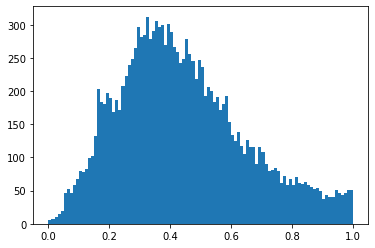

In [28]:
import matplotlib.pyplot as plt
plt.hist(np.unique(np.concatenate((p1,p2),axis=0)),bins = 100)
plt.show()

In [29]:
df = df.drop(columns = ['worker','less_toxic','more_toxic','less_pre','more_pre'])
df.to_csv(f"./mdb/jx_rbbtm_2882_mpl_5f_02ldrop_0.5margin_r.csv", index=False)

In [35]:
model = AutoModel.from_pretrained('./multilingual-toxic-xlm-roberta')
model.save_pretrained('./mdb')
CONFIG['tokenizer'].save_pretrained('./mdb')

('./mdb/tokenizer_config.json',
 './mdb/special_tokens_map.json',
 './mdb/sentencepiece.bpe.model',
 './mdb/added_tokens.json',
 './mdb/tokenizer.json')

In [ ]:
# !rm ./j_btb_30.17_mpl_5f_02ldrop_0margin.csv

In [30]:
!apt-get install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


In [31]:
!zip -q -r jx_rbbtm_2882_mpl_5f_02ldrop_0.5margin.zip ./mdb

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Visualizations</h1></span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;"><a href="https://wandb.ai/dchanda/Jigsaw">View the Complete Dashboard Here ⮕</a></span>

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)